In [1]:
import ae
import tensorflow as tf
import os
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from audioop import rms
from matplotlib.pyplot import ylabel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-02-13 03:04:01.249079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 03:04:01.606283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-13 03:04:02.713684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/
2023-02-13 03:04:02.714020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [52]:
def testset(test_path, model, dmg=False):
    ae_test = ae.autoEncoder()
    data = []
    names = []
    imgHeight = 48
    imgWidth = 48
    imgChannel = 3
    img_shape = (imgHeight, imgWidth, imgChannel)
    ts_db = os.path.join(test_path)
    for img in os.listdir(ts_db):
        image = Image.open(os.path.join(ts_db, img)).convert('RGB')
        image = image.resize((imgHeight,imgWidth))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        if dmg:
            names.append(img)
    test_data = np.array(data)
    gen = model.predict(test_data)
    tensor_test = tf.convert_to_tensor(test_data, dtype=tf.float32)
    ssim_vals = []
    psnr_vals = []
    rmse_vals = []
    mre_vals = []
    for i in range(len(test_data)):
        ssim_val = ae_test.compMetric(tensor_test[i], gen[i], "SSIM")
        psnr_val = ae_test.compMetric(tensor_test[i], gen[i], "PSNR")
        rmse_val = ae_test.compMetric(tensor_test[i], gen[i], "RMSE")
        mre_val = ae_test.compMetric(tensor_test[i], gen[i], "MRE")

        ssim_vals.append(ssim_val)
        psnr_vals.append(psnr_val)
        rmse_vals.append(rmse_val)
        mre_vals.append(mre_val)

        if dmg:
            print('Image',names[i],'ssim: ',float(ssim_val),' psnr: ', float(psnr_val), ' rmse: ', float(rmse_val), ' mre: ', mre_val)

    if dmg == False:
        print("#Instances: ", len(ssim_vals))
    return ssim_vals, psnr_vals, rmse_vals, mre_vals

def visualize(ssim_vals, psnr_vals, rmse_vals, mre_vals, sign):
    std_ssim = np.std(ssim_vals)
    mean_ssim = np.mean(ssim_vals)

    std_psnr = np.std(psnr_vals)
    mean_psnr = np.mean(psnr_vals)

    std_rmse = np.std(rmse_vals)
    mean_rmse = np.mean(rmse_vals)

    std_mre = np.std(mre_vals)
    mean_mre = np.mean(mre_vals)


    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Image Comparison Metrics Distributions of Sign '+sign)


    ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'SSIM Distance', ylabel = "#Instances")

    print("ssim mean: ", mean_ssim, " ssim \u03C3: ", std_ssim, " ssim \u03BC+\u03C3: ", std_ssim+mean_ssim)
    print("ssim \u03BC+1.5\u03C3: ", (1.5)*std_ssim+mean_ssim, " ssim \u03BC+2\u03C3: ", (2.0)*std_ssim+mean_ssim)
    ax.axvline(mean_ssim, color='red', linewidth=2)
    ax.axvline(std_ssim+mean_ssim, color='green', linewidth=2)
    ax.axvline((1.5)*std_ssim+mean_ssim, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_ssim+mean_ssim, color='purple', linewidth=2)


    ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'PSNR Distance', ylabel = "#Instances")
    print("psnr mean: ", mean_psnr, " psnr \u03C3: ", std_psnr, " psnr \u03BC+\u03C3: ", std_psnr+mean_psnr)
    print("psnr \u03BC+1.5\u03C3: ", (1.5)*std_psnr+mean_psnr, " psnr \u03BC+2\u03C3: ", (2.0)*std_psnr+mean_psnr)
    ax.axvline(mean_psnr, color='red', linewidth=2)
    ax.axvline(std_psnr+mean_psnr, color='green', linewidth=2)
    ax.axvline((1.5)*std_psnr+mean_psnr, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_psnr+mean_psnr, color='purple', linewidth=2)

    ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'RMSE Distance', ylabel = "#Instances")
    print("rmse mean: ", mean_rmse, " rmse \u03C3: ", std_rmse, " rmse \u03BC+\u03C3: ", std_rmse+mean_rmse)
    print("rmse \u03BC+1.5\u03C3: ", (1.5)*std_rmse+mean_rmse, " rmse \u03BC+2\u03C3: ", (2.0)*std_rmse+mean_rmse)
    ax.axvline(mean_rmse, color='red', linewidth=2)
    ax.axvline(std_rmse+mean_rmse, color='green', linewidth=2)
    ax.axvline((1.5)*std_rmse+mean_rmse, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_rmse+mean_rmse, color='purple', linewidth=2)

    ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],
                color = 'darkblue',
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4, 'color': 'orange'})

    ax.set(xlabel = 'MRE Distance', ylabel = "#Instances")
    print("mre mean: ", mean_mre, " mre \u03C3: ", std_mre, " mre \u03BC+\u03C3: ", std_mre+mean_mre)
    print("mre \u03BC+1.5\u03C3: ", (1.5)*std_mre+mean_mre, " mre \u03BC+2\u03C3: ", (2.0)*std_mre+mean_mre)
    ax.axvline(mean_mre, color='red', linewidth=2)
    ax.axvline(std_mre+mean_mre, color='green', linewidth=2)
    ax.axvline((1.5)*std_mre+mean_mre, color='yellow', linewidth=2)
    ax.axvline((2.0)*std_mre+mean_mre, color='purple', linewidth=2)



In [3]:
weight_file_cropped_all = "/home/can/desktop_thesis/ae_weights/cropped_allfullmodel1mse.h5"
ae_cropped_all = ae.autoEncoder()
model_cropped_all= ae_cropped_all.loadModel(weight_file_cropped_all)

# test_path1 = "/home/can/desktop_thesis/gtsrb/damaged_signs/1/"
# test_path9 = "/home/can/desktop_thesis/gtsrb/damaged_signs/9/"
# test_path14 = "/home/can/desktop_thesis/gtsrb/damaged_signs/14/"
# test_path17 = "/home/can/desktop_thesis/gtsrb/damaged_signs/17/"
# test_path25 = "/home/can/desktop_thesis/gtsrb/damaged_signs/25/"
# test_path39 = "/home/can/desktop_thesis/gtsrb/damaged_signs/39/"

# test_path1_dmg = "/home/can/thesis/gtsrb/damaged_signs/1/dmg/"
# test_path9_dmg = "/home/can/thesis/gtsrb/damaged_signs/9/dmg/"
# test_path14_dmg = "/home/can/thesis/gtsrb/damaged_signs/14/dmg/"
# test_path17_dmg = "/home/can/thesis/gtsrb/damaged_signs/17/dmg/"
# test_path25_dmg = "/home/can/thesis/gtsrb/damaged_signs/25/dmg/"
# test_path39_dmg = "/home/can/thesis/gtsrb/damaged_signs/39/dmg/"

test_path0 = "/home/can/desktop_thesis/gtsrb/damaged_signs/0/"
test_path1 = "/home/can/desktop_thesis/gtsrb/damaged_signs/1/"
test_path2 = "/home/can/desktop_thesis/gtsrb/damaged_signs/2/"
test_path3 = "/home/can/desktop_thesis/gtsrb/damaged_signs/3/"
test_path4 = "/home/can/desktop_thesis/gtsrb/damaged_signs/4/"
test_path5 = "/home/can/desktop_thesis/gtsrb/damaged_signs/5/"
test_path6 = "/home/can/desktop_thesis/gtsrb/damaged_signs/6/"
test_path7 = "/home/can/desktop_thesis/gtsrb/damaged_signs/7/"
test_path8 = "/home/can/desktop_thesis/gtsrb/damaged_signs/8/"
test_path9 = "/home/can/desktop_thesis/gtsrb/damaged_signs/9/"
test_path10 = "/home/can/desktop_thesis/gtsrb/damaged_signs/10/"

test_path11 = "/home/can/desktop_thesis/gtsrb/damaged_signs/11/"
test_path12 = "/home/can/desktop_thesis/gtsrb/damaged_signs/12/"
test_path13 = "/home/can/desktop_thesis/gtsrb/damaged_signs/13/"
test_path14 = "/home/can/desktop_thesis/gtsrb/damaged_signs/14/"
test_path15 = "/home/can/desktop_thesis/gtsrb/damaged_signs/15/"
test_path16 = "/home/can/desktop_thesis/gtsrb/damaged_signs/16/"
test_path17 = "/home/can/desktop_thesis/gtsrb/damaged_signs/17/"
test_path18 = "/home/can/desktop_thesis/gtsrb/damaged_signs/18/"
test_path19 = "/home/can/desktop_thesis/gtsrb/damaged_signs/19/"
test_path20 = "/home/can/desktop_thesis/gtsrb/damaged_signs/20/"

test_path21 = "/home/can/desktop_thesis/gtsrb/damaged_signs/21/"
test_path22 = "/home/can/desktop_thesis/gtsrb/damaged_signs/22/"
test_path23 = "/home/can/desktop_thesis/gtsrb/damaged_signs/23/"
test_path24 = "/home/can/desktop_thesis/gtsrb/damaged_signs/24/"
test_path25 = "/home/can/desktop_thesis/gtsrb/damaged_signs/25/"
test_path26 = "/home/can/desktop_thesis/gtsrb/damaged_signs/26/"
test_path27 = "/home/can/desktop_thesis/gtsrb/damaged_signs/27/"
test_path28 = "/home/can/desktop_thesis/gtsrb/damaged_signs/28/"
test_path29 = "/home/can/desktop_thesis/gtsrb/damaged_signs/29/"
test_path30 = "/home/can/desktop_thesis/gtsrb/damaged_signs/30/"

test_path31 = "/home/can/desktop_thesis/gtsrb/damaged_signs/31/"
test_path32 = "/home/can/desktop_thesis/gtsrb/damaged_signs/32/"
test_path33 = "/home/can/desktop_thesis/gtsrb/damaged_signs/33/"
test_path34 = "/home/can/desktop_thesis/gtsrb/damaged_signs/34/"
test_path35 = "/home/can/desktop_thesis/gtsrb/damaged_signs/35/"
test_path36 = "/home/can/desktop_thesis/gtsrb/damaged_signs/36/"
test_path37 = "/home/can/desktop_thesis/gtsrb/damaged_signs/37/"
test_path38 = "/home/can/desktop_thesis/gtsrb/damaged_signs/38/"
test_path39 = "/home/can/desktop_thesis/gtsrb/damaged_signs/39/"
test_path40 = "/home/can/desktop_thesis/gtsrb/damaged_signs/40/"
test_path41 = "/home/can/desktop_thesis/gtsrb/damaged_signs/41/"
test_path42 = "/home/can/desktop_thesis/gtsrb/damaged_signs/42/"

2023-02-13 03:04:04.979388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:04:05.057258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:04:05.057746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 03:04:05.059142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

23/23 [==============================] - 0s 3ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.11927184901303715  ssim σ:  0.06287649008266877  ssim μ+σ:  0.18214833909570594
ssim μ+1.5σ:  0.2135865841370403  ssim μ+2σ:  0.2450248291783747
psnr mean:  0.28767186391327637  psnr σ:  0.015254446485997636  psnr μ+σ:  0.302926310399274
psnr μ+1.5σ:  0.31055353364227284  psnr μ+2σ:  0.31818075688527164
rmse mean:  0.059926108  rmse σ:  0.023495395  rmse μ+σ:  0.0834215
rmse μ+1.5σ:  0.0951691996306181  rmse μ+2σ:  0.1069168969988823
mre mean:  0.12760964  mre σ:  0.03818554  mre μ+σ:  0.16579518
mre μ+1.5σ:  0.1848879512399435  mre μ+2σ:  0.2039807215332985
1/1 [==============================] - 0s 15ms/step
Image 5.png ssim:  0.5771467387676239  psnr:  0.24524943033854166  rmse:  0.1903749257326126  mre:  1.0237849
Image 0.png ssim:  0.5012859404087067  psnr:  0.23785530539119945  rmse:  0.23652926087379456  mre:  1.1281636
Image 4.png ssim:  0.2586226463317871  ps

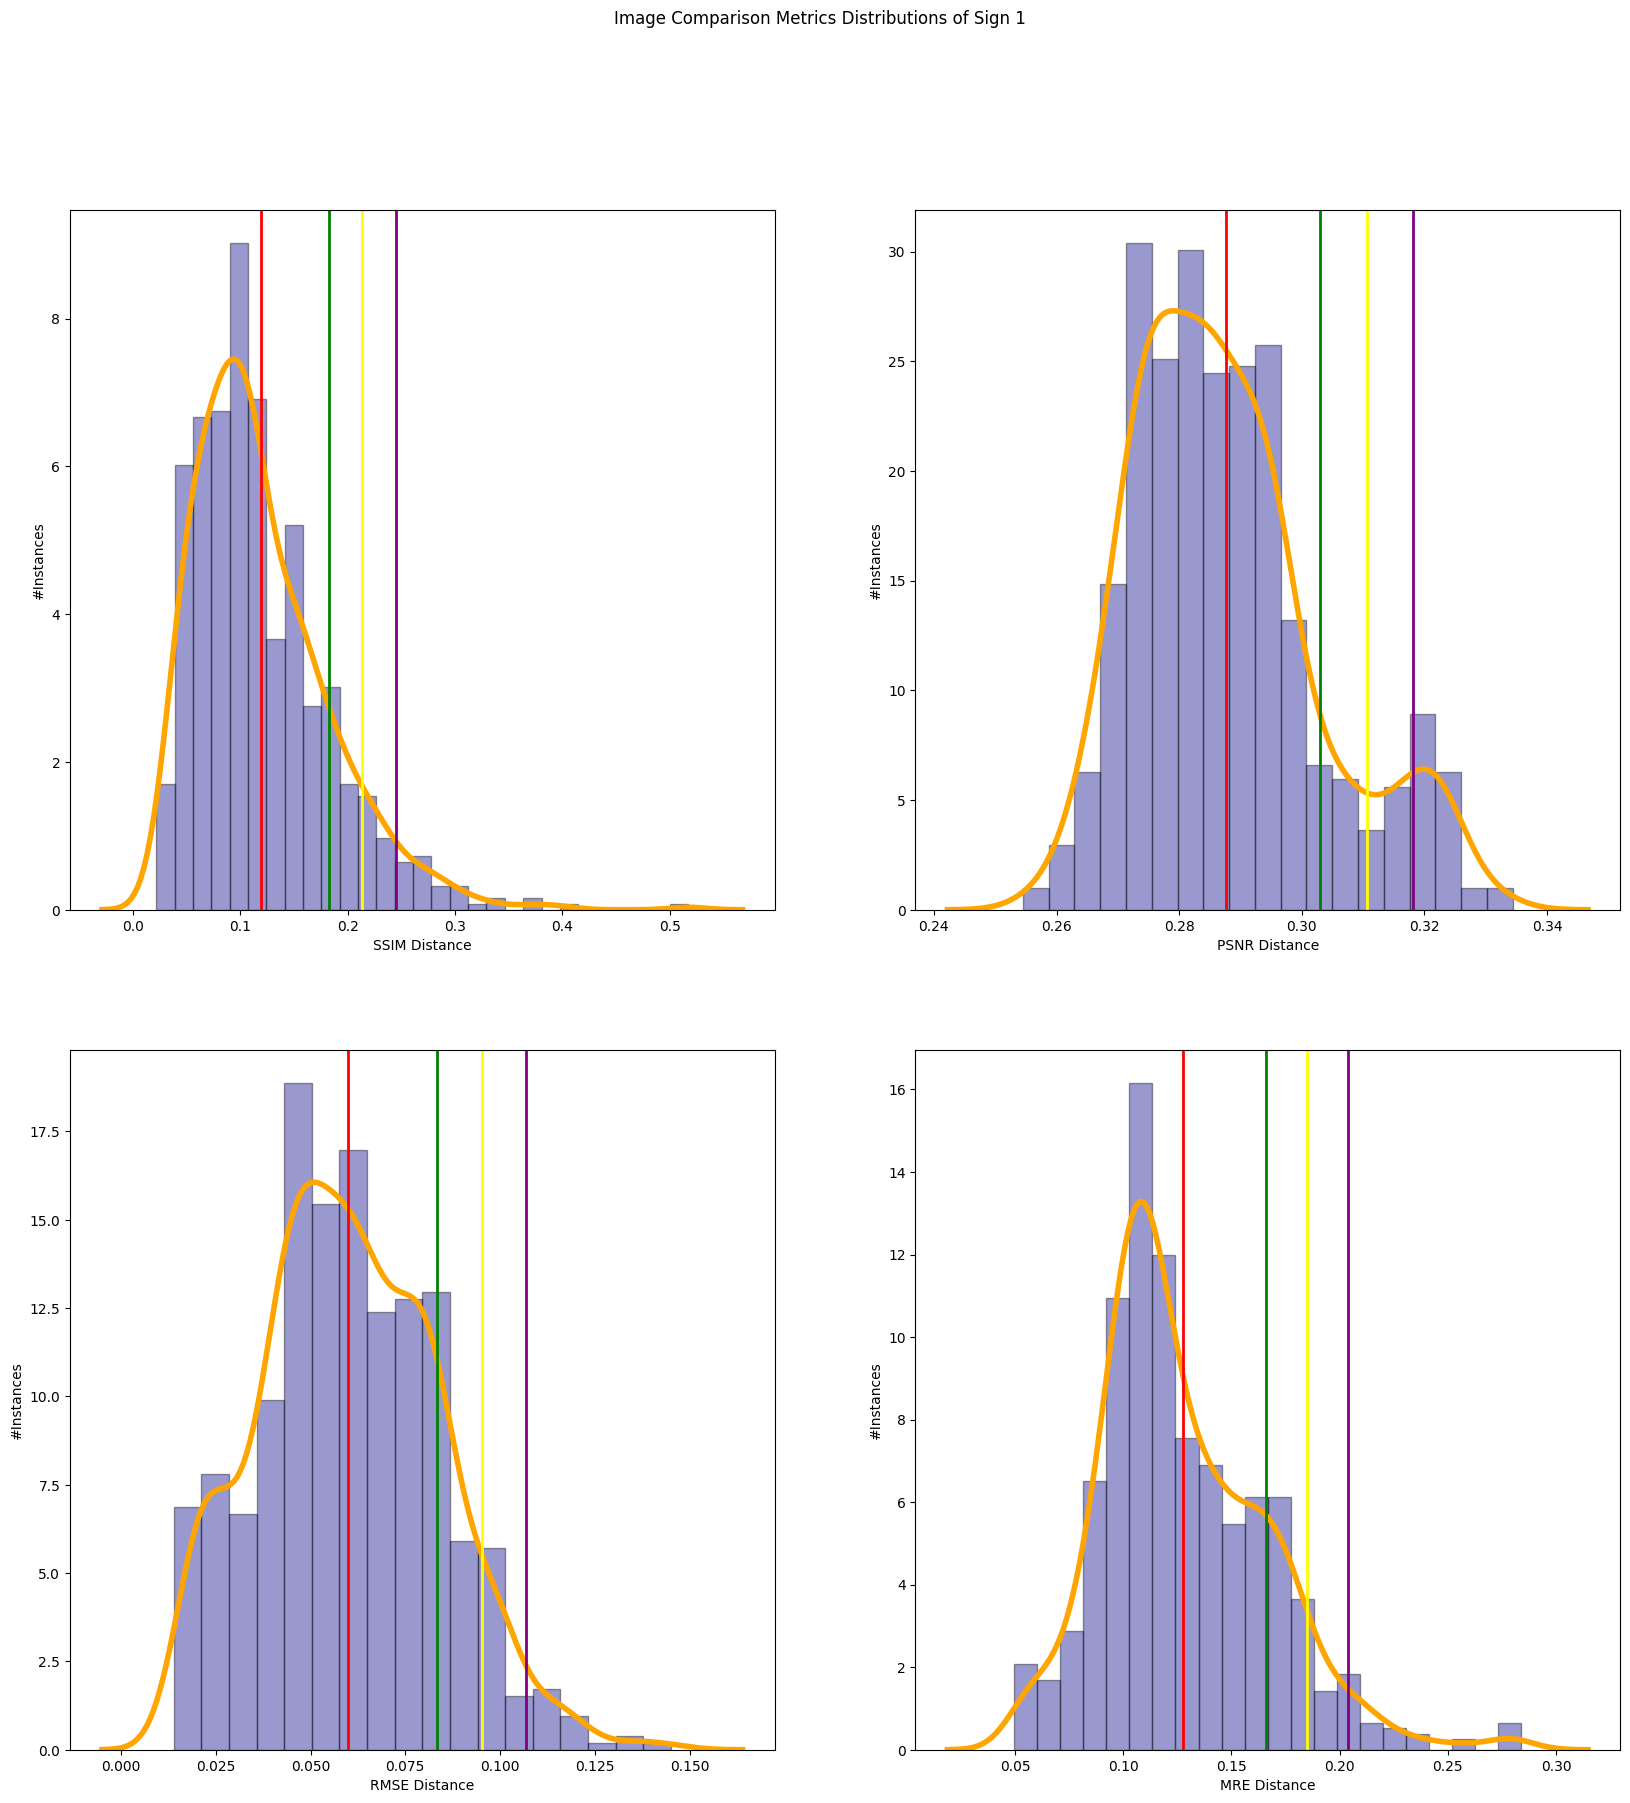

In [66]:
ssim1, psnr1, rmse1, mre1 = testset(test_path1, model_cropped_all)
visualize(ssim1, psnr1, rmse1, mre1, "1")
_,_,_,_ = testset(test_path1_dmg, model_cropped_all,True)


15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.11968402291337649  ssim σ:  0.07379357619008053  ssim μ+σ:  0.19347759910345702
ssim μ+1.5σ:  0.2303743871984973  ssim μ+2σ:  0.26727117529353756
psnr mean:  0.30187651235293717  psnr σ:  0.01948760731320914  psnr μ+σ:  0.3213641196661463
psnr μ+1.5σ:  0.33110792332275085  psnr μ+2σ:  0.34085172697935545
rmse mean:  0.042066257  rmse σ:  0.023607705  rmse μ+σ:  0.06567396
rmse μ+1.5σ:  0.07747781462967396  rmse μ+2σ:  0.08928166702389717
mre mean:  0.14482372  mre σ:  0.084976755  mre μ+σ:  0.22980046
mre μ+1.5σ:  0.27228884771466255  mre μ+2σ:  0.3147772252559662
1/1 [==============================] - 0s 15ms/step
Image 0.png ssim:  0.4873034954071045  psnr:  0.25531735887714463  rmse:  0.14165879786014557  mre:  0.30653304
Image 1.png ssim:  0.6276756823062897  psnr:  0.25450906192555145  rmse:  0.14506062865257263  mre:  0.48034883
Image 2.png ssim:  0.54716134071

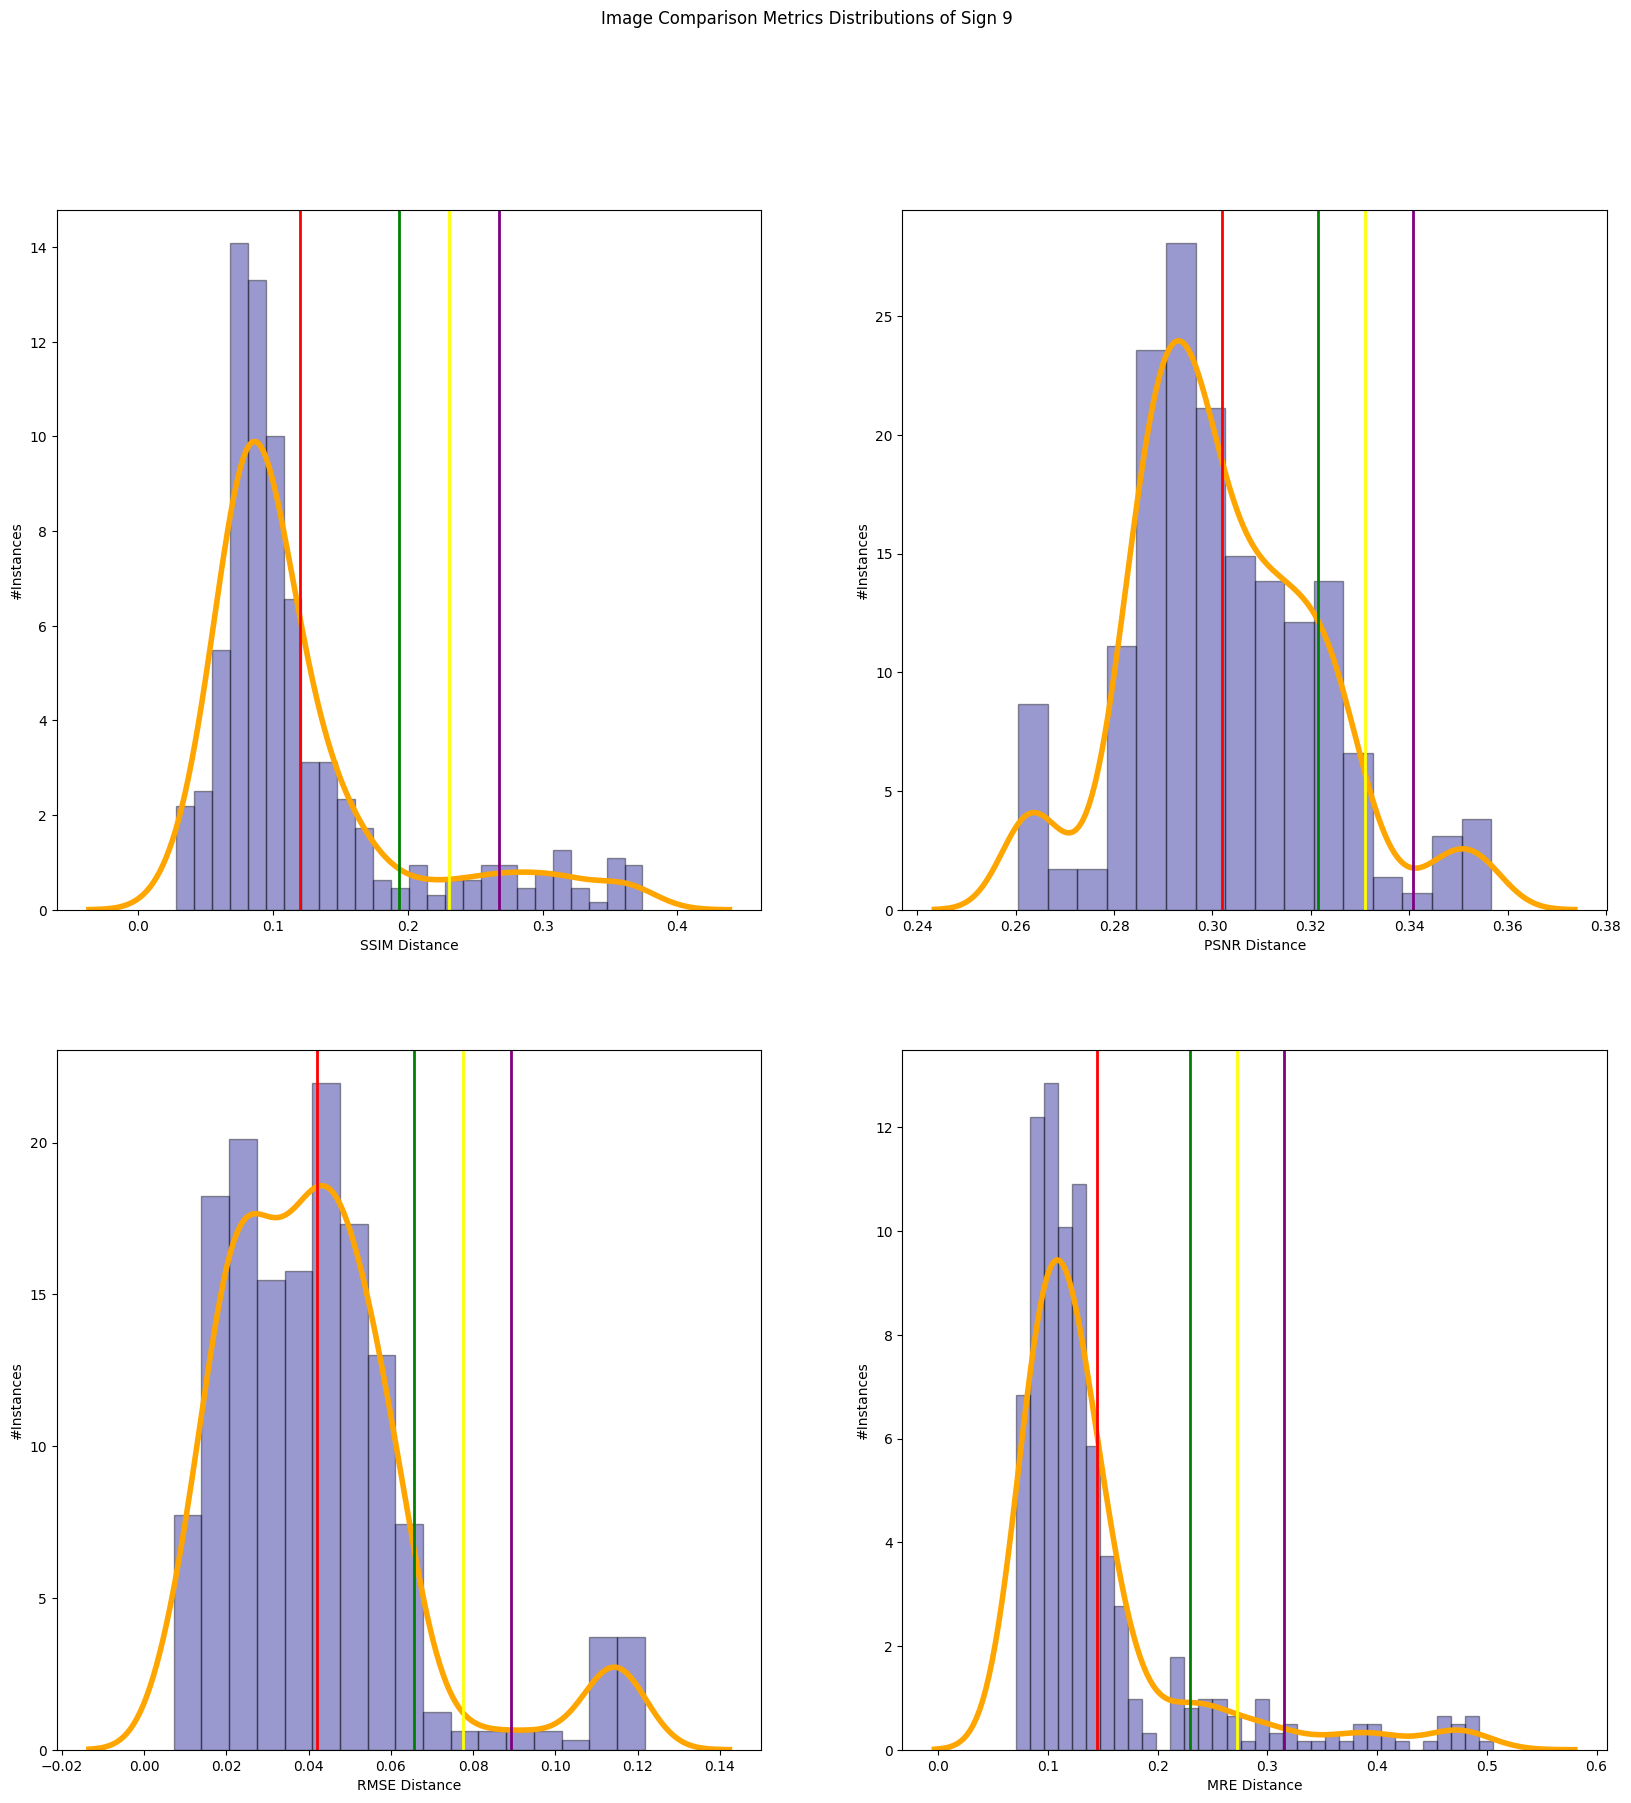

In [67]:
ssim9, psnr9, rmse9, mre9 = testset(test_path9, model_cropped_all)
visualize(ssim9, psnr9, rmse9, mre9,"9")
_,_,_,_ = testset(test_path9_dmg, model_cropped_all,True)

9/9 [==============================] - 0s 3ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.18265231163413437  ssim σ:  0.09465374209728454  ssim μ+σ:  0.2773060537314189
ssim μ+1.5σ:  0.32463292478006117  ssim μ+2σ:  0.3719597958287034
psnr mean:  0.28473914684553286  psnr σ:  0.015476574010165722  psnr μ+σ:  0.3002157208556986
psnr μ+1.5σ:  0.3079540078607814  psnr μ+2σ:  0.3156922948658643
rmse mean:  0.064877406  rmse σ:  0.022056278  rmse μ+σ:  0.08693369
rmse μ+1.5σ:  0.09796182252466679  rmse μ+2σ:  0.10898996144533157
mre mean:  0.18149006  mre σ:  0.06843213  mre μ+σ:  0.24992219
mre μ+1.5σ:  0.2841382585465908  mre μ+2σ:  0.3183543235063553
1/1 [==============================] - 0s 14ms/step
Image 11.png ssim:  0.4916558861732483  psnr:  0.265247330011106  rmse:  0.10583679378032684  mre:  0.17772624
Image 5.png ssim:  0.33677762746810913  psnr:  0.25223215140548405  rmse:  0.15508873760700226  mre:  0.49165648
Image 7.png ssim:  0.39451050758361816

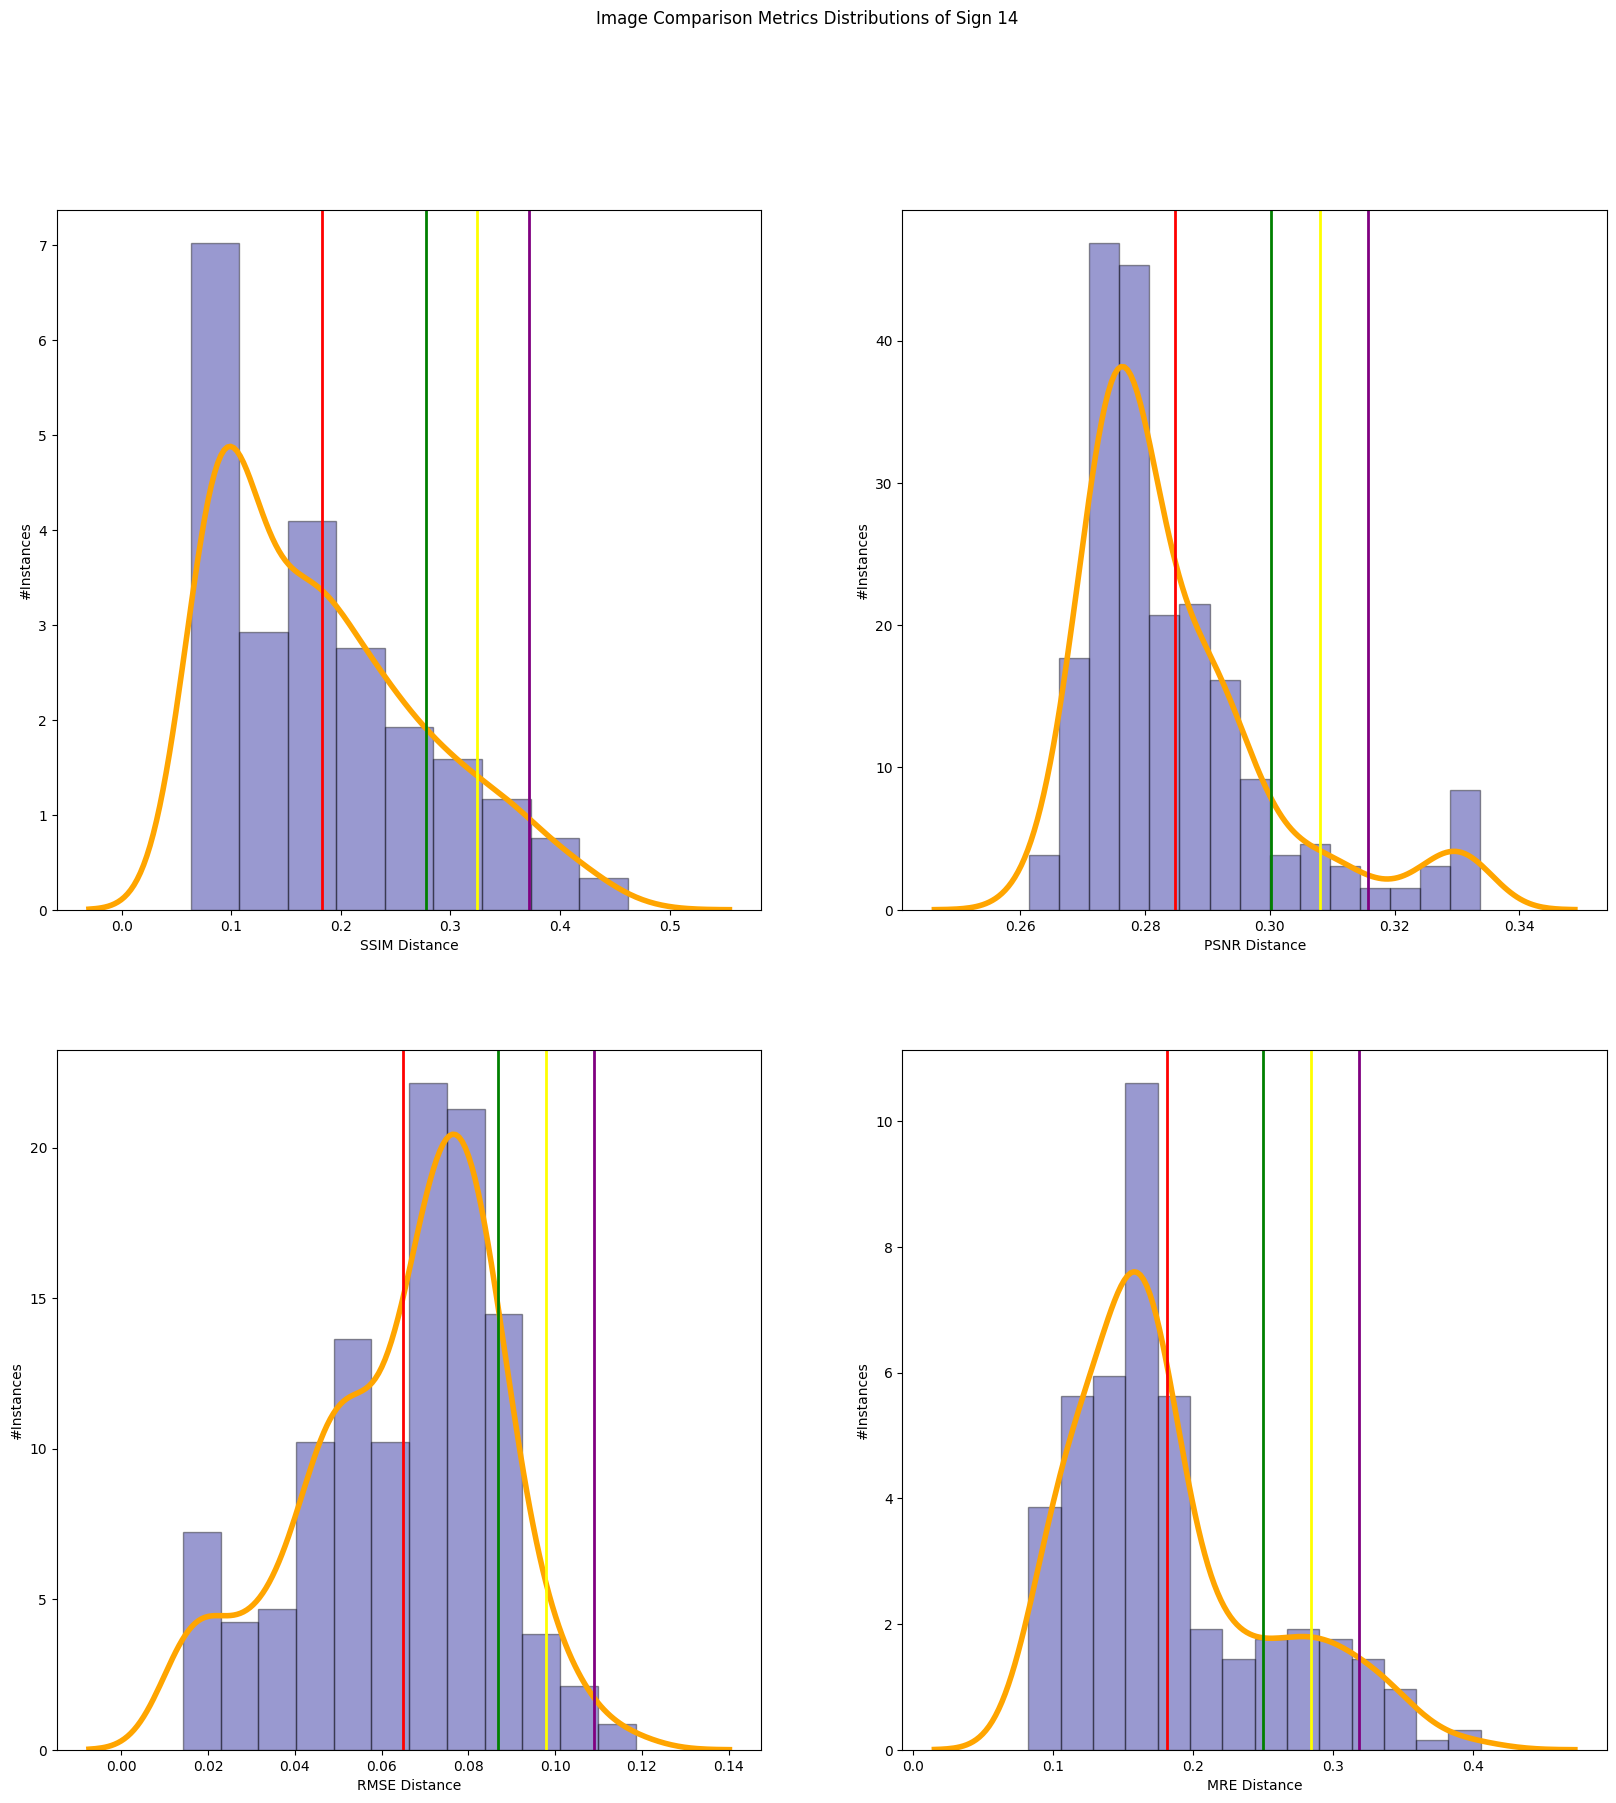

In [68]:
ssim14, psnr14, rmse14, mre14 = testset(test_path14, model_cropped_all)
visualize(ssim14, psnr14, rmse14, mre14,"14")
_,_,_,_ = testset(test_path14_dmg, model_cropped_all,True)

12/12 [==============================] - 0s 3ms/step
#Instances:  360
Destructor called, Employee deleted.
ssim mean:  0.17619811511702008  ssim σ:  0.07323149132430341  ssim μ+σ:  0.2494296064413235
ssim μ+1.5σ:  0.2860453521034752  ssim μ+2σ:  0.3226610977656269
psnr mean:  0.28674257748007514  psnr σ:  0.01684868884843946  psnr μ+σ:  0.30359126632851463
psnr μ+1.5σ:  0.3120156107527343  psnr μ+2σ:  0.32043995517695406
rmse mean:  0.06306695  rmse σ:  0.028298471  rmse μ+σ:  0.09136543
rmse μ+1.5σ:  0.1055146586149931  rmse μ+2σ:  0.11966389417648315
mre mean:  0.14787759  mre σ:  0.087903716  mre μ+σ:  0.23578131
mre μ+1.5σ:  0.27973316237330437  mre μ+2σ:  0.32368502020835876
1/1 [==============================] - 0s 14ms/step
Image 5.png ssim:  0.4270027279853821  psnr:  0.26590232101141237  rmse:  0.10382106155157089  mre:  0.2121709
Image 7.png ssim:  0.4899647831916809  psnr:  0.2548022101907169  rmse:  0.14381757378578186  mre:  0.6257188
Image 1.jpg ssim:  0.7274129092693329 

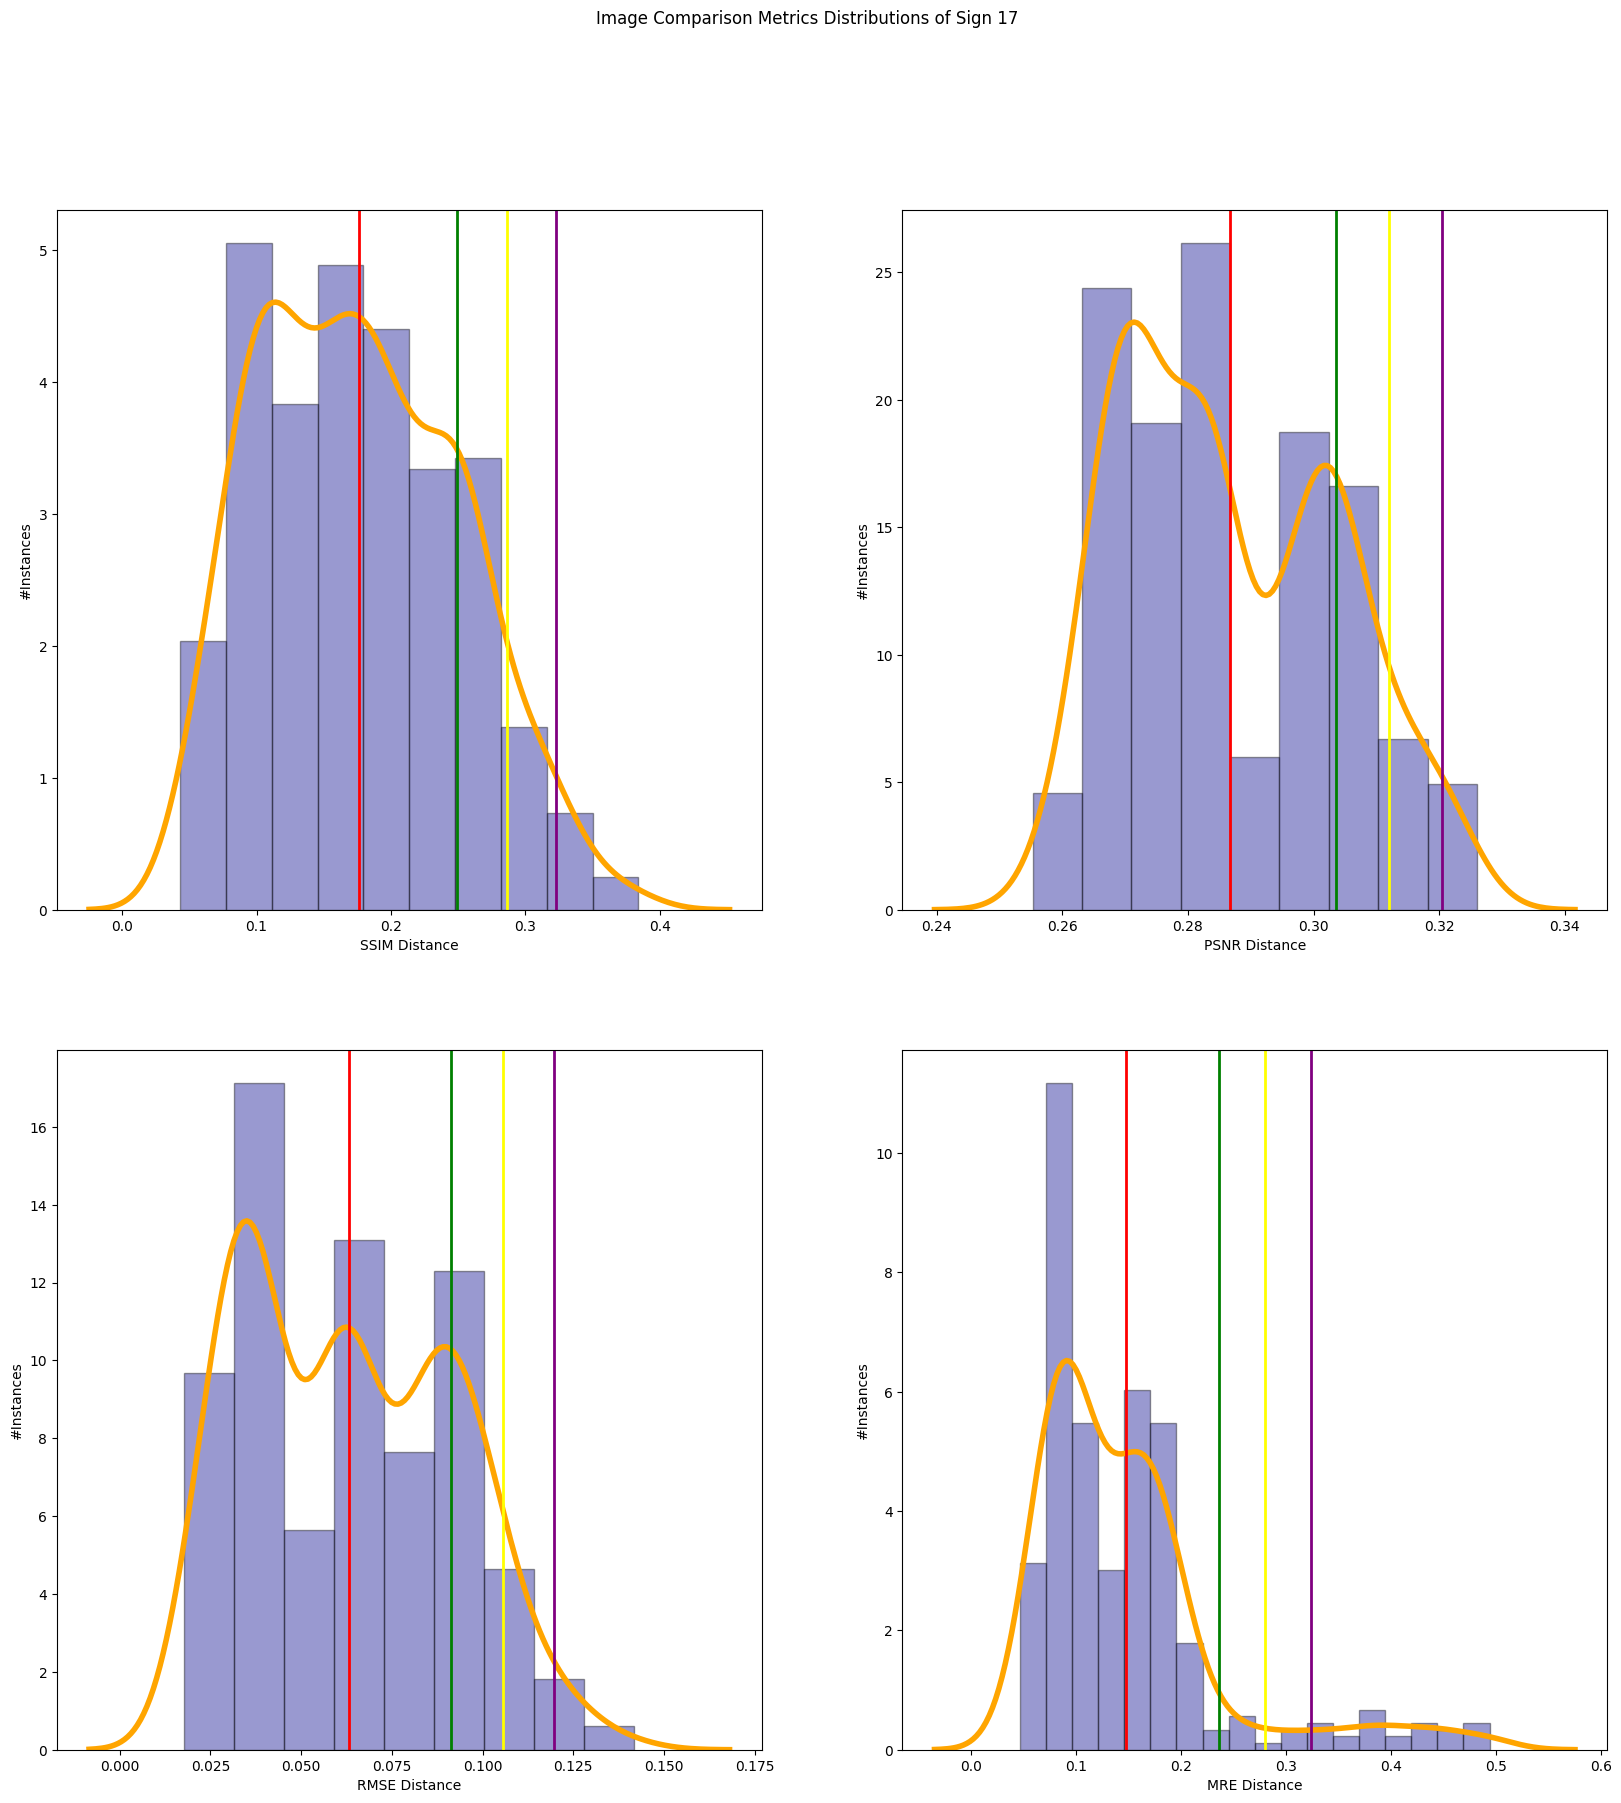

In [69]:
ssim17, psnr17, rmse17, mre17 = testset(test_path17, model_cropped_all)
visualize(ssim17, psnr17, rmse17, mre17,"17")
_,_,_,_ = testset(test_path17_dmg, model_cropped_all,True)

15/15 [==============================] - 0s 3ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.22587882100294035  ssim σ:  0.095378588805107  ssim μ+σ:  0.32125740980804735
ssim μ+1.5σ:  0.36894670421060083  ssim μ+2σ:  0.41663599861315437
psnr mean:  0.27745982219970305  psnr σ:  0.01744329531247162  psnr μ+σ:  0.2949031175121747
psnr μ+1.5σ:  0.30362476516841047  psnr μ+2σ:  0.3123464128246463
rmse mean:  0.08225671  rmse σ:  0.032315284  rmse μ+σ:  0.114571996
rmse μ+1.5σ:  0.13072963804006577  rmse μ+2σ:  0.14688728004693985
mre mean:  0.2120878  mre σ:  0.07244605  mre μ+σ:  0.28453386
mre μ+1.5σ:  0.32075686752796173  mre μ+2σ:  0.3569798916578293
1/1 [==============================] - 0s 16ms/step
Image 5.png ssim:  0.7046643793582916  psnr:  0.23978335810642618  rmse:  0.22351272404193878  mre:  2.3034708
Image 7.png ssim:  0.6747779250144958  psnr:  0.2402218687768076  rmse:  0.2206537127494812  mre:  1.3942437
Image 0.png ssim:  0.5618467032909393  p

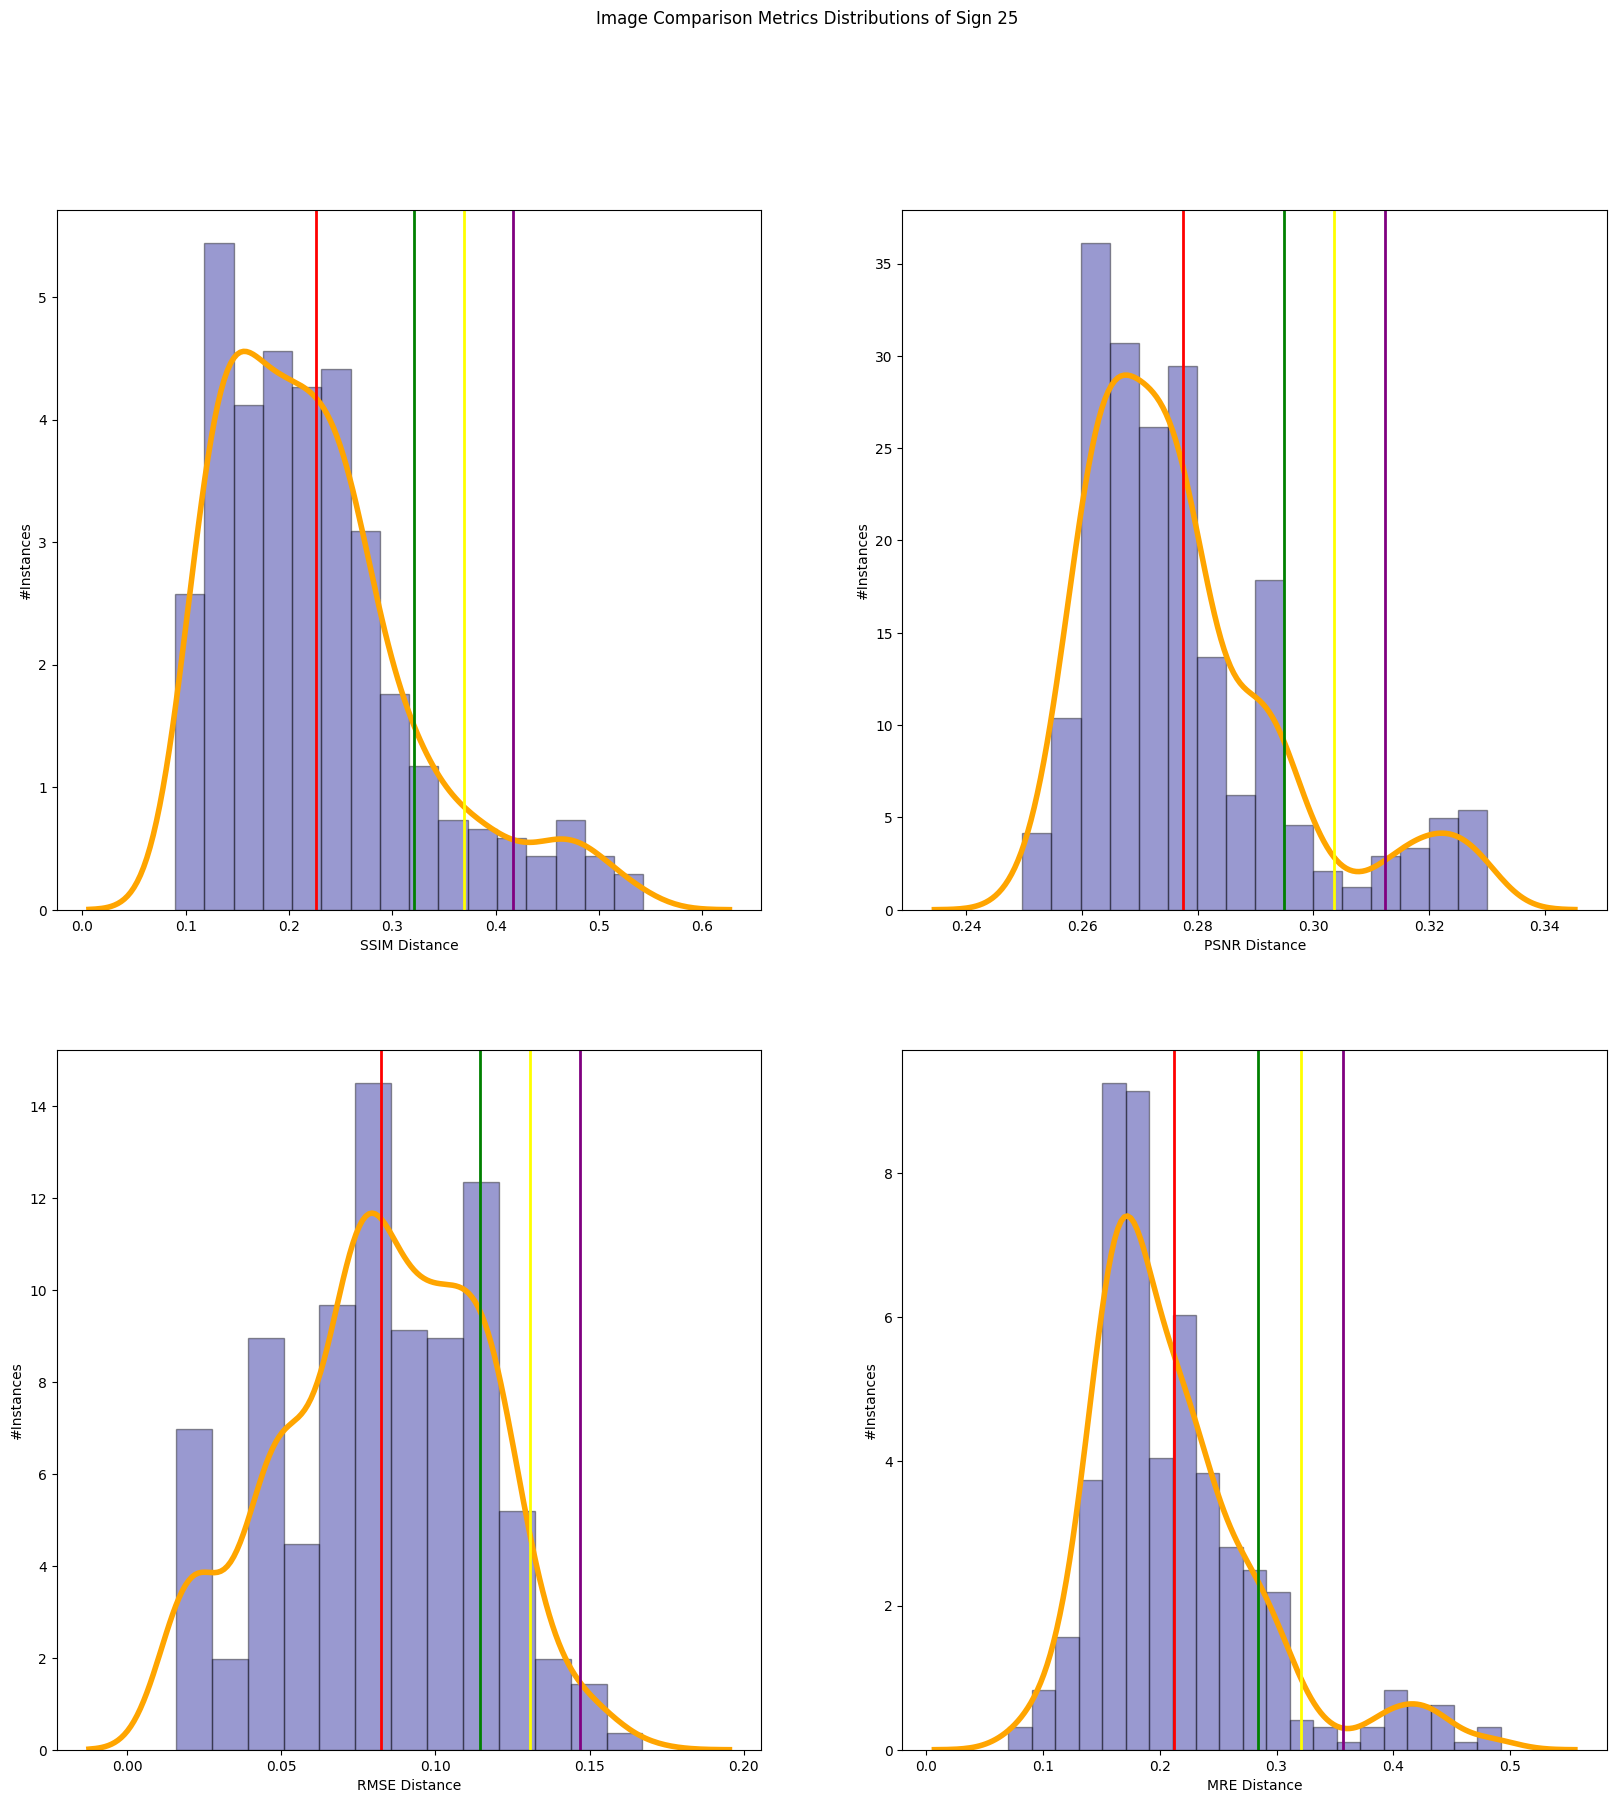

In [70]:
ssim25, psnr25, rmse25, mre25 = testset(test_path25, model_cropped_all)
visualize(ssim25, psnr25, rmse25, mre25,"25")
_,_,_,_ = testset(test_path25_dmg, model_cropped_all,True)

3/3 [==============================] - 0s 3ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.18700248731507196  ssim σ:  0.07441291808925679  ssim μ+σ:  0.2614154054043287
ssim μ+1.5σ:  0.29862186444895716  ssim μ+2σ:  0.33582832349358555
psnr mean:  0.29142962786107285  psnr σ:  0.027569827099129123  psnr μ+σ:  0.318999454960202
psnr μ+1.5σ:  0.33278436850976656  psnr μ+2σ:  0.3465692820593311
rmse mean:  0.06292863  rmse σ:  0.033540502  rmse μ+σ:  0.096469134
rmse μ+1.5σ:  0.11323938518762589  rmse μ+2σ:  0.13000963628292084
mre mean:  0.1513065  mre σ:  0.039348345  mre μ+σ:  0.19065484
mre μ+1.5σ:  0.21032901294529438  mre μ+2σ:  0.23000318557024002
1/1 [==============================] - 0s 16ms/step
Image 0.png ssim:  0.5635547935962677  psnr:  0.25611270081763177  rmse:  0.138389453291893  mre:  0.23059486
Image 3.png ssim:  0.6361558139324188  psnr:  0.24410873113893994  rmse:  0.19685831665992737  mre:  1.5228509
Image 1.png ssim:  0.6286789178848267  

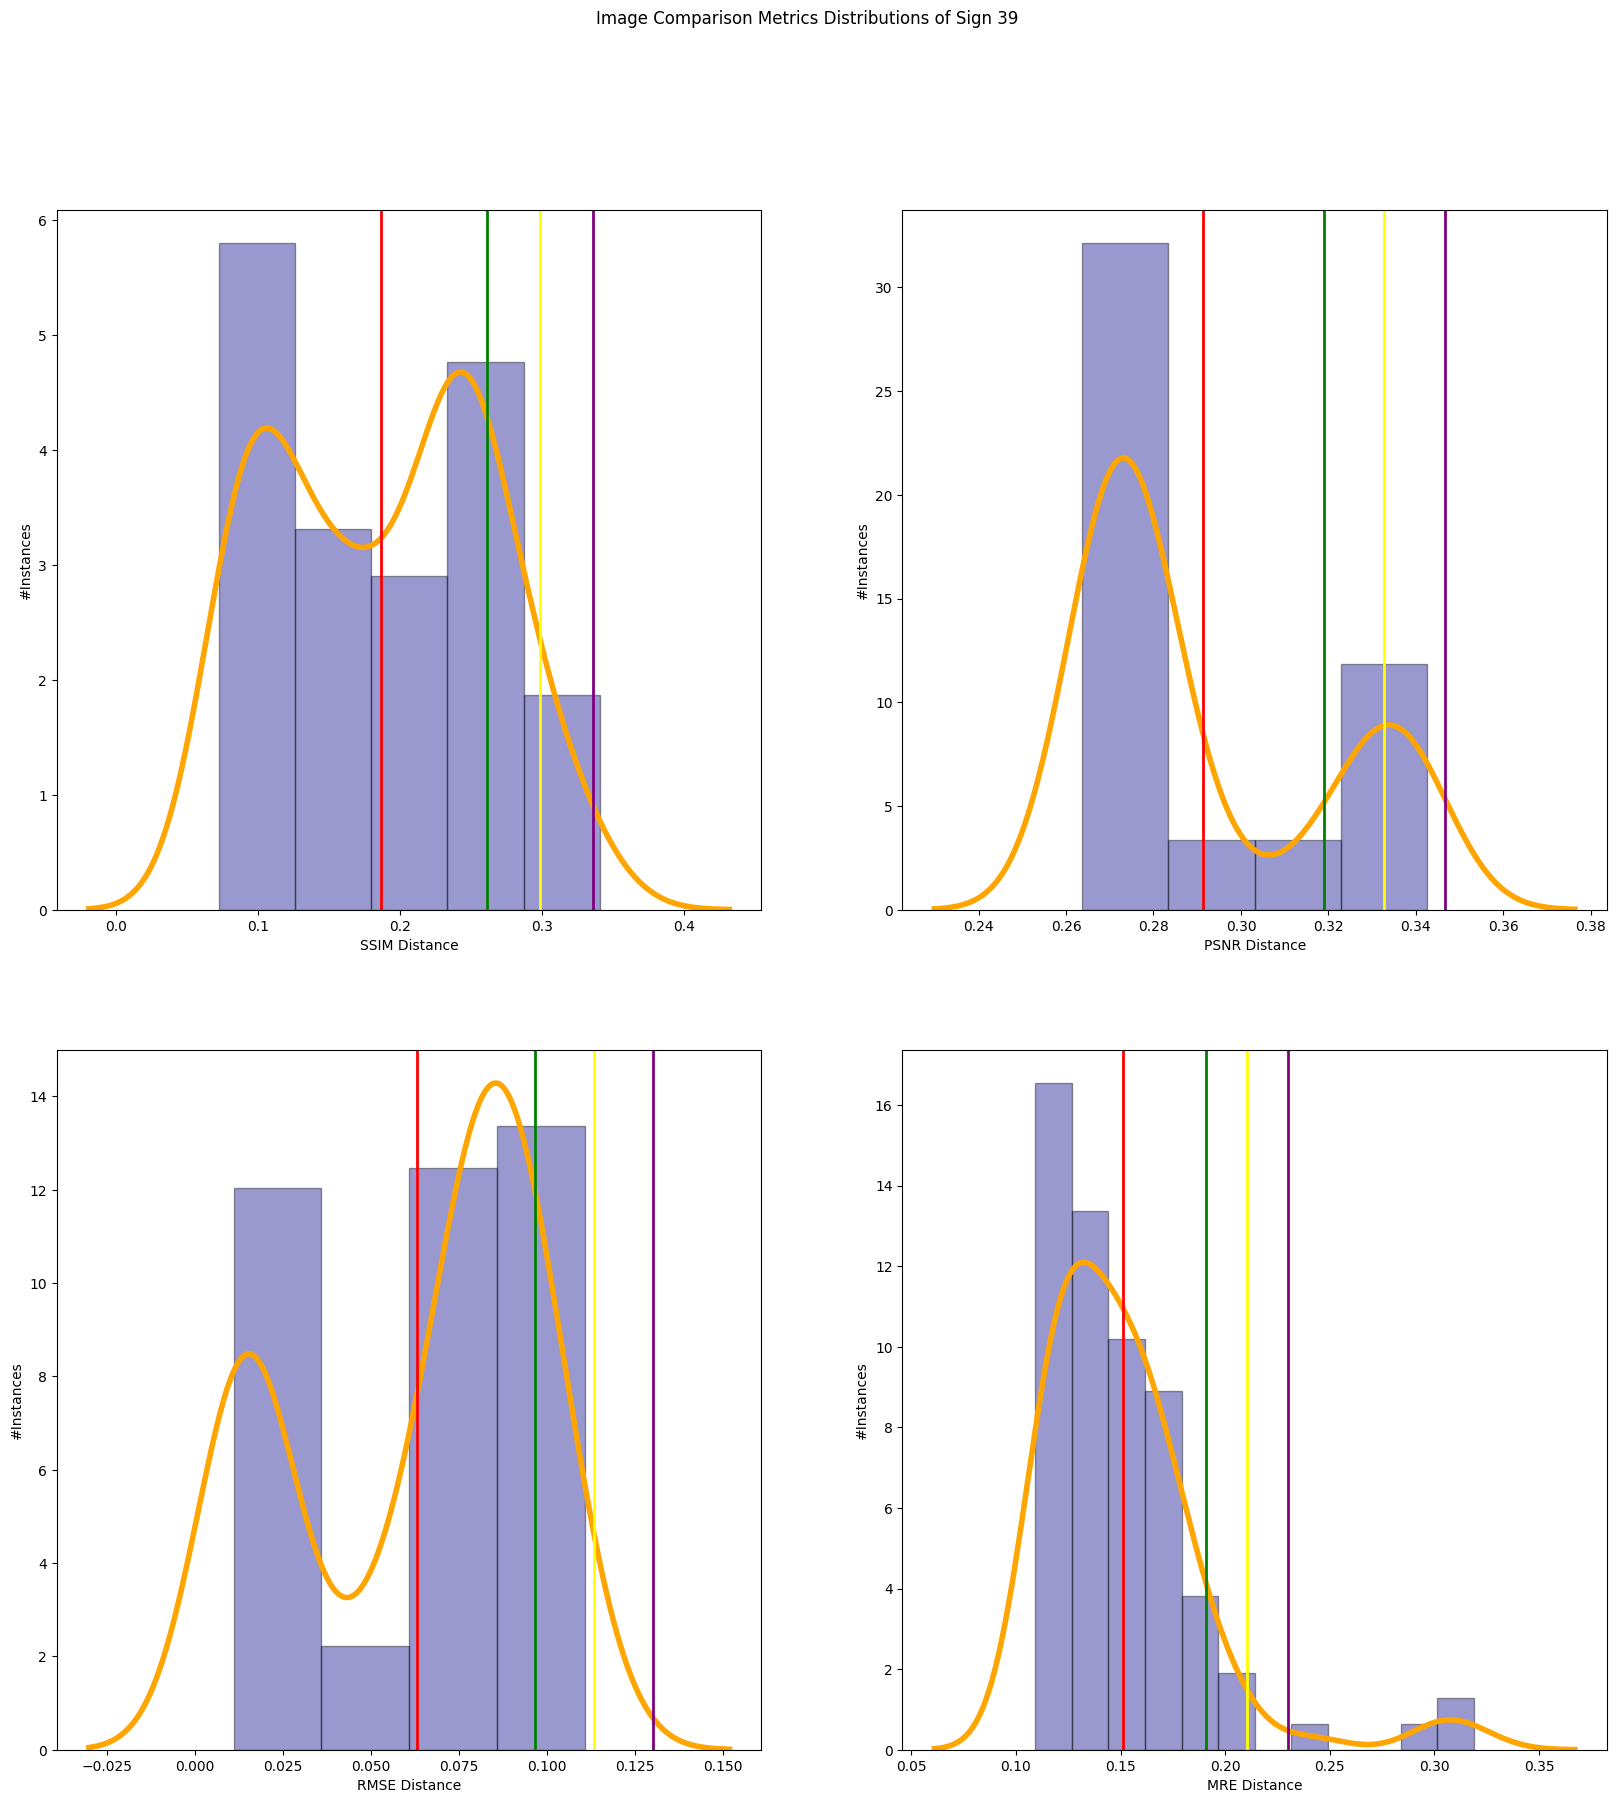

In [71]:
ssim39, psnr39, rmse39, mre39 = testset(test_path39, model_cropped_all)
visualize(ssim39, psnr39, rmse39, mre39,"39")
_,_,_,_ = testset(test_path39_dmg, model_cropped_all,True)

2/2 [==============================] - 0s 10ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.0992803027232488  ssim σ:  0.0414485591425681  ssim μ+σ:  0.1407288618658169
ssim μ+1.5σ:  0.16145314143710093  ssim μ+2σ:  0.182177421008385
psnr mean:  72.9699940999349  psnr σ:  2.810292062414806  psnr μ+σ:  75.7802861623497
psnr μ+1.5σ:  77.1854321935571  psnr μ+2σ:  78.5905782247645
rmse mean:  0.060027044  rmse σ:  0.01676216  rmse μ+σ:  0.0767892
rmse μ+1.5σ:  0.08517028391361237  rmse μ+2σ:  0.09355136379599571
mre mean:  0.14463933  mre σ:  0.033464584  mre μ+σ:  0.17810391
mre μ+1.5σ:  0.1948362048715353  mre μ+2σ:  0.21156849712133408


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

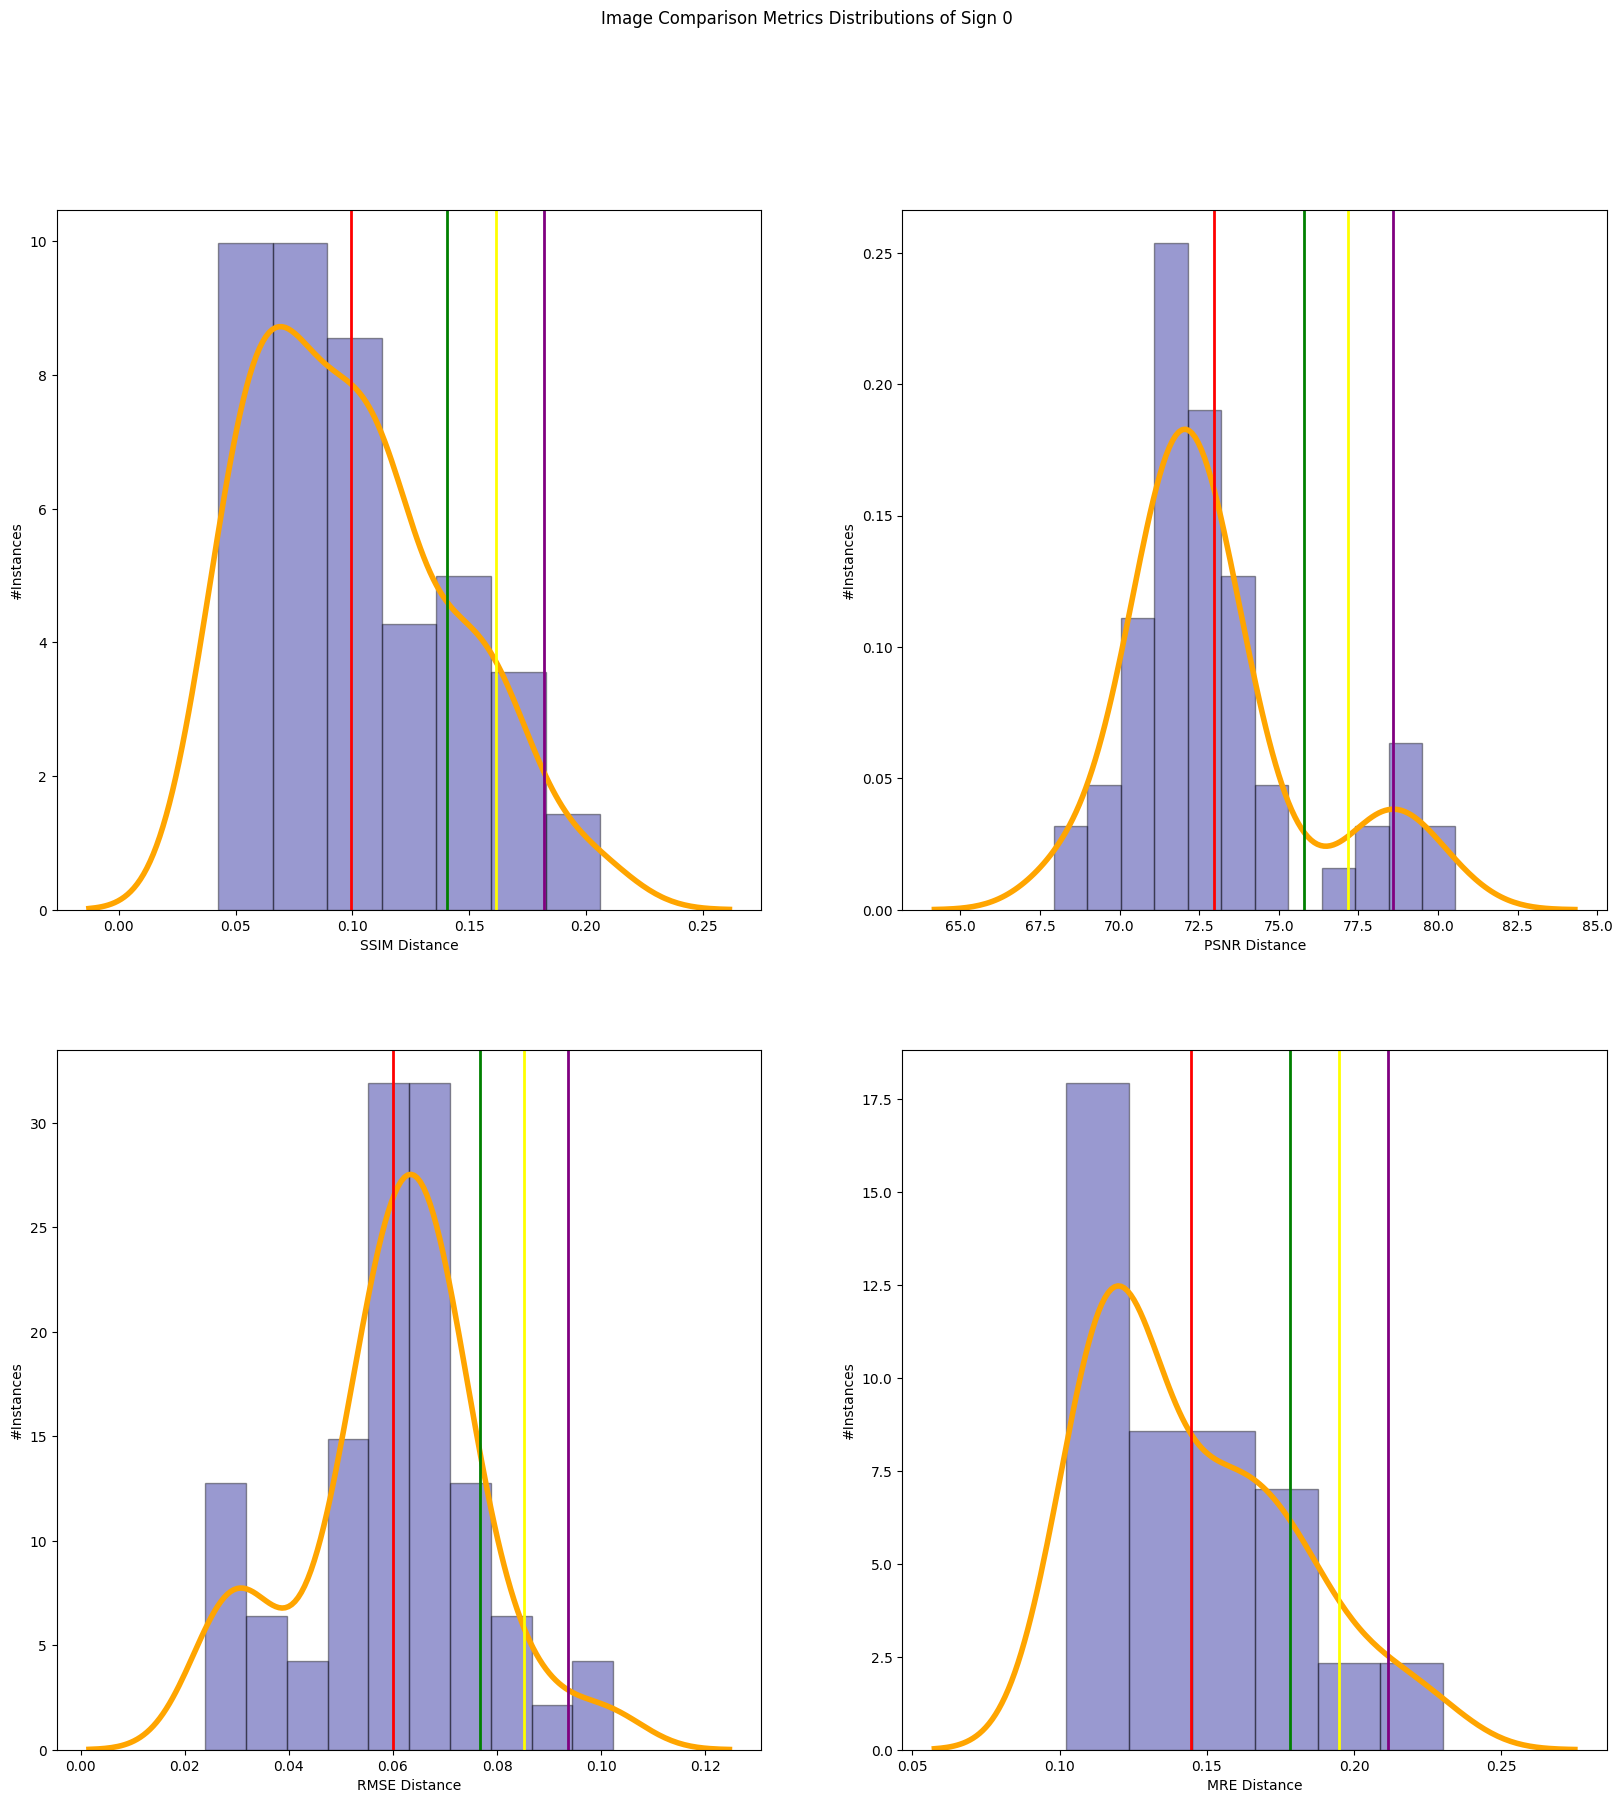

In [53]:
ssim0, psnr0, rmse0, mre0 = testset(test_path0, model_cropped_all)
visualize(ssim0, psnr0, rmse0, mre0, "0")

23/23 [==============================] - 0s 6ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.12982828546729352  ssim σ:  0.06736744442790431  ssim μ+σ:  0.19719572989519785
ssim μ+1.5σ:  0.23087945210914998  ssim μ+2σ:  0.26456317432310217
psnr mean:  71.87999354468451  psnr σ:  3.900918146568311  psnr μ+σ:  75.78091169125283
psnr μ+1.5σ:  77.73137076453698  psnr μ+2σ:  79.68182983782113


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

rmse mean:  0.07100755  rmse σ:  0.02743515  rmse μ+σ:  0.0984427
rmse μ+1.5σ:  0.11216027475893497  rmse μ+2σ:  0.12587784975767136
mre mean:  0.15917699  mre σ:  0.04433477  mre μ+σ:  0.20351176
mre μ+1.5σ:  0.22567914426326752  mre μ+2σ:  0.24784652888774872


/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


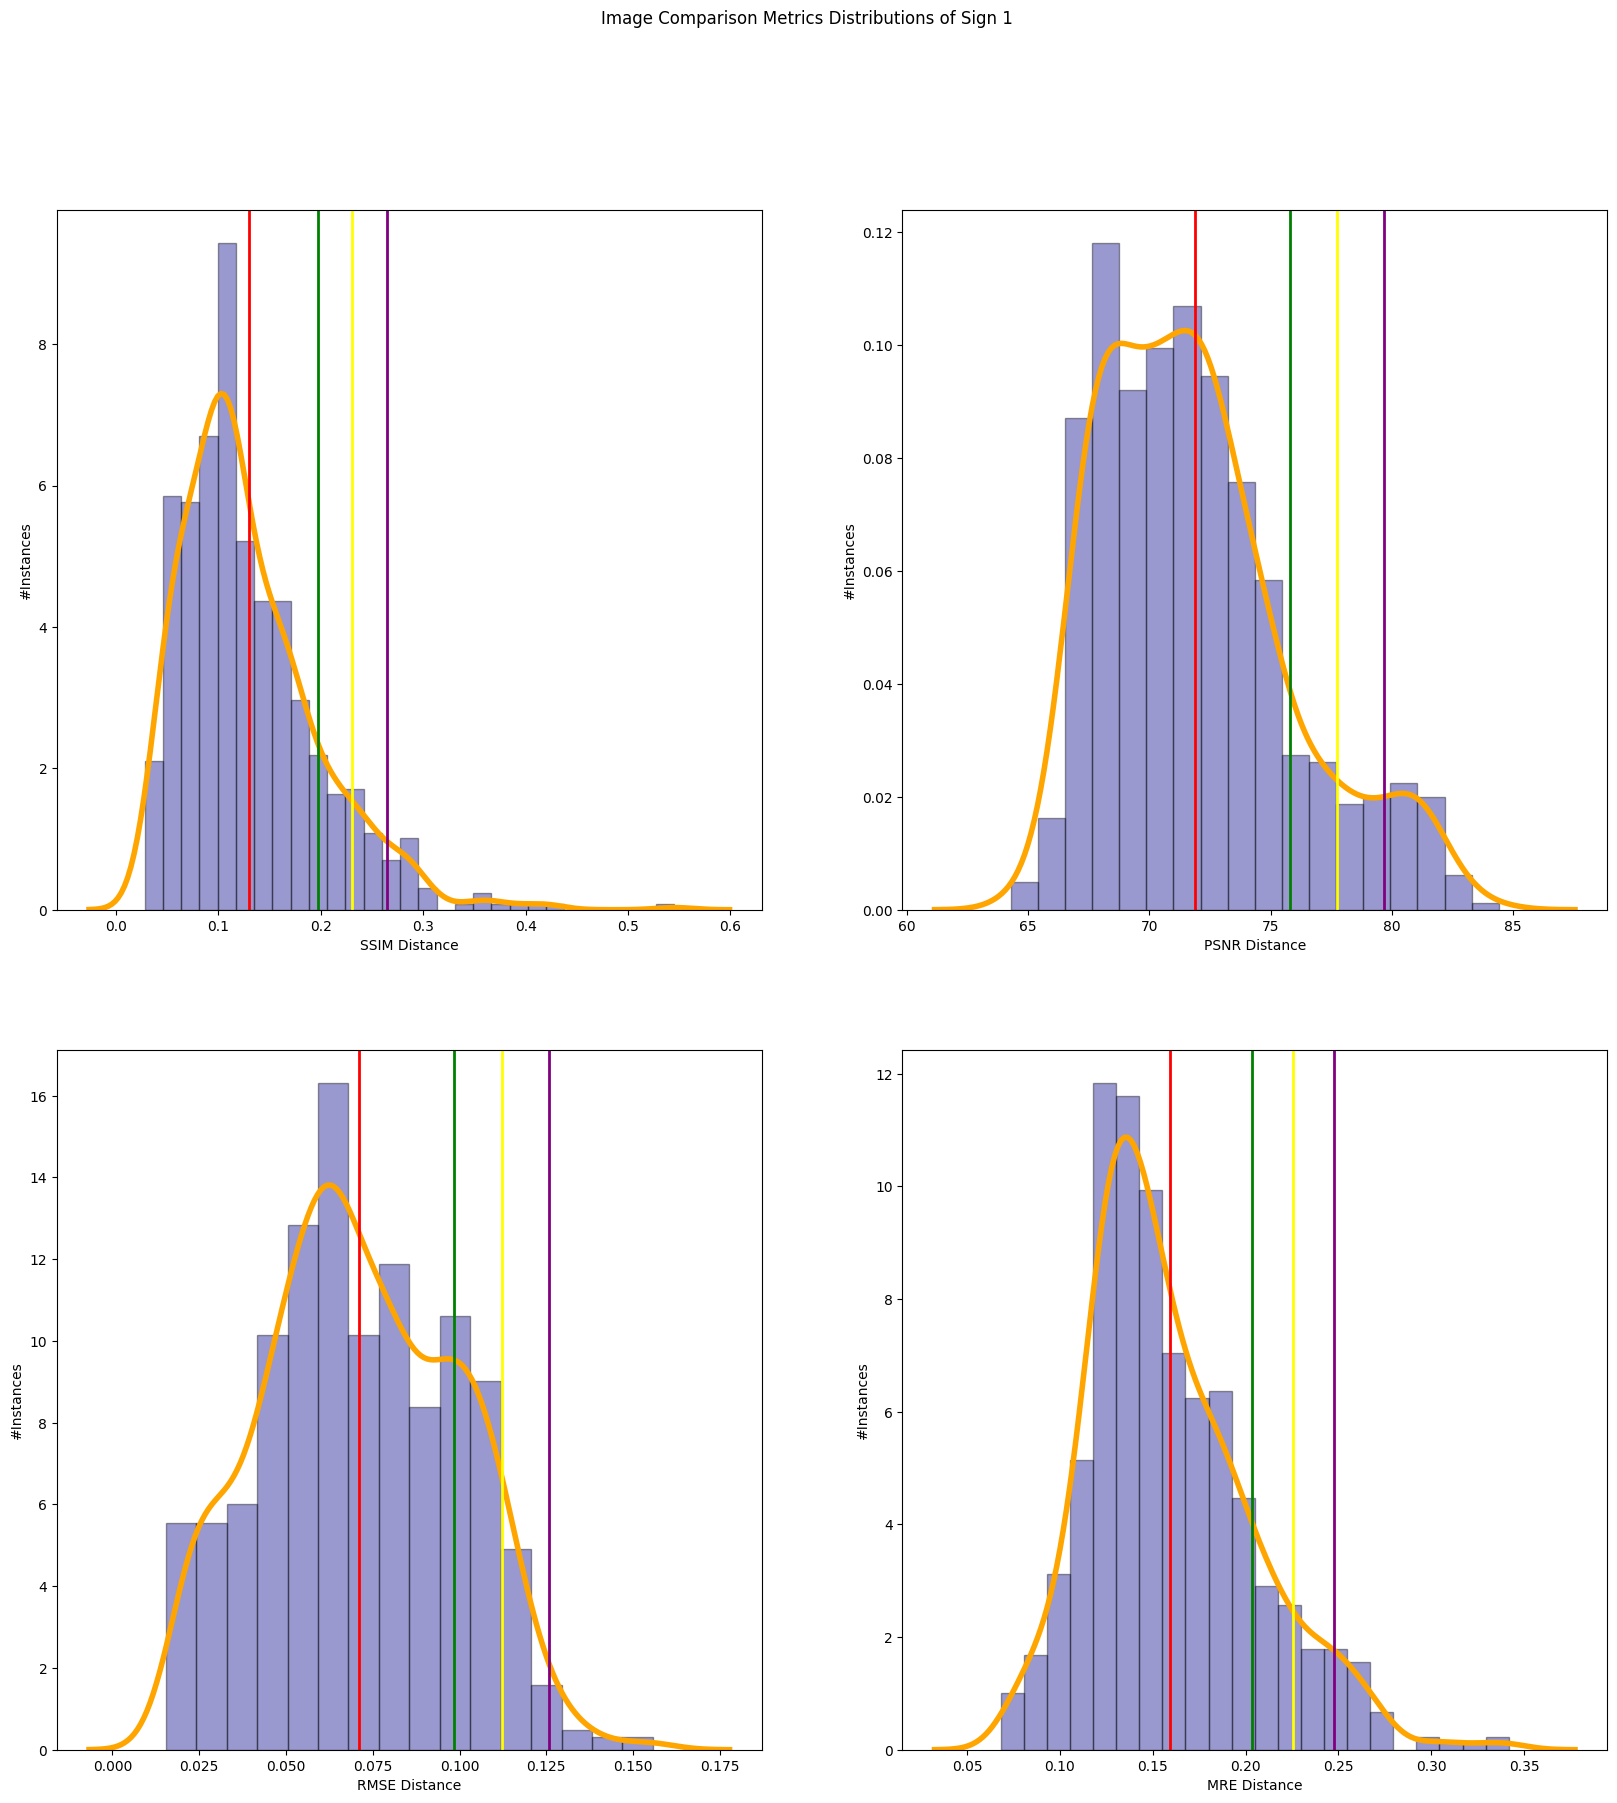

In [54]:
ssim1, psnr1, rmse1, mre1 = testset(test_path1, model_cropped_all)
visualize(ssim1, psnr1, rmse1, mre1, "1")

24/24 [==============================] - 0s 5ms/step
#Instances:  750
Destructor called, Employee deleted.
ssim mean:  0.09998105645179749  ssim σ:  0.05174025592087274  ssim μ+σ:  0.15172131237267023
ssim μ+1.5σ:  0.1775914403331066  ssim μ+2σ:  0.20346156829354295
psnr mean:  75.03596586100261  psnr σ:  4.808555114397248  psnr μ+σ:  79.84452097539986
psnr μ+1.5σ:  82.24879853259849  psnr μ+2σ:  84.65307608979711
rmse mean:  0.05231992  rmse σ:  0.027555337  rmse μ+σ:  0.07987526
rmse μ+1.5σ:  0.09365292731672525  rmse μ+2σ:  0.1074305959045887
mre mean:  0.14096002  mre σ:  0.040969416  mre μ+σ:  0.18192944
mre μ+1.5σ:  0.2024141475558281  mre μ+2σ:  0.22289885580539703


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

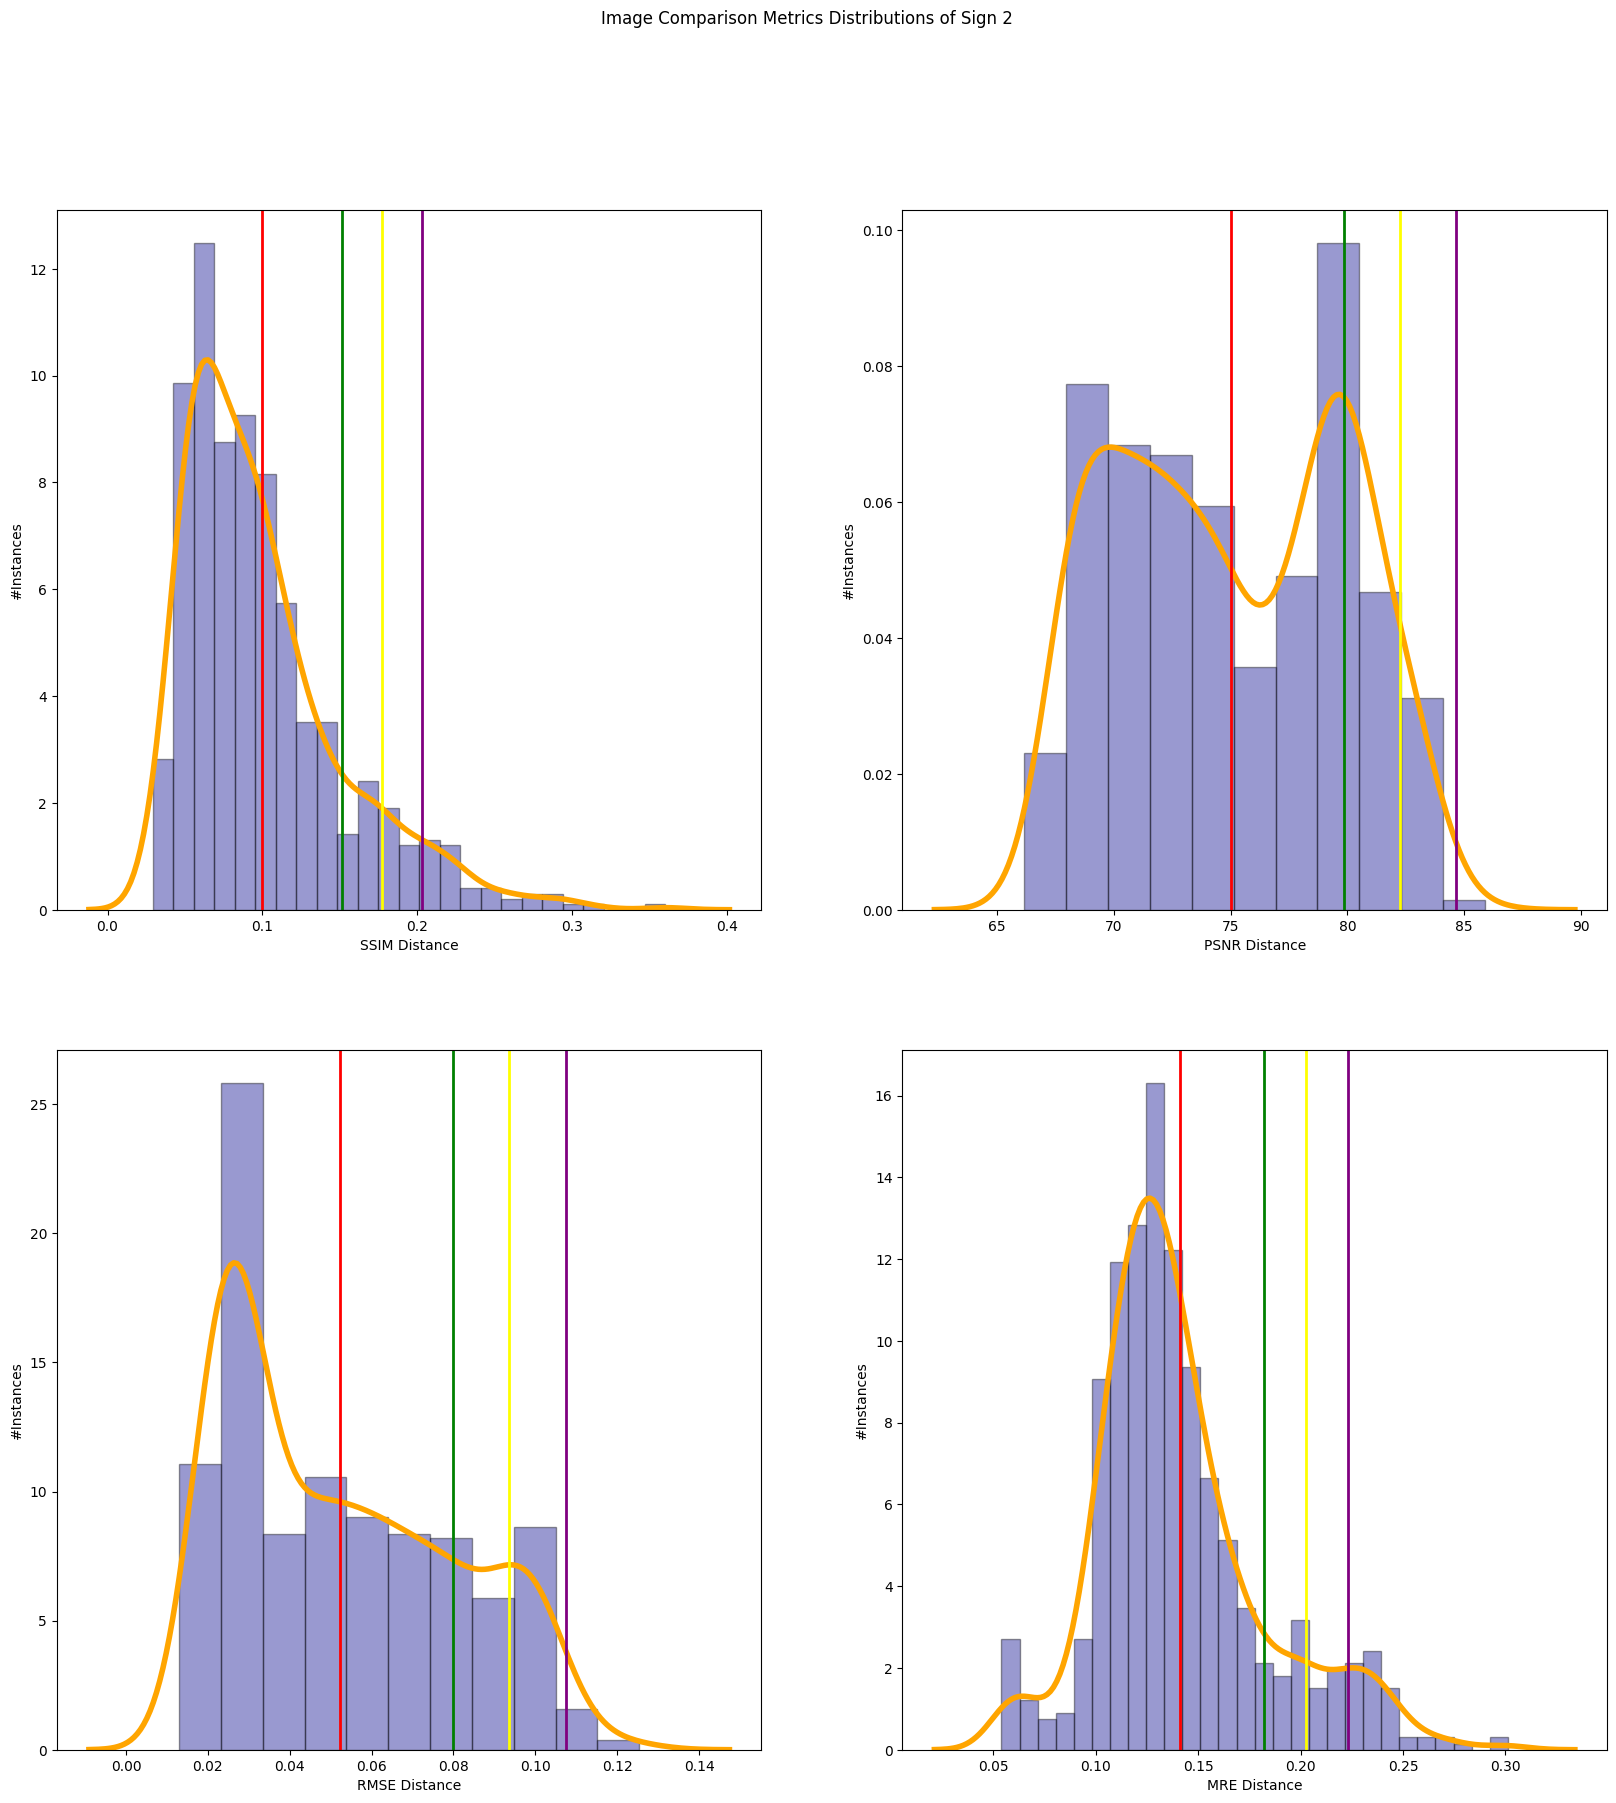

In [55]:
ssim, psnr, rmse, mre = testset(test_path2, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "2")

15/15 [==============================] - 0s 5ms/step
#Instances:  450
Destructor called, Employee deleted.
ssim mean:  0.10290014836523267  ssim σ:  0.053949498109684794  ssim μ+σ:  0.15684964647491748
ssim μ+1.5σ:  0.18382439552975988  ssim μ+2σ:  0.21079914458460225
psnr mean:  77.44856384277344  psnr σ:  4.288839125742005  psnr μ+σ:  81.73740296851544
psnr μ+1.5σ:  83.88182253138645  psnr μ+2σ:  86.02624209425744


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

rmse mean:  0.038198307  rmse σ:  0.016895086  rmse μ+σ:  0.055093393
rmse μ+1.5σ:  0.06354093551635742  rmse μ+2σ:  0.07198847830295563
mre mean:  0.13861778  mre σ:  0.050148234  mre μ+σ:  0.18876602
mre μ+1.5σ:  0.21384013444185257  mre μ+2σ:  0.23891425132751465


/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


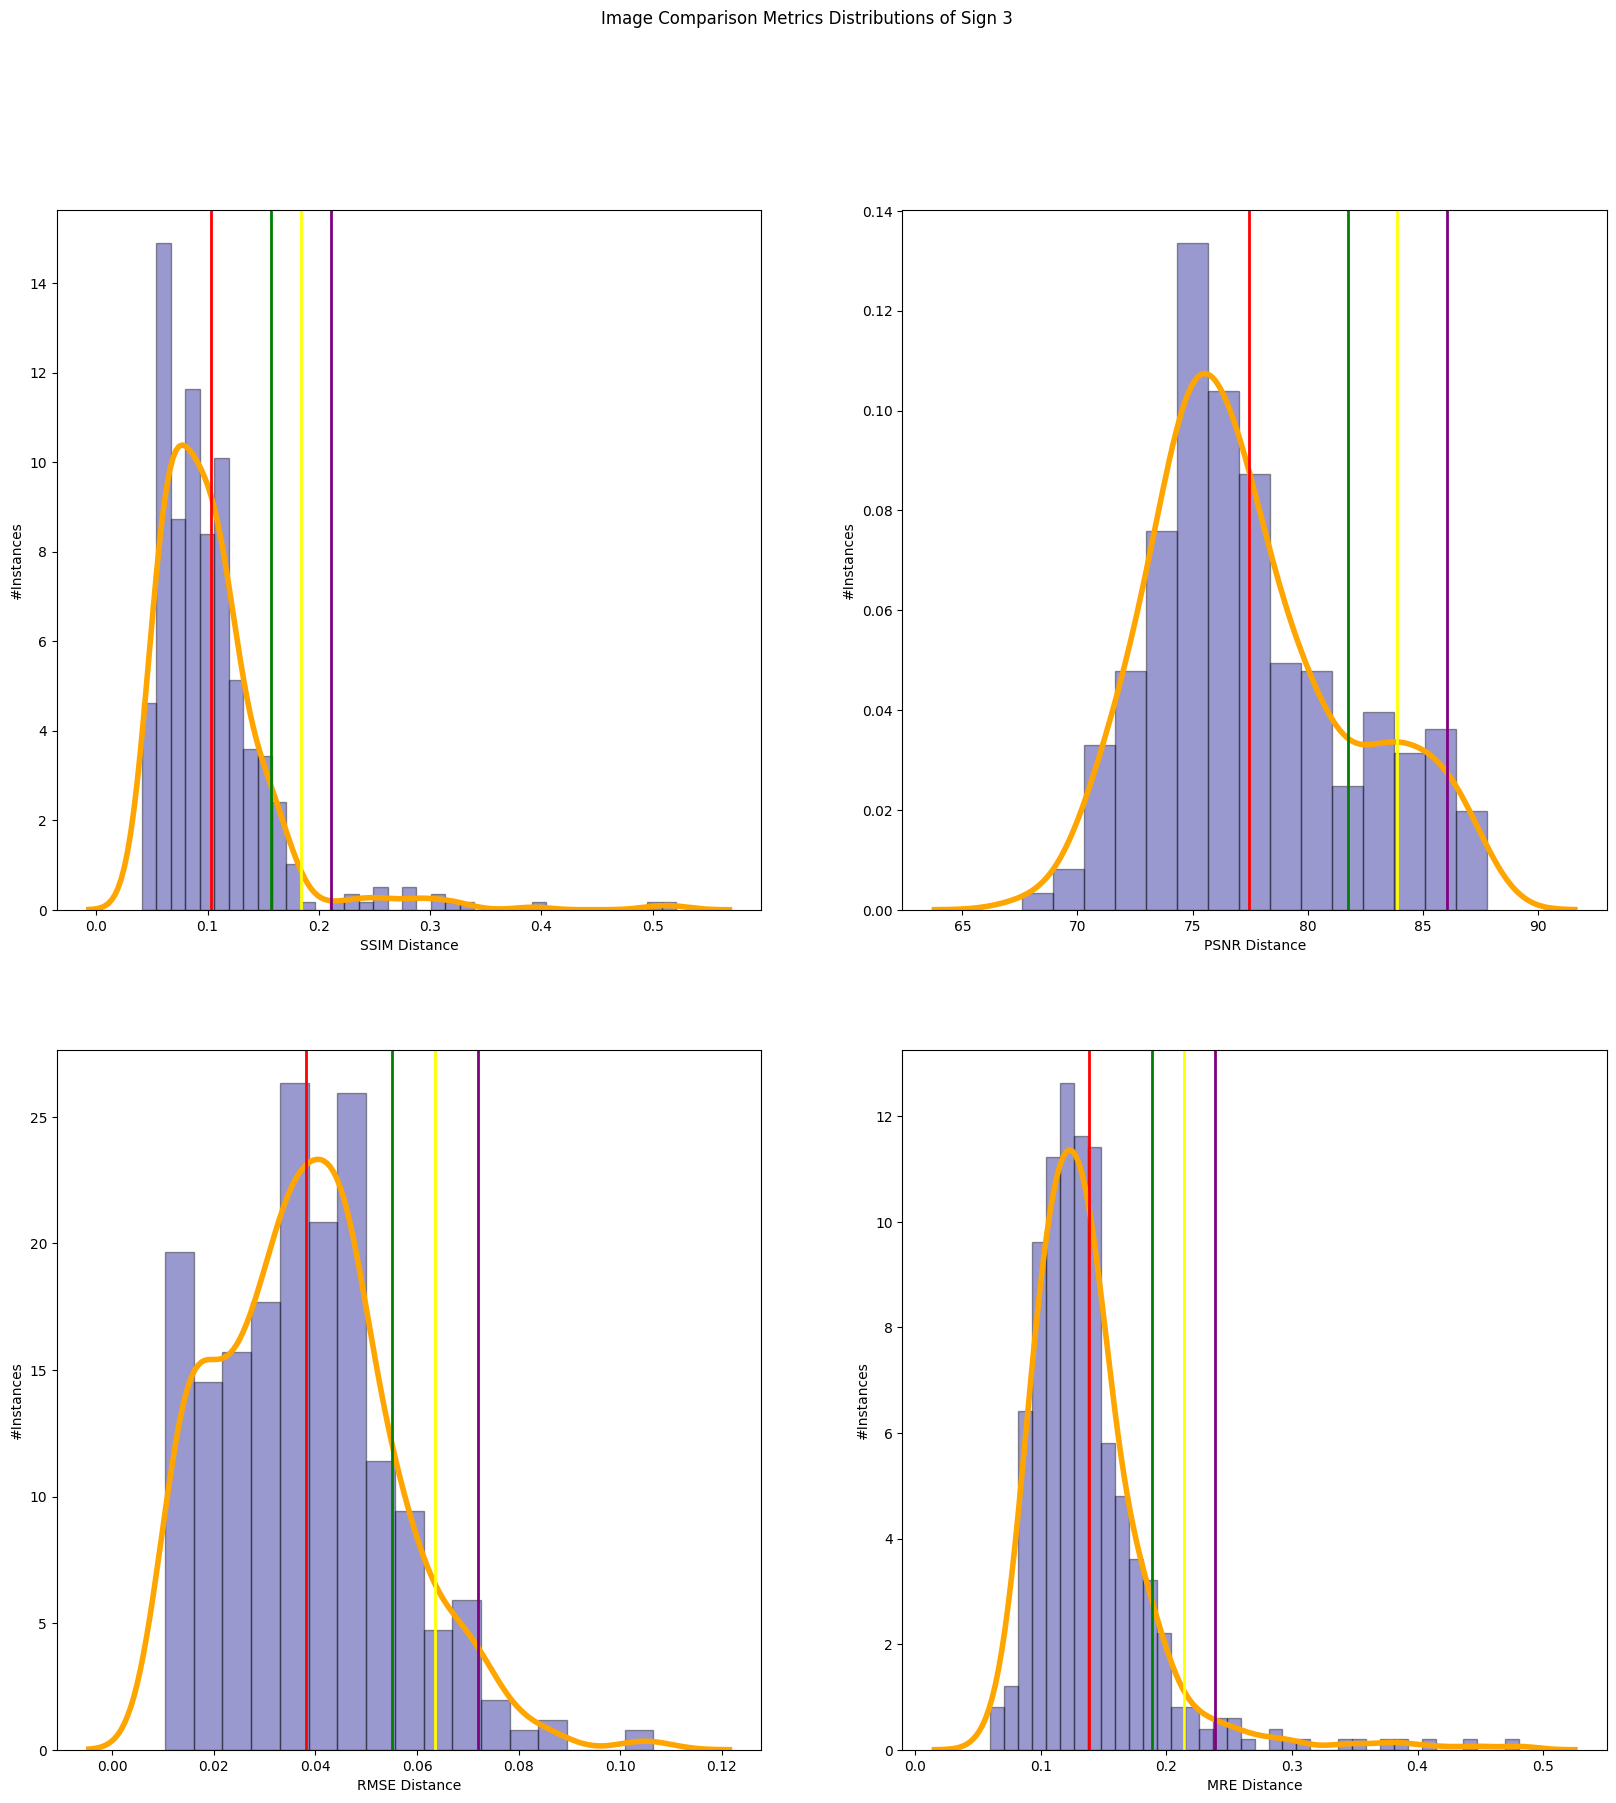

In [56]:
ssim, psnr, rmse, mre = testset(test_path3, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "3")

21/21 [==============================] - 0s 6ms/step
#Instances:  660
Destructor called, Employee deleted.
ssim mean:  0.10599192119005954  ssim σ:  0.0694469624756295  ssim μ+σ:  0.17543888366568905
ssim μ+1.5σ:  0.2101623649035038  ssim μ+2σ:  0.24488584614131853
psnr mean:  78.97353897094726  psnr σ:  6.3087033120157034  psnr μ+σ:  85.28224228296297
psnr μ+1.5σ:  88.43659393897082  psnr μ+2σ:  91.59094559497866


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

rmse mean:  0.0375099  rmse σ:  0.028649066  rmse μ+σ:  0.066158965
rmse μ+1.5σ:  0.08048349805176258  rmse μ+2σ:  0.09480803087353706
mre mean:  0.14505795  mre σ:  0.056048747  mre μ+σ:  0.2011067
mre μ+1.5σ:  0.22913106717169285  mre μ+2σ:  0.2571554407477379


/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


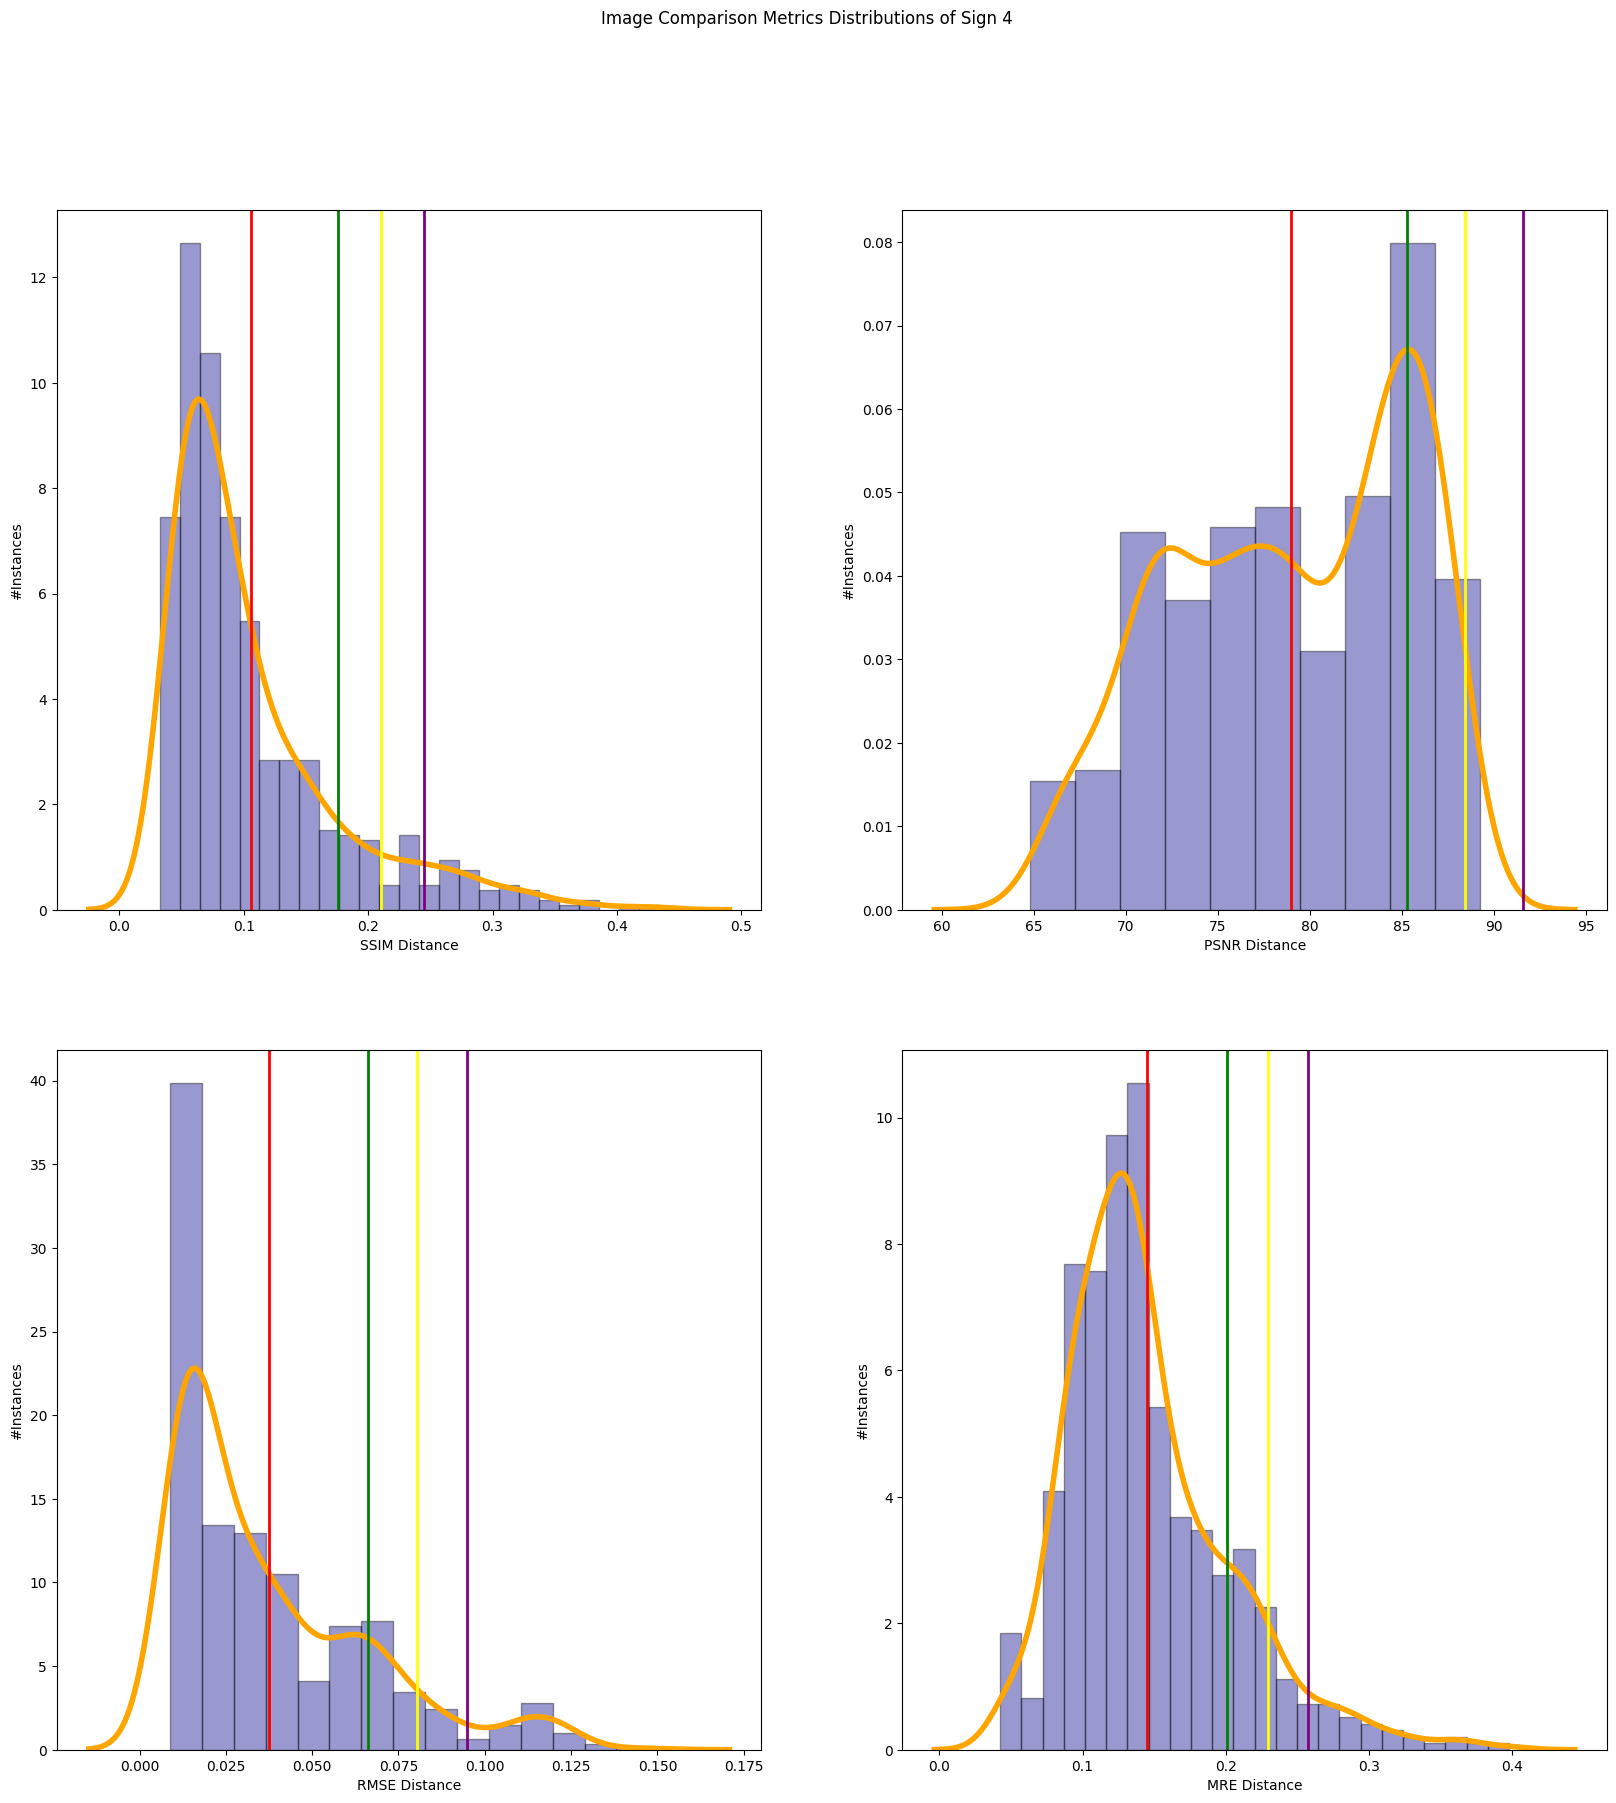

In [57]:
ssim, psnr, rmse, mre = testset(test_path4, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "4")

20/20 [==============================] - 0s 12ms/step
#Instances:  630
Destructor called, Employee deleted.
ssim mean:  0.11360356438727606  ssim σ:  0.058050281778628185  ssim μ+σ:  0.17165384616590423
ssim μ+1.5σ:  0.20067898705521833  ssim μ+2σ:  0.22970412794453243
psnr mean:  76.1302520025344  psnr σ:  4.864322847172614  psnr μ+σ:  80.99457484970702
psnr μ+1.5σ:  83.42673627329333  psnr μ+2σ:  85.85889769687964


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

rmse mean:  0.045896124  rmse σ:  0.023106  rmse μ+σ:  0.06900212
rmse μ+1.5σ:  0.08055512327700853  rmse μ+2σ:  0.09210812300443649
mre mean:  0.1538899  mre σ:  0.06406813  mre μ+σ:  0.21795803
mre μ+1.5σ:  0.24999209120869637  mre μ+2σ:  0.28202615678310394


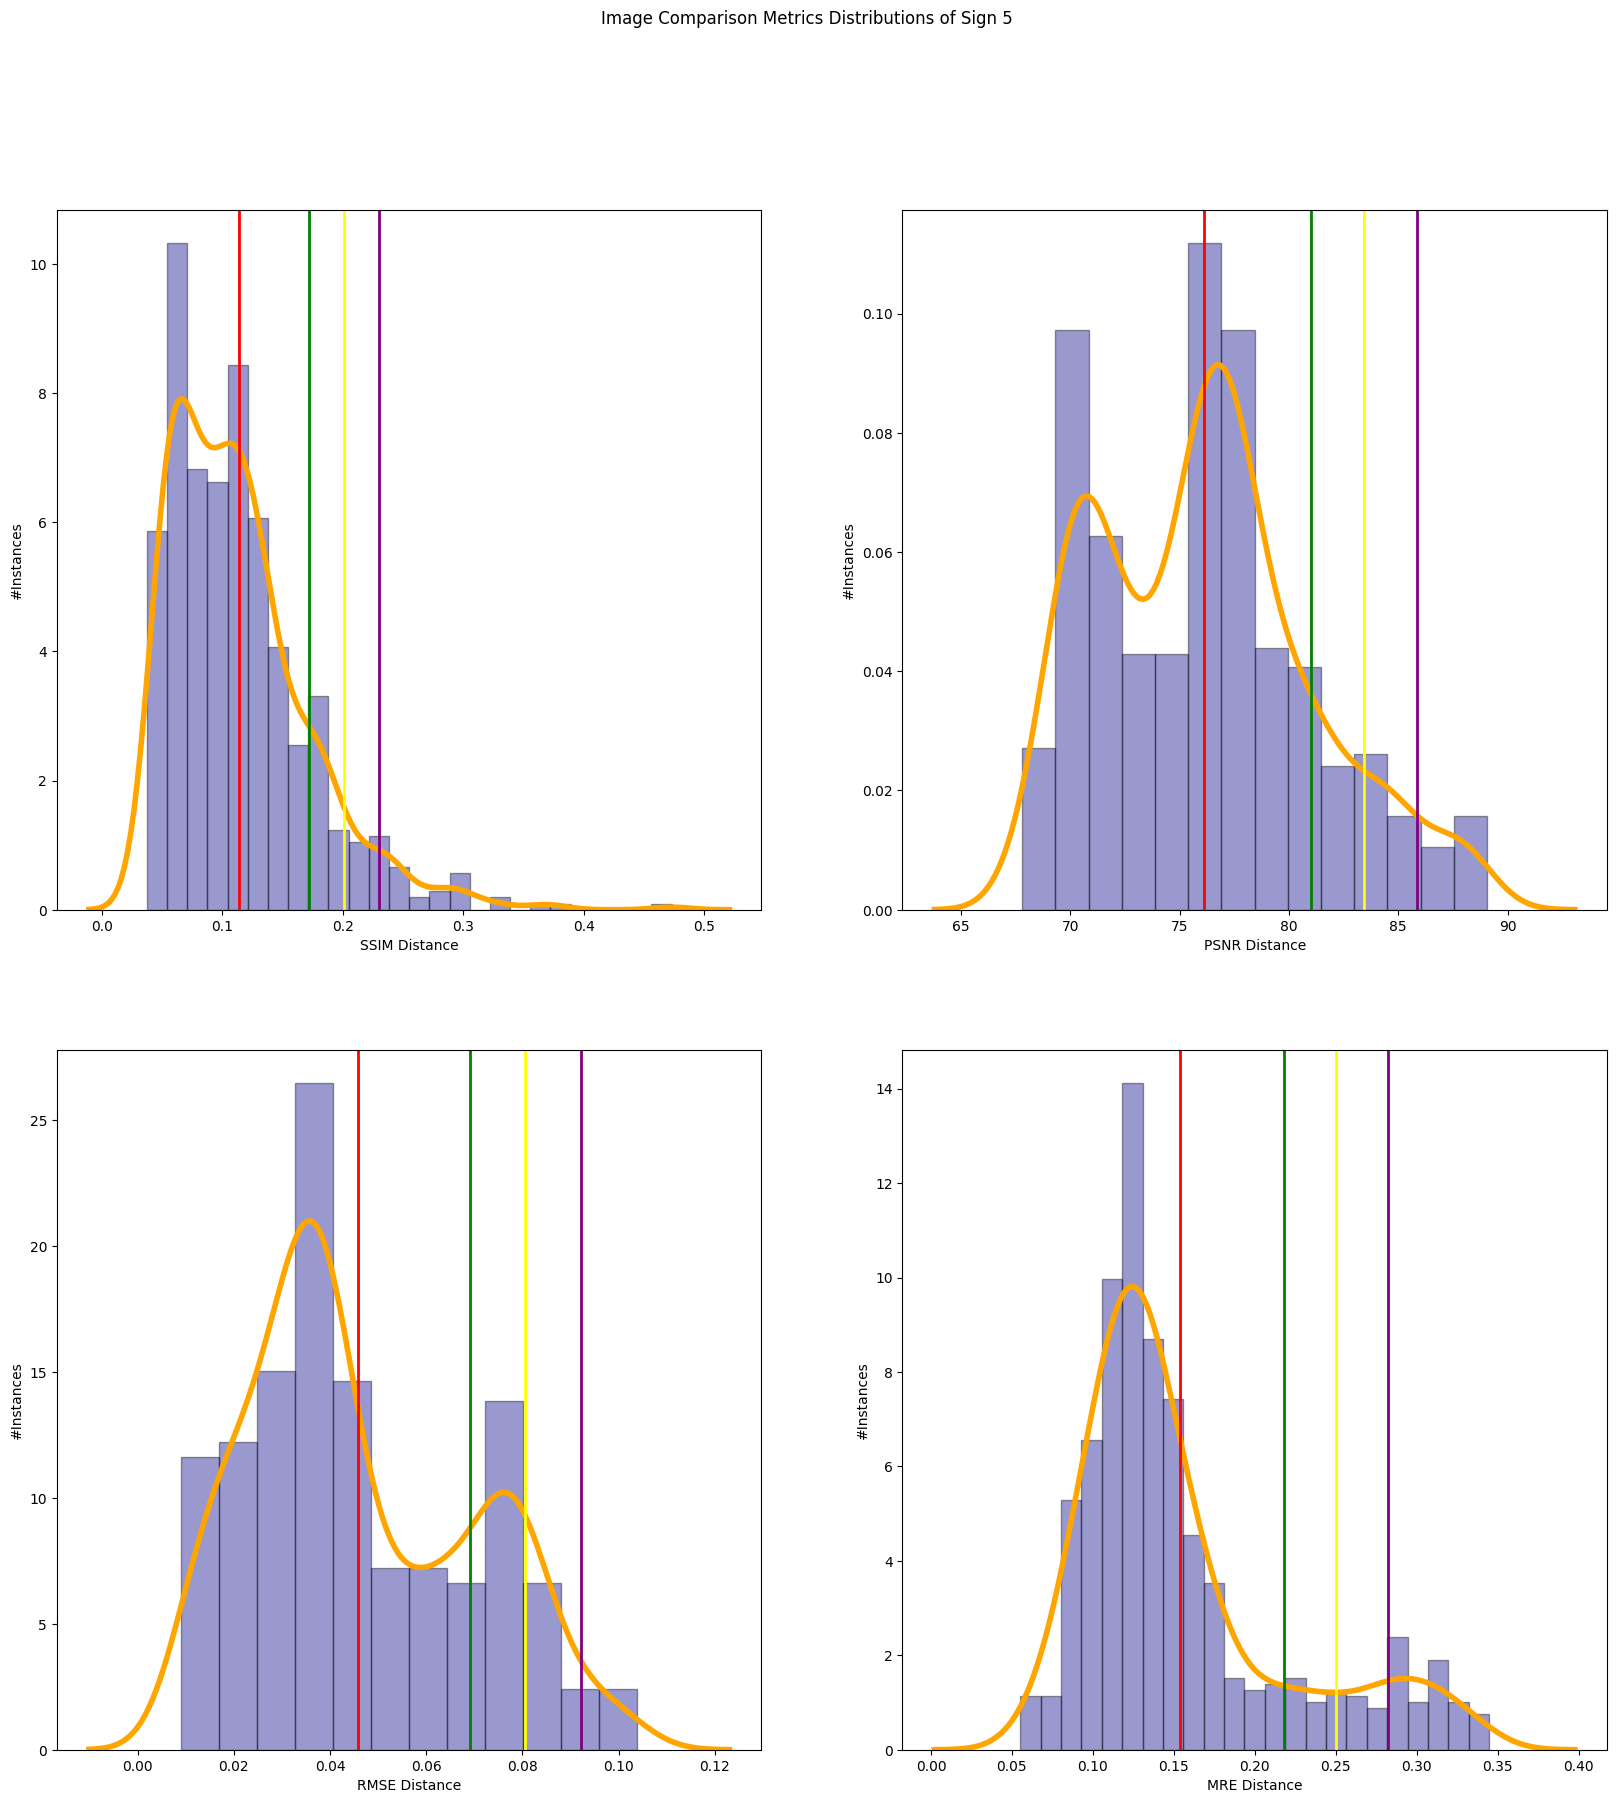

In [58]:
ssim, psnr, rmse, mre = testset(test_path5, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "5")

5/5 [==============================] - 0s 5ms/step
#Instances:  150
Destructor called, Employee deleted.
ssim mean:  0.09015025099118551  ssim σ:  0.042779537501453614  ssim μ+σ:  0.13292978849263912
ssim μ+1.5σ:  0.15431955724336593  ssim μ+2σ:  0.17570932599409272


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],


psnr mean:  81.99469141642253  psnr σ:  5.477918541834263  psnr μ+σ:  87.47260995825678
psnr μ+1.5σ:  90.21156922917392  psnr μ+2σ:  92.95052850009105
rmse mean:  0.025102828  rmse σ:  0.01774105  rmse μ+σ:  0.04284388
rmse μ+1.5σ:  0.05171440355479717  rmse μ+2σ:  0.06058492884039879
mre mean:  0.121022895  mre σ:  0.022800447  mre μ+σ:  0.14382334
mre μ+1.5σ:  0.15522356610745192  mre μ+2σ:  0.1666237898170948


/tmp/ipykernel_122393/2660218213.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


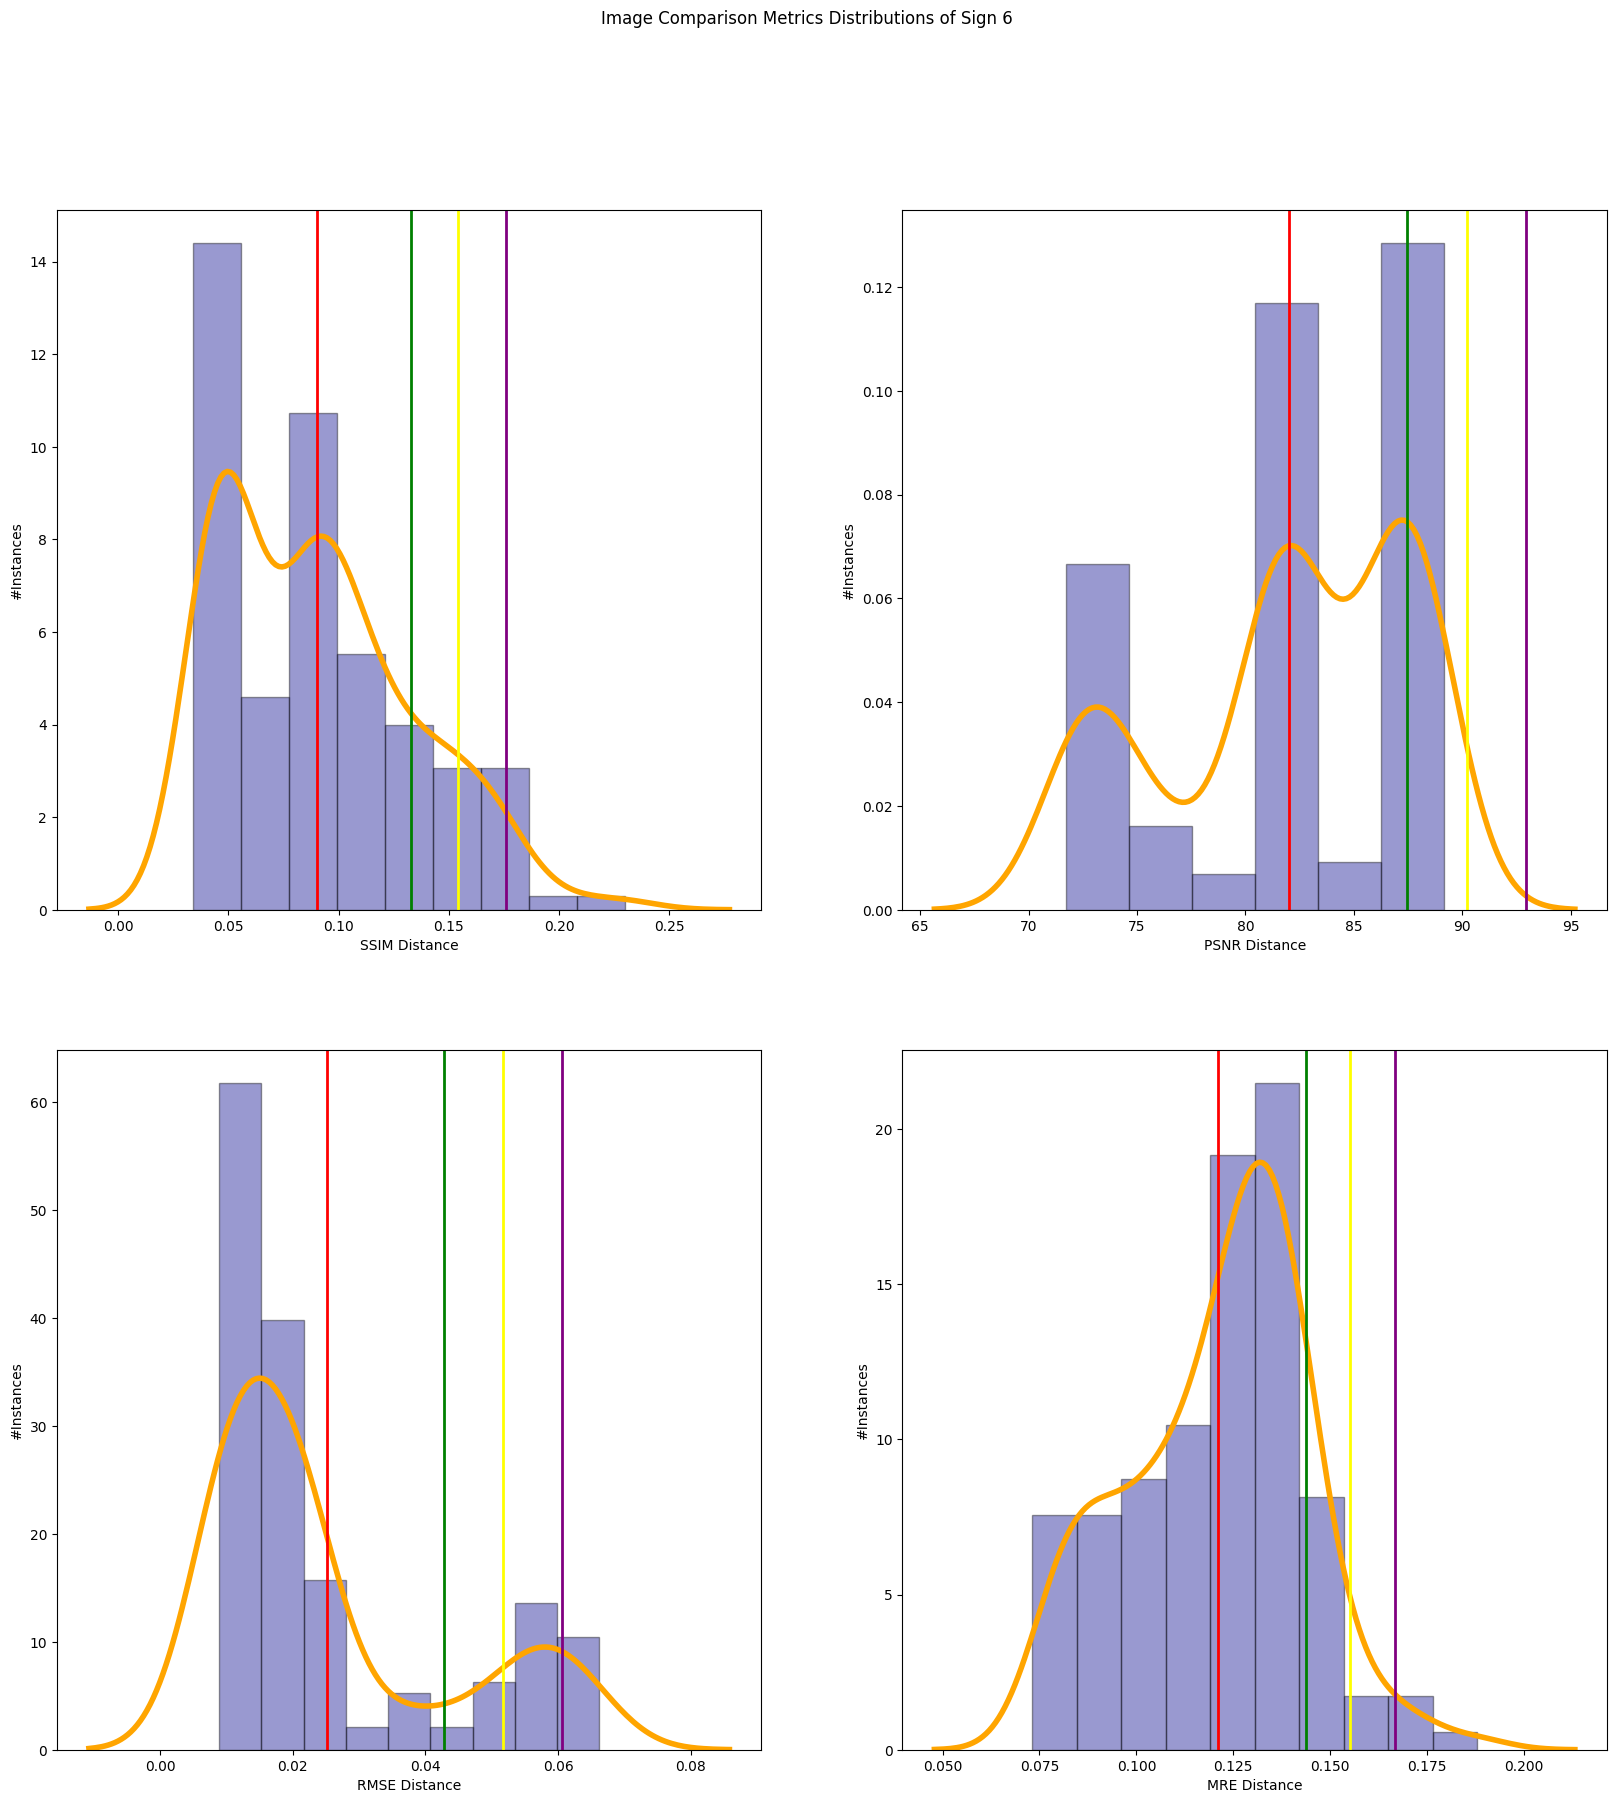

In [59]:
ssim, psnr, rmse, mre = testset(test_path6, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "6")

15/15 [==============================] - 0s 6ms/step
#Instances:  450
Destructor called, Employee deleted.
ssim mean:  0.12989688873291017  ssim σ:  0.05282276062008114  ssim μ+σ:  0.18271964935299131
ssim μ+1.5σ:  0.20913102966303188  ssim μ+2σ:  0.23554240997307246
psnr mean:  76.79478841145833  psnr σ:  3.632208341926782  psnr μ+σ:  80.42699675338511
psnr μ+1.5σ:  82.2431009243485  psnr μ+2σ:  84.0592050953119
rmse mean:  0.040163863  rmse σ:  0.016678216  rmse μ+σ:  0.05684208
rmse μ+1.5σ:  0.06518118735402822  rmse μ+2σ:  0.07352029532194138


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.16728933  mre σ:  0.037588026  mre μ+σ:  0.20487736
mre μ+1.5σ:  0.22367137111723423  mre μ+2σ:  0.24246538430452347


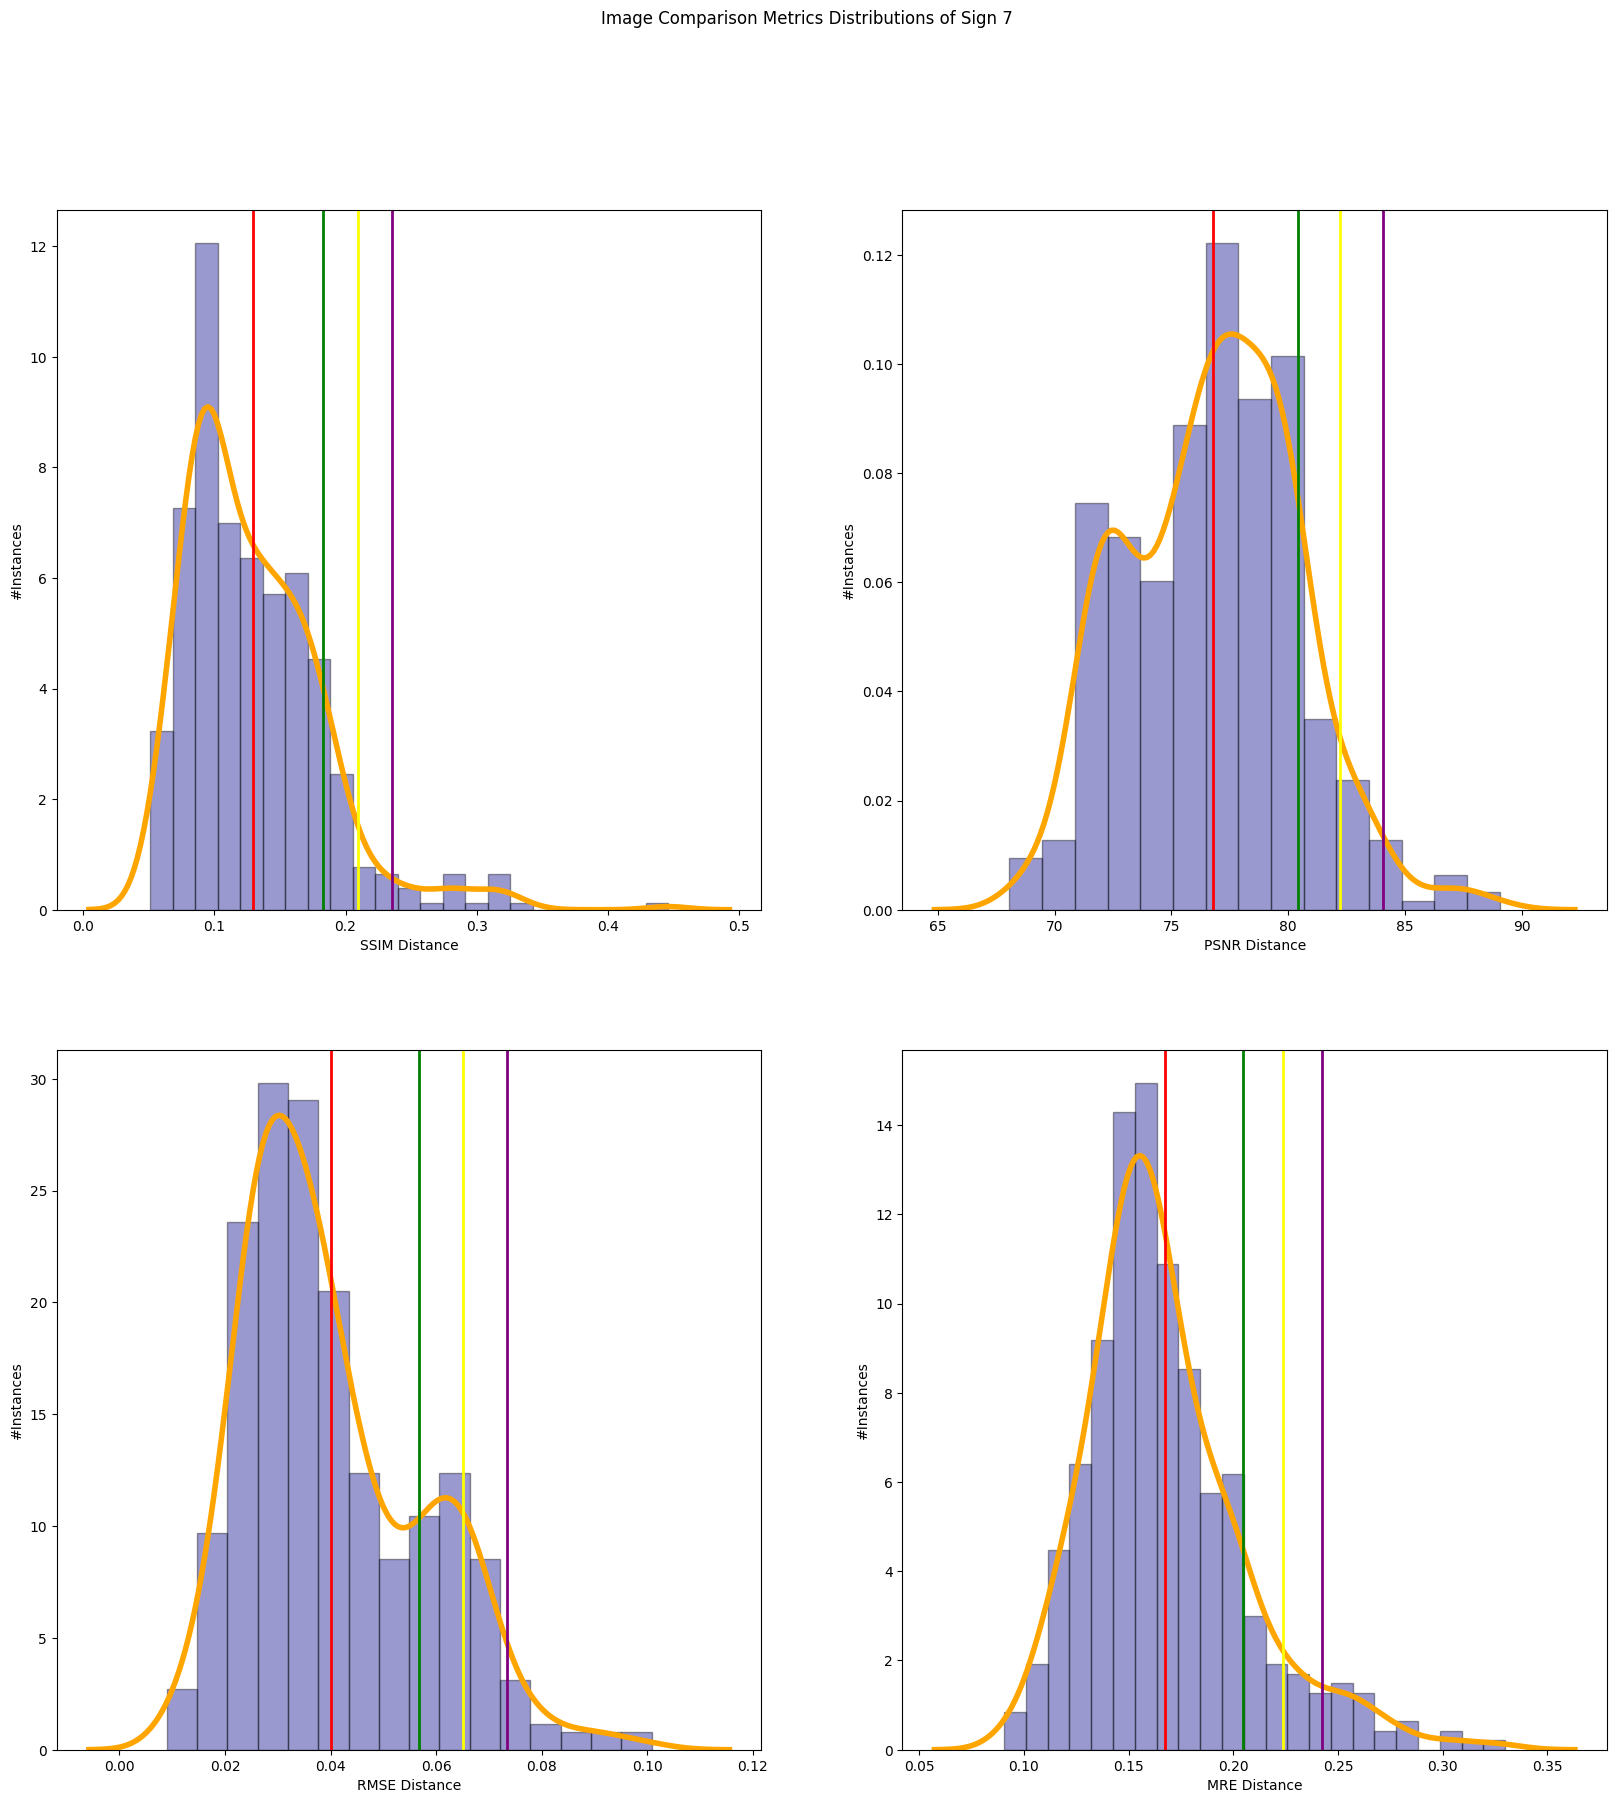

In [60]:
ssim, psnr, rmse, mre = testset(test_path7, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "7")

15/15 [==============================] - 0s 6ms/step
#Instances:  450
Destructor called, Employee deleted.
ssim mean:  0.11515650444560581  ssim σ:  0.04759994243871807  ssim μ+σ:  0.1627564468843239
ssim μ+1.5σ:  0.1865564181036829  ssim μ+2σ:  0.21035638932304196
psnr mean:  79.1067160373264  psnr σ:  3.8444829254786437  psnr μ+σ:  82.95119896280504
psnr μ+1.5σ:  84.87344042554436  psnr μ+2σ:  86.79568188828368
rmse mean:  0.030888382  rmse σ:  0.012207016  rmse μ+σ:  0.0430954
rmse μ+1.5σ:  0.04919890686869621  rmse μ+2σ:  0.055302415043115616


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.13464145  mre σ:  0.035242997  mre μ+σ:  0.16988444
mre μ+1.5σ:  0.18750594928860664  mre μ+2σ:  0.20512744784355164


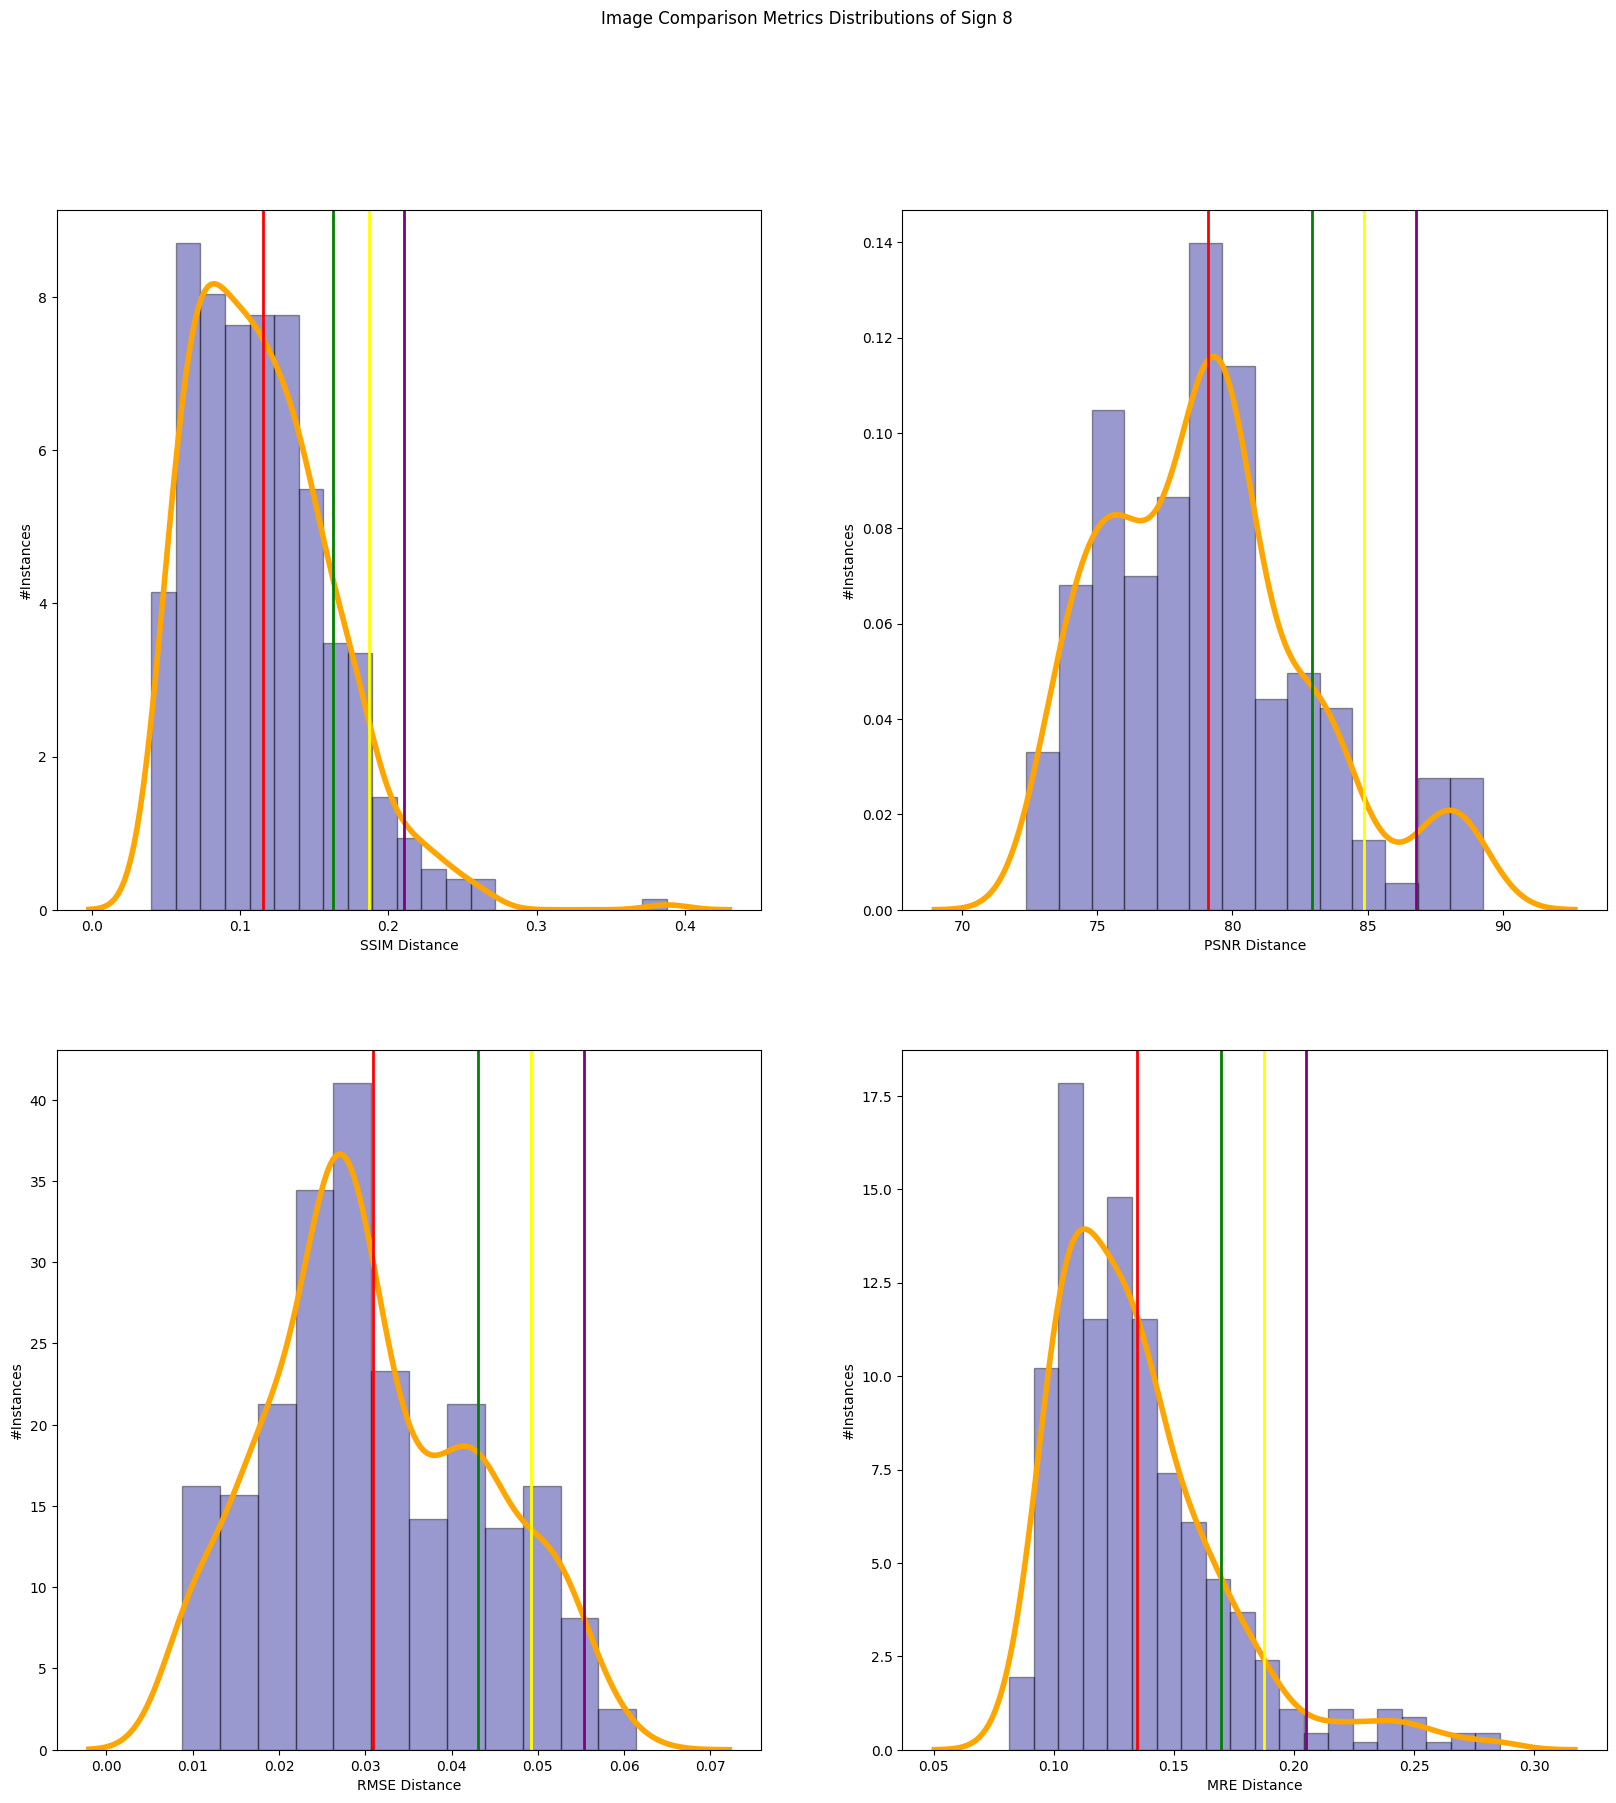

In [61]:
ssim, psnr, rmse, mre = testset(test_path8, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "8")

15/15 [==============================] - 0s 6ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.1290170104553302  ssim σ:  0.08415544618053844  ssim μ+σ:  0.21317245663586865
ssim μ+1.5σ:  0.25525017972613784  ssim μ+2σ:  0.2973279028164071
psnr mean:  75.71309690475464  psnr σ:  5.209892546856709  psnr μ+σ:  80.92298945161134
psnr μ+1.5σ:  83.5279357250397  psnr μ+2σ:  86.13288199846805
rmse mean:  0.048982635  rmse σ:  0.026443068  rmse μ+σ:  0.0754257
rmse μ+1.5σ:  0.08864723704755306  rmse μ+2σ:  0.10186877101659775


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.17380266  mre σ:  0.110433474  mre μ+σ:  0.28423613
mre μ+1.5σ:  0.3394528701901436  mre μ+2σ:  0.3946696072816849


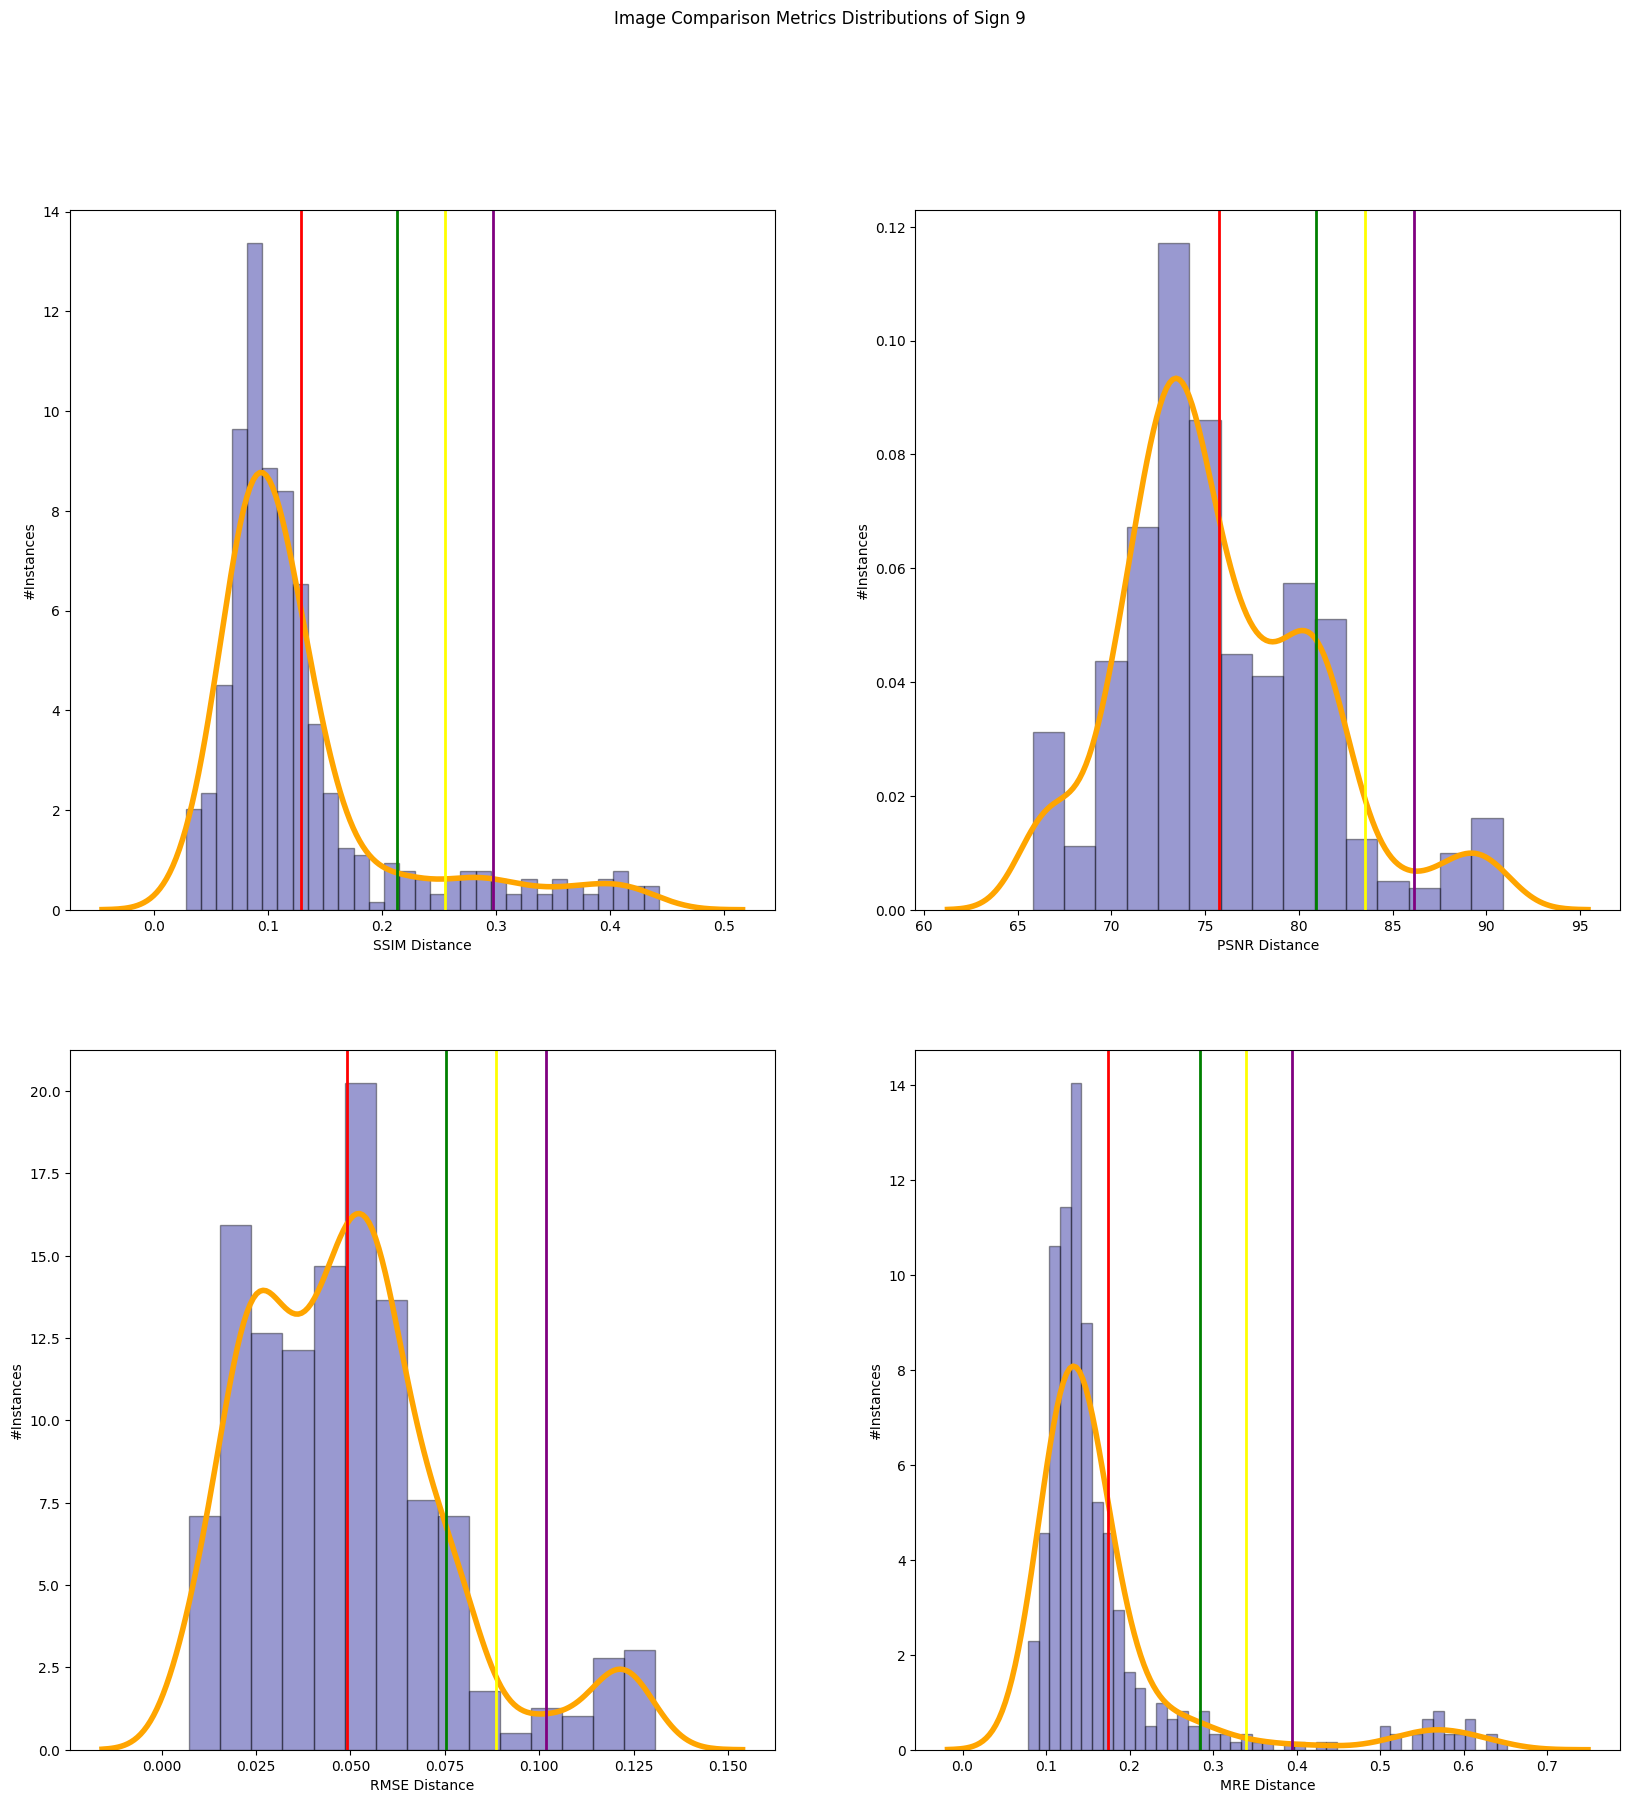

In [62]:
ssim, psnr, rmse, mre = testset(test_path9, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "9")

21/21 [==============================] - 0s 6ms/step
#Instances:  660
Destructor called, Employee deleted.
ssim mean:  0.08424105102365667  ssim σ:  0.03599175186059388  ssim μ+σ:  0.12023280288425056
ssim μ+1.5σ:  0.13822867881454748  ssim μ+2σ:  0.15622455474484442
psnr mean:  80.92875366210937  psnr σ:  4.218181308287288  psnr μ+σ:  85.14693497039666
psnr μ+1.5σ:  87.2560256245403  psnr μ+2σ:  89.36511627868394
rmse mean:  0.025855541  rmse σ:  0.013572446  rmse μ+σ:  0.03942799
rmse μ+1.5σ:  0.04621421033516526  rmse μ+2σ:  0.053000433370471


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.12178161  mre σ:  0.027375385  mre μ+σ:  0.14915699
mre μ+1.5σ:  0.1628446877002716  mre μ+2σ:  0.17653238028287888


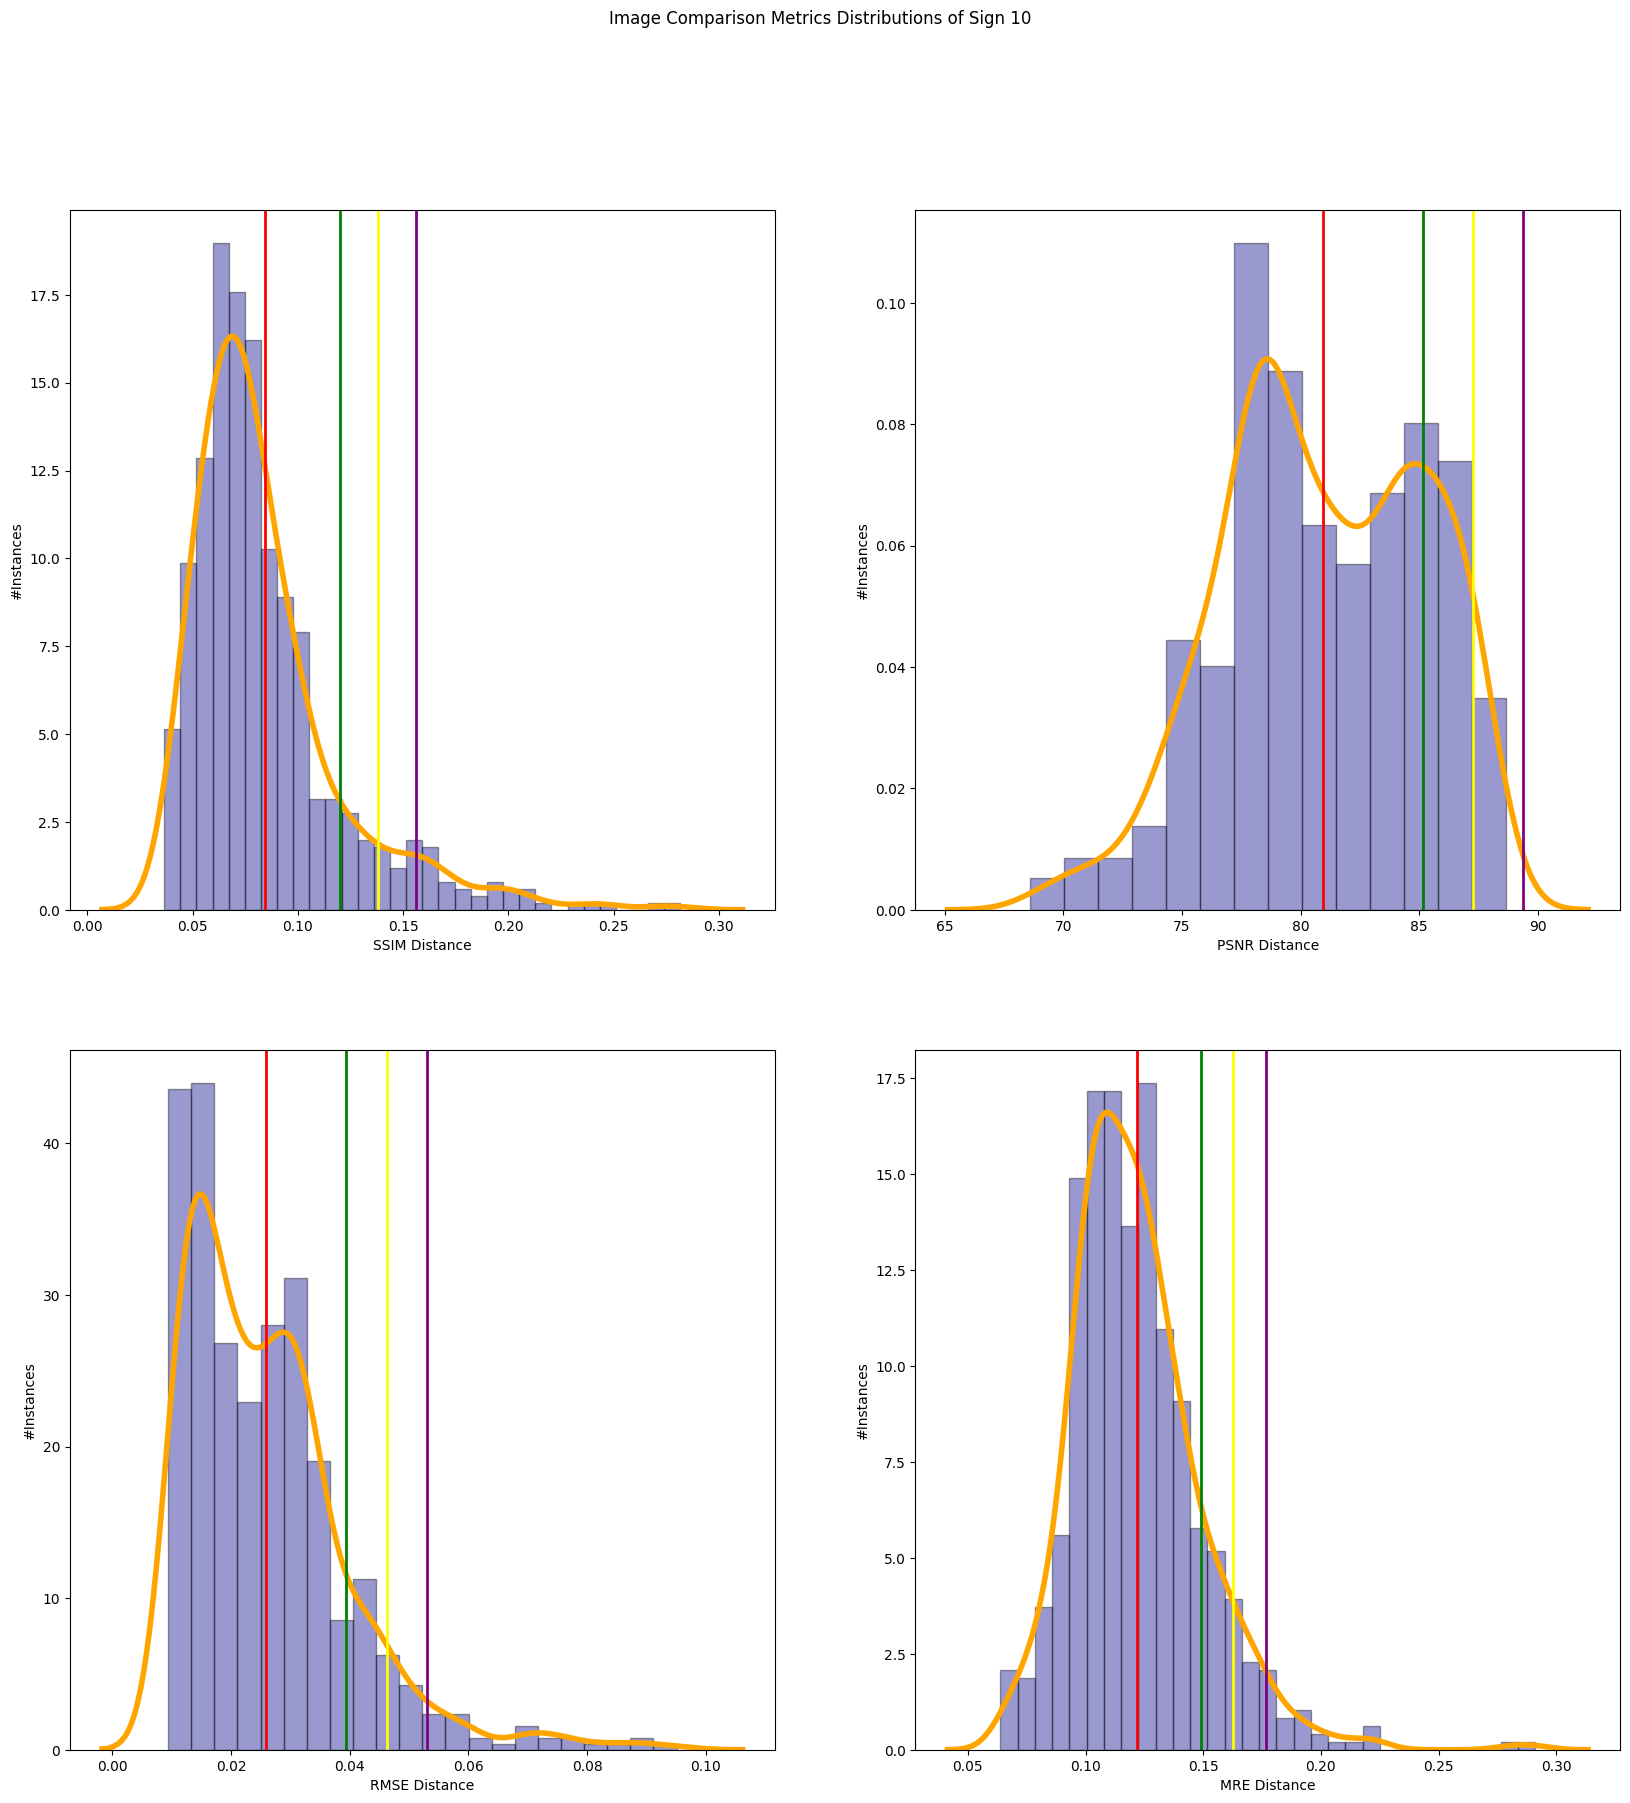

In [63]:
ssim, psnr, rmse, mre = testset(test_path10, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "10")

14/14 [==============================] - 0s 6ms/step
#Instances:  420
Destructor called, Employee deleted.


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],


ssim mean:  0.20080102135737737  ssim σ:  0.07203331861404522  ssim μ+σ:  0.2728343399714226
ssim μ+1.5σ:  0.30885099927844517  ssim μ+2σ:  0.3448676585854678
psnr mean:  70.18335227058047  psnr σ:  3.416721111807827  psnr μ+σ:  73.6000733823883
psnr μ+1.5σ:  75.30843393829221  psnr μ+2σ:  77.01679449419612
rmse mean:  0.084666304  rmse σ:  0.02939606  rmse μ+σ:  0.11406237
rmse μ+1.5σ:  0.12876039557158947  rmse μ+2σ:  0.14345842599868774
mre mean:  0.21819974  mre σ:  0.08010417  mre μ+σ:  0.2983039
mre μ+1.5σ:  0.33835600316524506  mre μ+2σ:  0.3784080892801285


/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/2660218213.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
/tmp/ipykernel_122393/

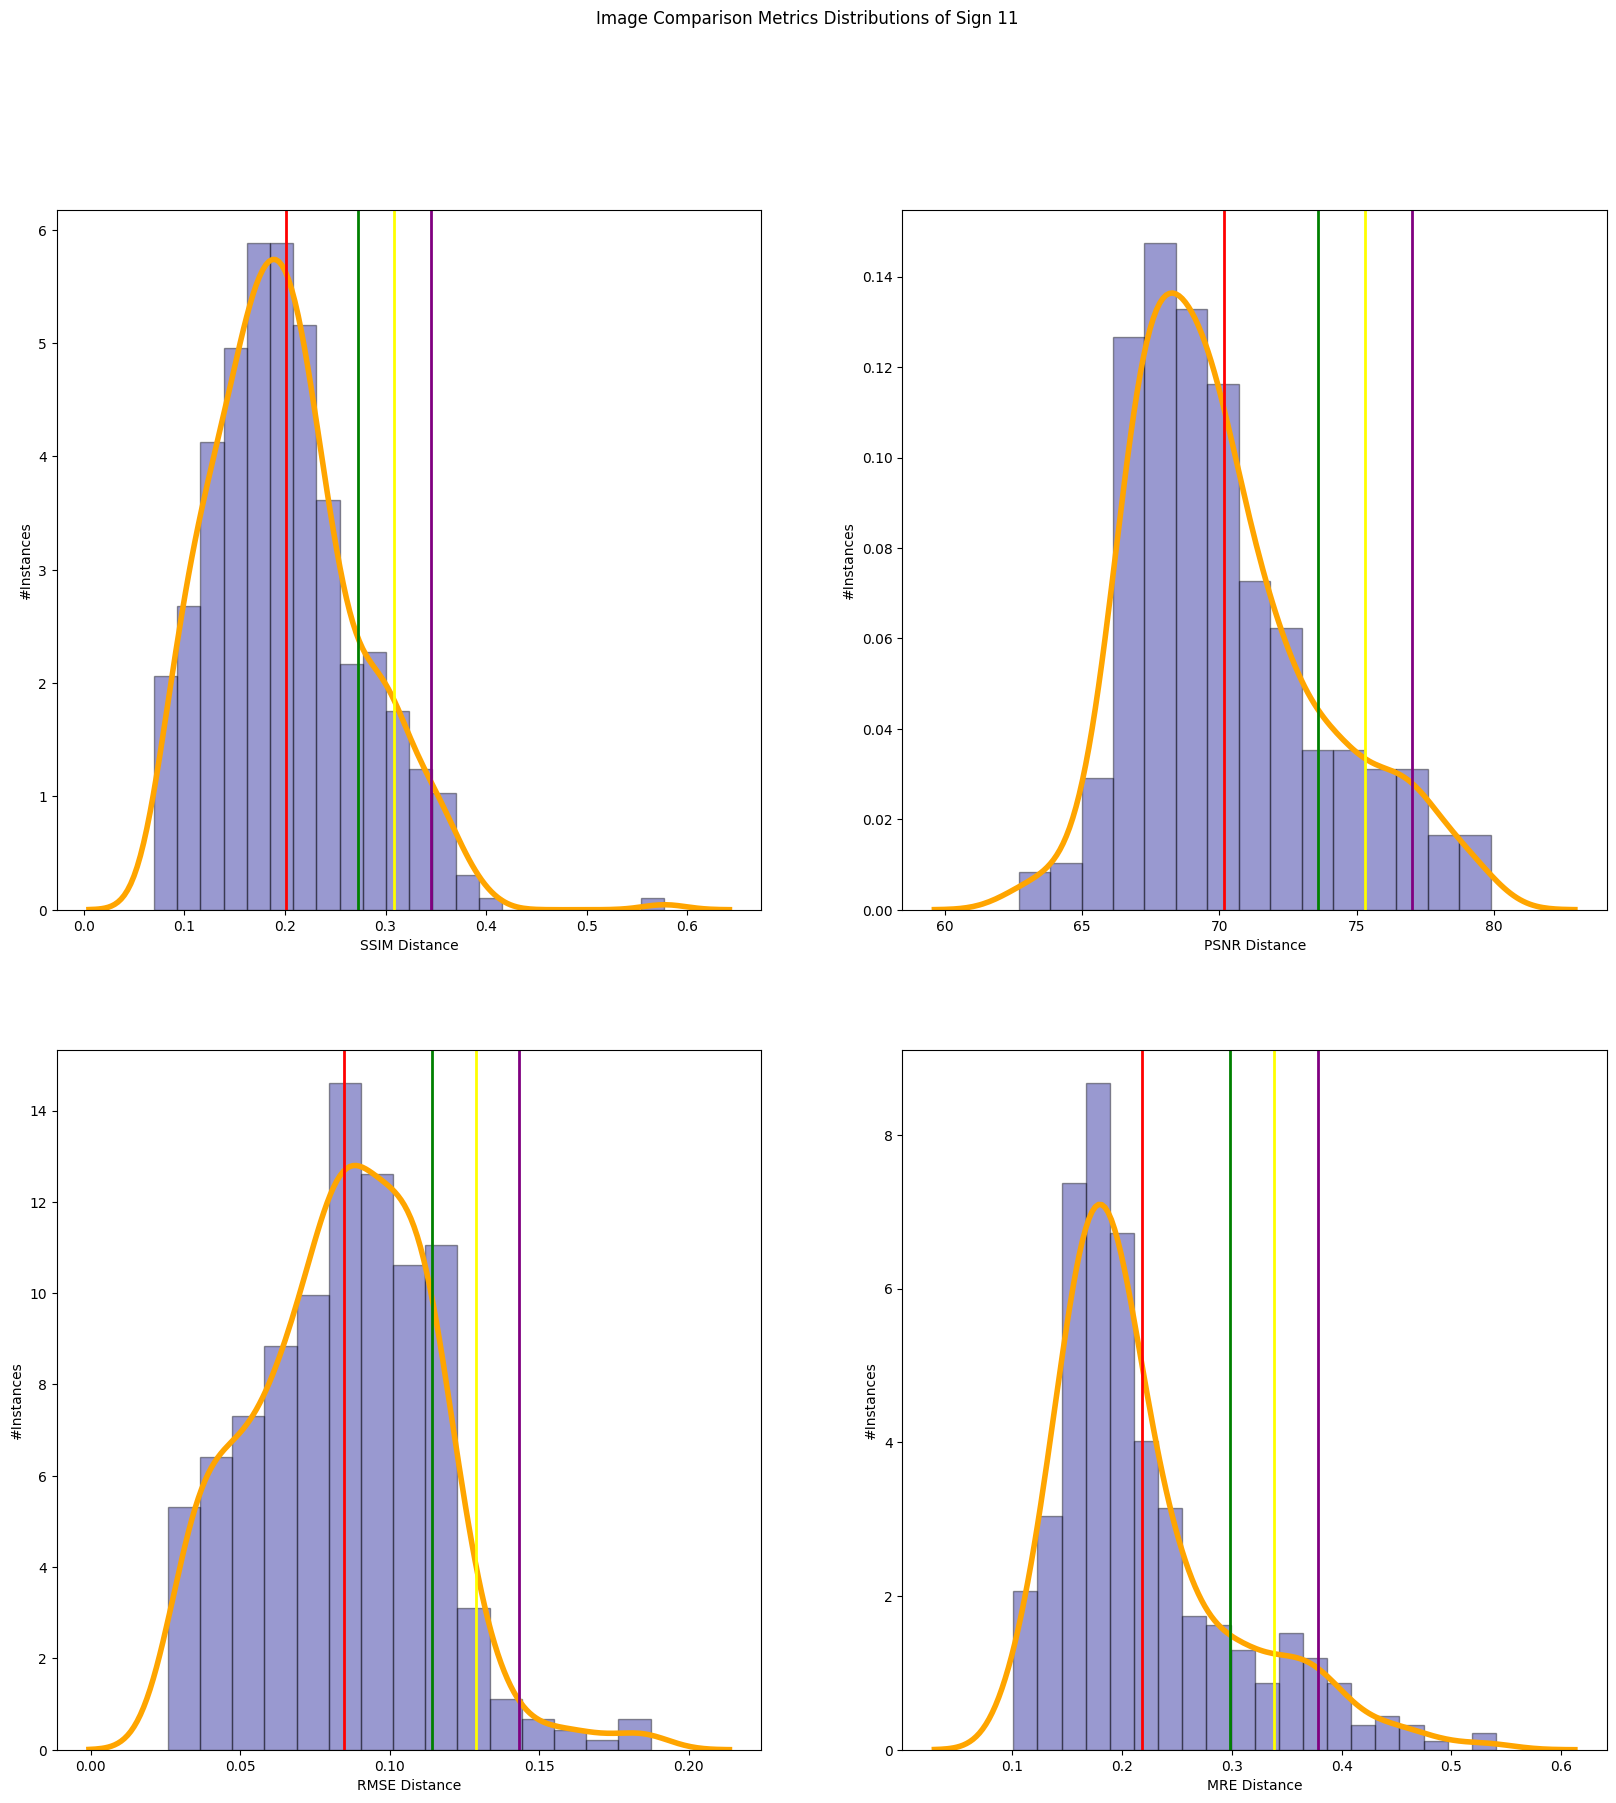

In [64]:
ssim, psnr, rmse, mre = testset(test_path11, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "11")

22/22 [==============================] - 0s 7ms/step
#Instances:  690
Destructor called, Employee deleted.
ssim mean:  0.2307143118934355  ssim σ:  0.1252137968715744  ssim μ+σ:  0.3559281087650099
ssim μ+1.5σ:  0.4185350072007971  ssim μ+2σ:  0.4811419056365843
psnr mean:  72.24975494716479  psnr σ:  6.082253165575111  psnr μ+σ:  78.3320081127399
psnr μ+1.5σ:  81.37313469552745  psnr μ+2σ:  84.41426127831501
rmse mean:  0.07651947  rmse σ:  0.044146206  rmse μ+σ:  0.12066567
rmse μ+1.5σ:  0.14273877628147602  rmse μ+2σ:  0.1648118793964386


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.19410852  mre σ:  0.09837299  mre μ+σ:  0.2924815
mre μ+1.5σ:  0.3416679985821247  mre μ+2σ:  0.39085449278354645


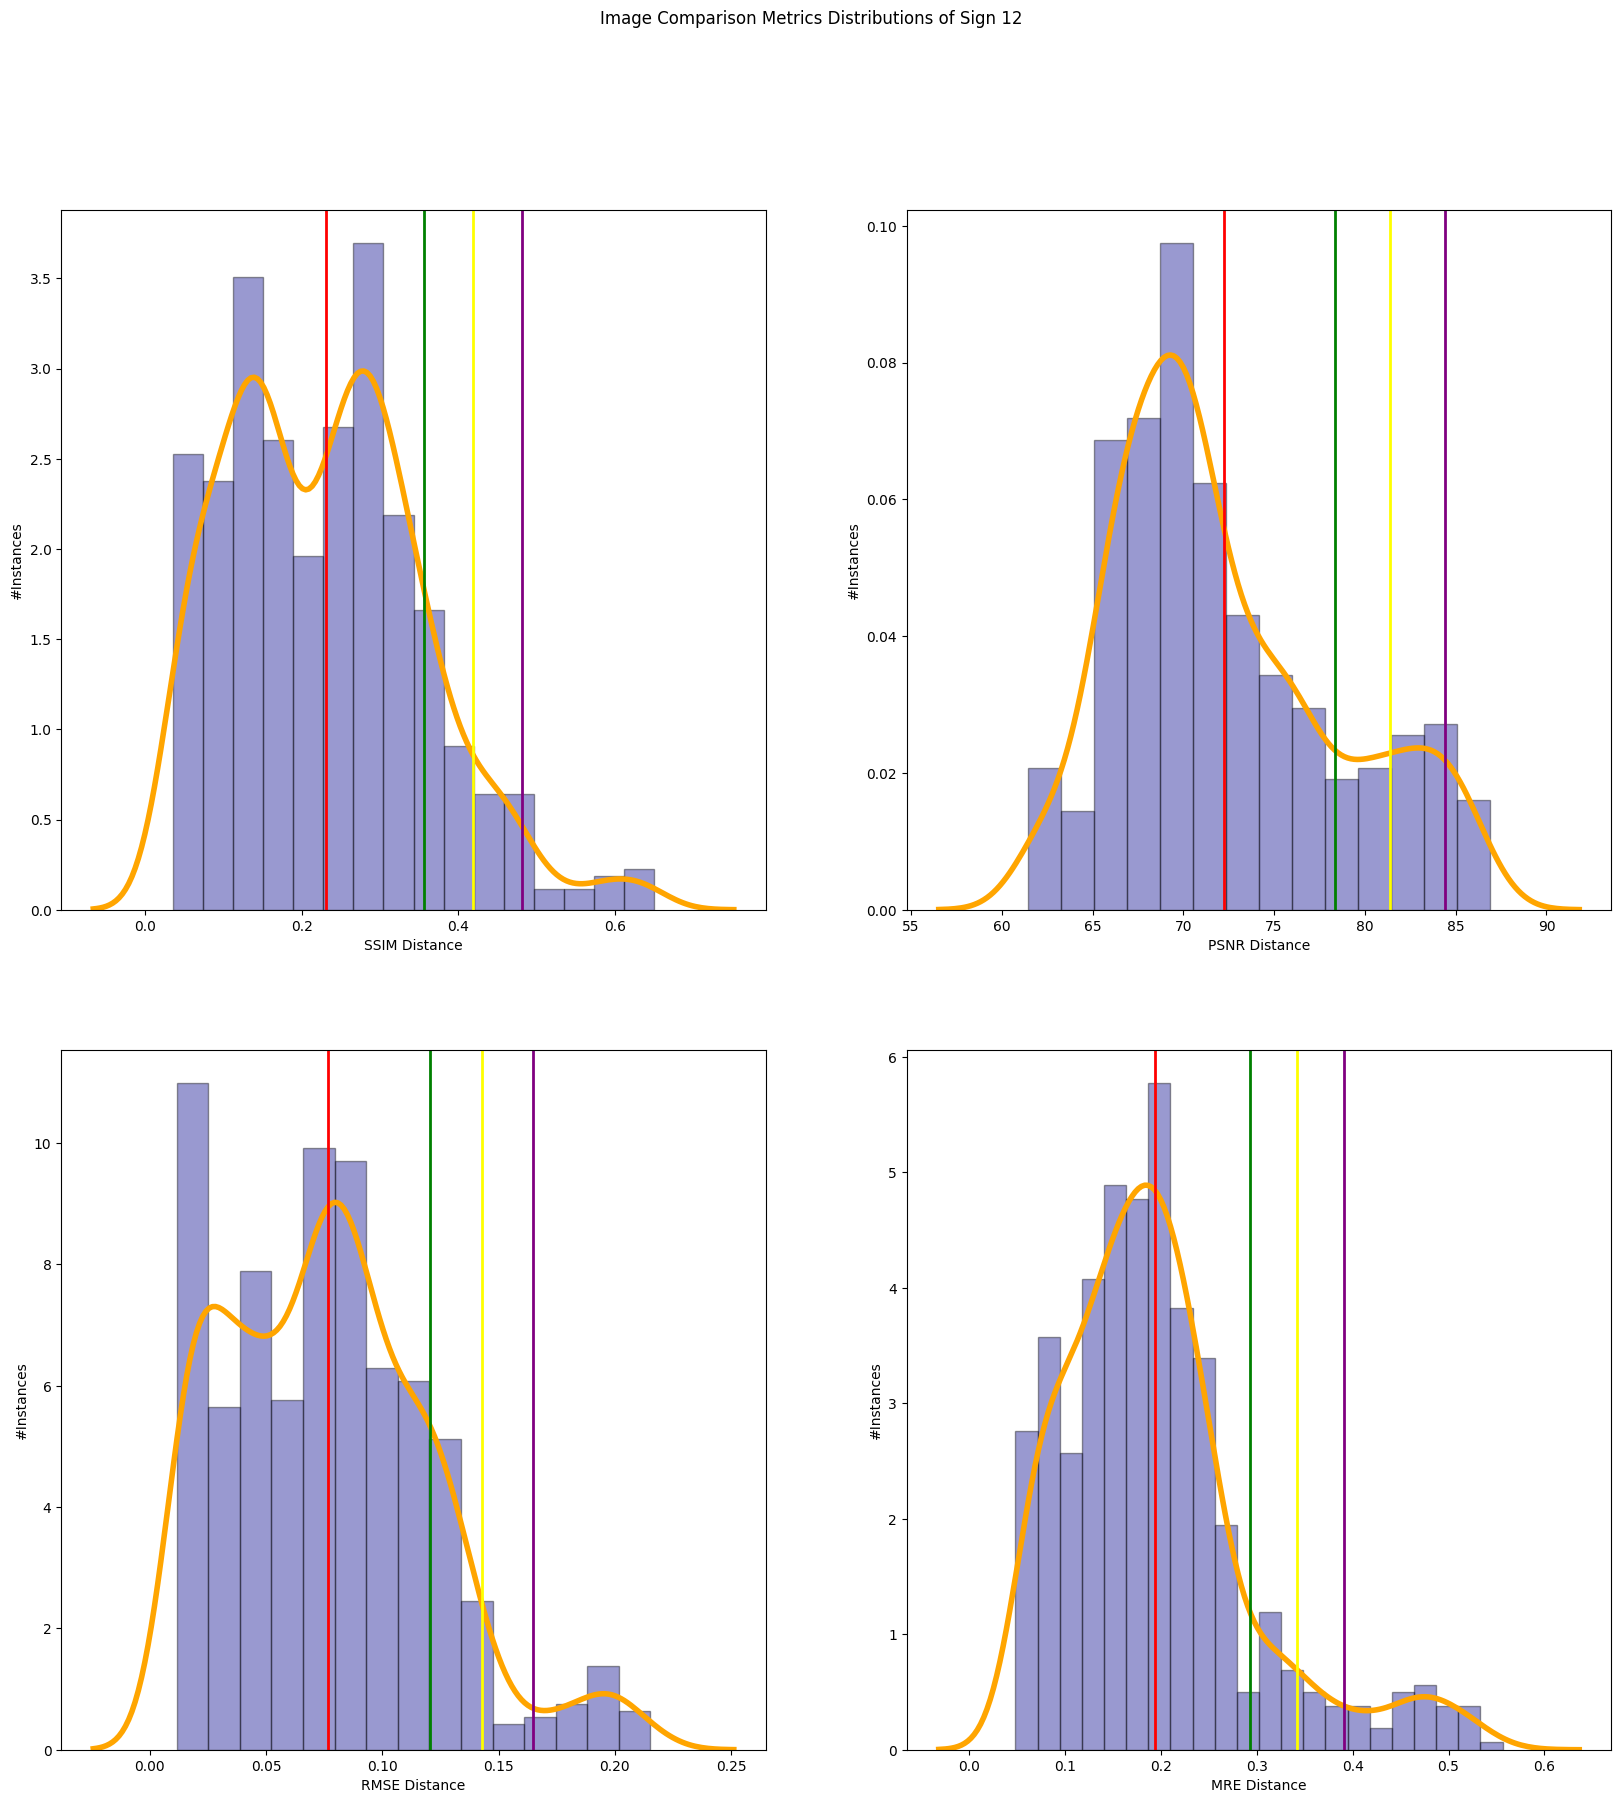

In [65]:
ssim, psnr, rmse, mre = testset(test_path12, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "12")

23/23 [==============================] - 0s 6ms/step
#Instances:  720
Destructor called, Employee deleted.
ssim mean:  0.19637529883119795  ssim σ:  0.07930121682641951  ssim μ+σ:  0.27567651565761747
ssim μ+1.5σ:  0.3153271240708272  ssim μ+2σ:  0.35497773248403697
psnr mean:  71.8205523384942  psnr σ:  5.249495226595763  psnr μ+σ:  77.07004756508996
psnr μ+1.5σ:  79.69479517838784  psnr μ+2σ:  82.31954279168572
rmse mean:  0.07579783  rmse σ:  0.03502187  rmse μ+σ:  0.110819705
rmse μ+1.5σ:  0.12833064049482346  rmse μ+2σ:  0.1458415761590004


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.20055576  mre σ:  0.085807085  mre μ+σ:  0.28636283
mre μ+1.5σ:  0.32926638424396515  mre μ+2σ:  0.37216992676258087


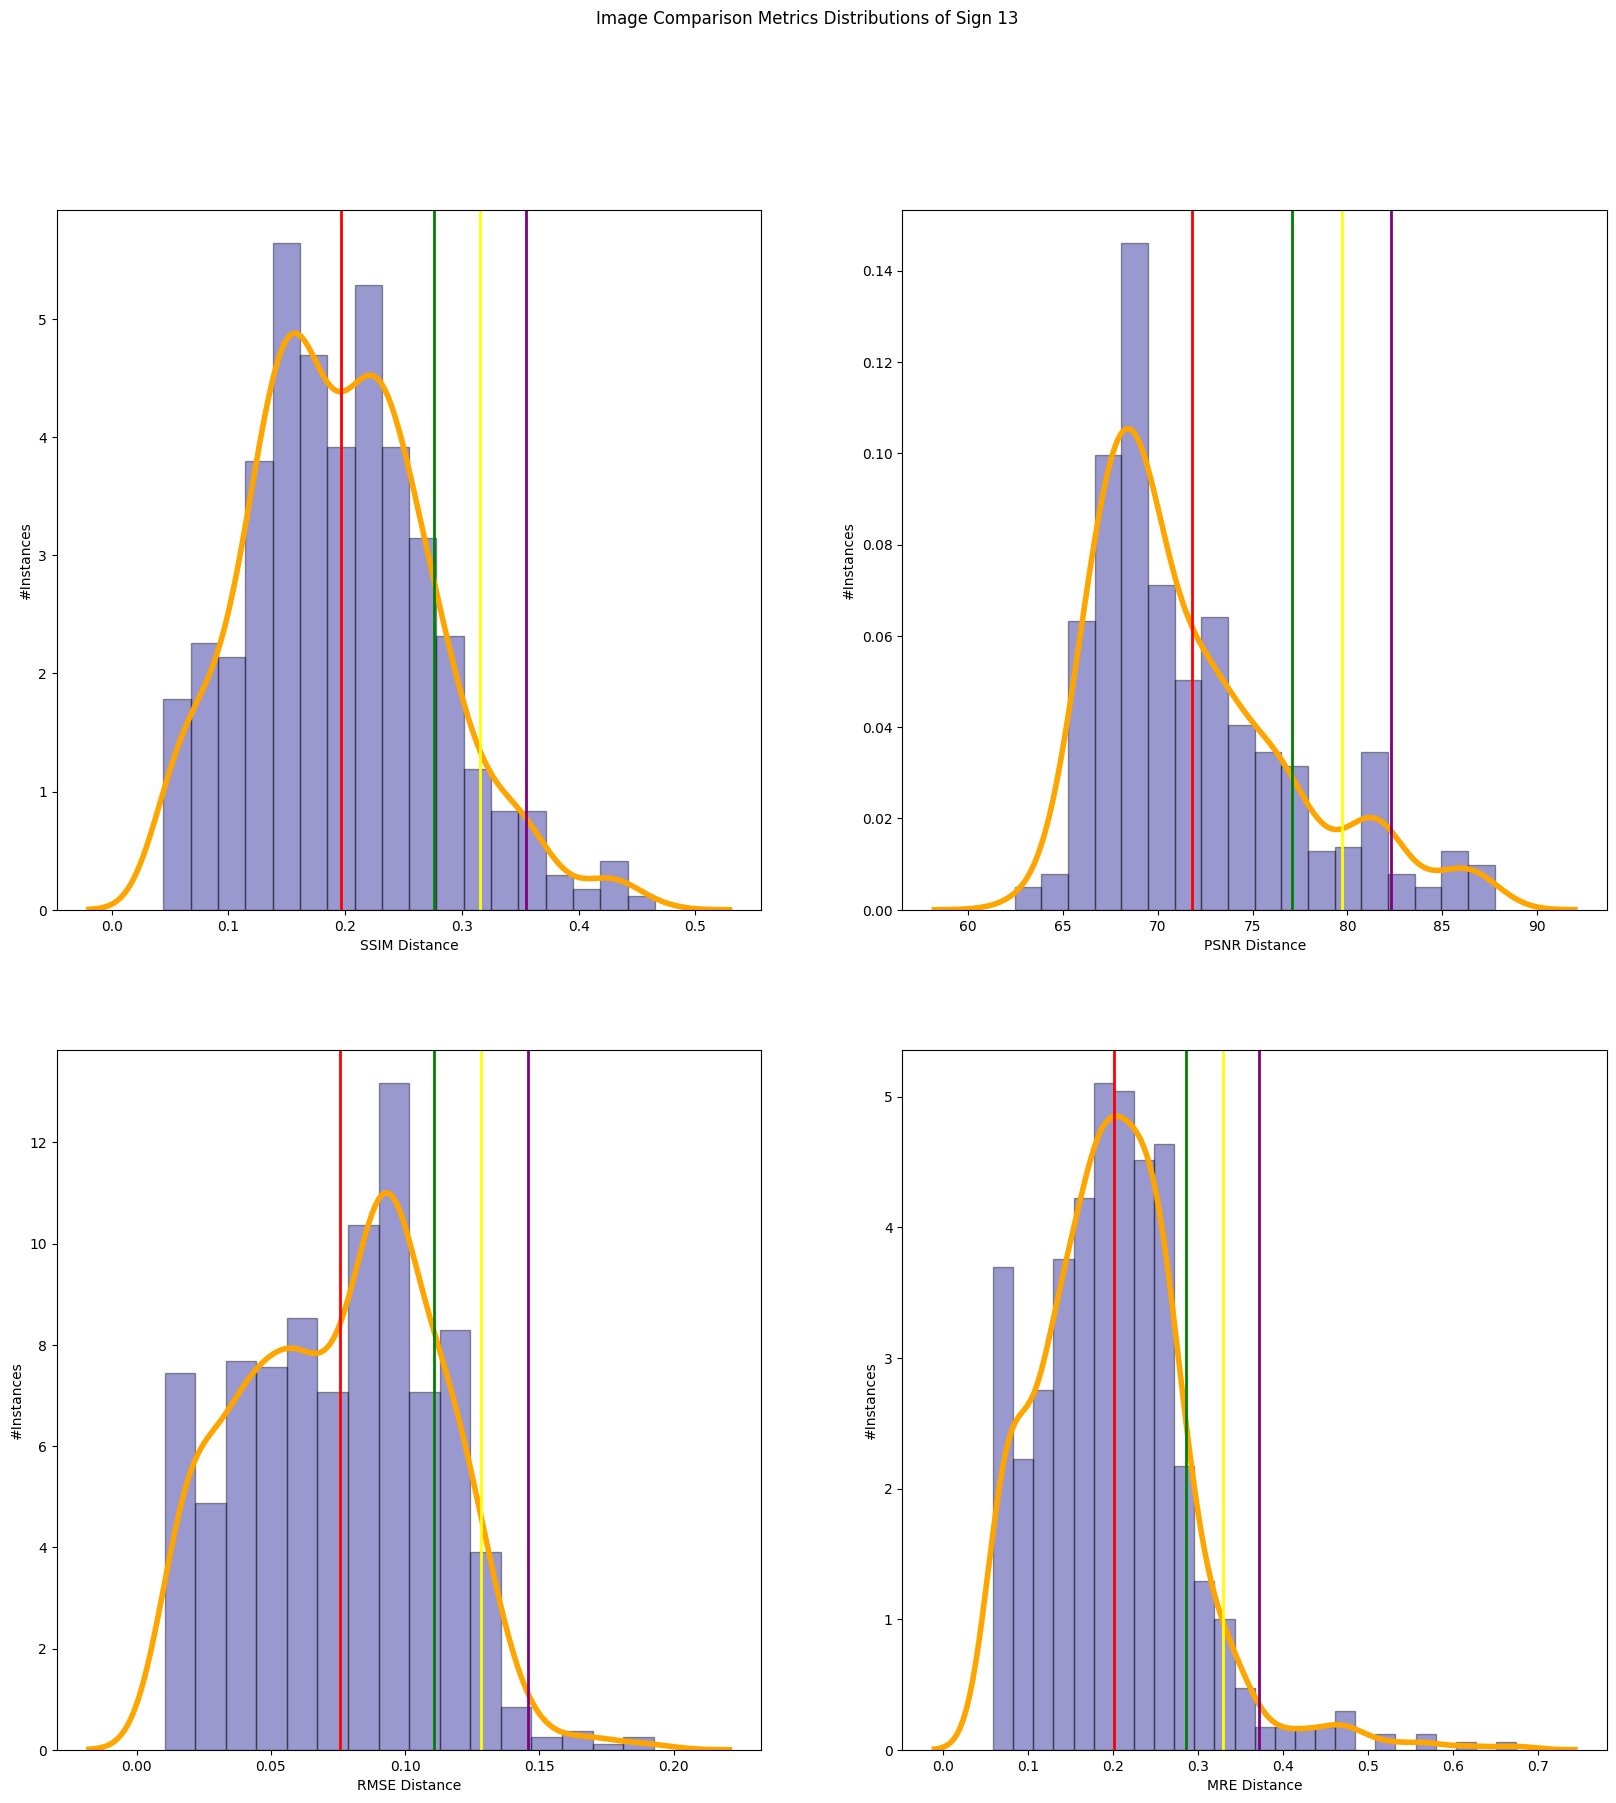

In [66]:
ssim, psnr, rmse, mre = testset(test_path13, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "13")

9/9 [==============================] - 0s 6ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.18625294919367189  ssim σ:  0.0910854541252423  ssim μ+σ:  0.2773384033189142
ssim μ+1.5σ:  0.3228811303815353  ssim μ+2σ:  0.3684238574441565
psnr mean:  71.99530857227467  psnr σ:  4.05005832411964  psnr μ+σ:  76.04536689639431
psnr μ+1.5σ:  78.07039605845412  psnr μ+2σ:  80.09542522051395
rmse mean:  0.069853514  rmse σ:  0.023891836  rmse μ+σ:  0.09374535
rmse μ+1.5σ:  0.10569126904010773  rmse μ+2σ:  0.11763718724250793


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.19607614  mre σ:  0.06617361  mre μ+σ:  0.26224977
mre μ+1.5σ:  0.2953365594148636  mre μ+2σ:  0.3284233659505844


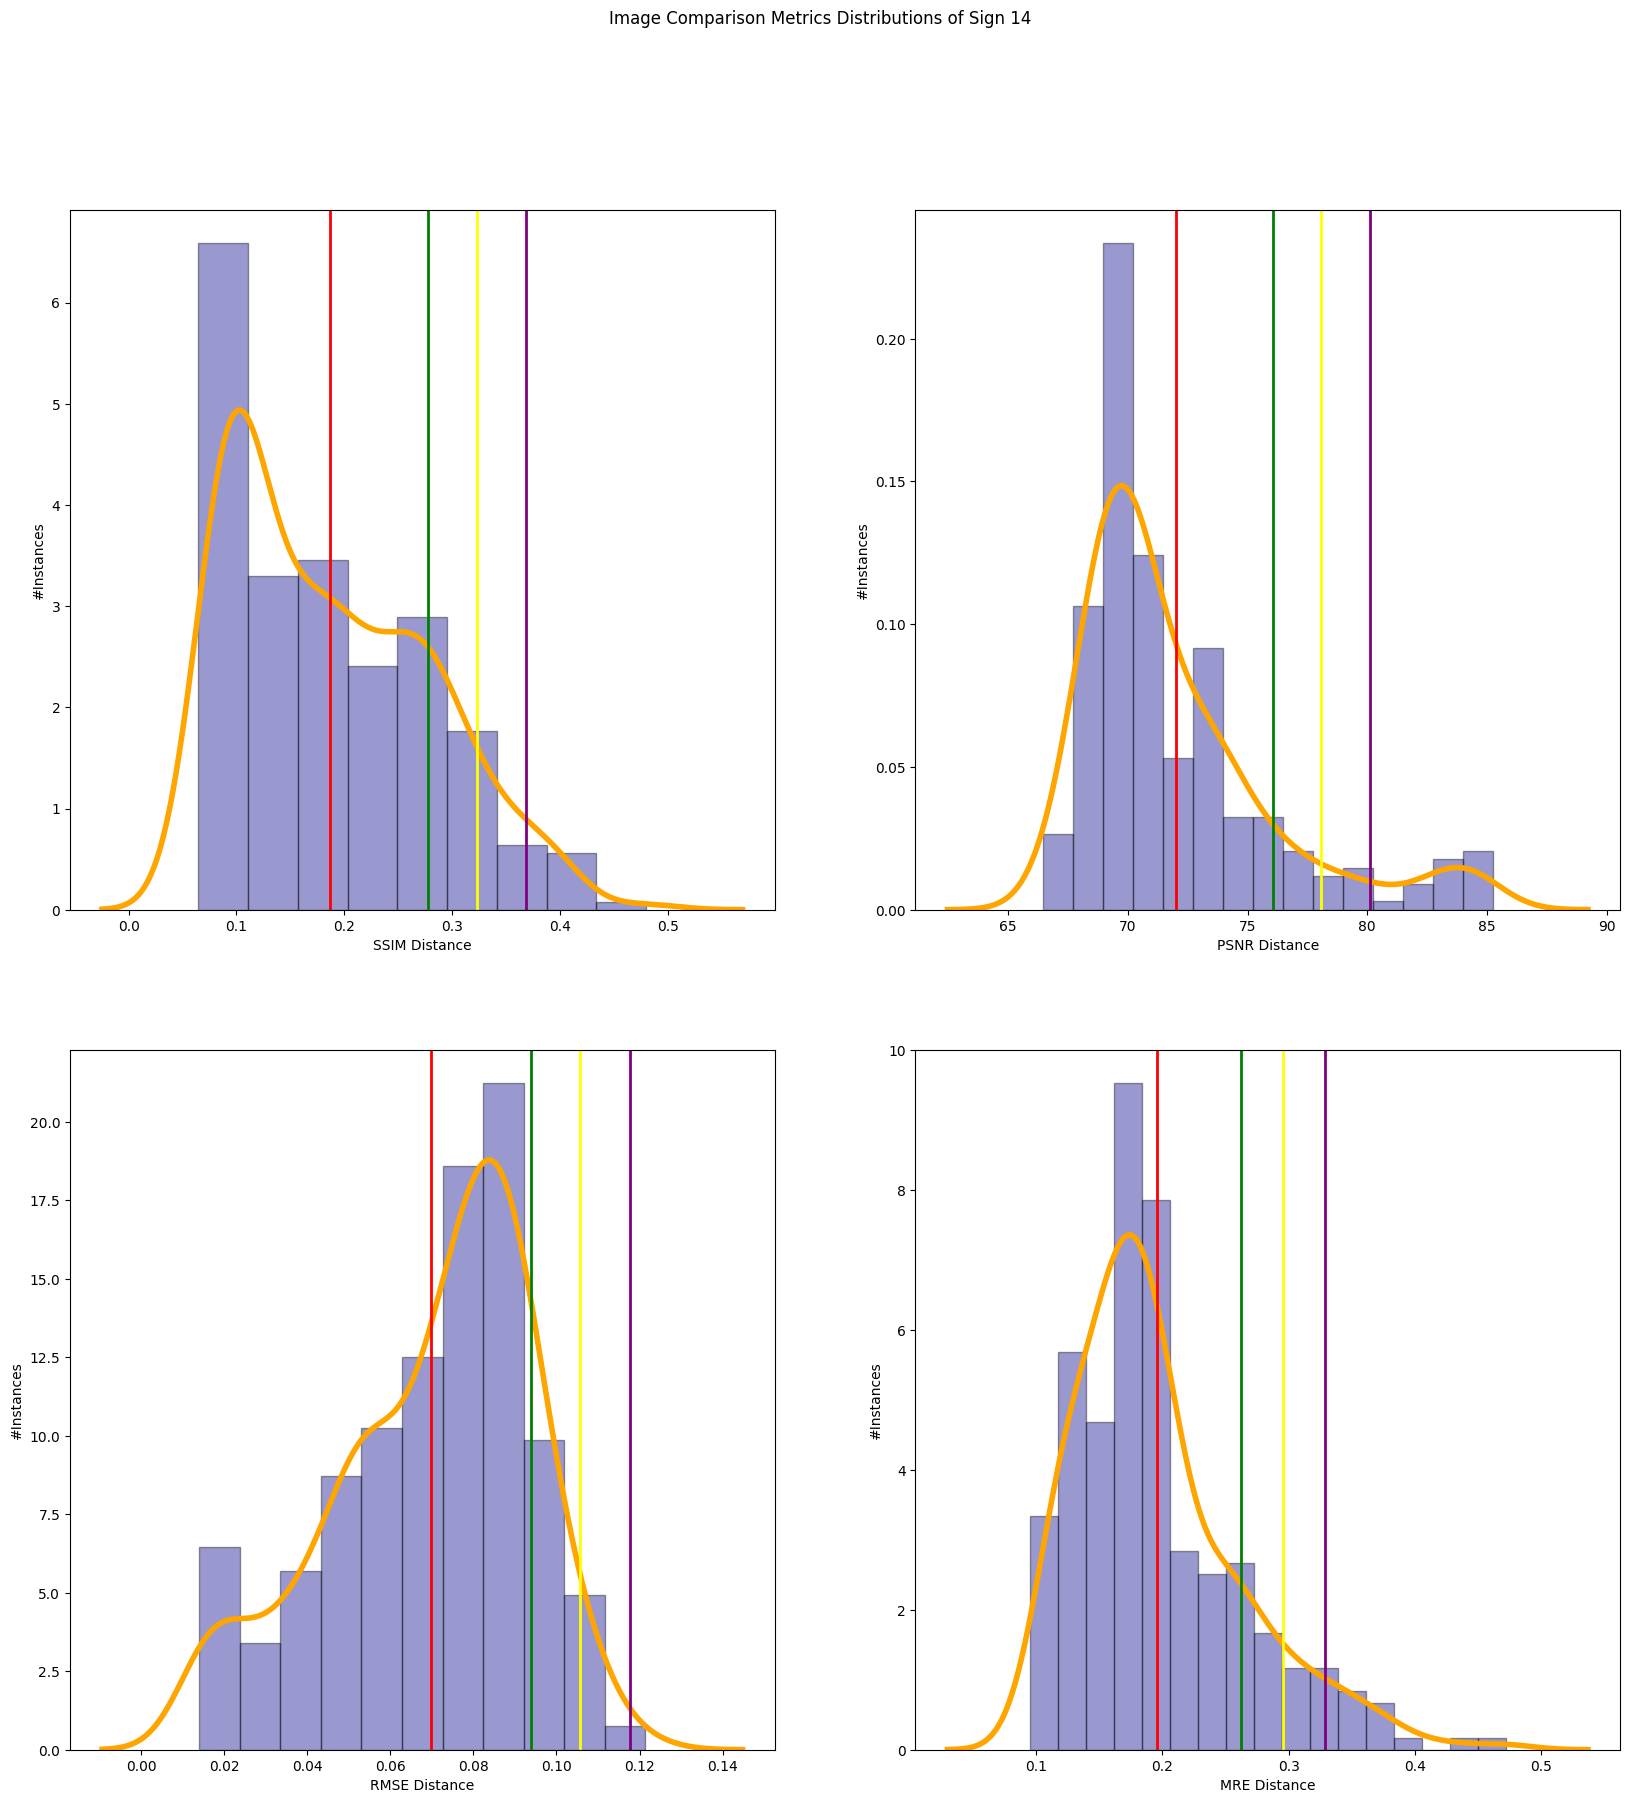

In [67]:
ssim, psnr, rmse, mre = testset(test_path14, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "14")

7/7 [==============================] - 0s 7ms/step
#Instances:  210
Destructor called, Employee deleted.
ssim mean:  0.15411588067100163  ssim σ:  0.06385857890722473  ssim μ+σ:  0.21797445957822636
ssim μ+1.5σ:  0.2499037490318387  ssim μ+2σ:  0.28183303848545105
psnr mean:  71.37109255109515  psnr σ:  4.145102936699659  psnr μ+σ:  75.5161954877948
psnr μ+1.5σ:  77.58874695614463  psnr μ+2σ:  79.66129842449446
rmse mean:  0.0762206  rmse σ:  0.0313823  rmse μ+σ:  0.1076029
rmse μ+1.5σ:  0.12329405173659325  rmse μ+2σ:  0.13898520171642303
mre mean:  0.17167364  mre σ:  0.05512206  mre μ+σ:  0.2267957
mre μ+1.5σ:  0.25435672886669636  mre μ+2σ:  0.2819177582859993


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

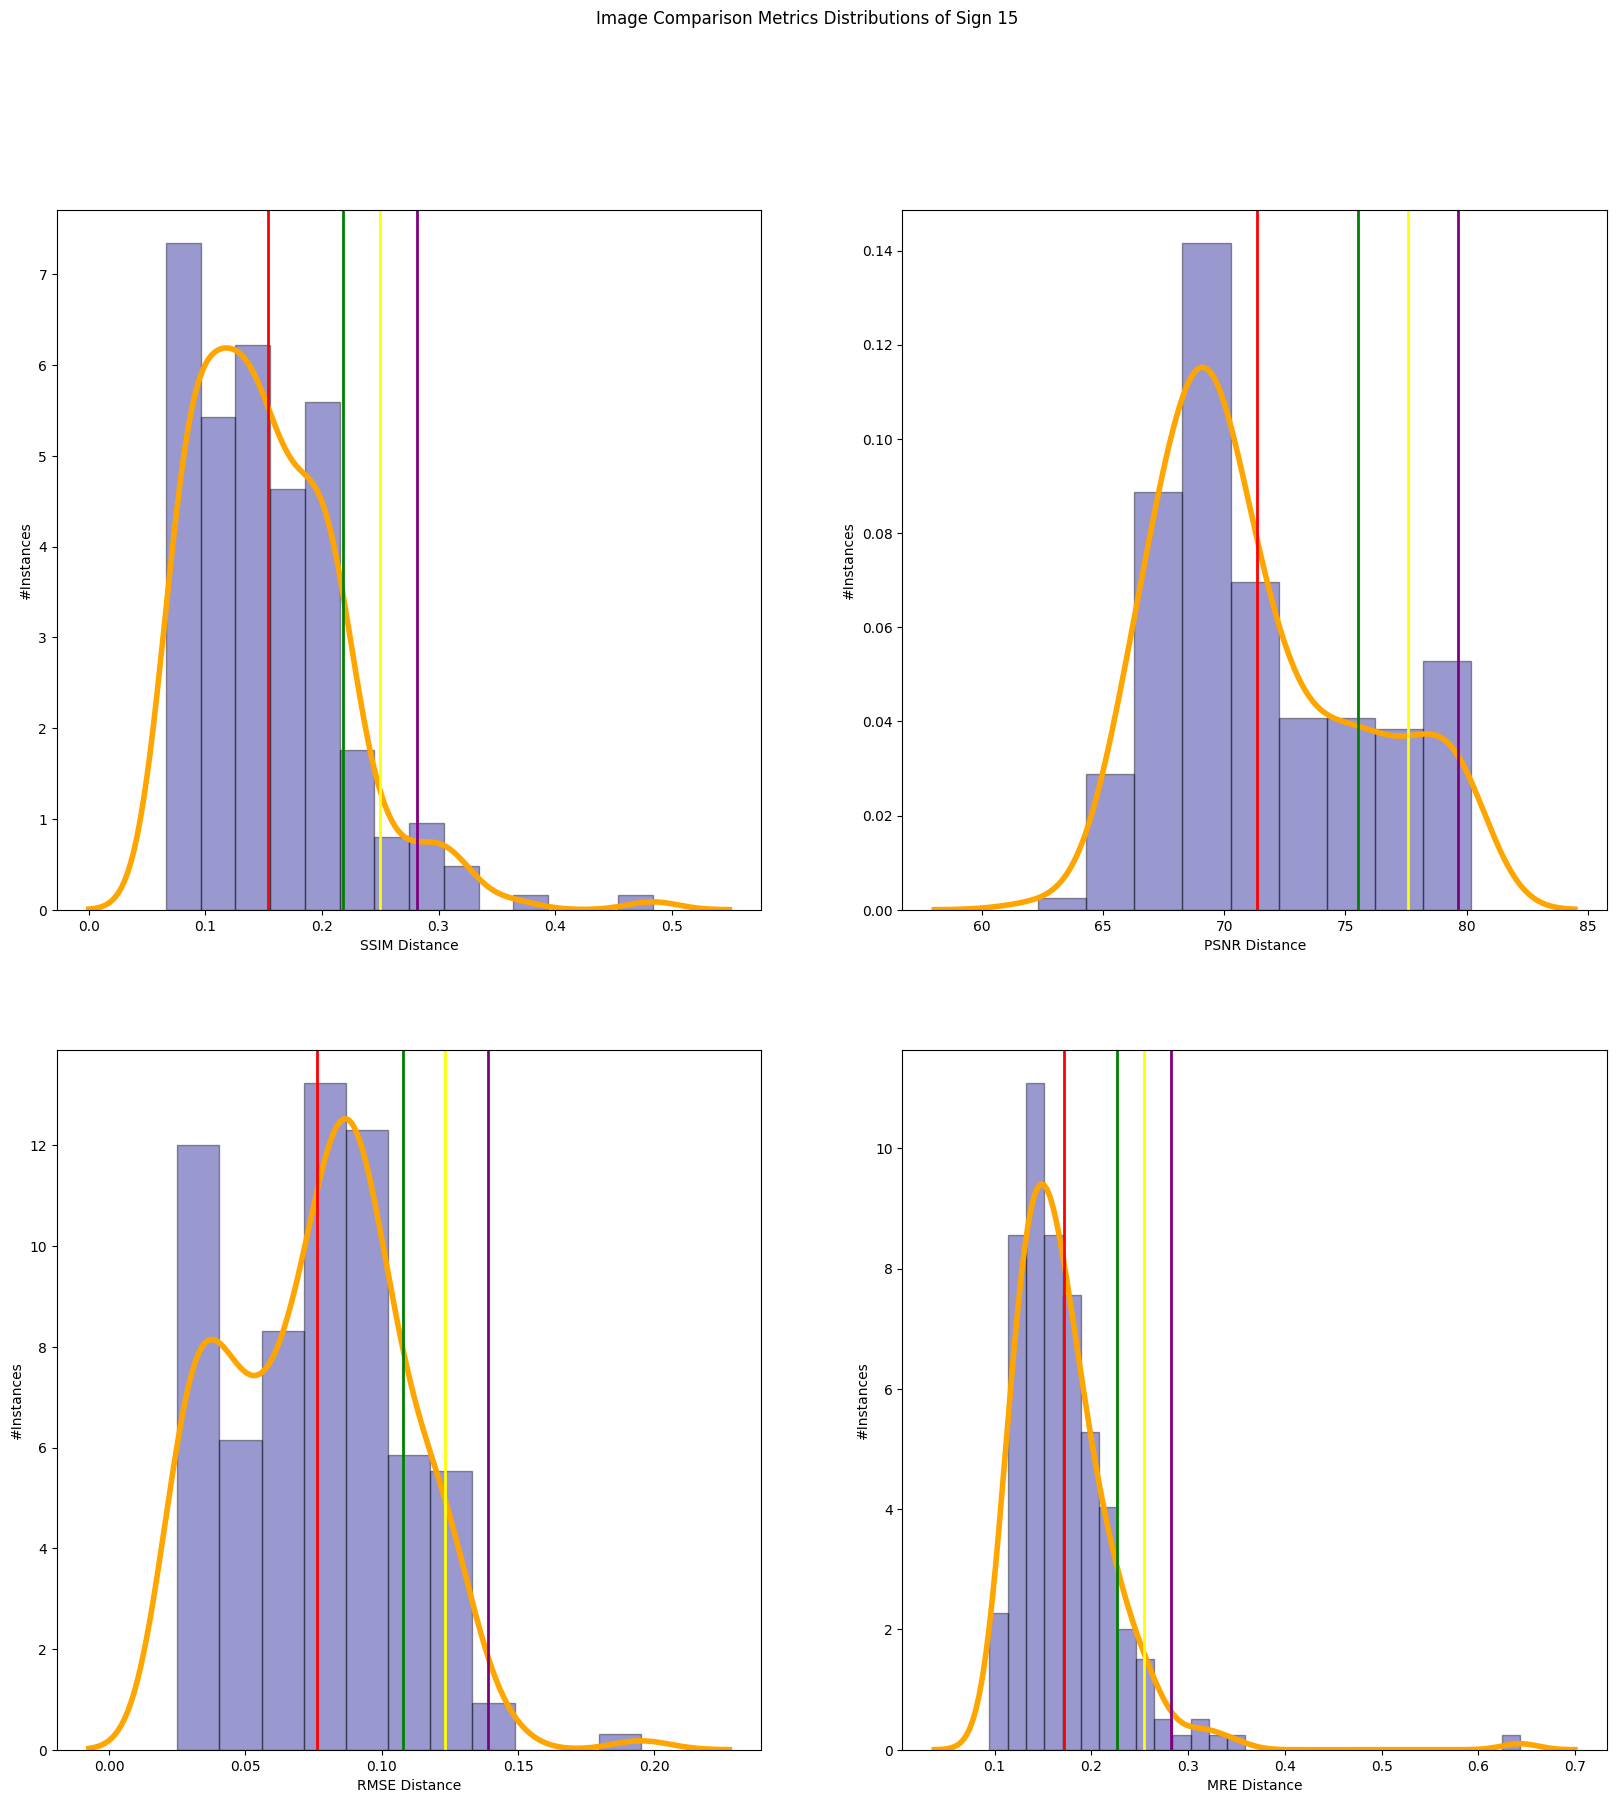

In [68]:
ssim, psnr, rmse, mre = testset(test_path15, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "15")

5/5 [==============================] - 0s 5ms/step
#Instances:  150
Destructor called, Employee deleted.
ssim mean:  0.08891390562057495  ssim σ:  0.027923393721700576  ssim μ+σ:  0.11683729934227553
ssim μ+1.5σ:  0.13079899620312582  ssim μ+2σ:  0.1447606930639761


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],


psnr mean:  76.66425786336264  psnr σ:  5.059311022342169  psnr μ+σ:  81.72356888570481
psnr μ+1.5σ:  84.2532243968759  psnr μ+2σ:  86.78287990804698
rmse mean:  0.04349839  rmse σ:  0.021705436  rmse μ+σ:  0.06520382
rmse μ+1.5σ:  0.07605654280632734  rmse μ+2σ:  0.08690926060080528
mre mean:  0.1431561  mre σ:  0.035636816  mre μ+σ:  0.17879291
mre μ+1.5σ:  0.1966113205999136  mre μ+2σ:  0.21442972868680954


/tmp/ipykernel_122393/2660218213.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


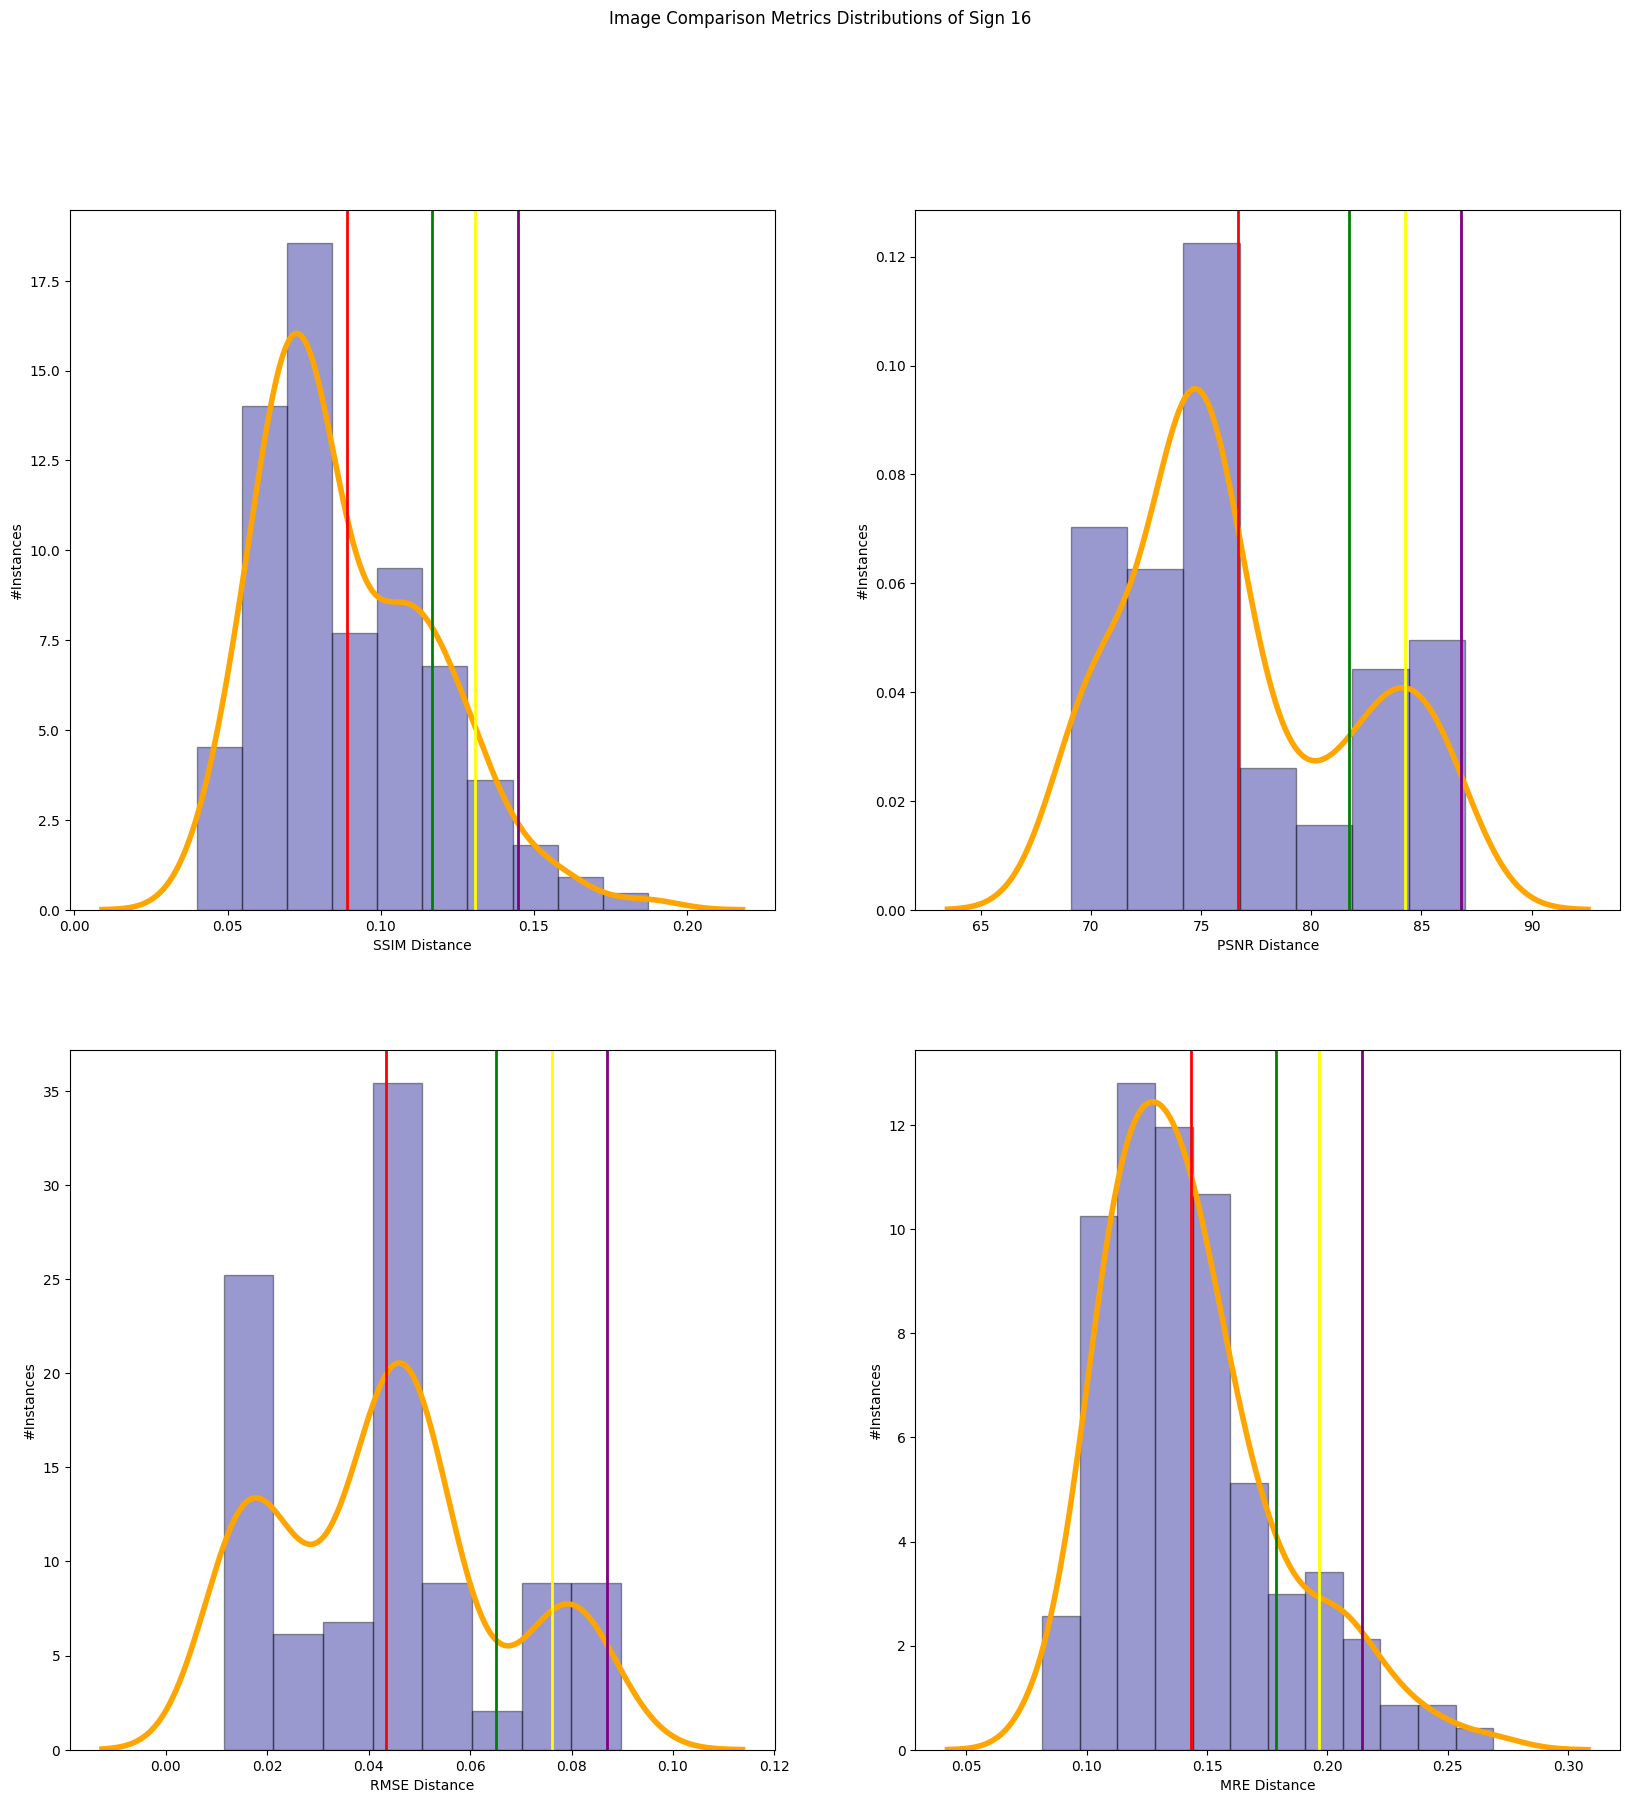

In [69]:
ssim, psnr, rmse, mre = testset(test_path16, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "16")

12/12 [==============================] - 0s 5ms/step
#Instances:  360
Destructor called, Employee deleted.
ssim mean:  0.1930742899576823  ssim σ:  0.08031160727487126  ssim μ+σ:  0.2733858972325536
ssim μ+1.5σ:  0.3135417008699892  ssim μ+2σ:  0.3536975045074248
psnr mean:  71.94292515648736  psnr σ:  4.106073525551201  psnr μ+σ:  76.04899868203856
psnr μ+1.5σ:  78.10203544481416  psnr μ+2σ:  80.15507220758977
rmse mean:  0.07140495  rmse σ:  0.029865978  rmse μ+σ:  0.10127093
rmse μ+1.5σ:  0.11620391625910997  rmse μ+2σ:  0.13113690540194511
mre mean:  0.185212  mre σ:  0.10299747  mre μ+σ:  0.28820947
mre μ+1.5σ:  0.33970820158720016  mre μ+2σ:  0.39120693504810333


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

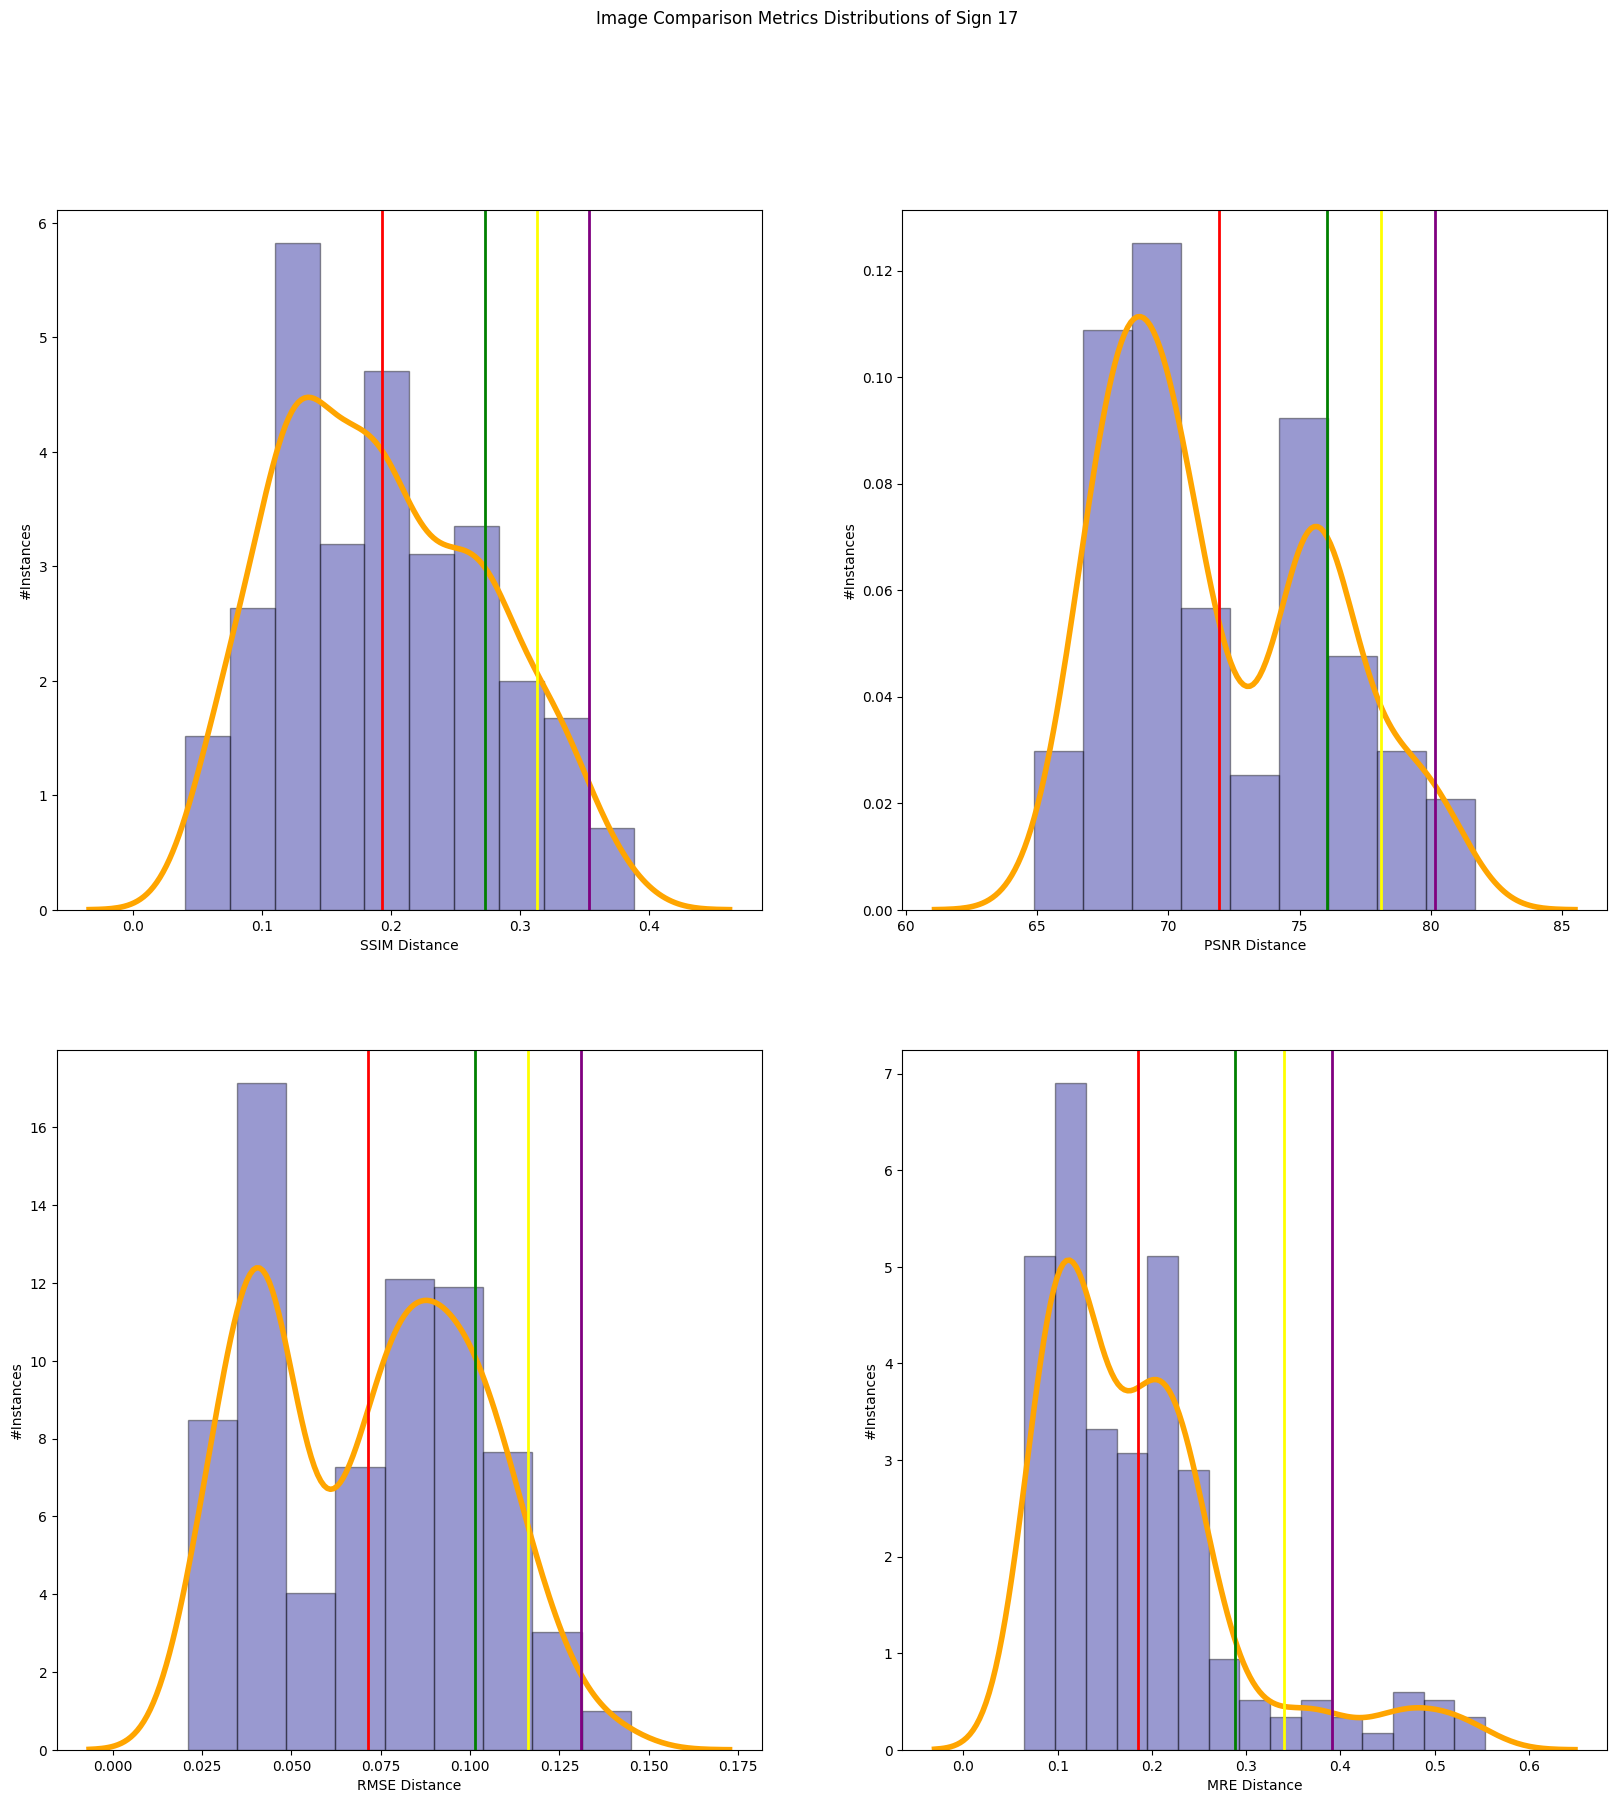

In [70]:
ssim, psnr, rmse, mre = testset(test_path17, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "17")

13/13 [==============================] - 0s 5ms/step
#Instances:  390
Destructor called, Employee deleted.
ssim mean:  0.186056614227784  ssim σ:  0.09605836305477064  ssim μ+σ:  0.28211497728255464
ssim μ+1.5σ:  0.33014415880993997  ssim μ+2σ:  0.3781733403373253
psnr mean:  74.1514531257825  psnr σ:  6.087760759310132  psnr μ+σ:  80.23921388509262
psnr μ+1.5σ:  83.28309426474769  psnr μ+2σ:  86.32697464440275
rmse mean:  0.061538357  rmse σ:  0.0350613  rmse μ+σ:  0.09659965
rmse μ+1.5σ:  0.11413030698895454  rmse μ+2σ:  0.13166095688939095
mre mean:  0.183417  mre σ:  0.07378  mre μ+σ:  0.25719702
mre μ+1.5σ:  0.2940870076417923  mre μ+2σ:  0.33097700774669647


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

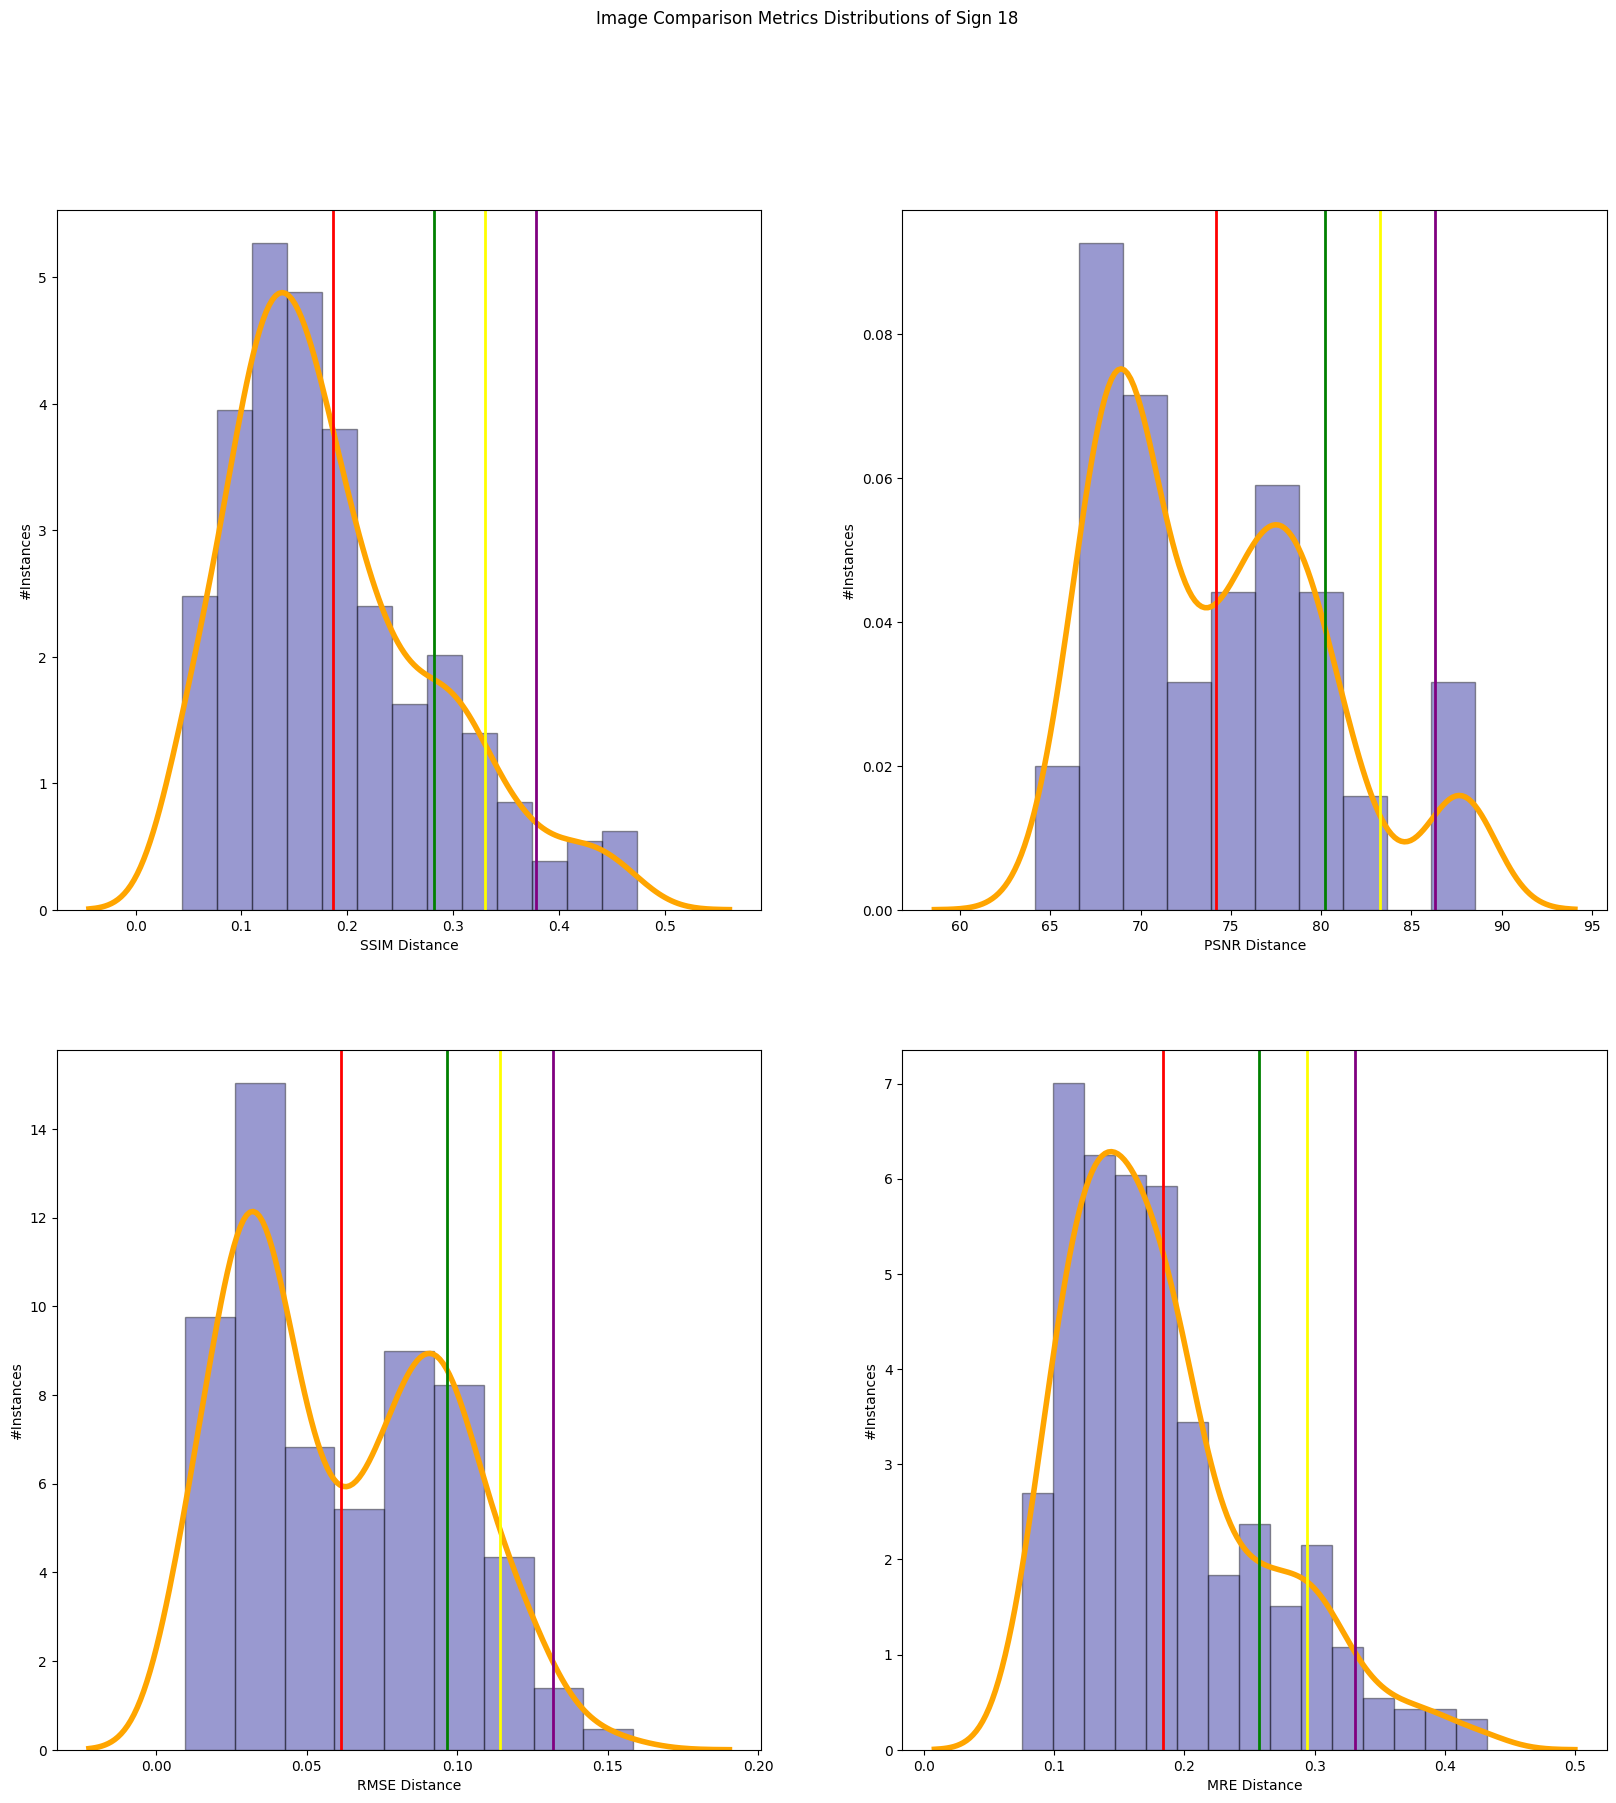

In [71]:
ssim, psnr, rmse, mre = testset(test_path18, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "18")

2/2 [==============================] - 0s 7ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.09182718694210053  ssim σ:  0.026731595610281978  ssim μ+σ:  0.1185587825523825
ssim μ+1.5σ:  0.1319245803575235  ssim μ+2σ:  0.1452903781626645
psnr mean:  80.28419990539551  psnr σ:  5.780922121715807  psnr μ+σ:  86.06512202711131
psnr μ+1.5σ:  88.95558308796922  psnr μ+2σ:  91.84604414882712
rmse mean:  0.030173218  rmse σ:  0.01724056  rmse μ+σ:  0.047413778
rmse μ+1.5σ:  0.05603405740112066  rmse μ+2σ:  0.06465433724224567
mre mean:  0.17772163  mre σ:  0.04813285  mre μ+σ:  0.22585449
mre μ+1.5σ:  0.24992091208696365  mre μ+2σ:  0.2739873379468918


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

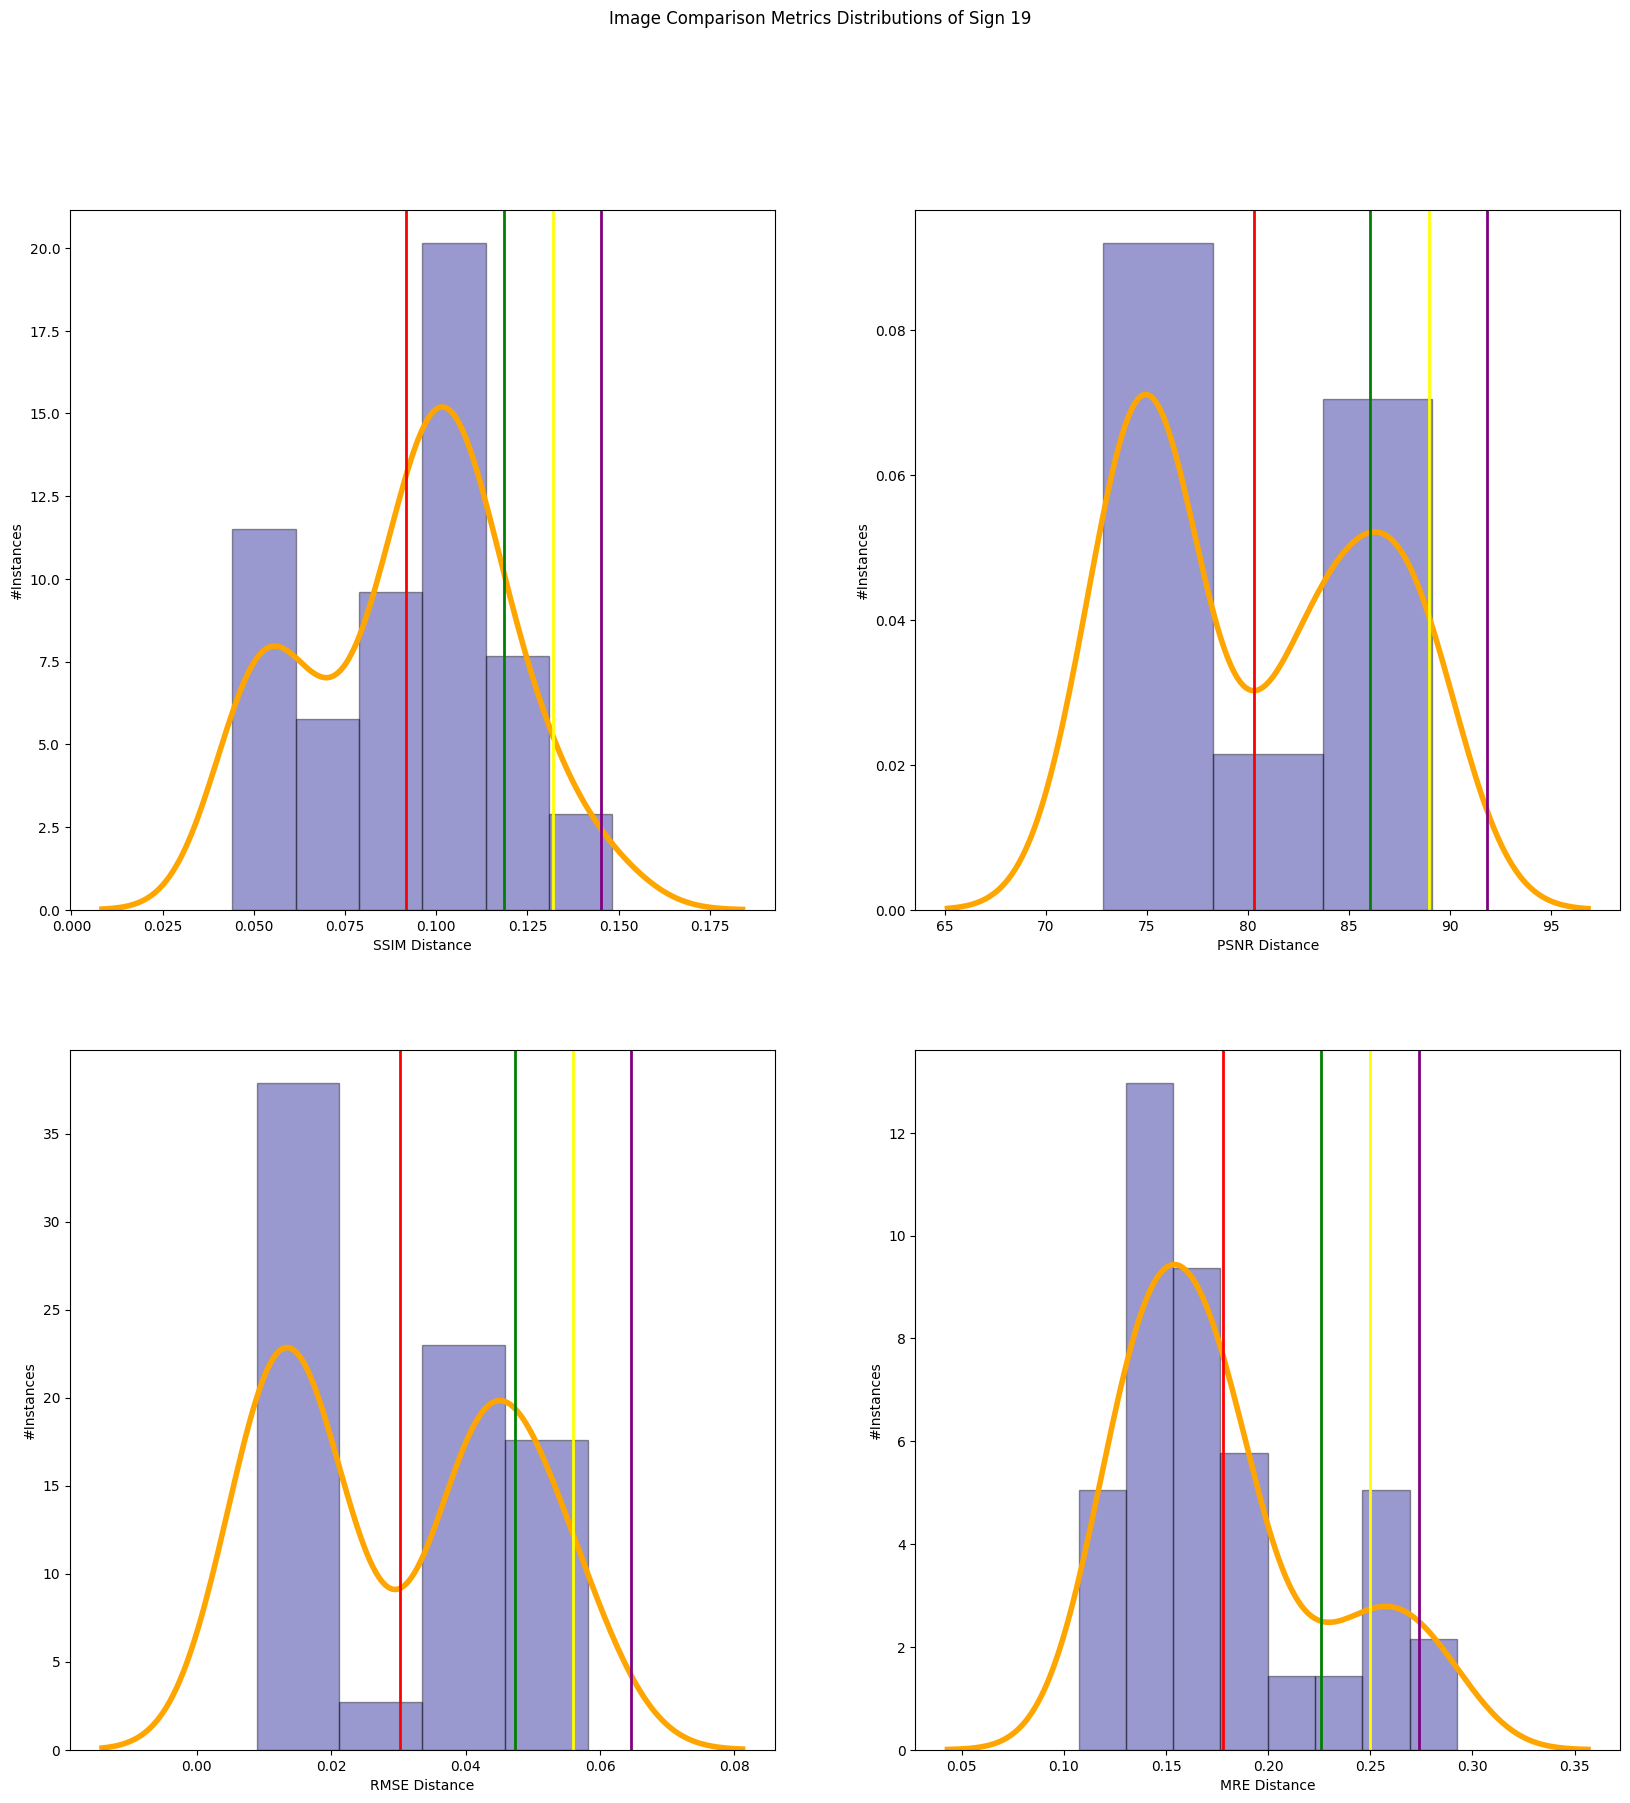

In [72]:
ssim, psnr, rmse, mre = testset(test_path19, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "19")

3/3 [==============================] - 0s 6ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.18927584290504457  ssim σ:  0.05930478299980763  ssim μ+σ:  0.2485806259048522
ssim μ+1.5σ:  0.27823301740475603  ssim μ+2σ:  0.3078854089046598
psnr mean:  71.40639216105143  psnr σ:  3.0837837856101507  psnr μ+σ:  74.49017594666158
psnr μ+1.5σ:  76.03206783946665  psnr μ+2σ:  77.57395973227173
rmse mean:  0.07290518  rmse σ:  0.024961289  rmse μ+σ:  0.097866476
rmse μ+1.5σ:  0.11034711636602879  rmse μ+2σ:  0.12282776087522507
mre mean:  0.20668823  mre σ:  0.063081004  mre μ+σ:  0.26976922
mre μ+1.5σ:  0.3013097308576107  mre μ+2σ:  0.33285023272037506


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

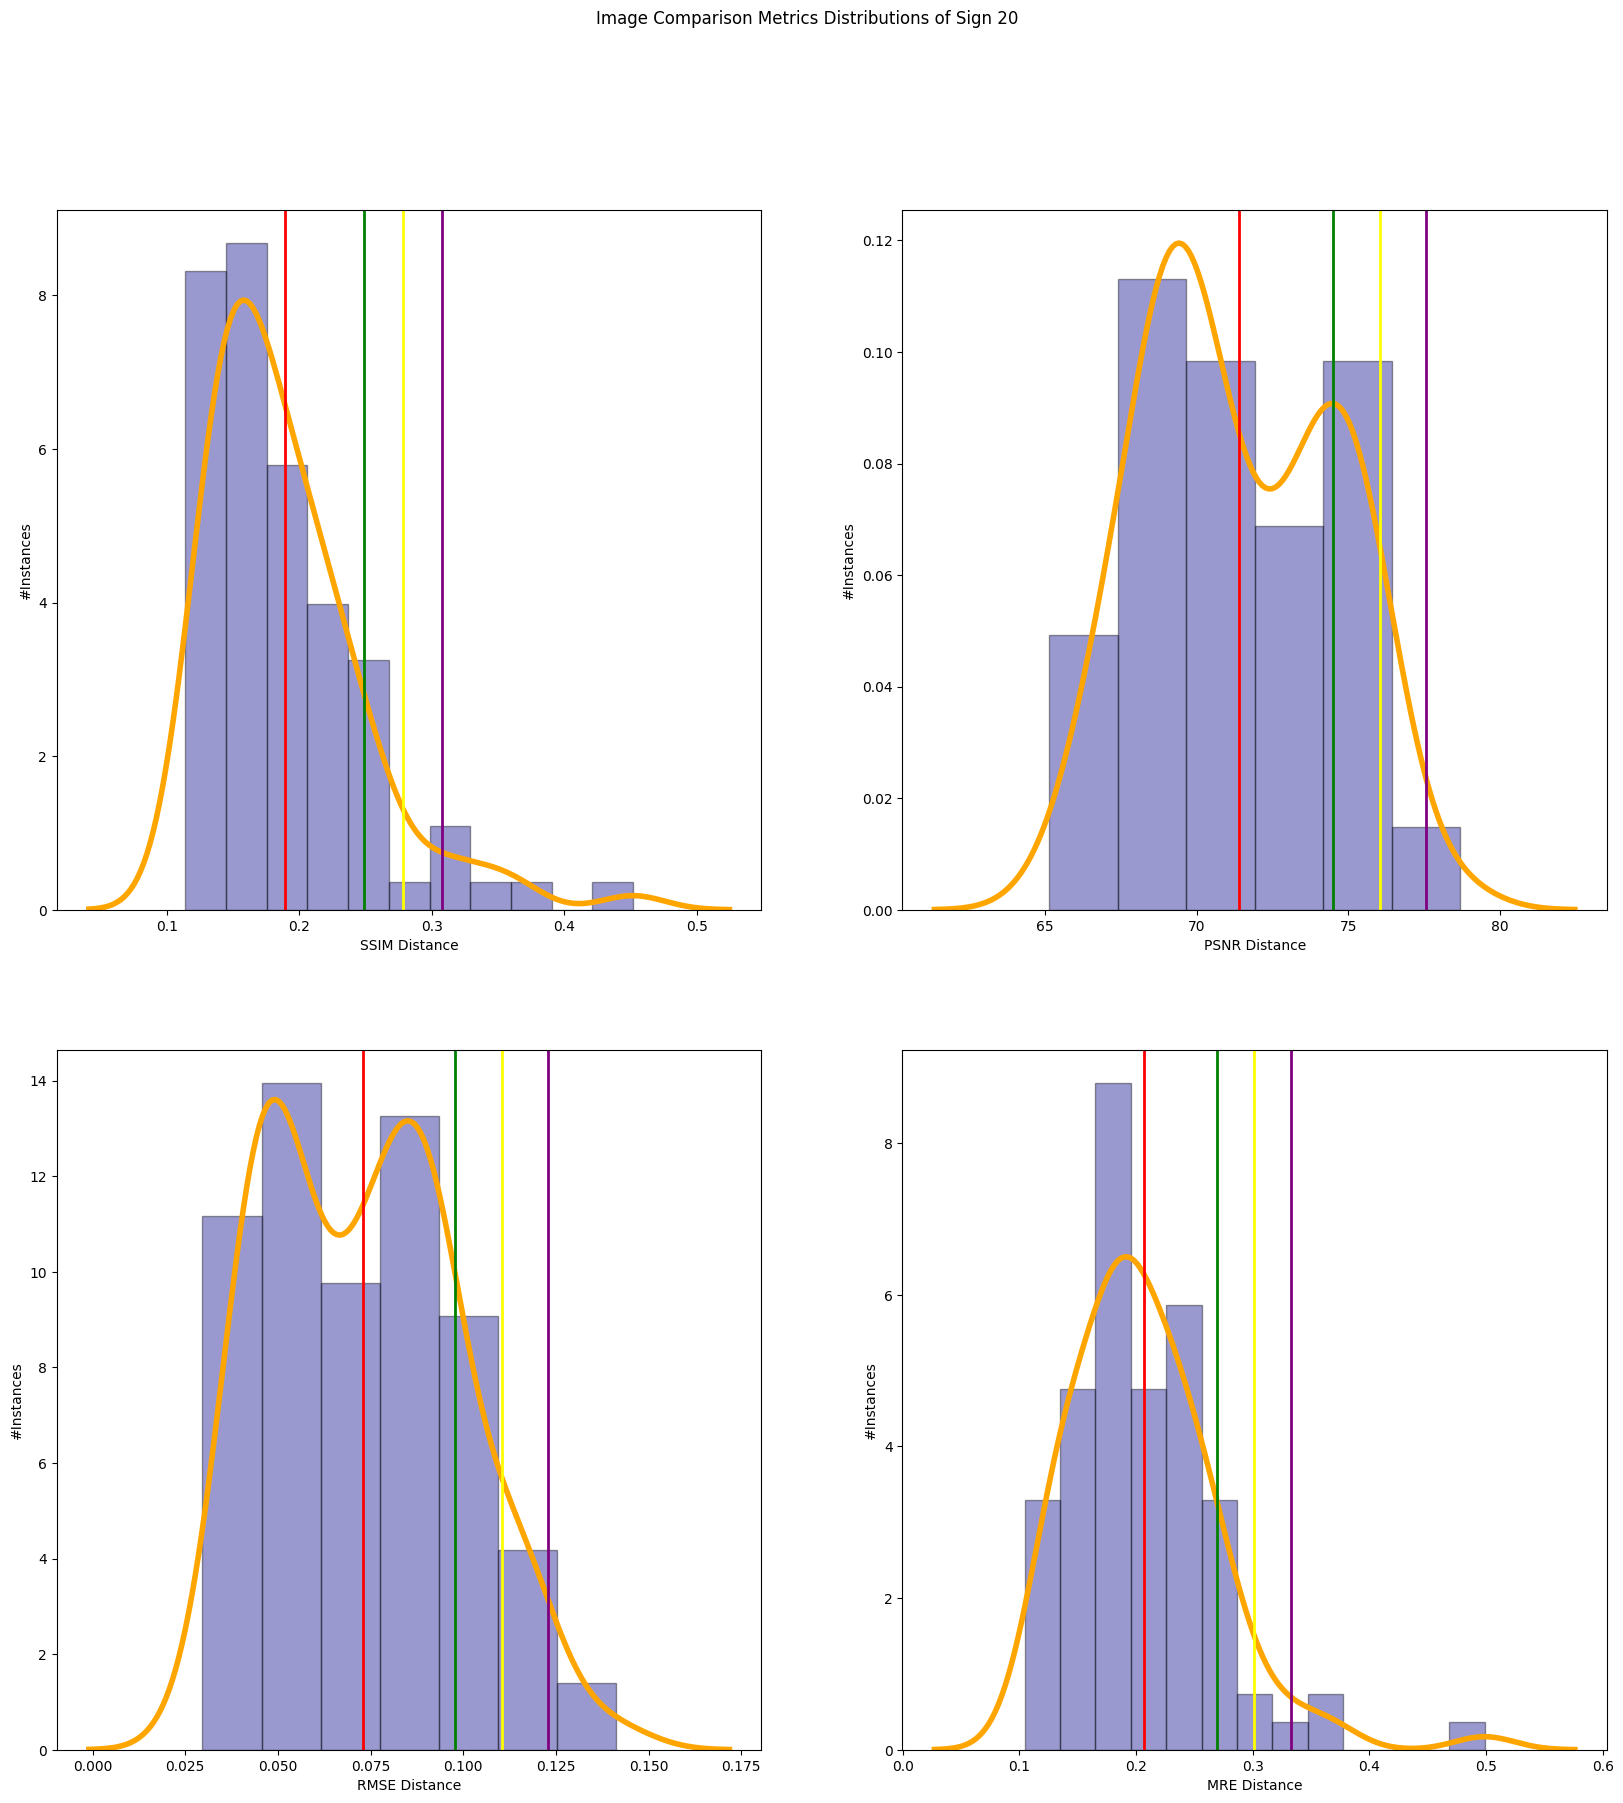

In [73]:
ssim, psnr, rmse, mre = testset(test_path20, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "20")

3/3 [==============================] - 0s 5ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.3115200251340866  ssim σ:  0.1292605707469619  ssim μ+σ:  0.4407805958810485
ssim μ+1.5σ:  0.5054108812545295  ssim μ+2σ:  0.5700411666280104
psnr mean:  67.8790030585395  psnr σ:  2.510452150986333  psnr μ+σ:  70.38945520952583
psnr μ+1.5σ:  71.64468128501899  psnr μ+2σ:  72.89990736051216
rmse mean:  0.107374676  rmse σ:  0.031520203  rmse μ+σ:  0.13889489
rmse μ+1.5σ:  0.15465497970581055  rmse μ+2σ:  0.17041508108377457
mre mean:  0.2931538  mre σ:  0.074865036  mre μ+σ:  0.36801884
mre μ+1.5σ:  0.40545134618878365  mre μ+2σ:  0.4428838640451431


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

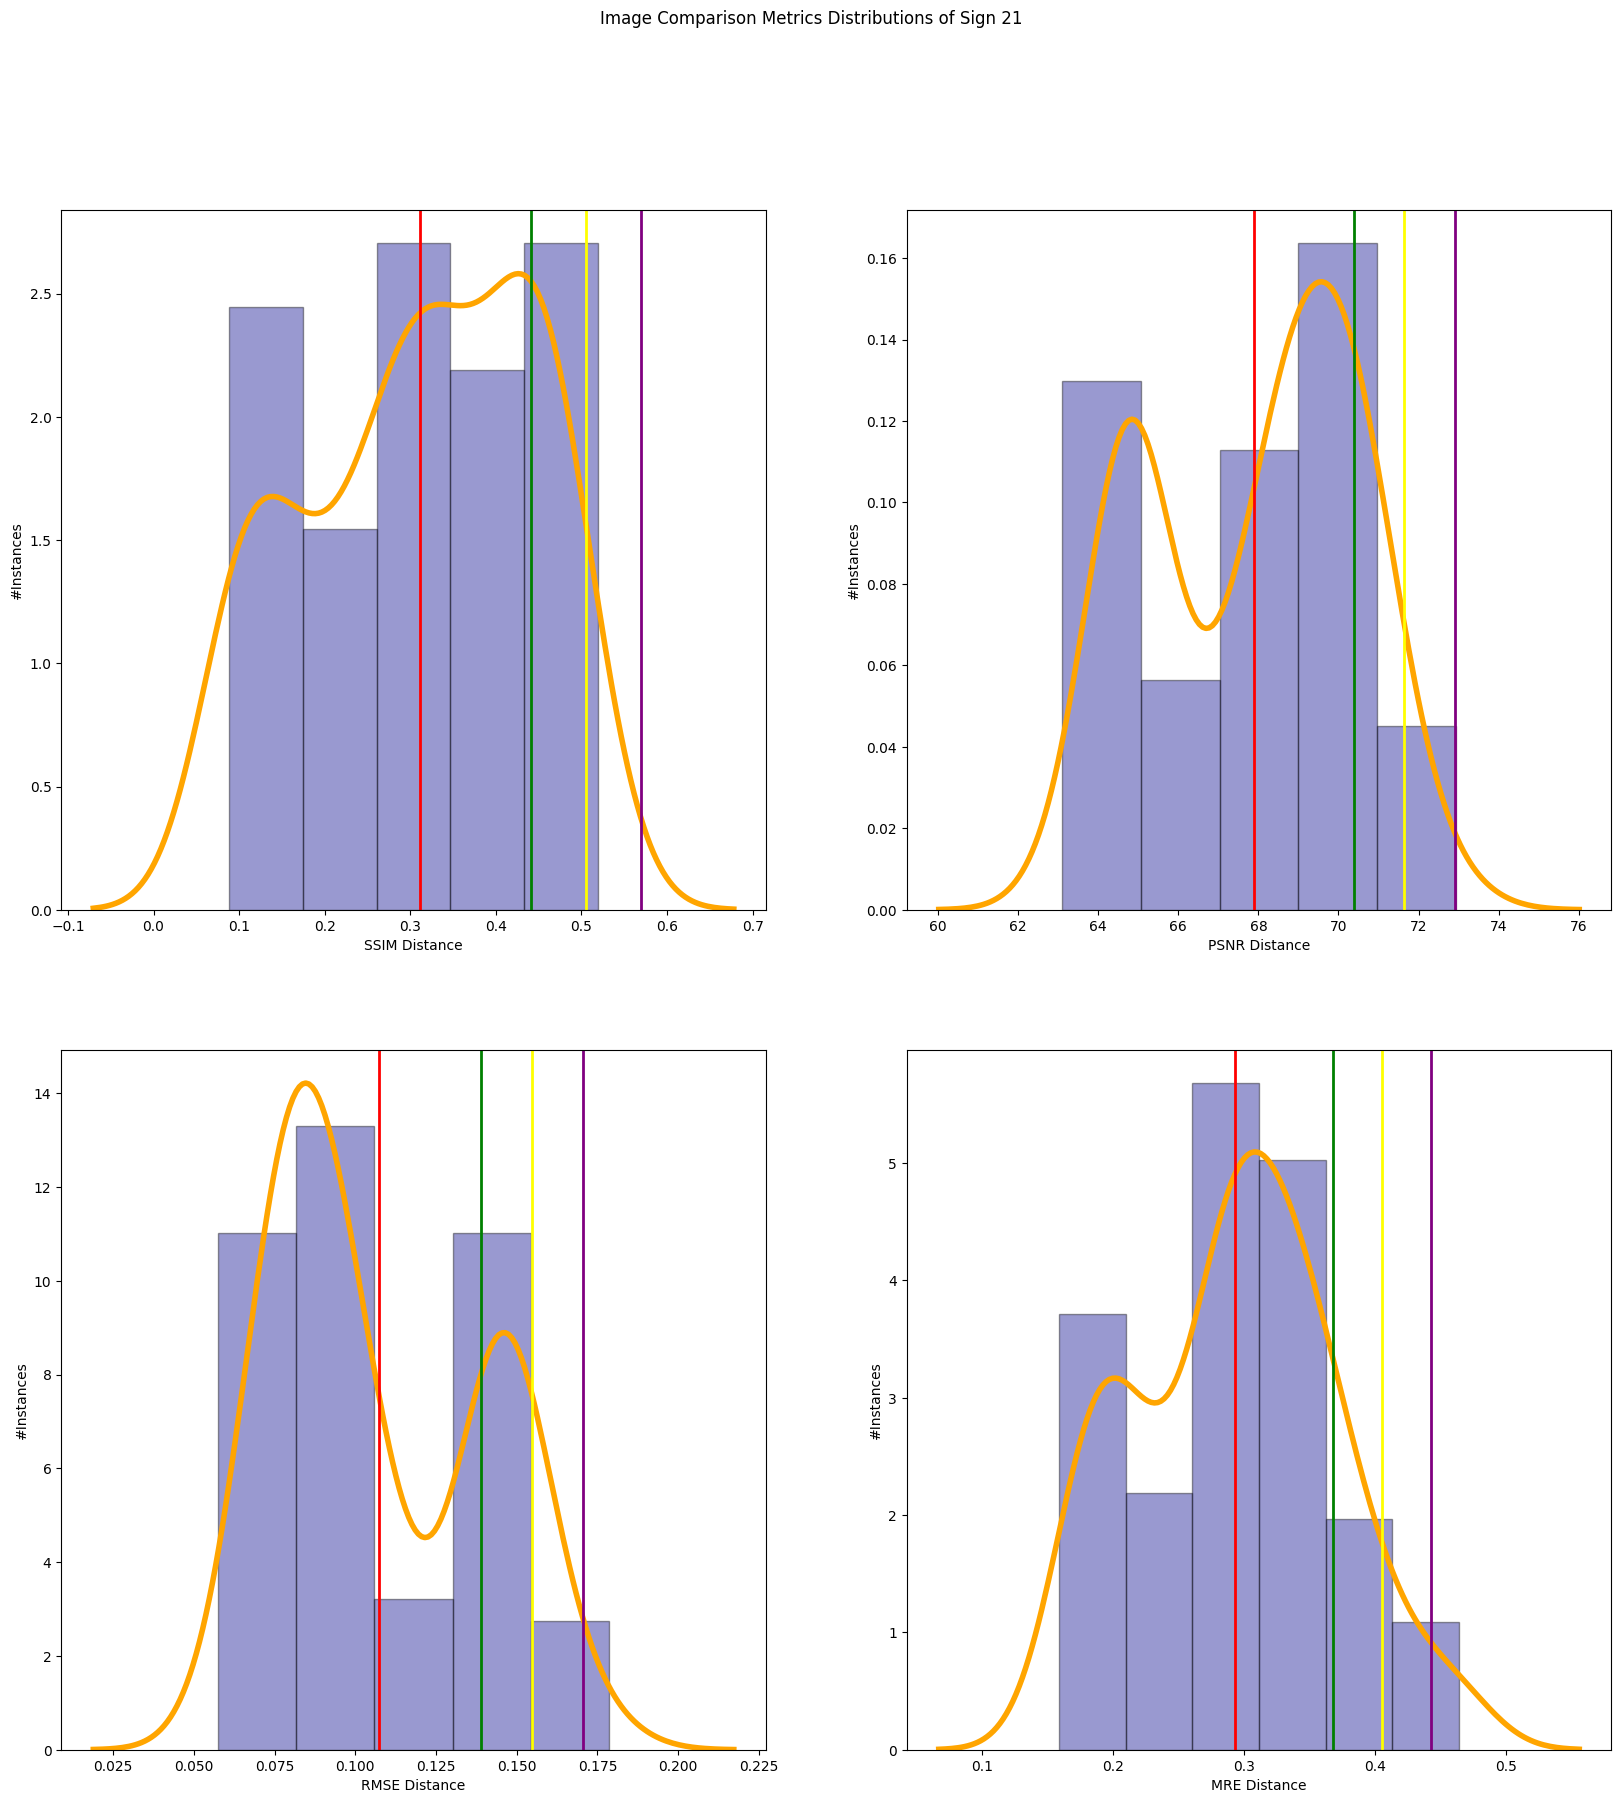

In [74]:
ssim, psnr, rmse, mre = testset(test_path21, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "21")

4/4 [==============================] - 0s 5ms/step
#Instances:  120
Destructor called, Employee deleted.


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

ssim mean:  0.2148637336989244  ssim σ:  0.14242254222350498  ssim μ+σ:  0.35728627592242934
ssim μ+1.5σ:  0.42849754703418186  ssim μ+2σ:  0.4997088181459344
psnr mean:  72.17165740331014  psnr σ:  6.245487668310513  psnr μ+σ:  78.41714507162065
psnr μ+1.5σ:  81.53988890577591  psnr μ+2σ:  84.66263273993115
rmse mean:  0.07937741  rmse σ:  0.050698057  rmse μ+σ:  0.13007547
rmse μ+1.5σ:  0.15542449802160263  rmse μ+2σ:  0.18077352643013
mre mean:  0.23027538  mre σ:  0.11606462  mre μ+σ:  0.34634
mre μ+1.5σ:  0.40437231212854385  mre μ+2σ:  0.46240462362766266


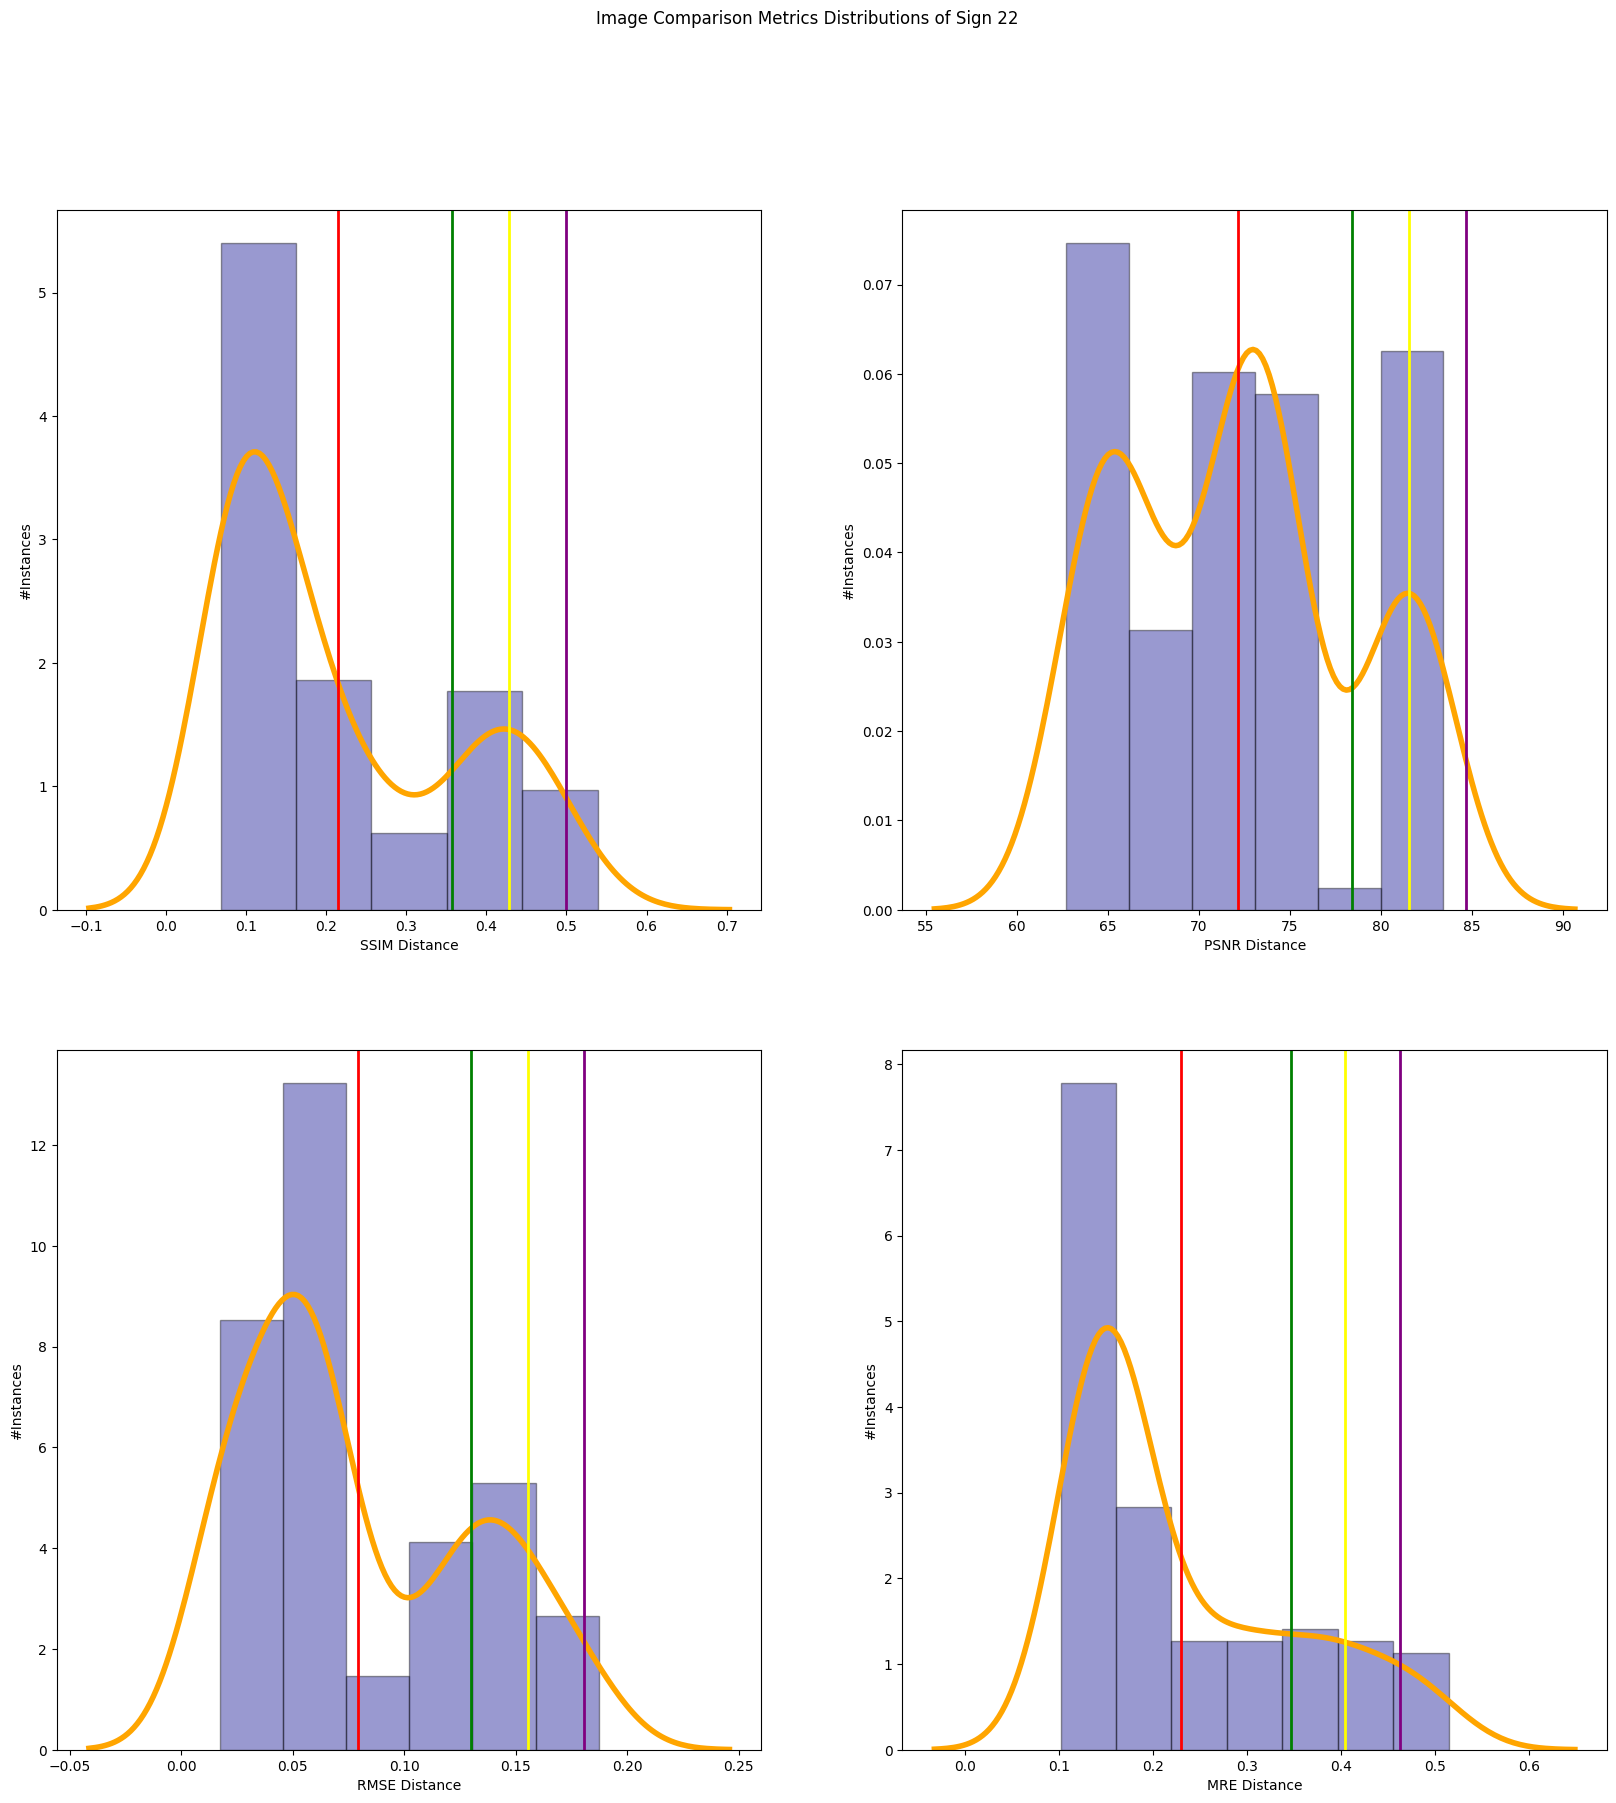

In [75]:
ssim, psnr, rmse, mre = testset(test_path22, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "22")

5/5 [==============================] - 0s 6ms/step
#Instances:  150
Destructor called, Employee deleted.
ssim mean:  0.1993646494547526  ssim σ:  0.08648753073800497  ssim μ+σ:  0.2858521801927576
ssim μ+1.5σ:  0.32909594556176003  ssim μ+2σ:  0.37233971093076257
psnr mean:  74.50490412394205  psnr σ:  7.226699880801879  psnr μ+σ:  81.73160400474393
psnr μ+1.5σ:  85.34495394514488  psnr μ+2σ:  88.95830388554582
rmse mean:  0.06431929  rmse σ:  0.042481937  rmse μ+σ:  0.10680123
rmse μ+1.5σ:  0.12804219499230385  rmse μ+2σ:  0.14928316324949265


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.23171799  mre σ:  0.07397057  mre μ+σ:  0.30568856
mre μ+1.5σ:  0.3426738455891609  mre μ+2σ:  0.37965913116931915


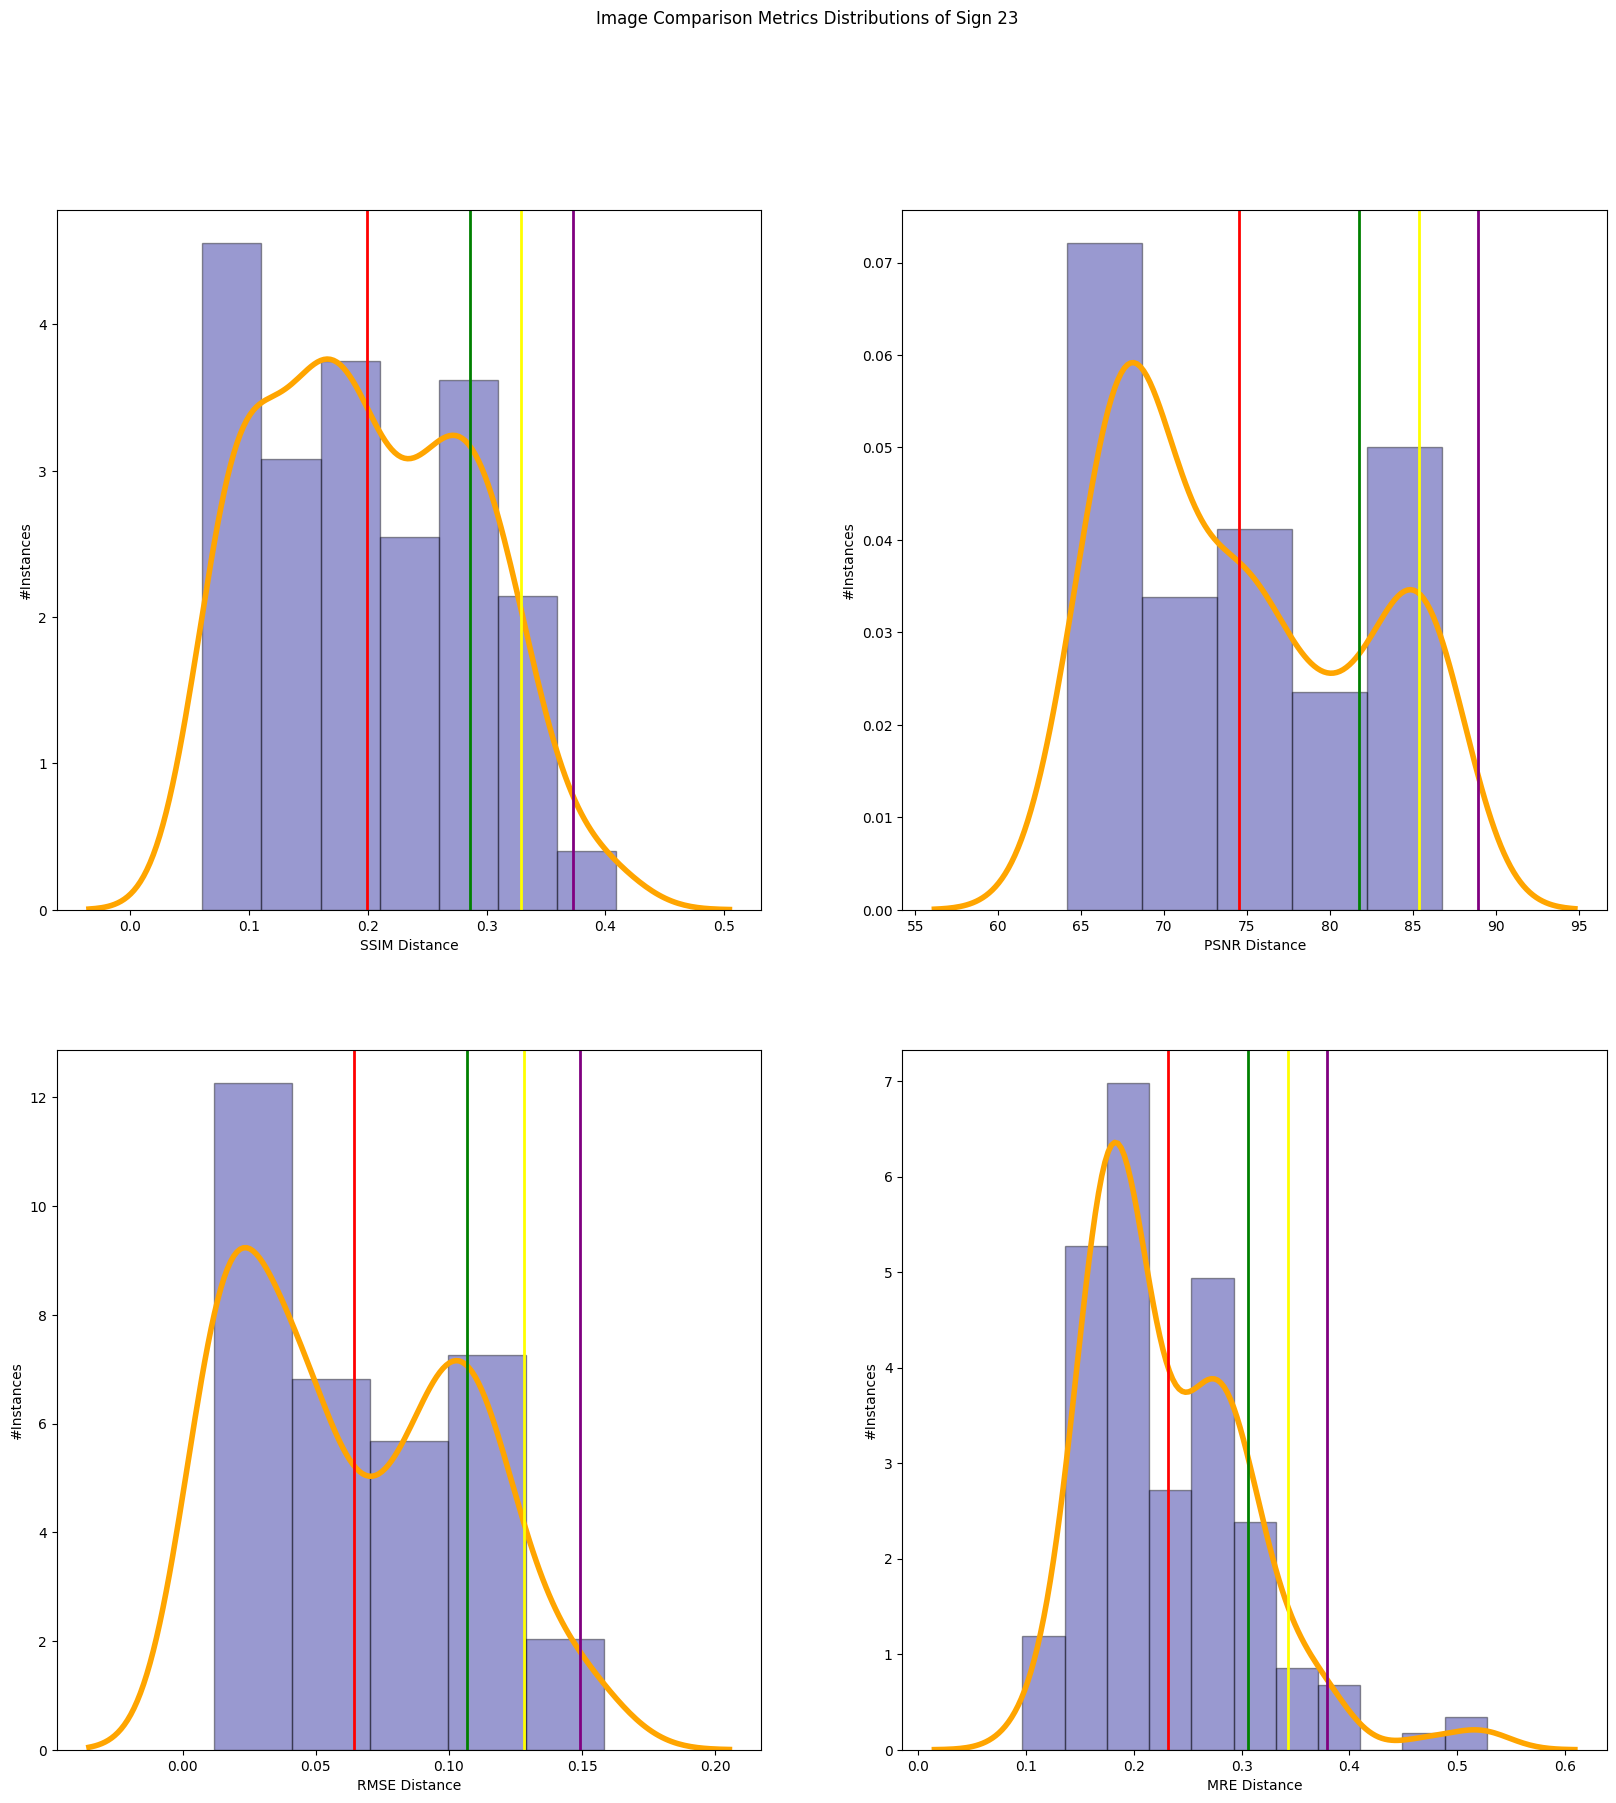

In [76]:
ssim, psnr, rmse, mre = testset(test_path23, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "23")

3/3 [==============================] - 0s 6ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.3145375476943122  ssim σ:  0.11698188172264672  ssim μ+σ:  0.4315194294169589
ssim μ+1.5σ:  0.49001037027828226  ssim μ+2σ:  0.5485013111396057
psnr mean:  70.58738043043348  psnr σ:  3.601144543810522  psnr μ+σ:  74.188524974244
psnr μ+1.5σ:  75.98909724614927  psnr μ+2σ:  77.78966951805452
rmse mean:  0.082734555  rmse σ:  0.03904887  rmse μ+σ:  0.12178342
rmse μ+1.5σ:  0.1413078587502241  rmse μ+2σ:  0.16083229333162308
mre mean:  0.31885922  mre σ:  0.12937887  mre μ+σ:  0.44823807
mre μ+1.5σ:  0.5129275247454643  mre μ+2σ:  0.577616959810257


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

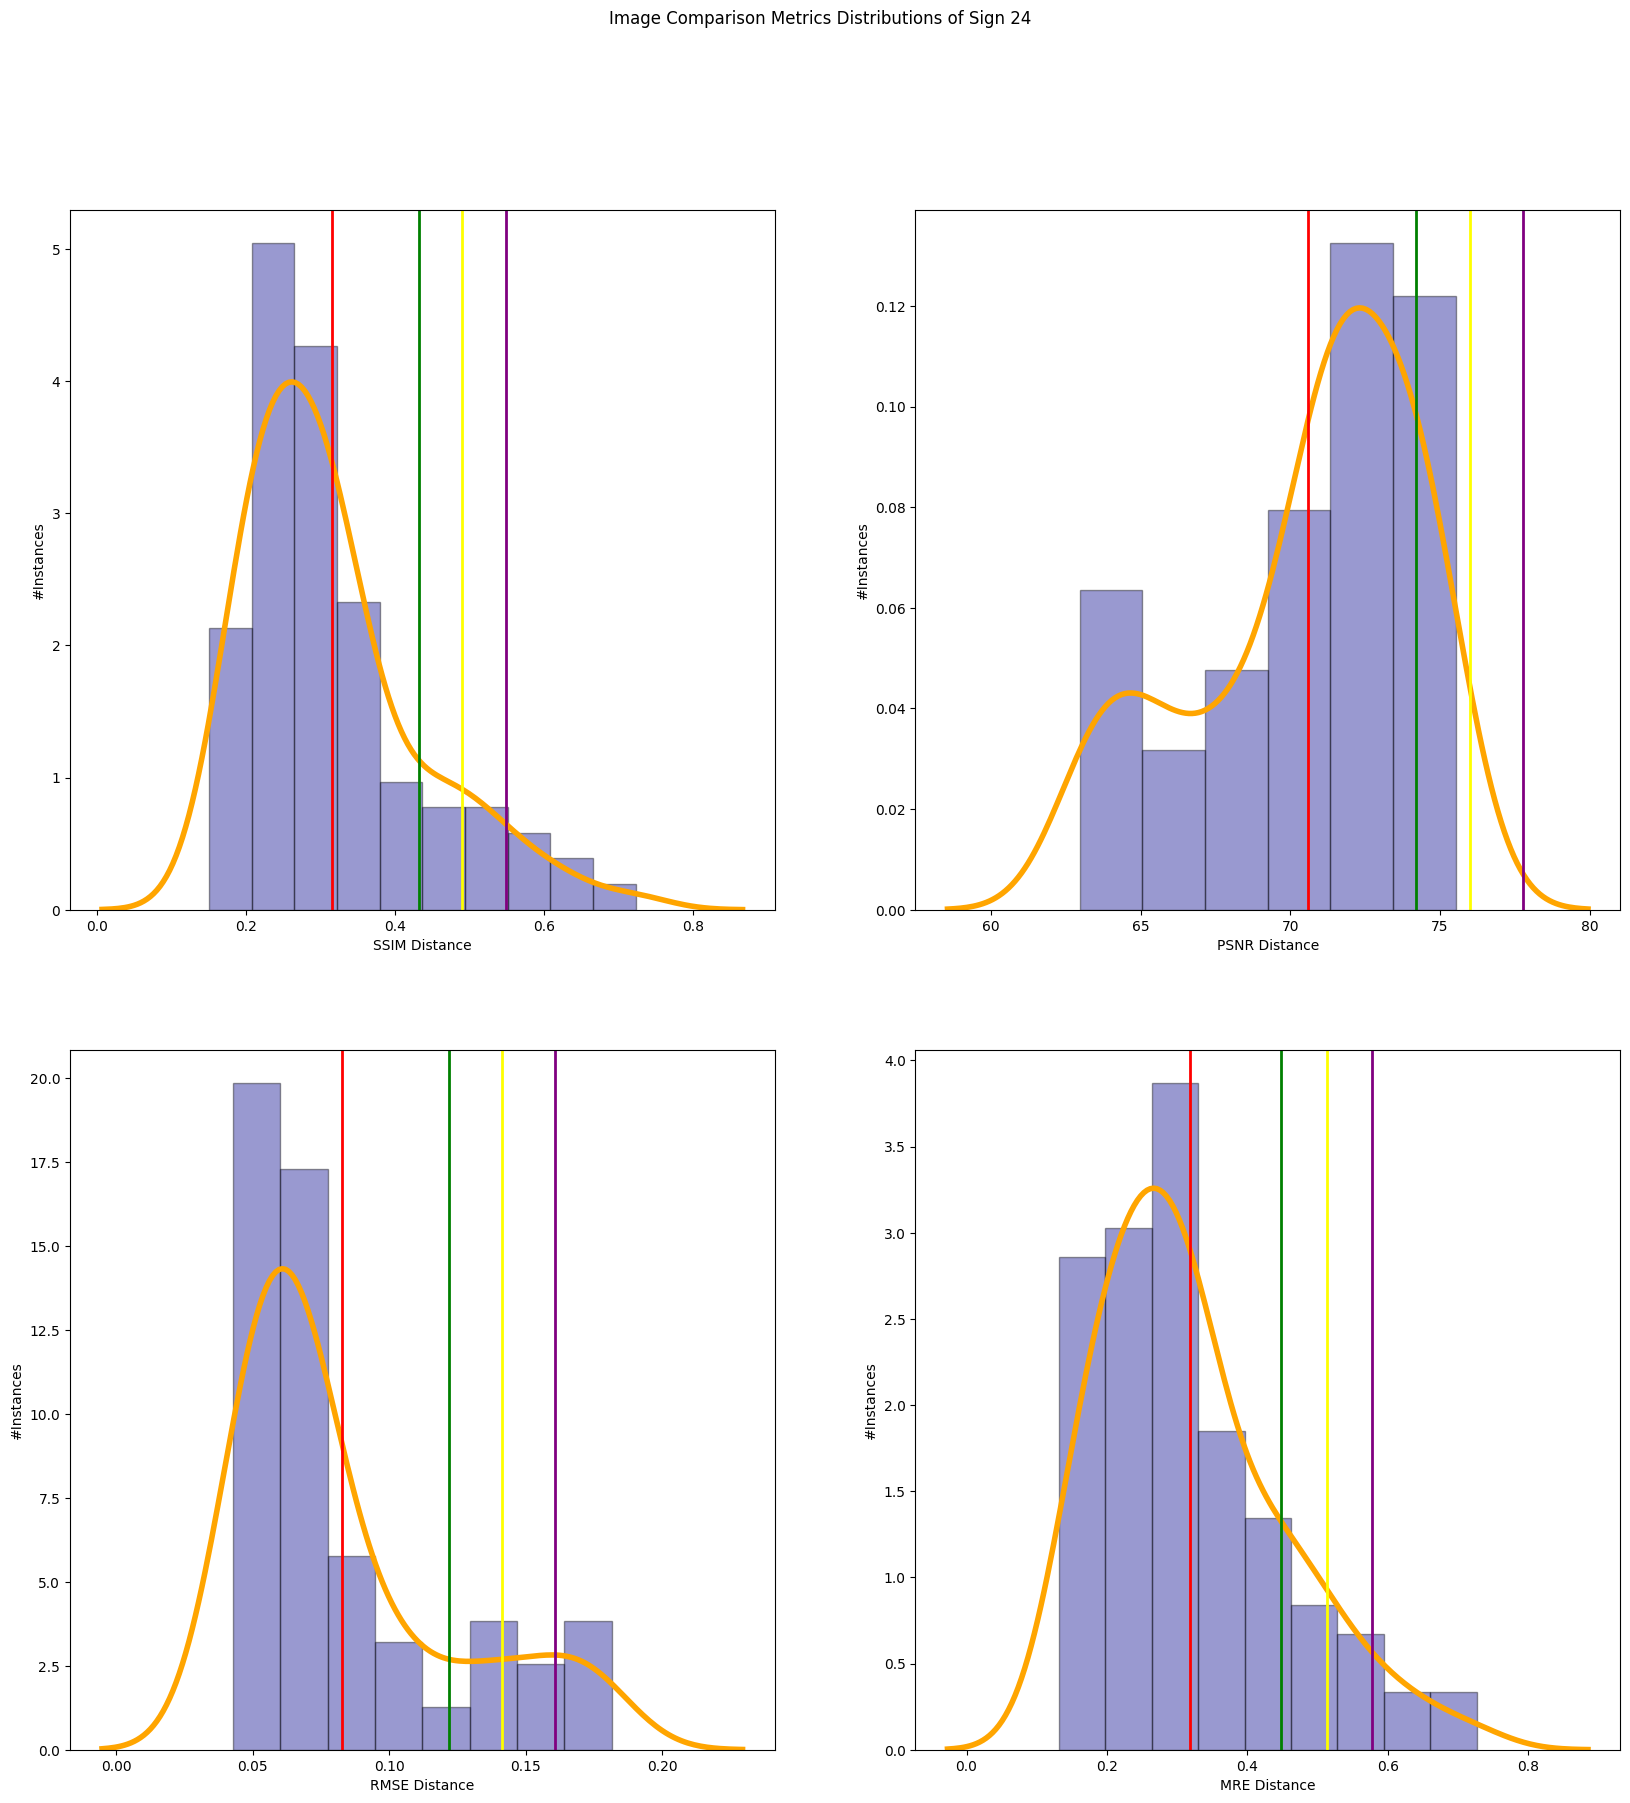

In [77]:
ssim, psnr, rmse, mre = testset(test_path24, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "24")

15/15 [==============================] - 0s 5ms/step
#Instances:  480
Destructor called, Employee deleted.
ssim mean:  0.24010431226342915  ssim σ:  0.10185669114271627  ssim μ+σ:  0.34196100340614544
ssim μ+1.5σ:  0.39288934897750355  ssim μ+2σ:  0.44381769454886166
psnr mean:  69.71396428743998  psnr σ:  4.442900699205951  psnr μ+σ:  74.15686498664593
psnr μ+1.5σ:  76.3783153362489  psnr μ+2σ:  78.59976568585188
rmse mean:  0.0924209  rmse σ:  0.034858402  rmse μ+σ:  0.1272793
rmse μ+1.5σ:  0.14470850117504597  rmse μ+2σ:  0.1621377021074295


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.25611678  mre σ:  0.082333885  mre μ+σ:  0.33845067
mre μ+1.5σ:  0.3796176053583622  mre μ+2σ:  0.4207845479249954


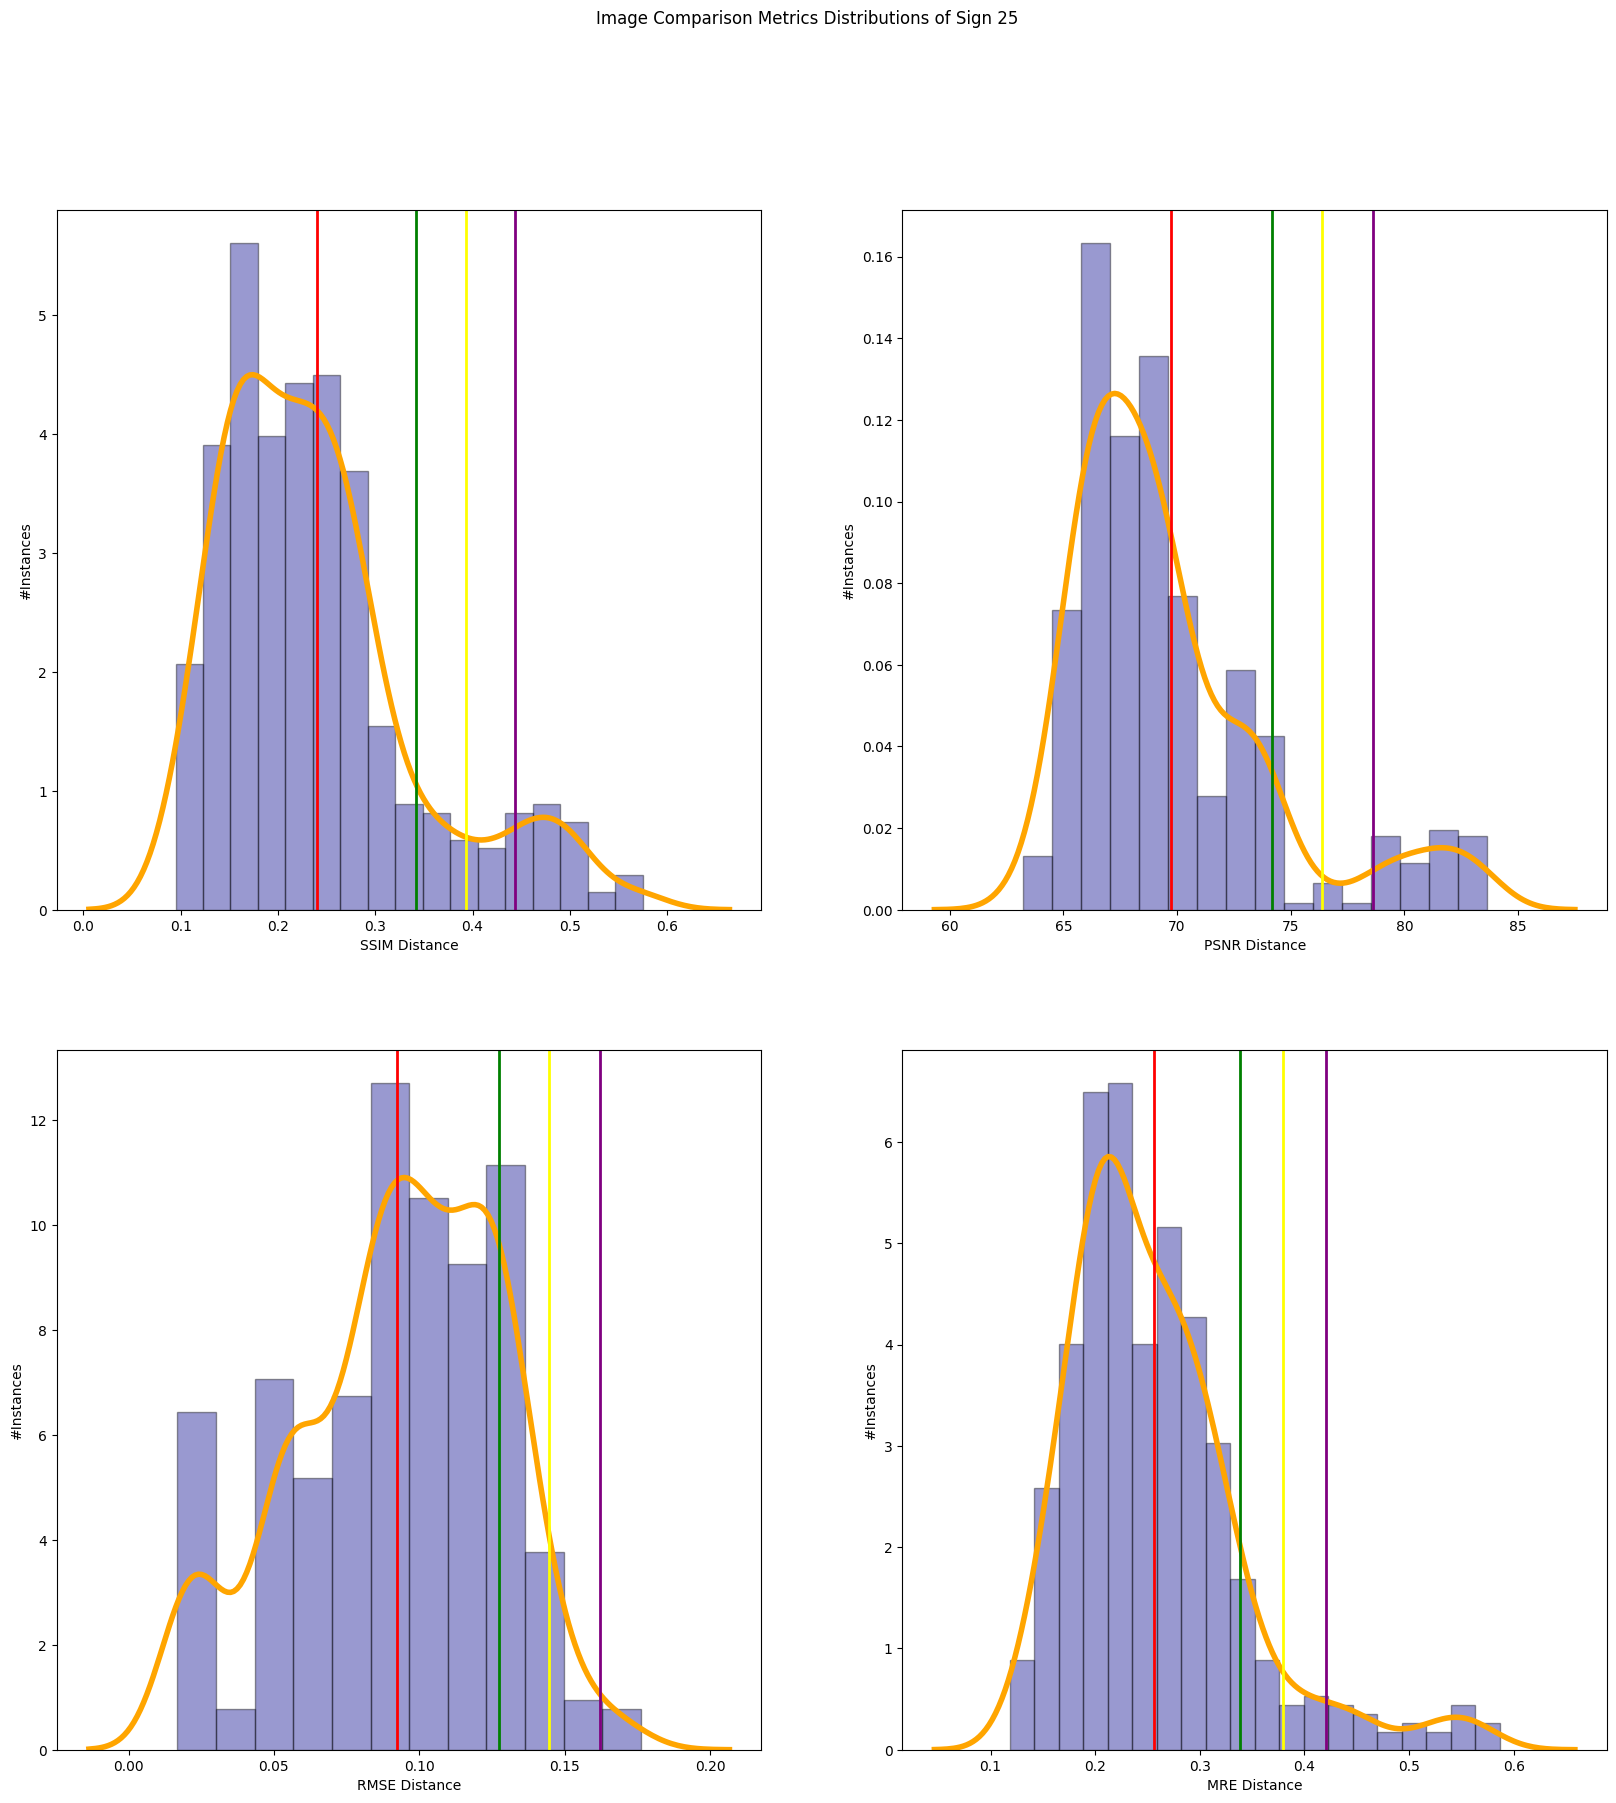

In [78]:
ssim, psnr, rmse, mre = testset(test_path25, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "25")

6/6 [==============================] - 0s 5ms/step
#Instances:  180
Destructor called, Employee deleted.
ssim mean:  0.1931282099750307  ssim σ:  0.09004977434528137  ssim μ+σ:  0.28317798432031205
ssim μ+1.5σ:  0.32820287149295274  ssim μ+2σ:  0.37322775866559343
psnr mean:  73.1495807647705  psnr σ:  3.1558901160391555  psnr μ+σ:  76.30547088080966
psnr μ+1.5σ:  77.88341593882924  psnr μ+2σ:  79.46136099684881
rmse mean:  0.05989815  rmse σ:  0.021827476  rmse μ+σ:  0.08172563
rmse μ+1.5σ:  0.09263936337083578  rmse μ+2σ:  0.10355310142040253
mre mean:  0.18847635  mre σ:  0.05616888  mre μ+σ:  0.24464524
mre μ+1.5σ:  0.2727296743541956  mre μ+2σ:  0.30081411451101303


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

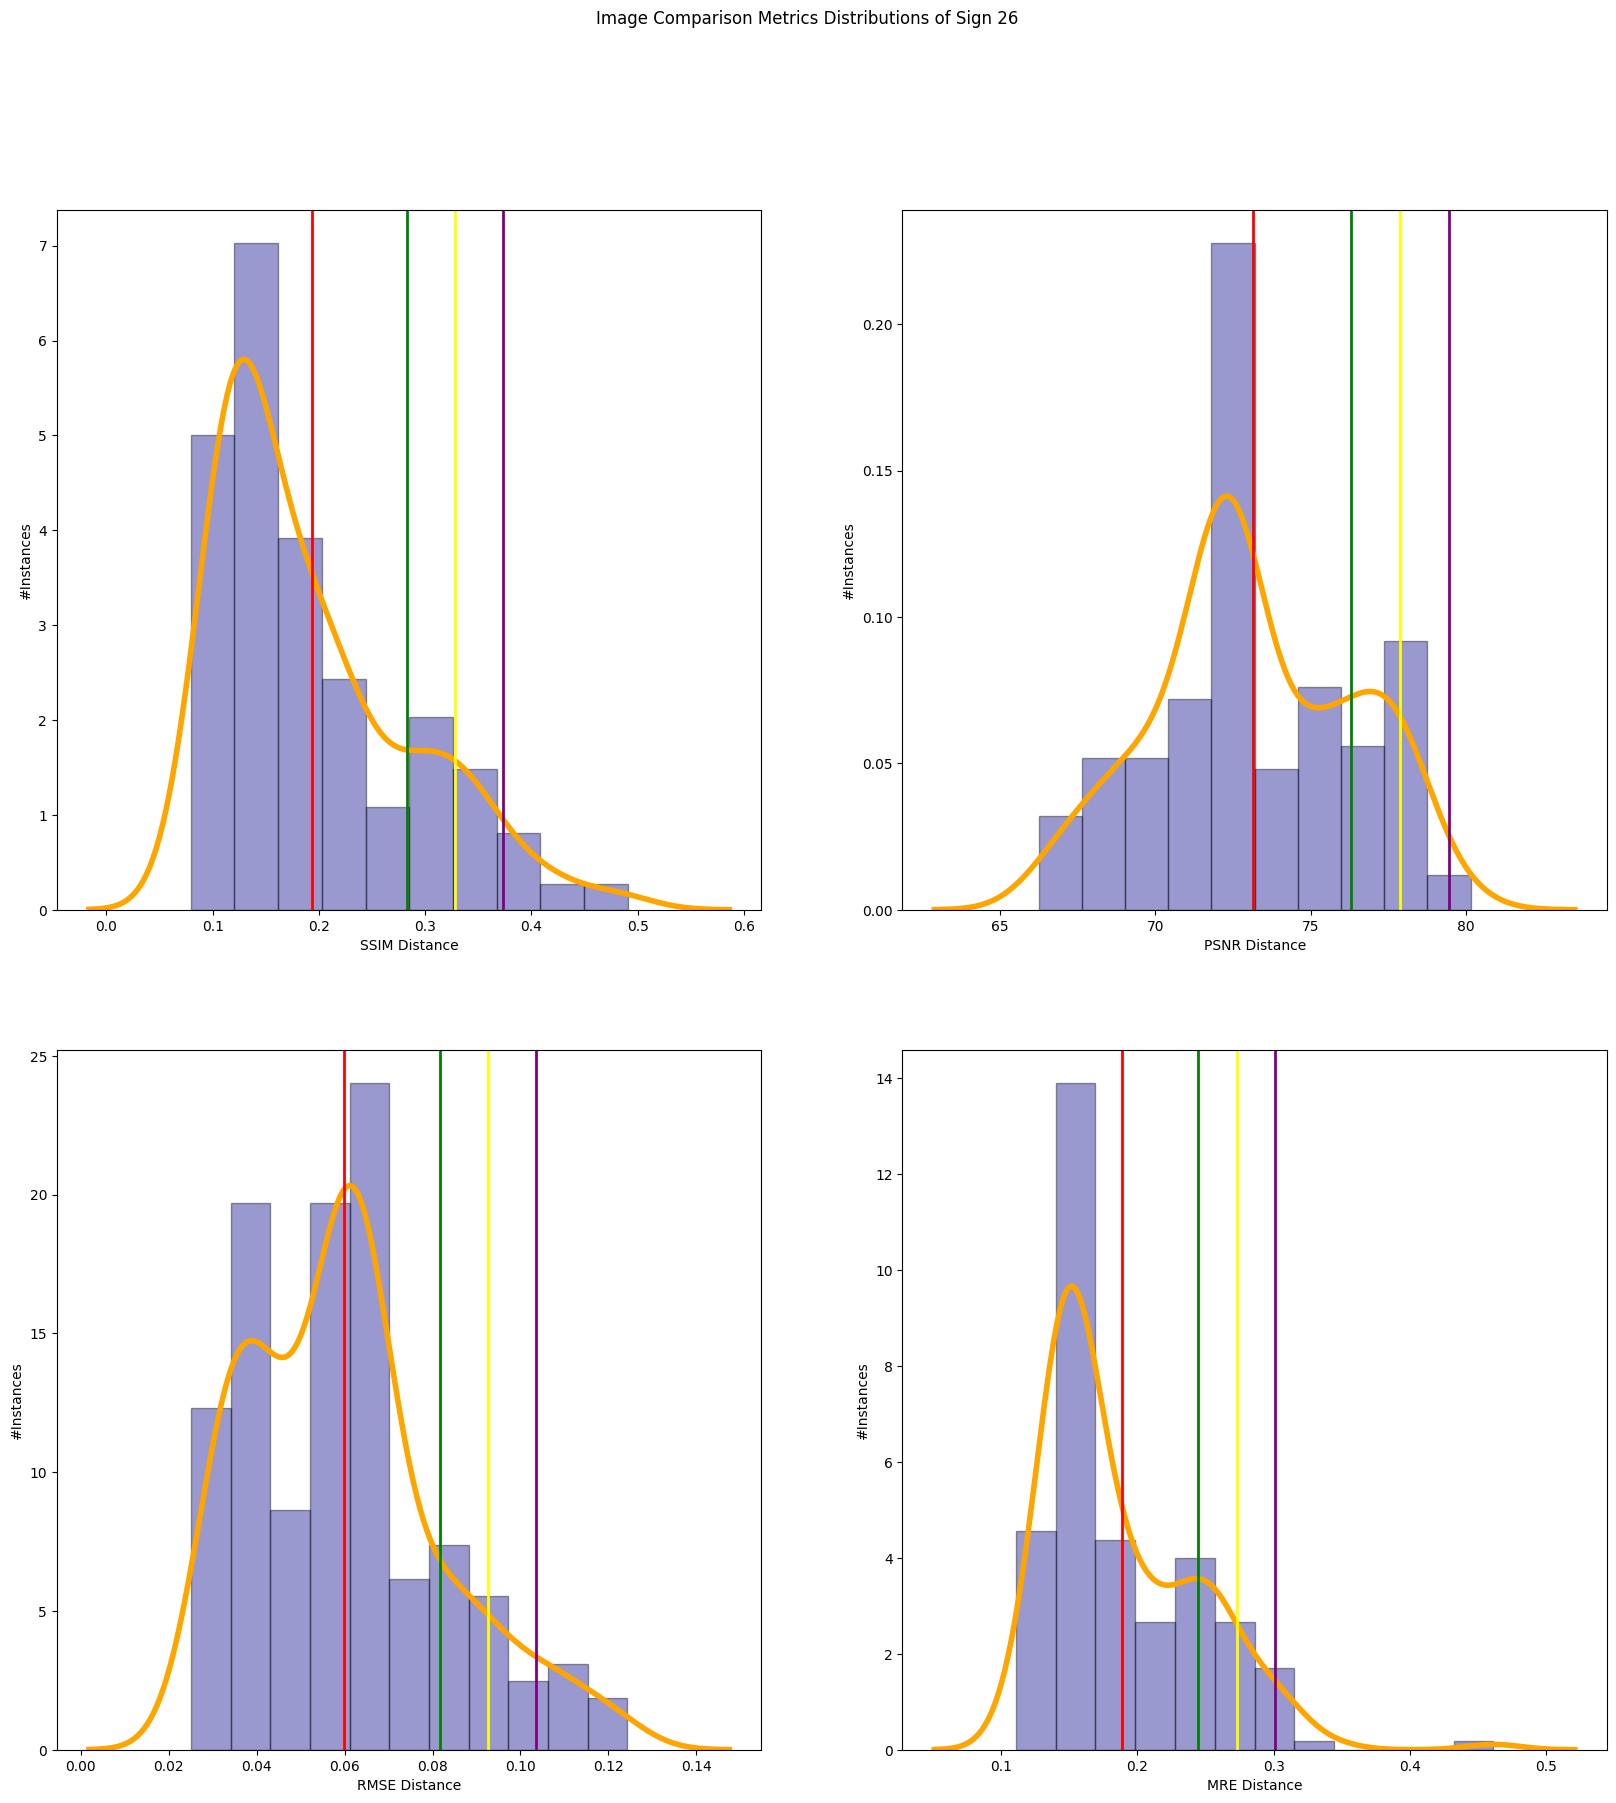

In [79]:
ssim, psnr, rmse, mre = testset(test_path26, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "26")

2/2 [==============================] - 0s 5ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.3303344652056694  ssim σ:  0.16663658190867855  ssim μ+σ:  0.4969710471143479
ssim μ+1.5σ:  0.5802893380686872  ssim μ+2σ:  0.6636076290230265
psnr mean:  68.57147420247396  psnr σ:  5.171560465279585  psnr μ+σ:  73.74303466775355
psnr μ+1.5σ:  76.32881490039334  psnr μ+2σ:  78.91459513303313
rmse mean:  0.1114613  rmse σ:  0.056045808  rmse μ+σ:  0.16750711
rmse μ+1.5σ:  0.1955300085246563  rmse μ+2σ:  0.2235529124736786
mre mean:  0.69046855  mre σ:  0.52817947  mre μ+σ:  1.218648
mre μ+1.5σ:  1.4827377498149872  mre μ+2σ:  1.746827483177185


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

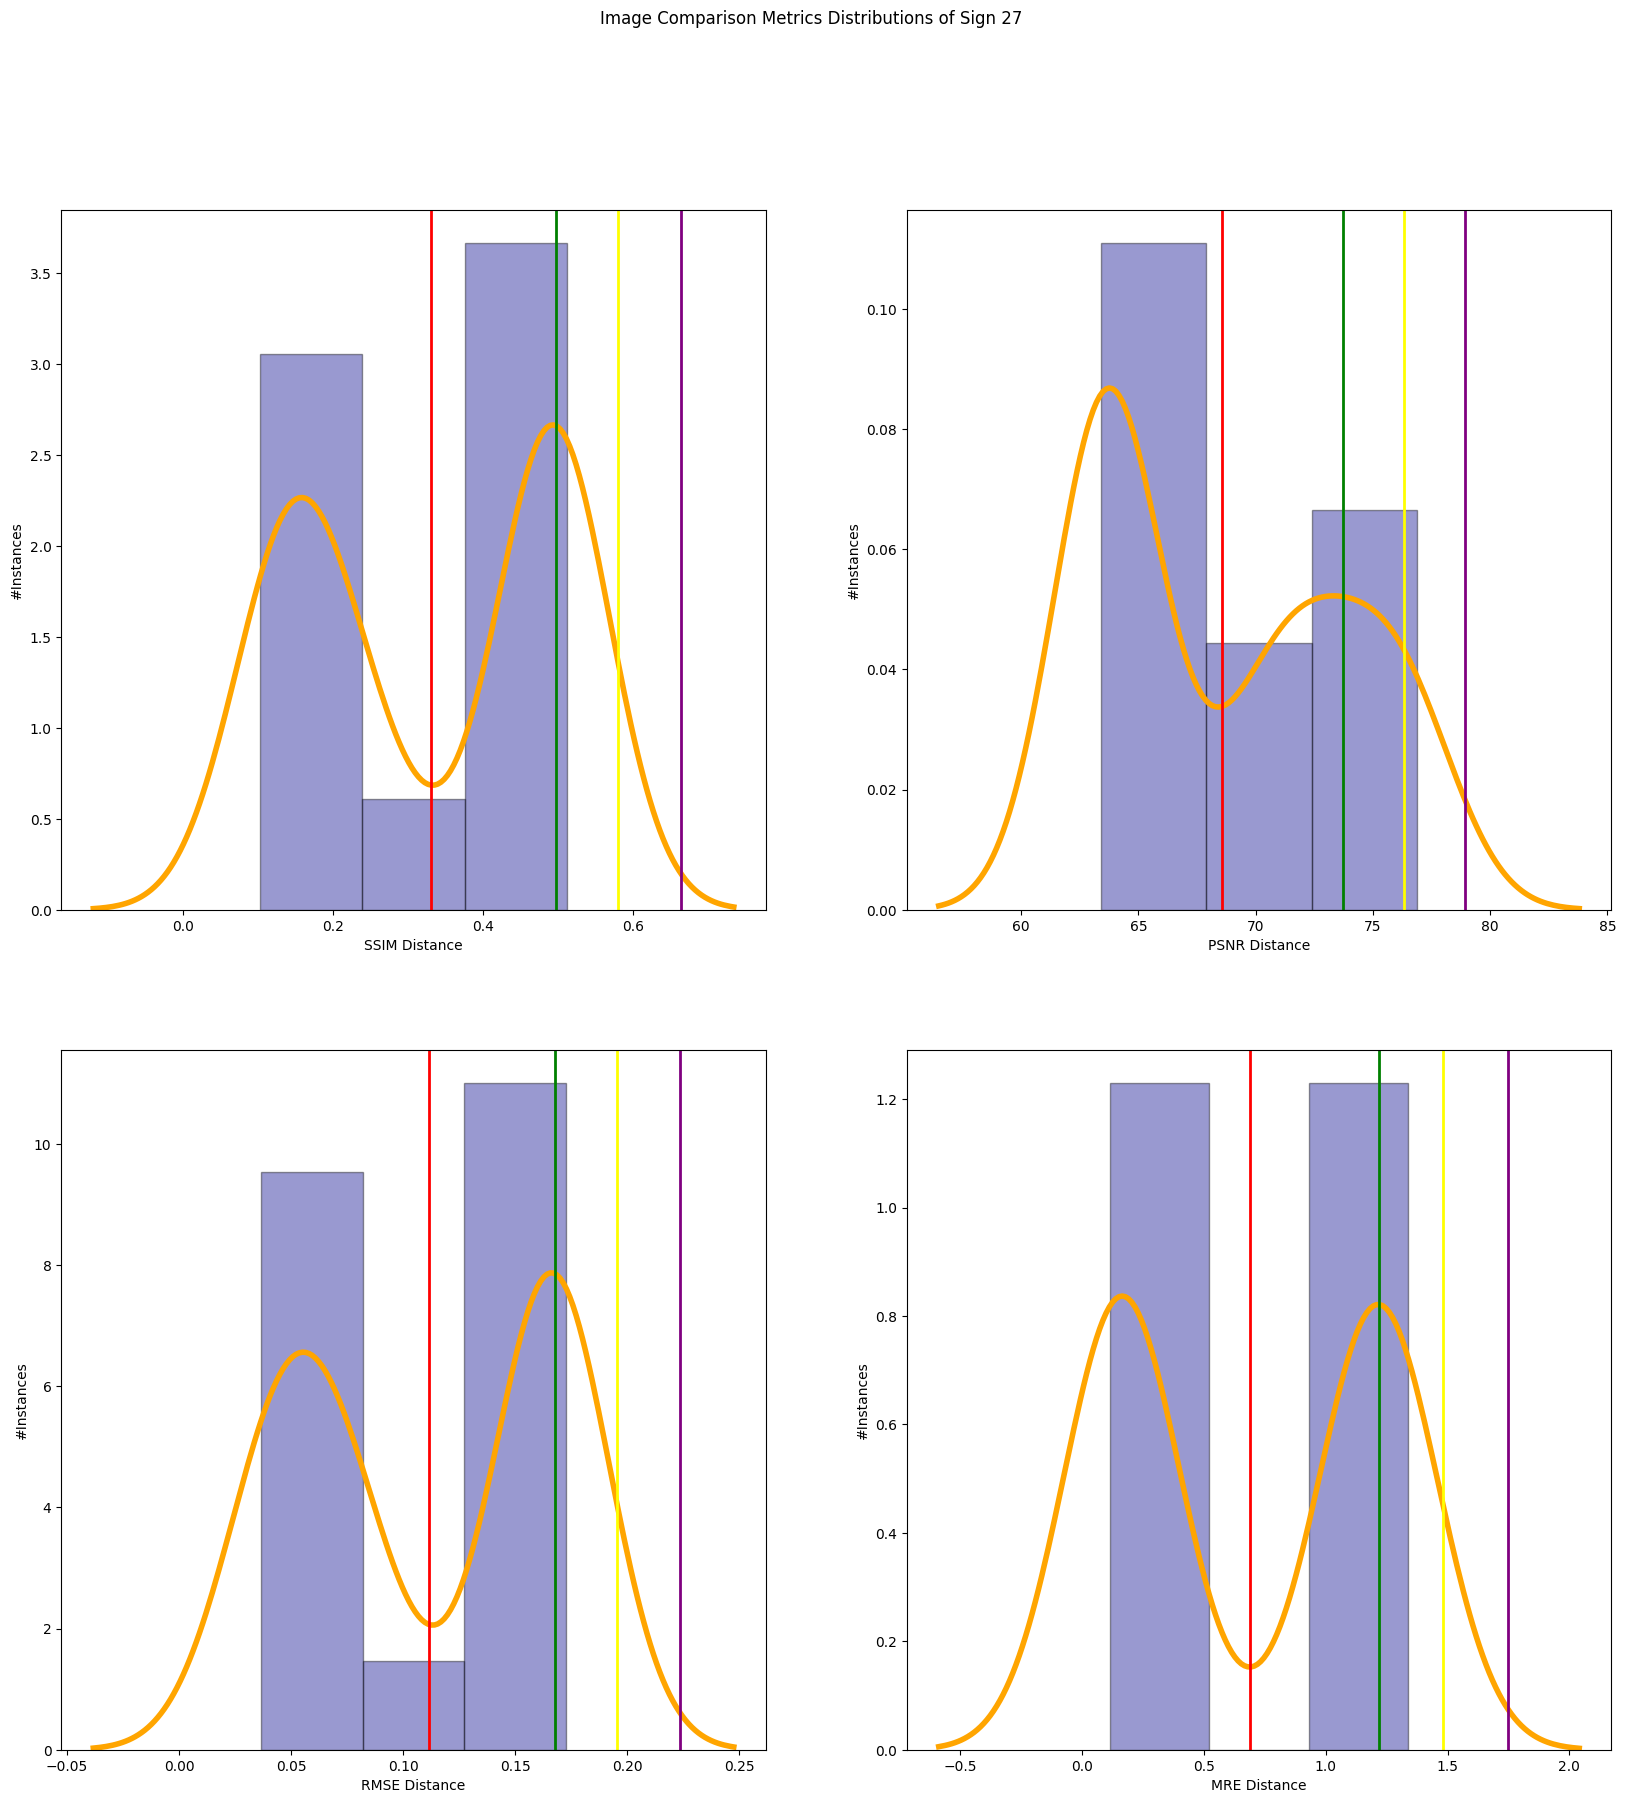

In [80]:
ssim, psnr, rmse, mre = testset(test_path27, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "27")

5/5 [==============================] - 0s 6ms/step
#Instances:  150
Destructor called, Employee deleted.
ssim mean:  0.2319933299223582  ssim σ:  0.09488966018211664  ssim μ+σ:  0.32688299010447486
ssim μ+1.5σ:  0.3743278201955331  ssim μ+2σ:  0.4217726502865915


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],


psnr mean:  69.69476638793945  psnr σ:  5.047519696006426  psnr μ+σ:  74.74228608394588
psnr μ+1.5σ:  77.2660459319491  psnr μ+2σ:  79.7898057799523
rmse mean:  0.095222294  rmse σ:  0.038226455  rmse μ+σ:  0.13344875
rmse μ+1.5σ:  0.1525619775056839  rmse μ+2σ:  0.1716752052307129
mre mean:  0.23279892  mre σ:  0.08917207  mre μ+σ:  0.321971
mre μ+1.5σ:  0.366557028144598  mre μ+2σ:  0.41114306449890137


/tmp/ipykernel_122393/2660218213.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(rmse_vals, hist=True, kde=True, ax=axes[1,0],
/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


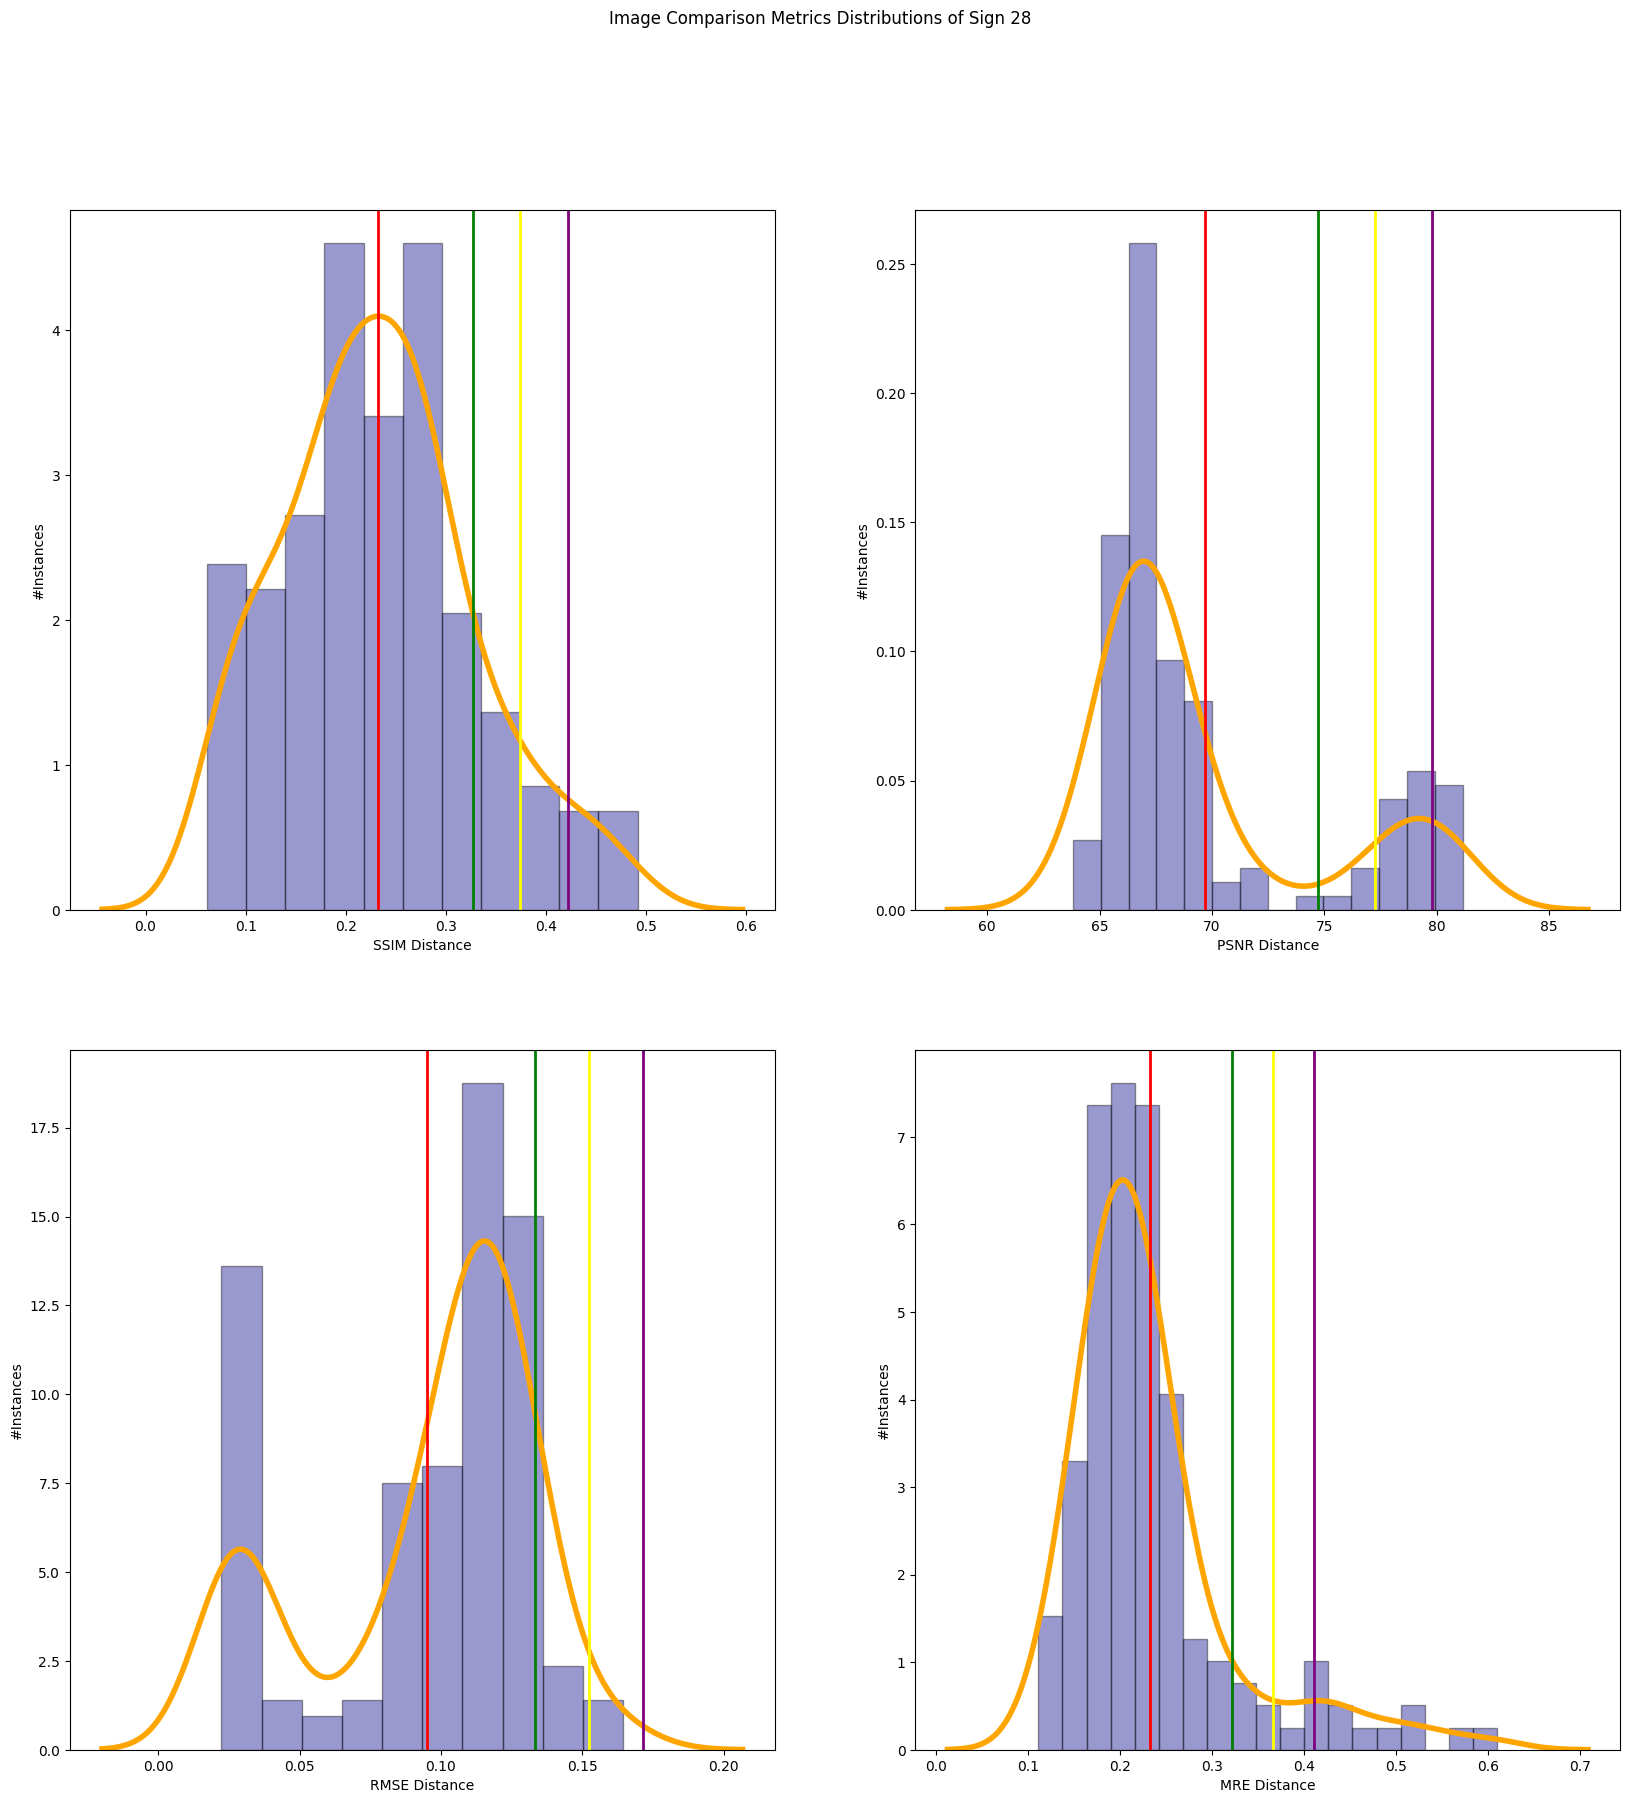

In [81]:
ssim, psnr, rmse, mre = testset(test_path28, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "28")

3/3 [==============================] - 0s 5ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.28078946669896443  ssim σ:  0.06879834149130326  ssim μ+σ:  0.3495878081902677
ssim μ+1.5σ:  0.3839869789359193  ssim μ+2σ:  0.41838614968157095
psnr mean:  68.89963472154406  psnr σ:  4.123025495498524  psnr μ+σ:  73.02266021704258
psnr μ+1.5σ:  75.08417296479185  psnr μ+2σ:  77.14568571254111
rmse mean:  0.10143347  rmse σ:  0.04229567  rmse μ+σ:  0.14372914
rmse μ+1.5σ:  0.16487697325646877  rmse μ+2σ:  0.18602480739355087
mre mean:  0.26516533  mre σ:  0.0698235  mre μ+σ:  0.33498883
mre μ+1.5σ:  0.36990058422088623  mre μ+2σ:  0.4048123359680176


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

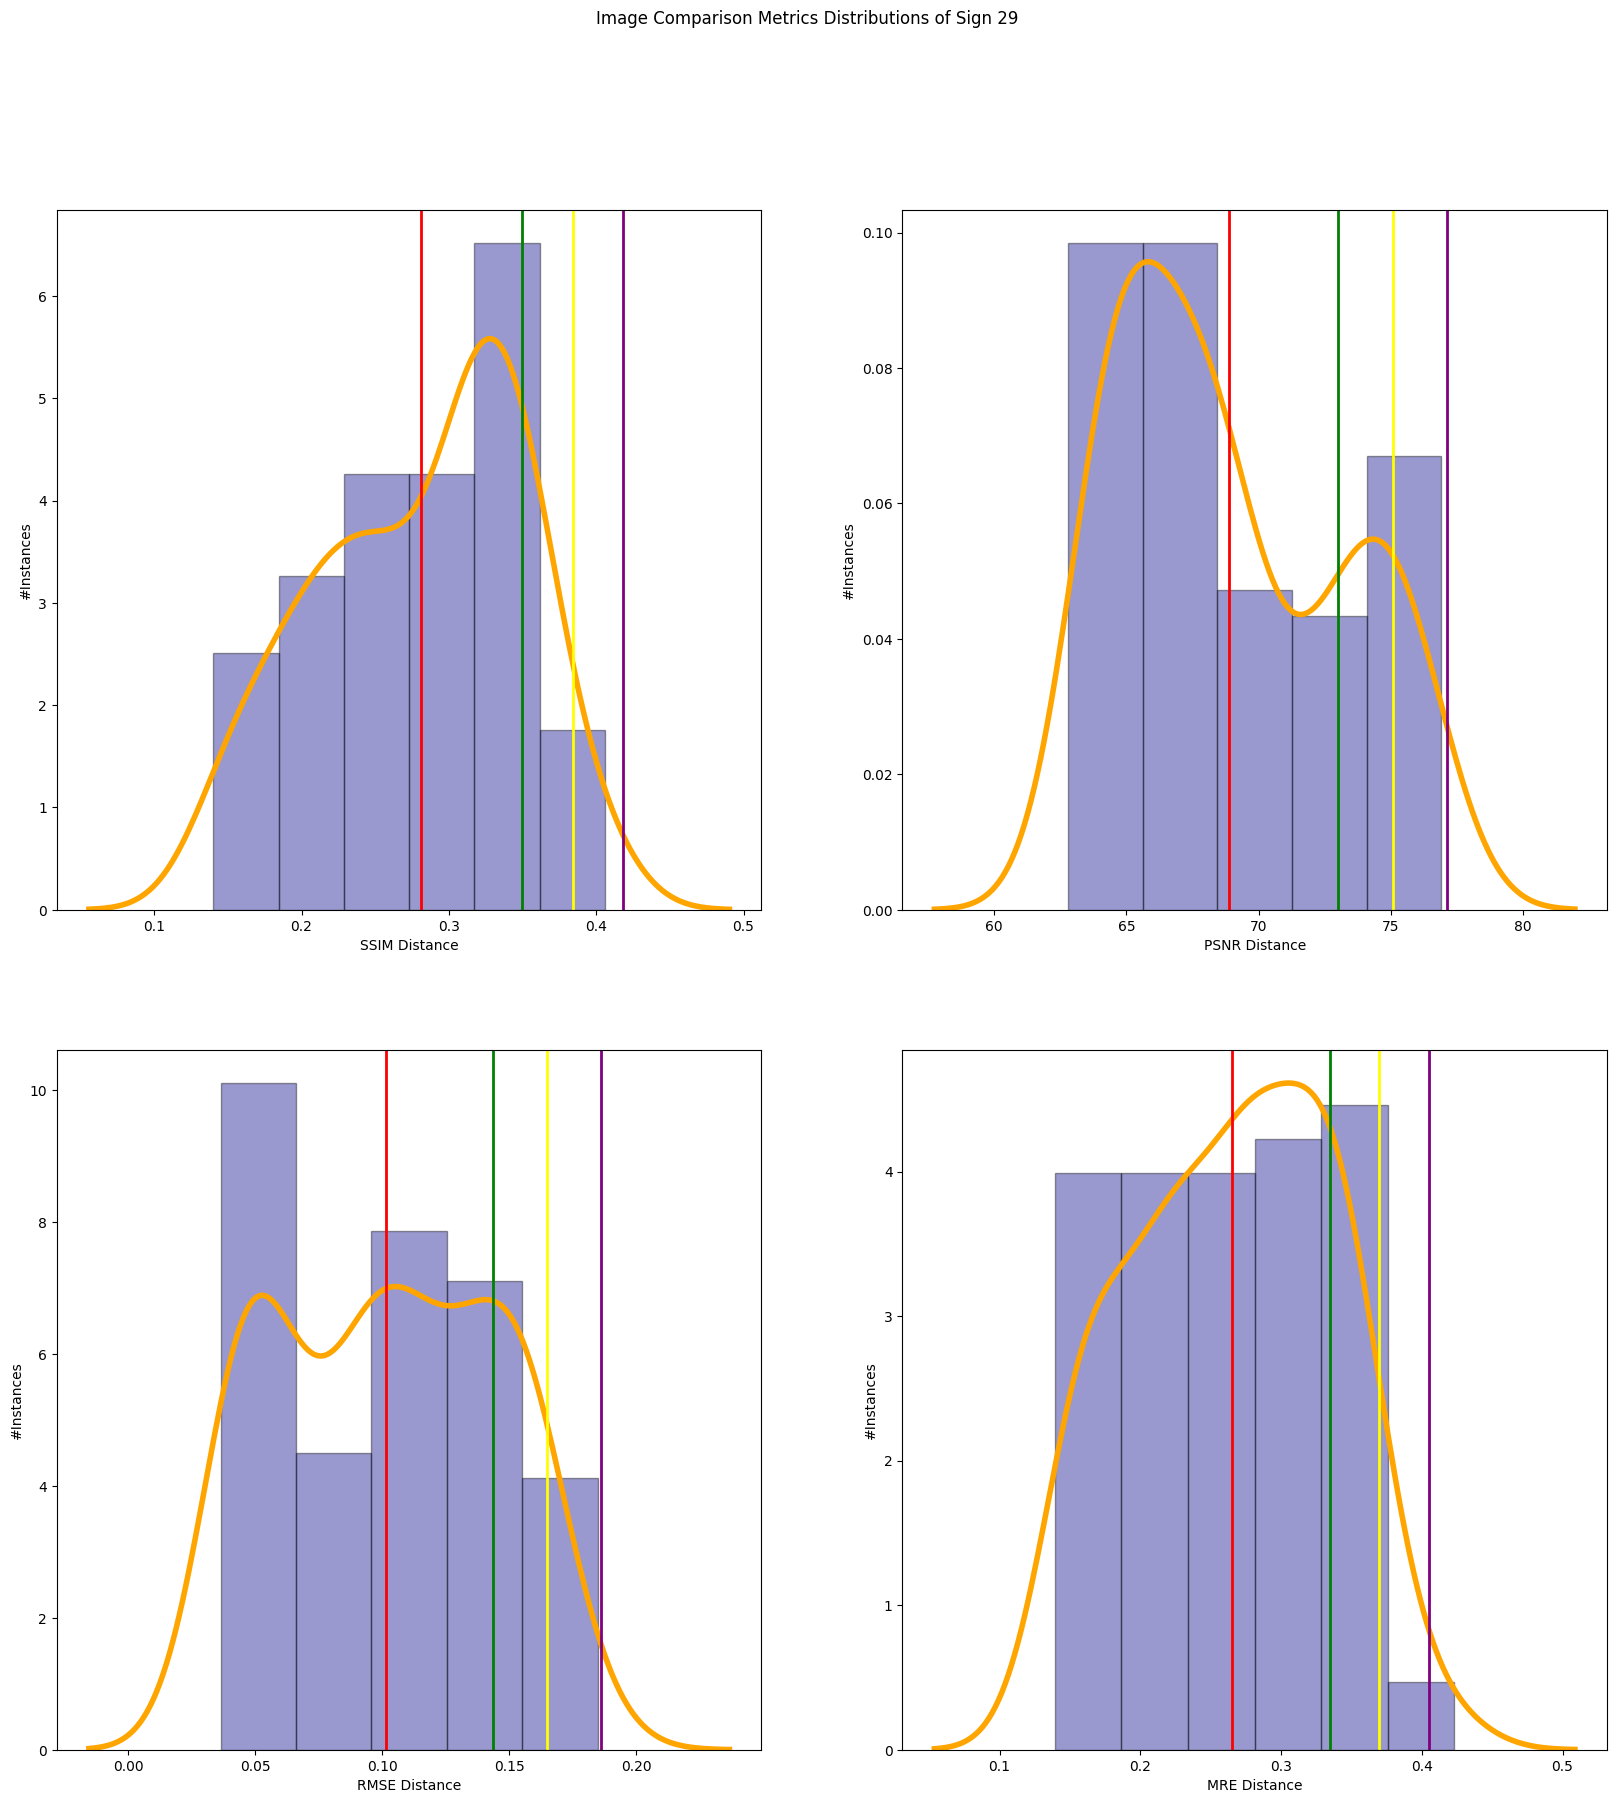

In [82]:
ssim, psnr, rmse, mre = testset(test_path29, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "29")

5/5 [==============================] - 0s 5ms/step
#Instances:  150
Destructor called, Employee deleted.
ssim mean:  0.16282184104124706  ssim σ:  0.07778106324957455  ssim μ+σ:  0.2406029042908216
ssim μ+1.5σ:  0.2794934359156089  ssim μ+2σ:  0.31838396754039616
psnr mean:  78.64628992716472  psnr σ:  6.061228539652188  psnr μ+σ:  84.70751846681691
psnr μ+1.5σ:  87.738132736643  psnr μ+2σ:  90.76874700646908
rmse mean:  0.03940477  rmse σ:  0.033263974  rmse μ+σ:  0.072668746
rmse μ+1.5σ:  0.0893007293343544  rmse μ+2σ:  0.10593271628022194
mre mean:  0.16047709  mre σ:  0.053860903  mre μ+σ:  0.21433799
mre μ+1.5σ:  0.24126844108104706  mre μ+2σ:  0.2681988924741745


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

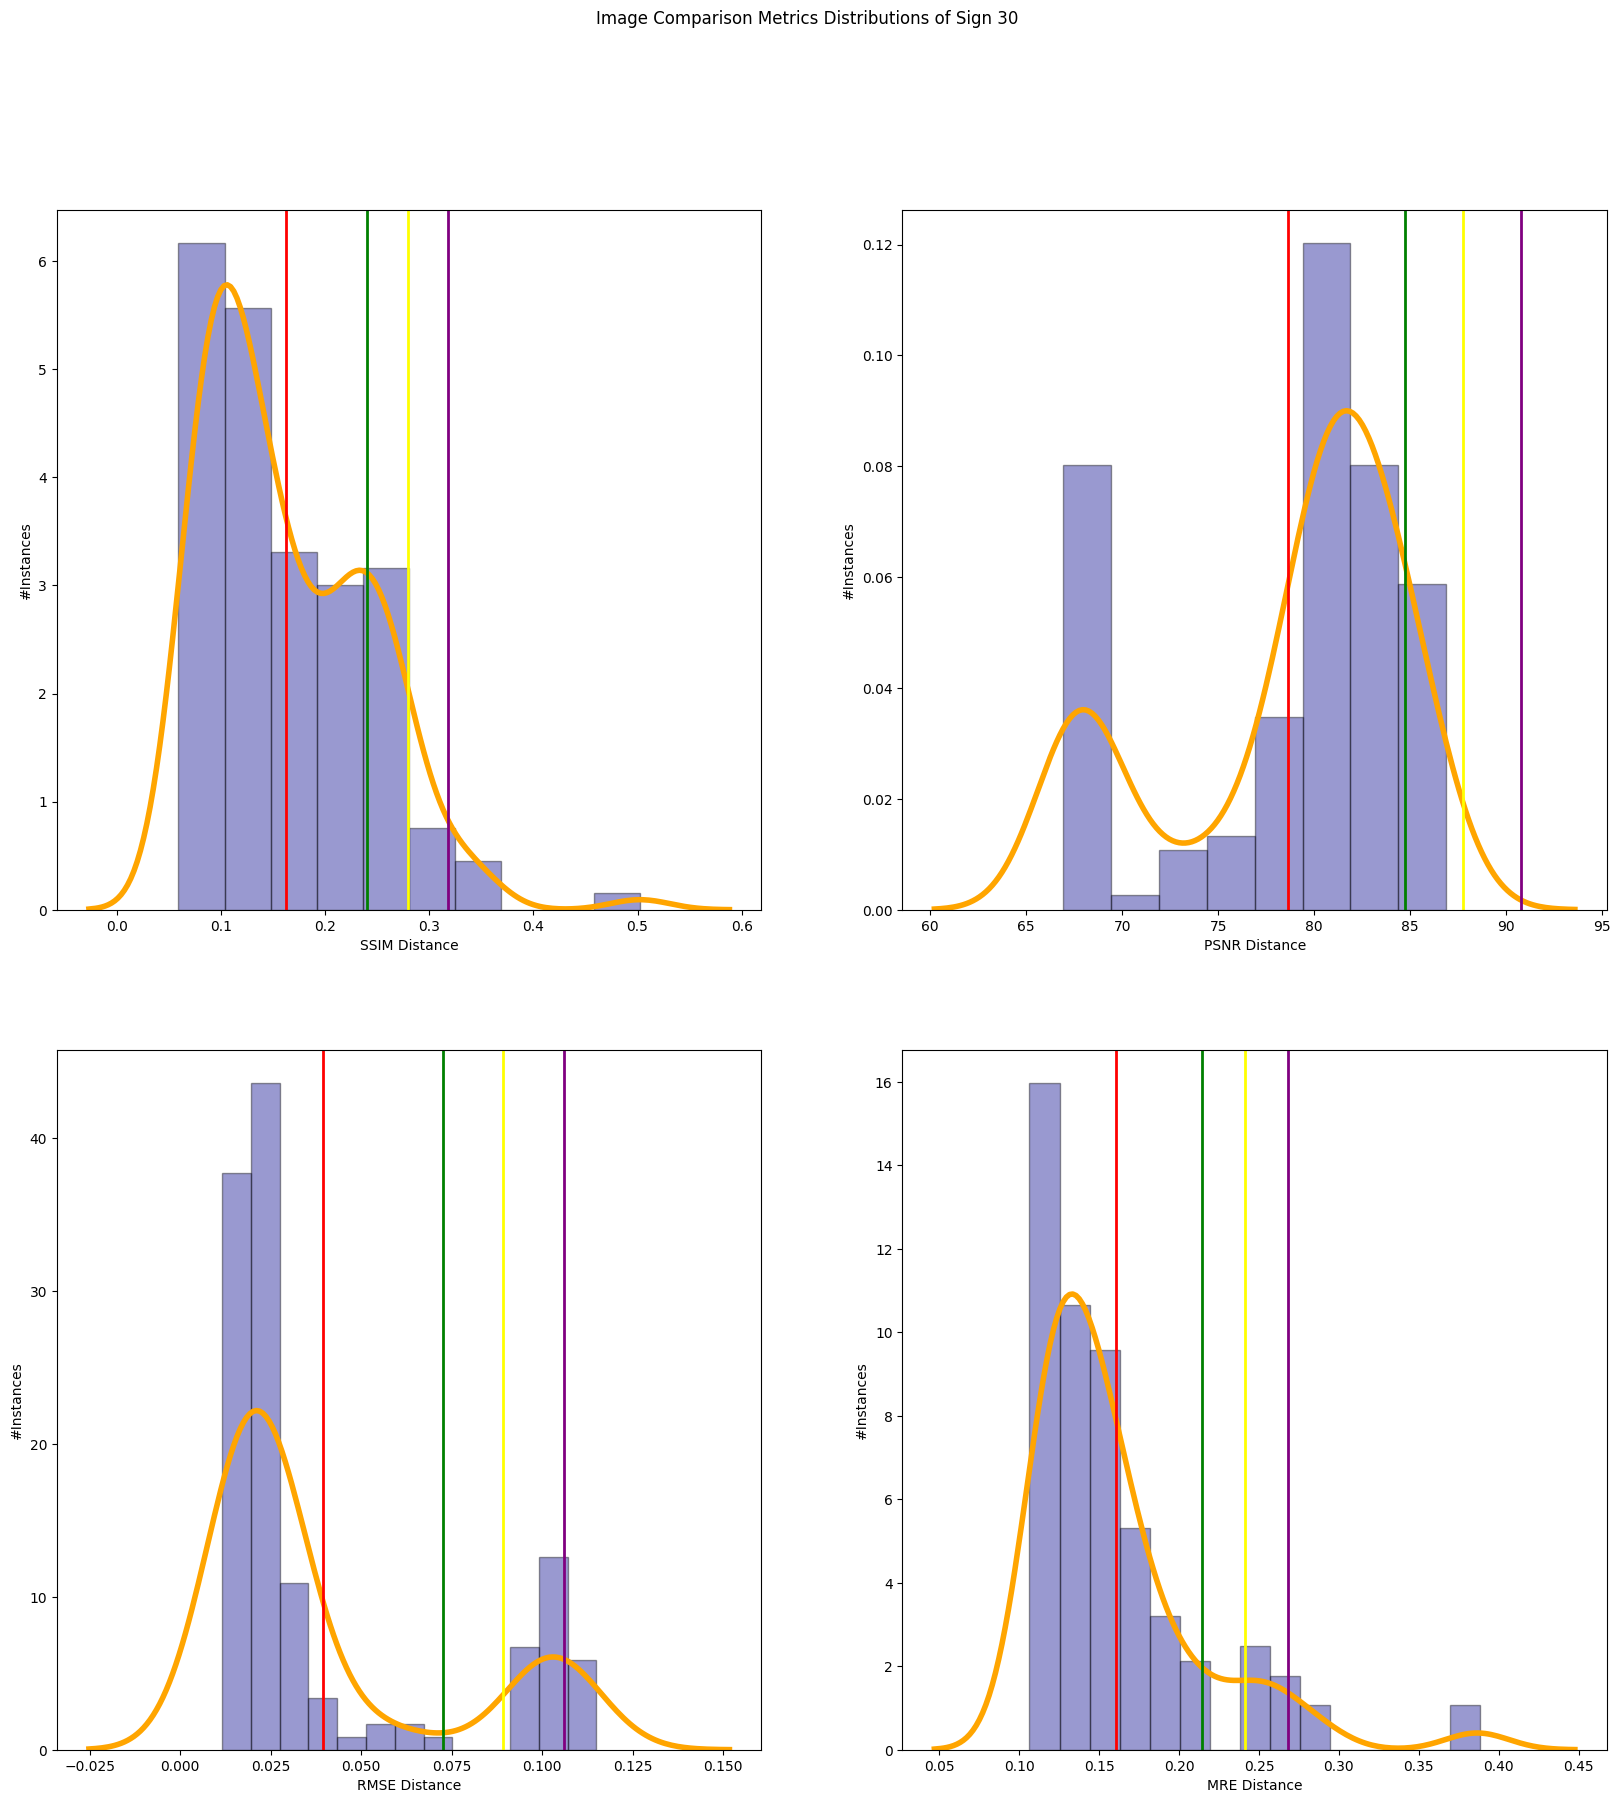

In [83]:
ssim, psnr, rmse, mre = testset(test_path30, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "30")

9/9 [==============================] - 0s 5ms/step
#Instances:  270
Destructor called, Employee deleted.
ssim mean:  0.0921067304081387  ssim σ:  0.03703833495092243  ssim μ+σ:  0.12914506535906112
ssim μ+1.5σ:  0.14766423283452235  ssim μ+2σ:  0.16618340030998358
psnr mean:  80.90070320411965  psnr σ:  3.7284686623126806  psnr μ+σ:  84.62917186643233
psnr μ+1.5σ:  86.49340619758867  psnr μ+2σ:  88.35764052874501
rmse mean:  0.025210949  rmse σ:  0.01098129  rmse μ+σ:  0.03619224
rmse μ+1.5σ:  0.04168288316577673  rmse μ+2σ:  0.047173528000712395


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.14018765  mre σ:  0.033284936  mre μ+σ:  0.17347258
mre μ+1.5σ:  0.19011505506932735  mre μ+2σ:  0.20675752311944962


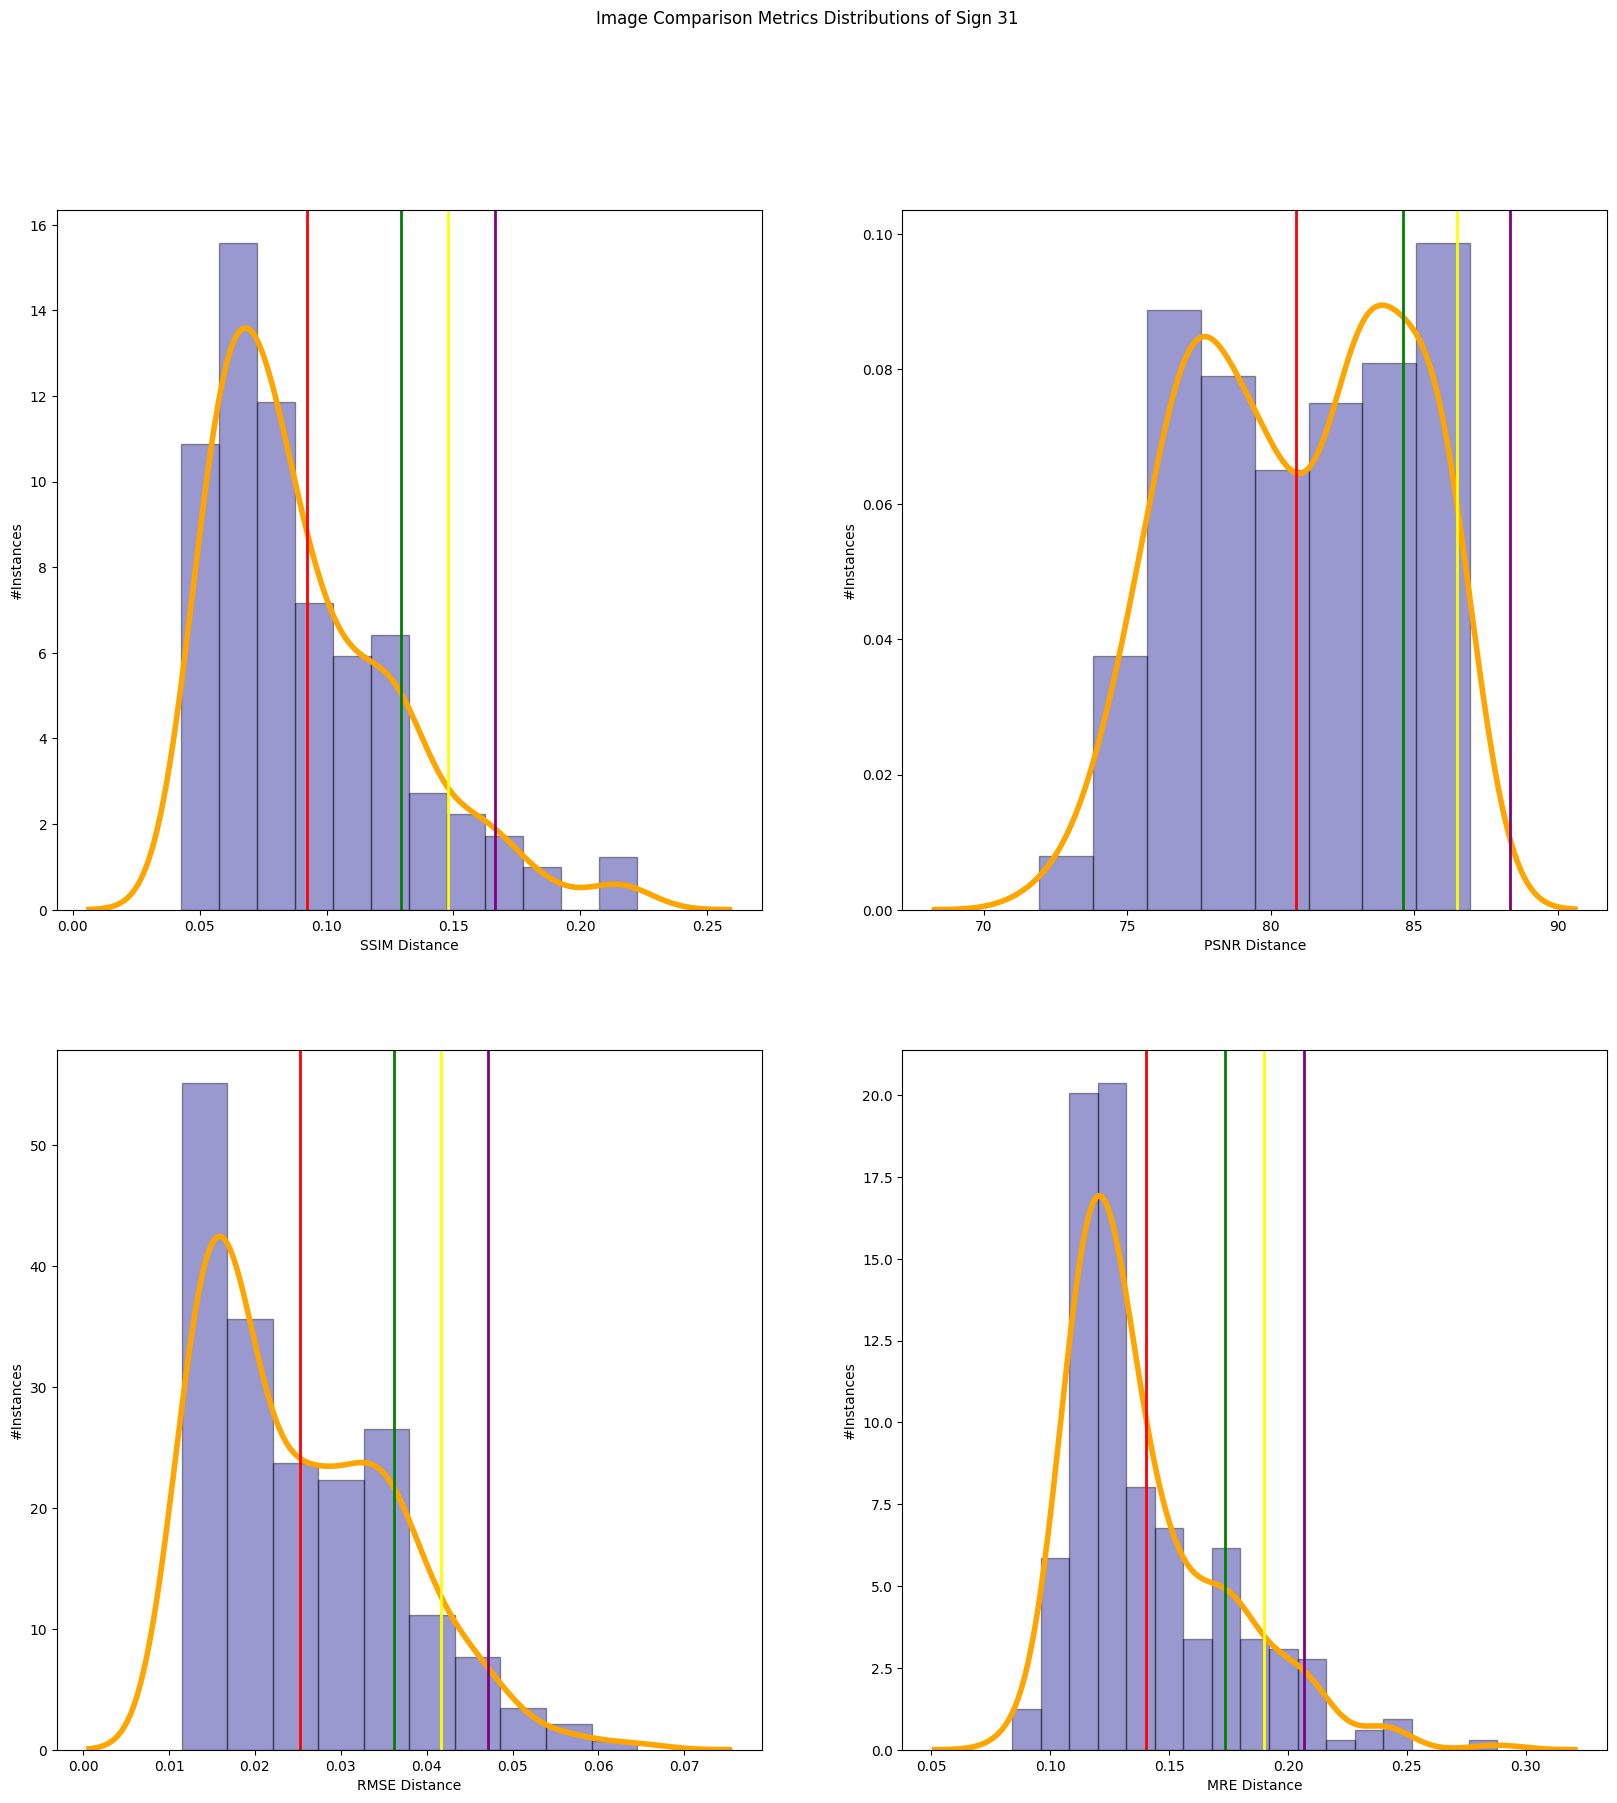

In [84]:
ssim, psnr, rmse, mre = testset(test_path31, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "31")

2/2 [==============================] - 0s 8ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.13288250068823496  ssim σ:  0.08121411881731319  ssim μ+σ:  0.21409661950554815
ssim μ+1.5σ:  0.25470367891420476  ssim μ+2σ:  0.29531073832286137
psnr mean:  75.44965070088705  psnr σ:  6.738088901102891  psnr μ+σ:  82.18773960198993
psnr μ+1.5σ:  85.55678405254139  psnr μ+2σ:  88.92582850309283
rmse mean:  0.056590416  rmse σ:  0.036732834  rmse μ+σ:  0.093323246
rmse μ+1.5σ:  0.11168966628611088  rmse μ+2σ:  0.13005608320236206
mre mean:  0.14475875  mre σ:  0.060404766  mre μ+σ:  0.20516351
mre μ+1.5σ:  0.23536589555442333  mre μ+2σ:  0.2655682787299156


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

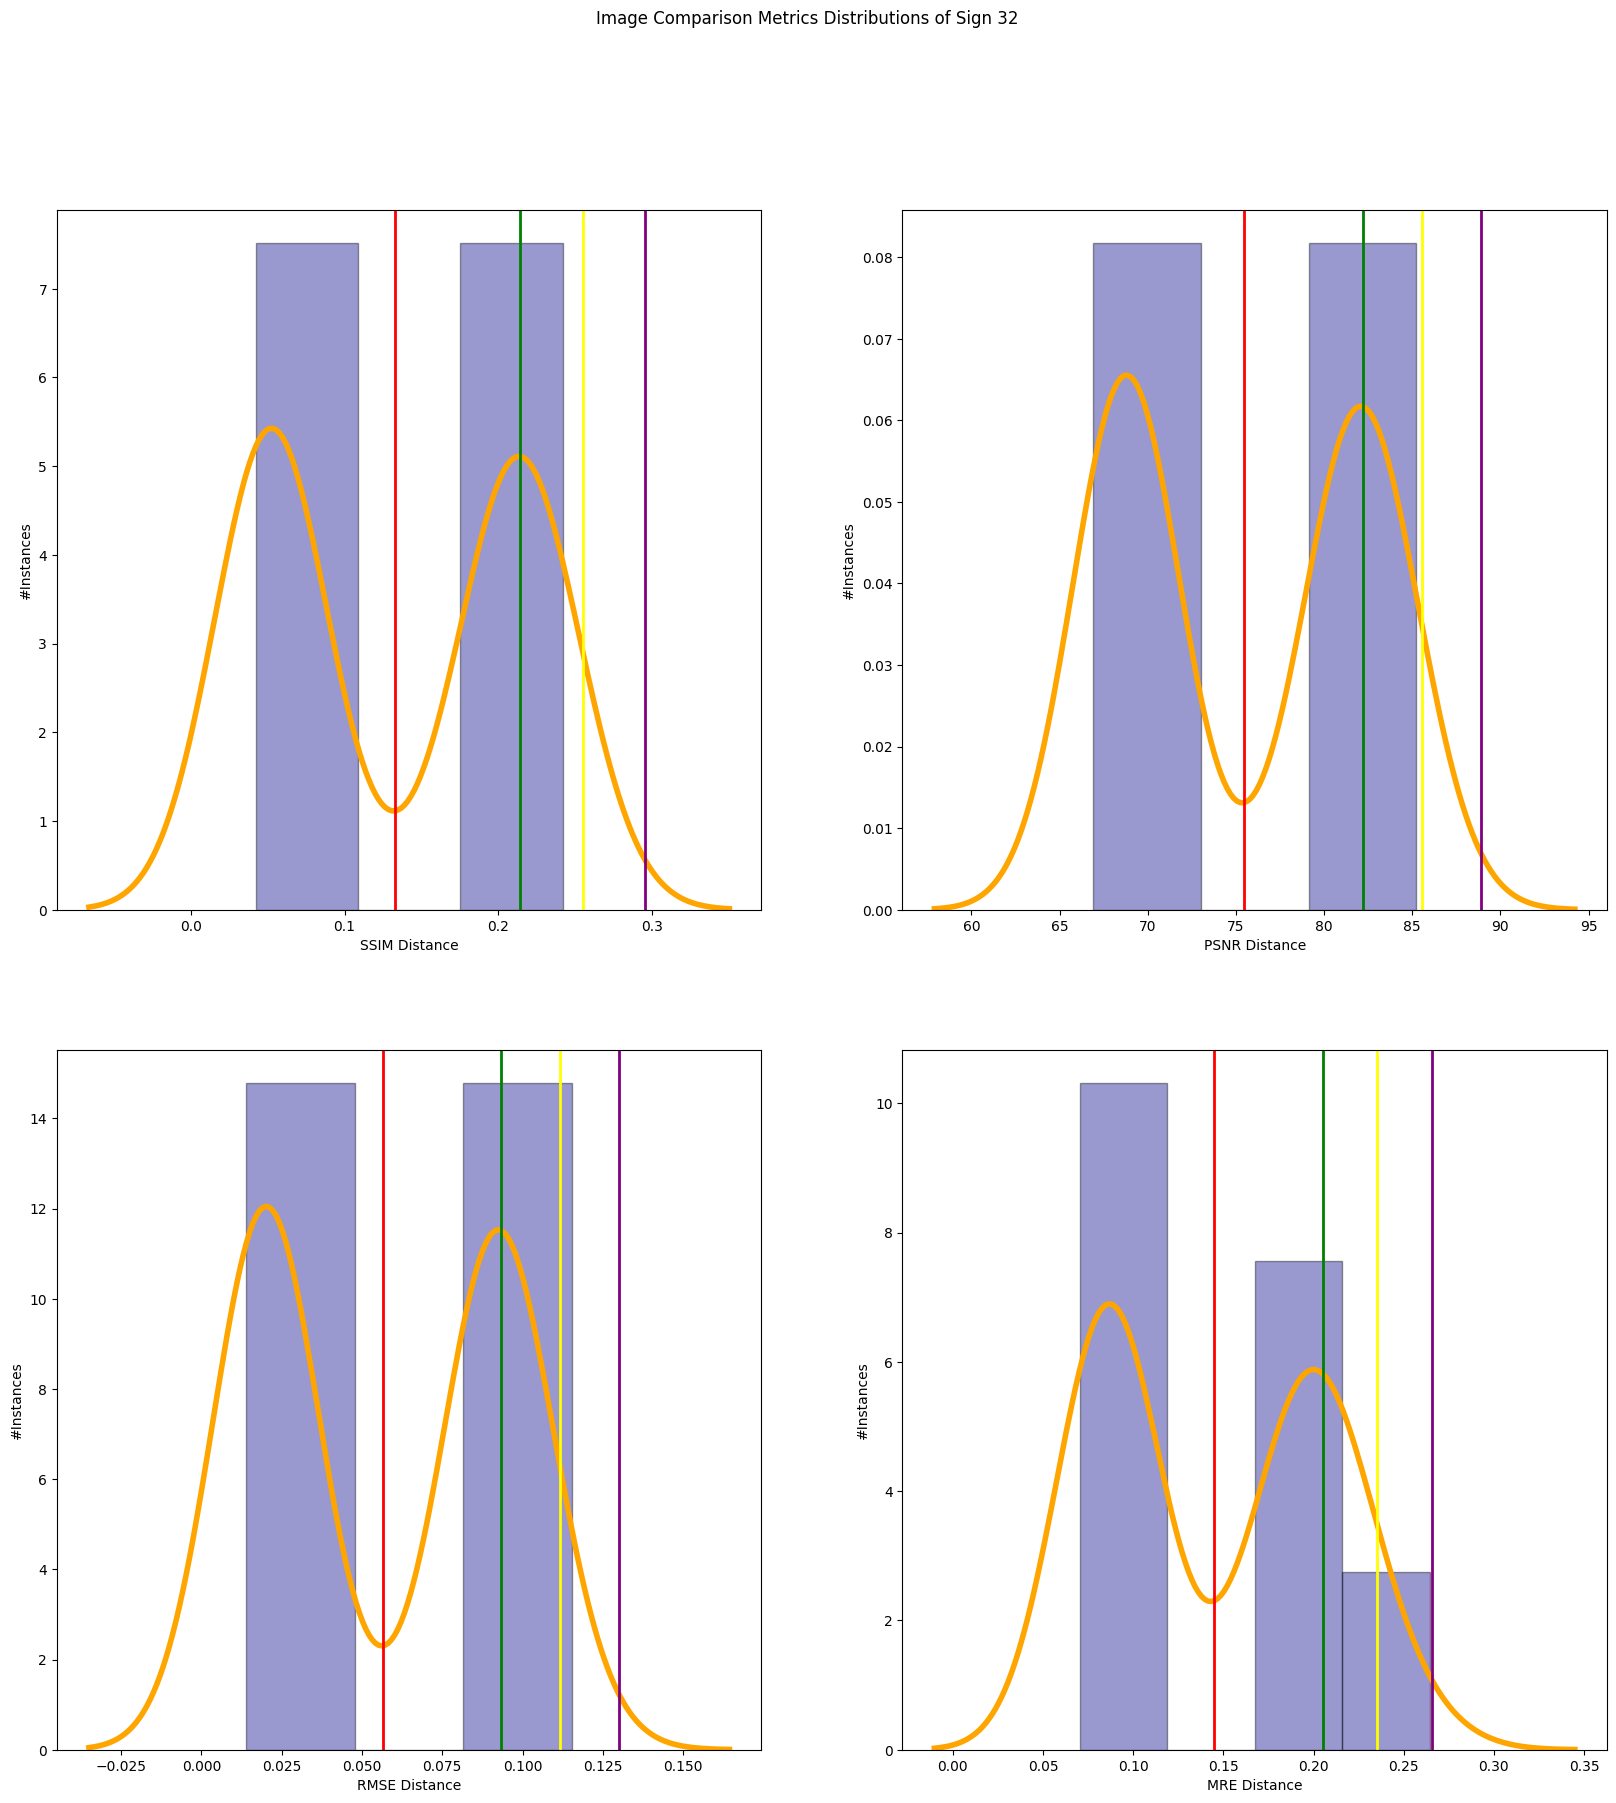

In [85]:
ssim, psnr, rmse, mre = testset(test_path32, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "32")

7/7 [==============================] - 0s 6ms/step
#Instances:  210
Destructor called, Employee deleted.
ssim mean:  0.2174105526435943  ssim σ:  0.0815789581777165  ssim μ+σ:  0.2989895108213108
ssim μ+1.5σ:  0.3397789899101691  ssim μ+2σ:  0.3805684689990273
psnr mean:  70.60869124276297  psnr σ:  3.0995389740902812  psnr μ+σ:  73.70823021685325
psnr μ+1.5σ:  75.25799970389839  psnr μ+2σ:  76.80776919094353
rmse mean:  0.08002833  rmse σ:  0.028050719  rmse μ+σ:  0.10807905
rmse μ+1.5σ:  0.1221044110134244  rmse μ+2σ:  0.13612977042794228
mre mean:  0.18057221  mre σ:  0.059285726  mre μ+σ:  0.23985794
mre μ+1.5σ:  0.2695008013397455  mre μ+2σ:  0.2991436645388603


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

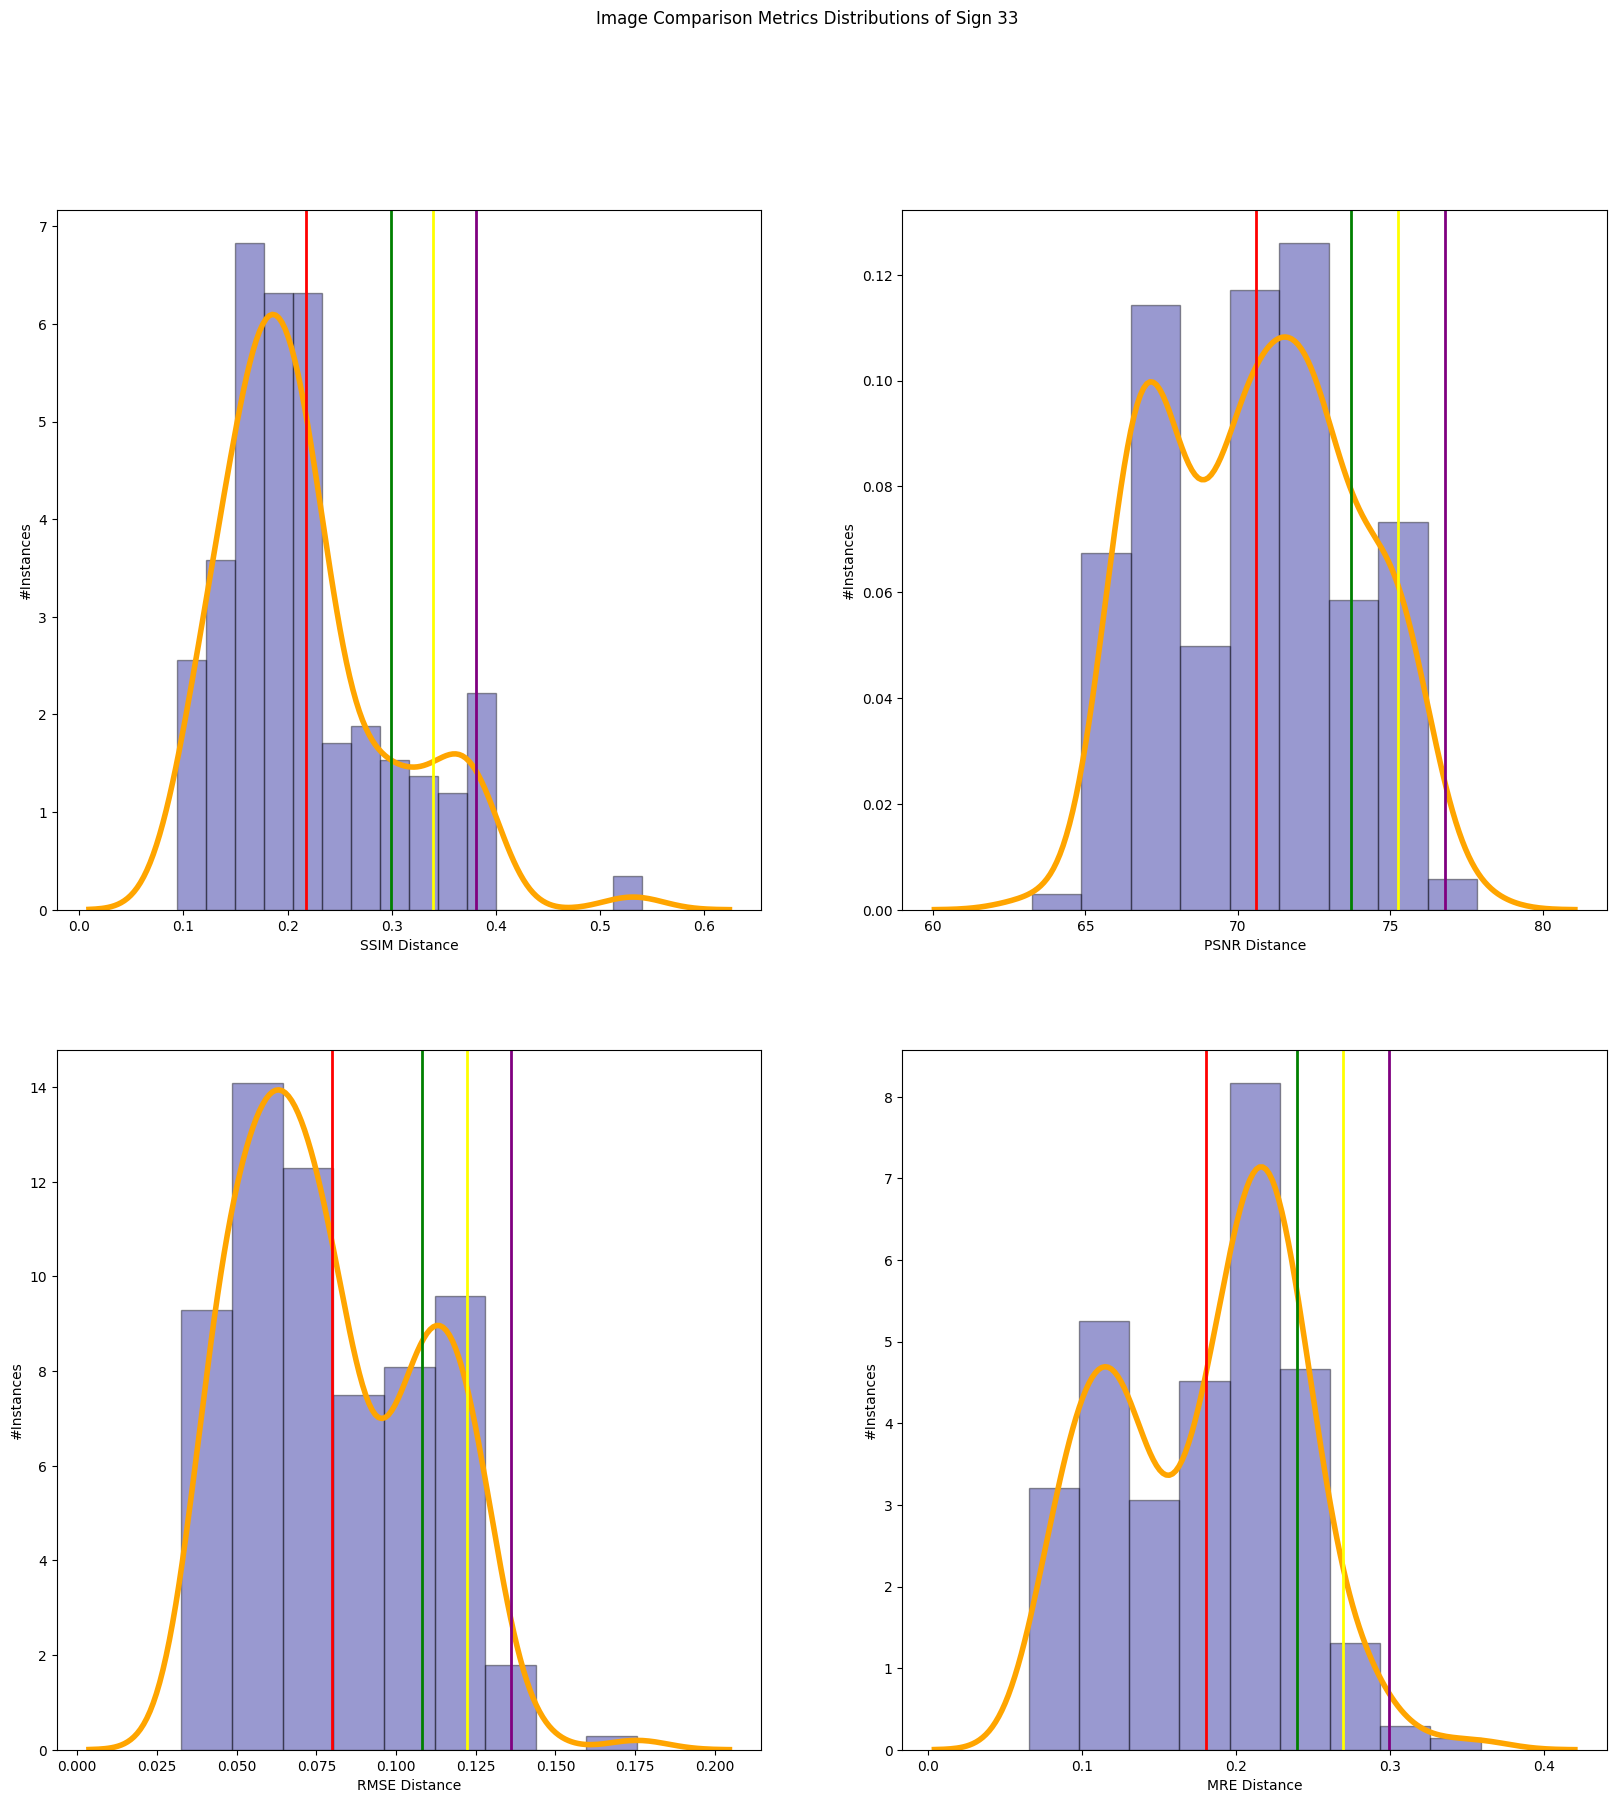

In [86]:
ssim, psnr, rmse, mre = testset(test_path33, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "33")

4/4 [==============================] - 0s 5ms/step
#Instances:  120
Destructor called, Employee deleted.


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

ssim mean:  0.2006753663221995  ssim σ:  0.06138695491023497  ssim μ+σ:  0.2620623212324345
ssim μ+1.5σ:  0.29275579868755197  ssim μ+2σ:  0.32344927614266944
psnr mean:  70.58727308909098  psnr σ:  3.1585831007880656  psnr μ+σ:  73.74585618987905
psnr μ+1.5σ:  75.32514774027308  psnr μ+2σ:  76.90443929066711
rmse mean:  0.079833664  rmse σ:  0.023670606  rmse μ+σ:  0.10350427
rmse μ+1.5σ:  0.11533957347273827  rmse μ+2σ:  0.12717487663030624
mre mean:  0.14860563  mre σ:  0.02696433  mre μ+σ:  0.17556995
mre μ+1.5σ:  0.18905212357640266  mre μ+2σ:  0.2025342881679535


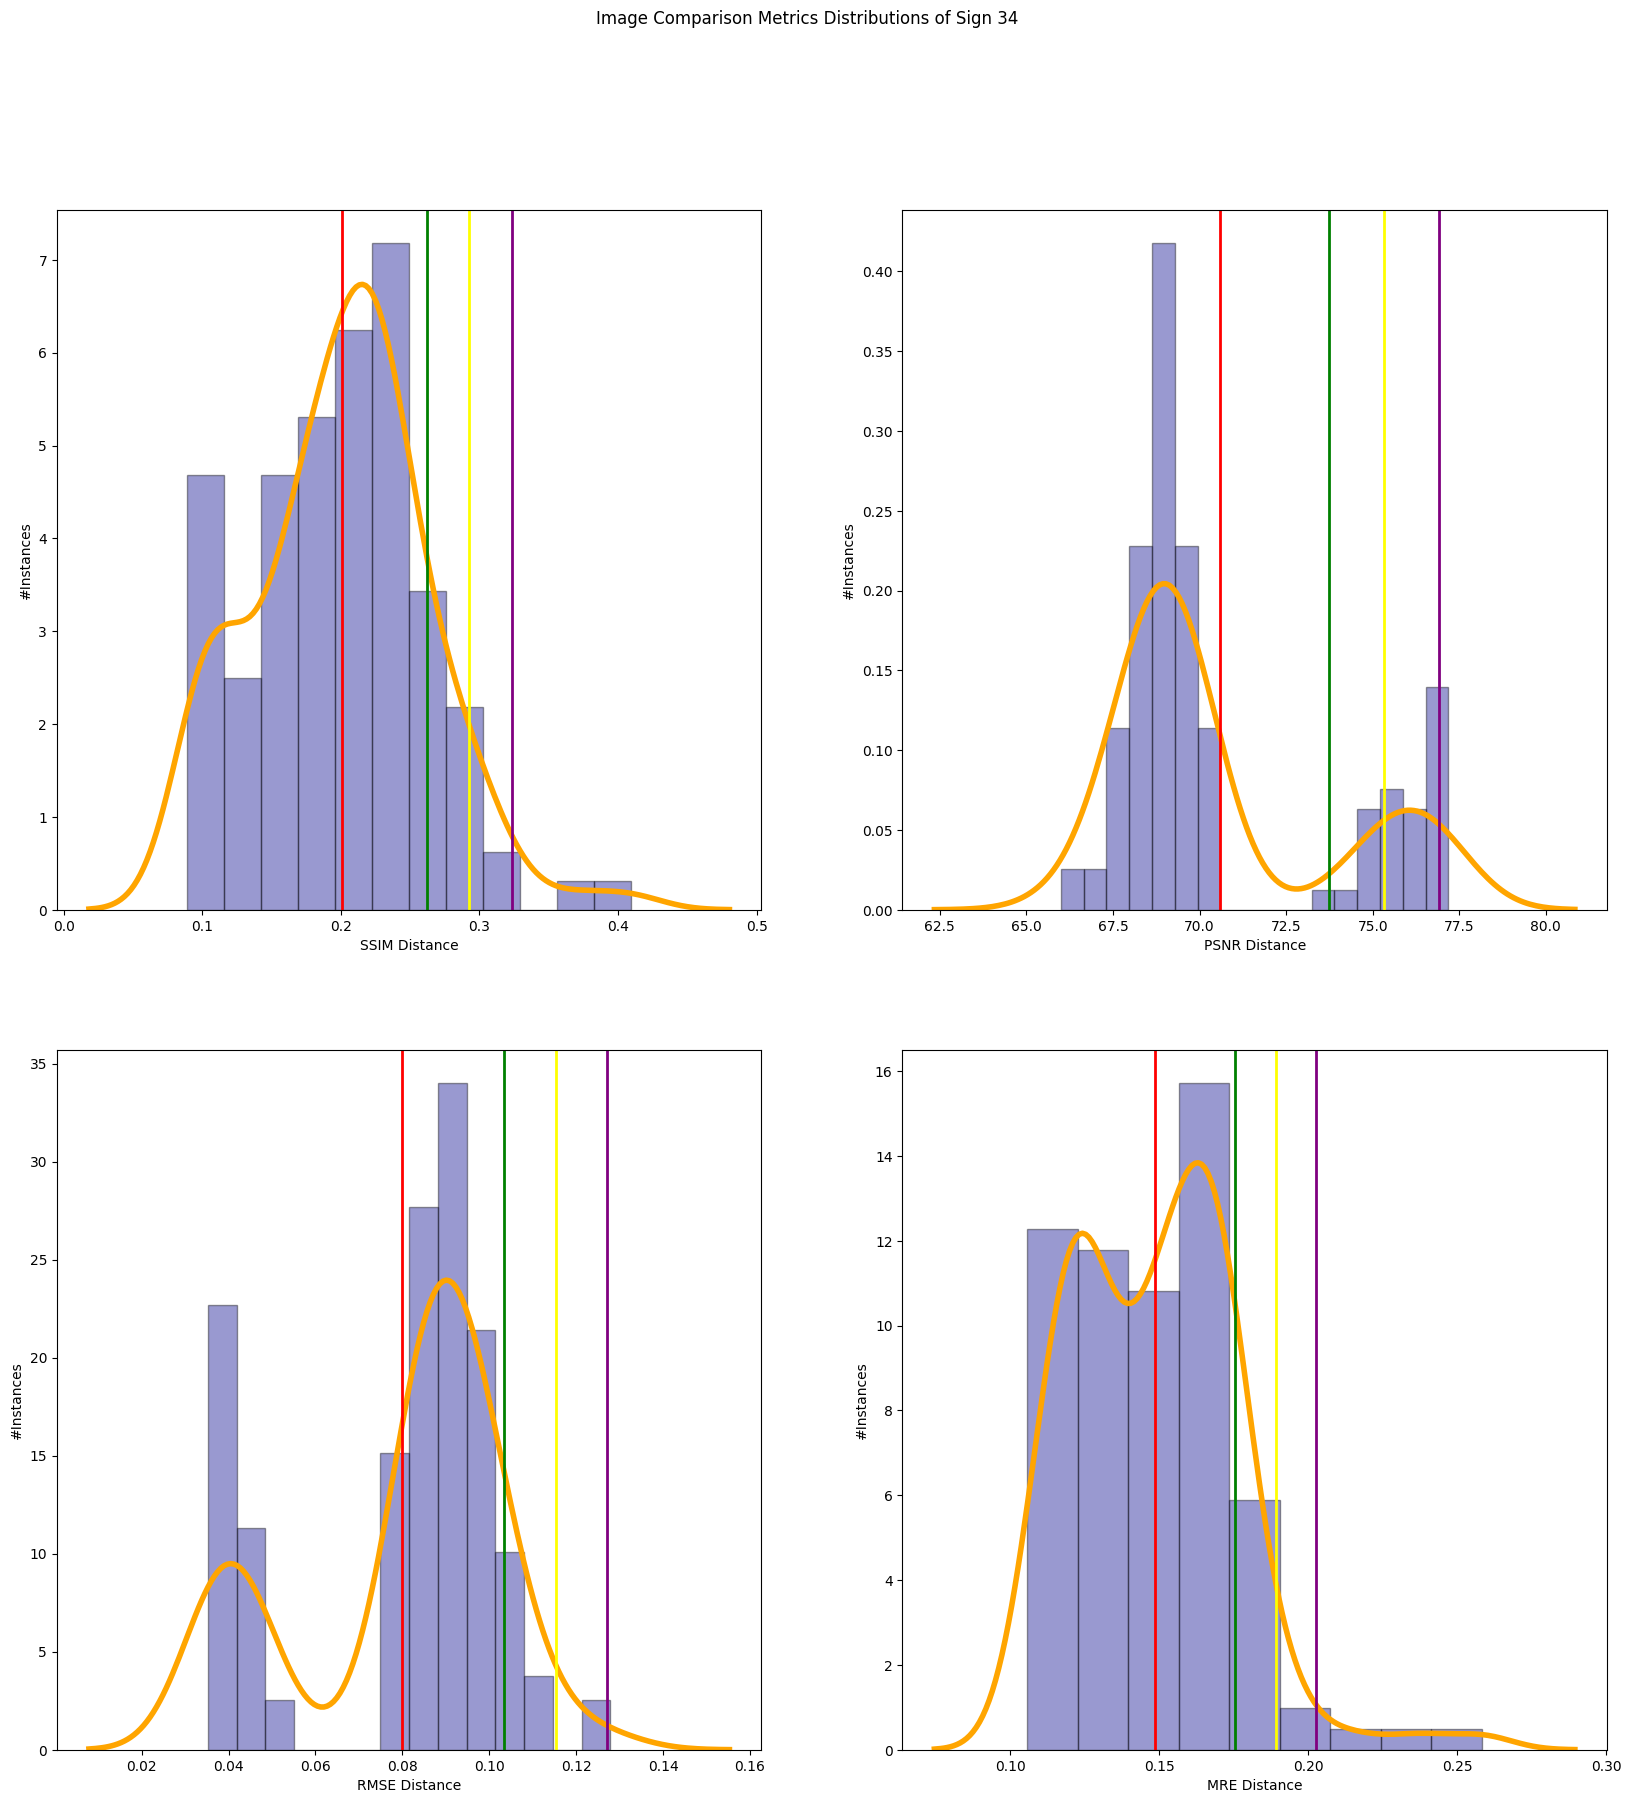

In [87]:
ssim, psnr, rmse, mre = testset(test_path34, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "34")

13/13 [==============================] - 0s 5ms/step
#Instances:  390
Destructor called, Employee deleted.
ssim mean:  0.1433883460668417  ssim σ:  0.0705002106964458  ssim μ+σ:  0.2138885567632875
ssim μ+1.5σ:  0.2491386621115104  ssim μ+2σ:  0.2843887674597333
psnr mean:  75.70650135920597  psnr σ:  5.002522889389889  psnr μ+σ:  80.70902424859587
psnr μ+1.5σ:  83.2102856932908  psnr μ+2σ:  85.71154713798575


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

rmse mean:  0.04914495  rmse σ:  0.027800057  rmse μ+σ:  0.07694501
rmse μ+1.5σ:  0.09084503538906574  rmse μ+2σ:  0.1047450639307499
mre mean:  0.15467861  mre σ:  0.049947493  mre μ+σ:  0.20462611
mre μ+1.5σ:  0.22959985211491585  mre μ+2σ:  0.25457359850406647


/tmp/ipykernel_122393/2660218213.py:102: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mre_vals, hist=True, kde=True, ax=axes[1,1],


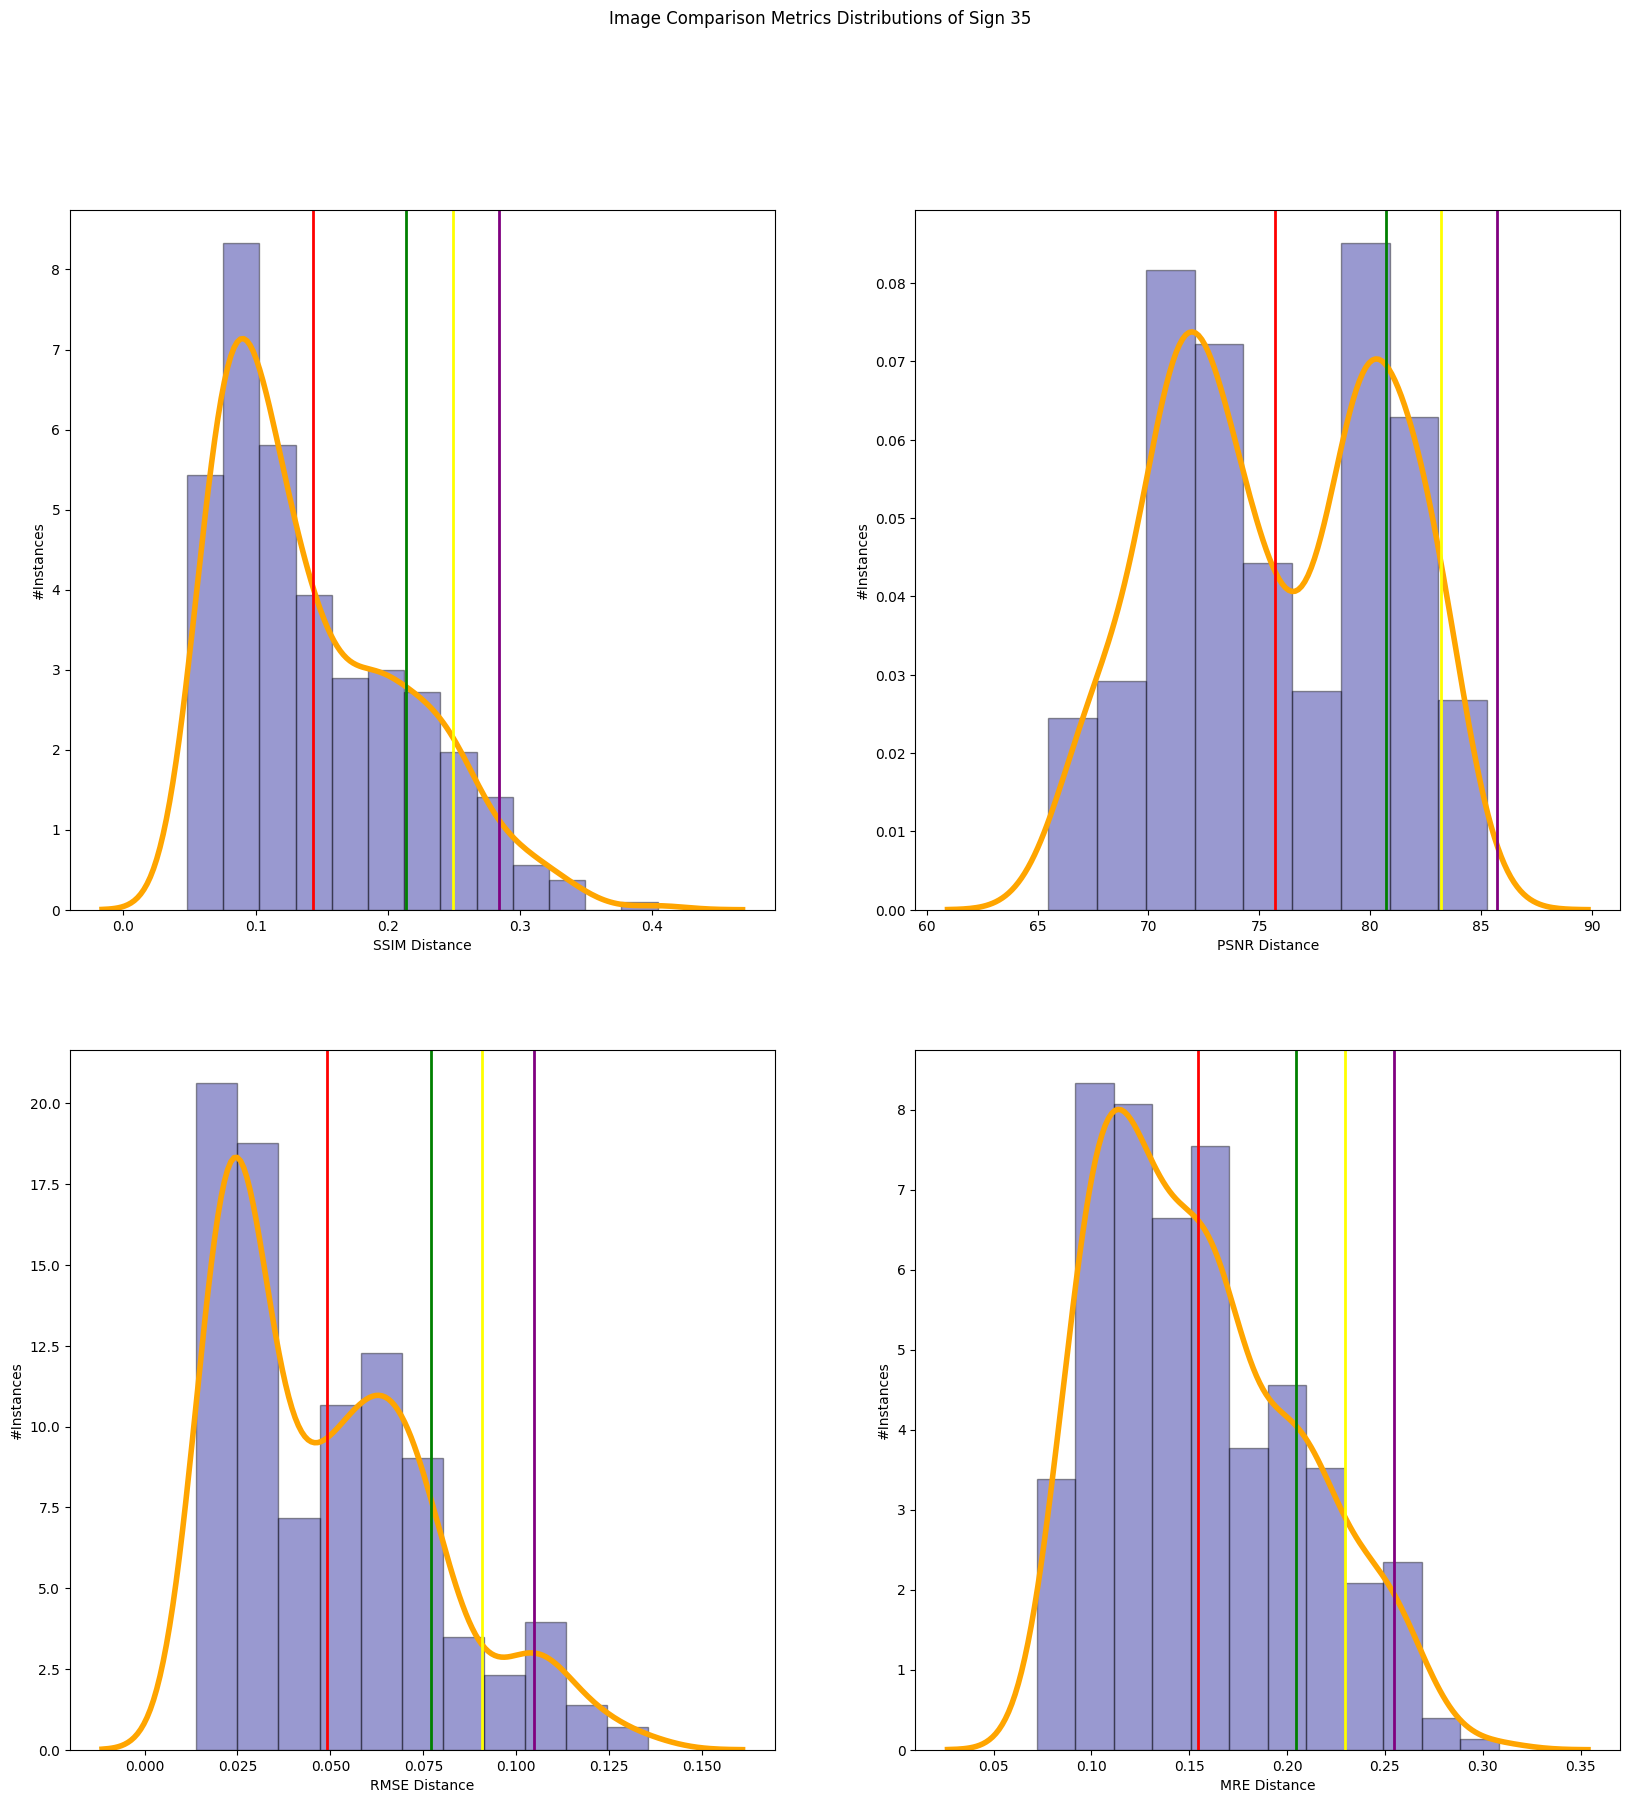

In [88]:
ssim, psnr, rmse, mre = testset(test_path35, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "35")

4/4 [==============================] - 0s 5ms/step
#Instances:  120
Destructor called, Employee deleted.
ssim mean:  0.23155600825945535  ssim σ:  0.09393012164208708  ssim μ+σ:  0.32548612990154246
ssim μ+1.5σ:  0.372451190722586  ssim μ+2σ:  0.4194162515436295
psnr mean:  70.86193230946859  psnr σ:  2.7716518237615966  psnr μ+σ:  73.63358413323019
psnr μ+1.5σ:  75.01941004511099  psnr μ+2σ:  76.40523595699177
rmse mean:  0.076835275  rmse σ:  0.024829613  rmse μ+σ:  0.101664886
rmse μ+1.5σ:  0.11407969426363707  rmse μ+2σ:  0.12649450078606606
mre mean:  0.17611773  mre σ:  0.063719444  mre μ+σ:  0.23983717
mre μ+1.5σ:  0.27169689908623695  mre μ+2σ:  0.3035566210746765


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

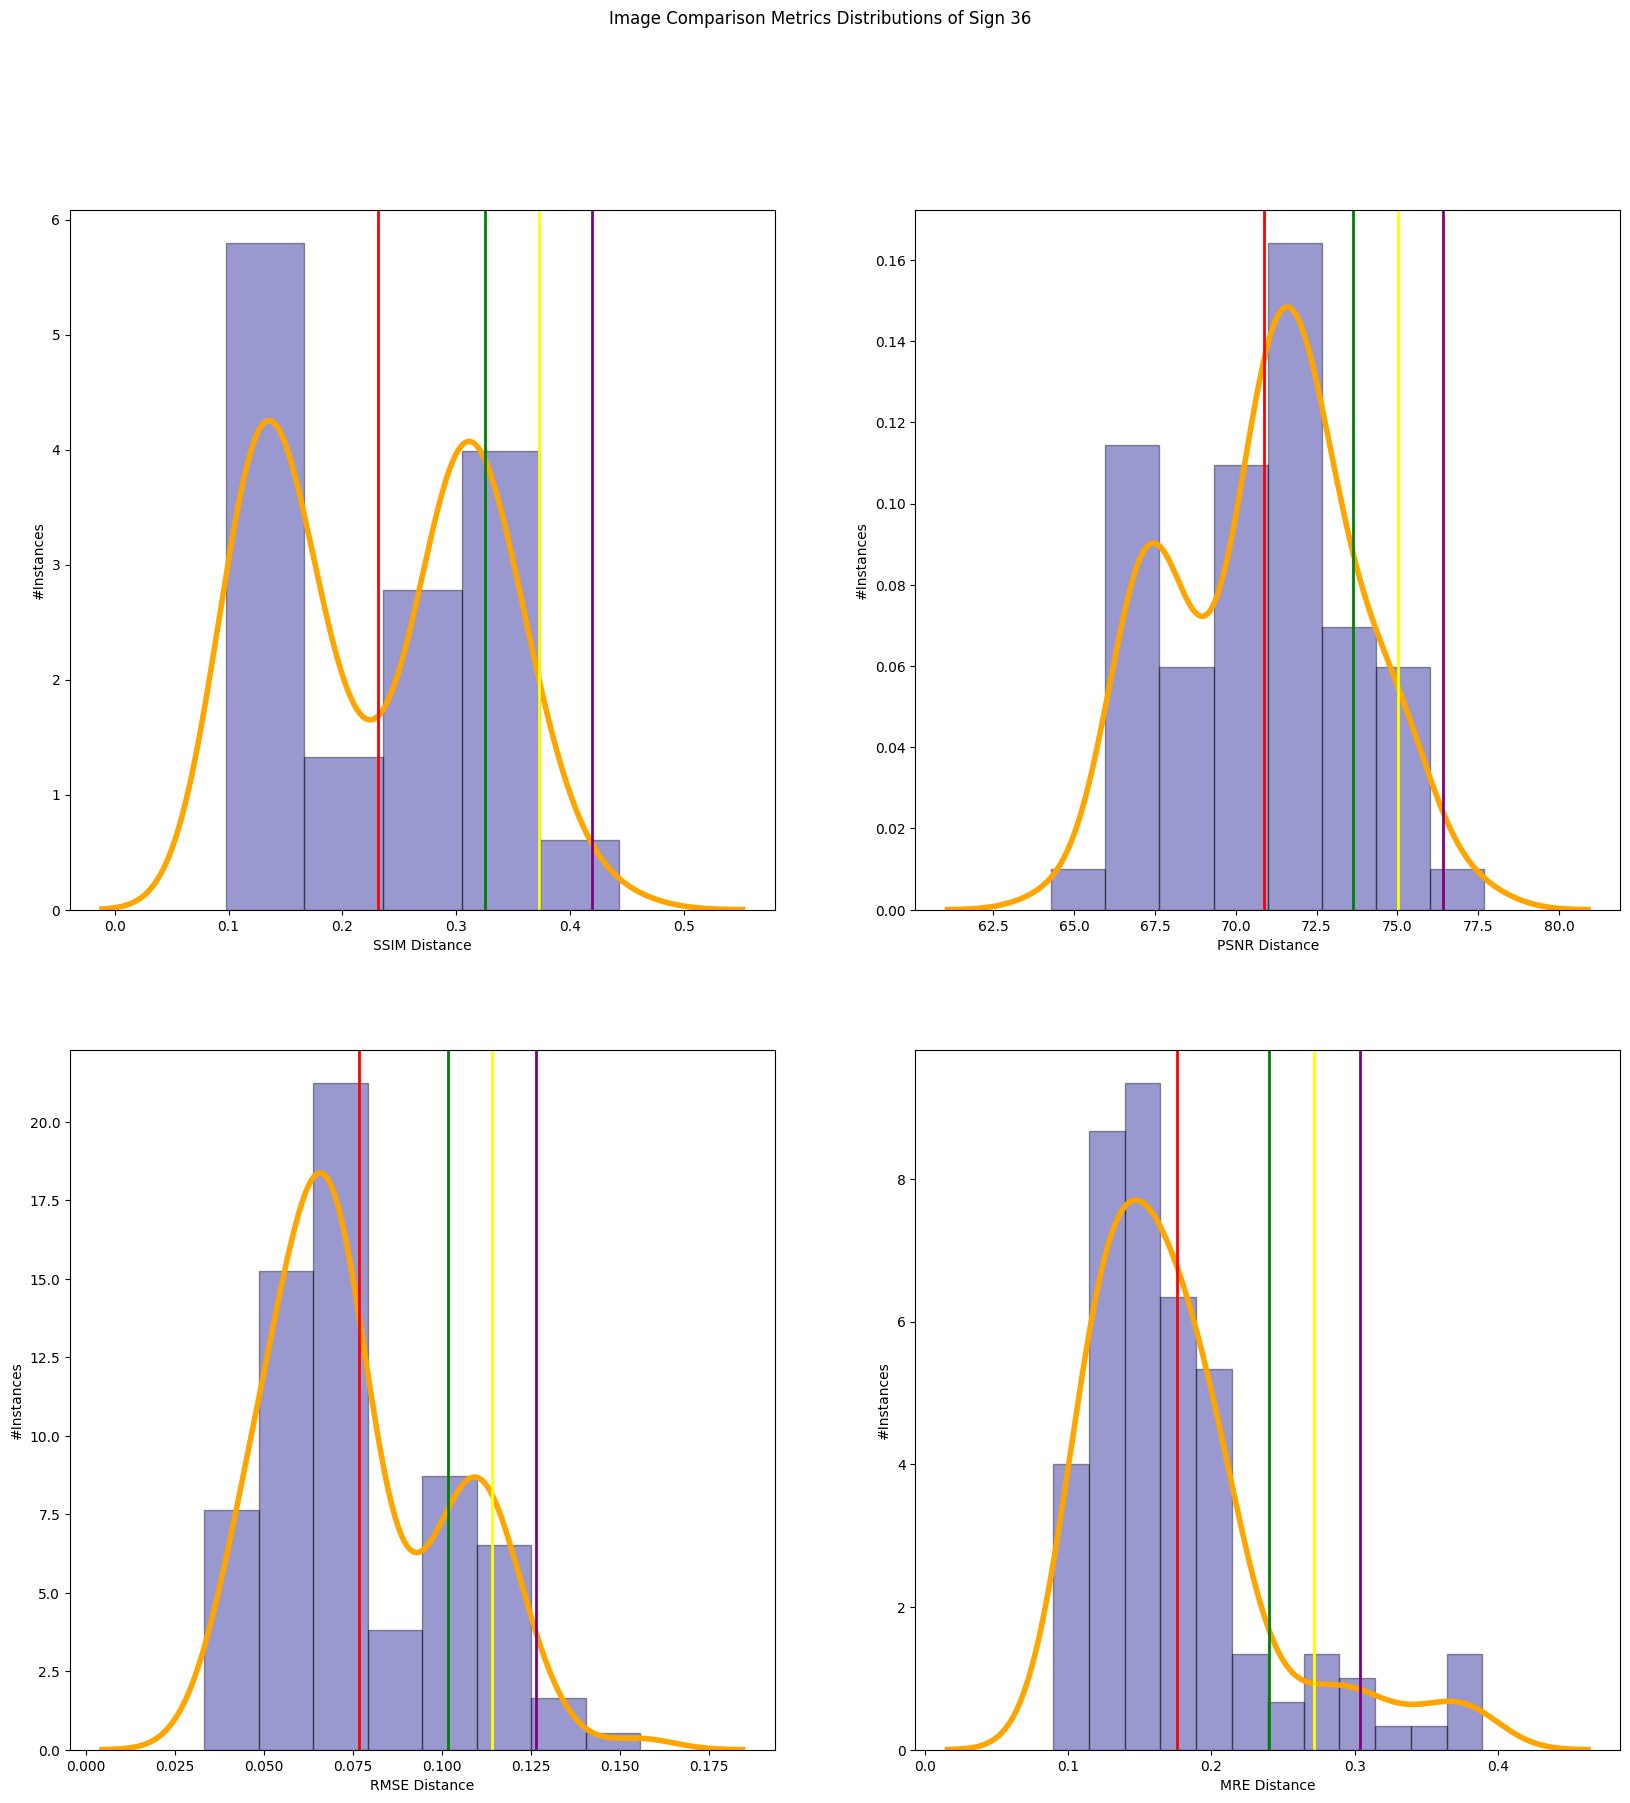

In [89]:
ssim, psnr, rmse, mre = testset(test_path36, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "36")

2/2 [==============================] - 0s 5ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.16211858292420706  ssim σ:  0.061060849002585224  ssim μ+σ:  0.2231794319267923
ssim μ+1.5σ:  0.25370985642808486  ssim μ+2σ:  0.2842402809293775
psnr mean:  74.23194745381673  psnr σ:  3.5389381833246305  psnr μ+σ:  77.77088563714136
psnr μ+1.5σ:  79.54035472880368  psnr μ+2σ:  81.309823820466
rmse mean:  0.053780667  rmse σ:  0.021643296  rmse μ+σ:  0.07542396
rmse μ+1.5σ:  0.08624561131000519  rmse μ+2σ:  0.09706725925207138
mre mean:  0.2117826  mre σ:  0.07264272  mre μ+σ:  0.28442532
mre μ+1.5σ:  0.32074668630957603  mre μ+2σ:  0.3570680469274521


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

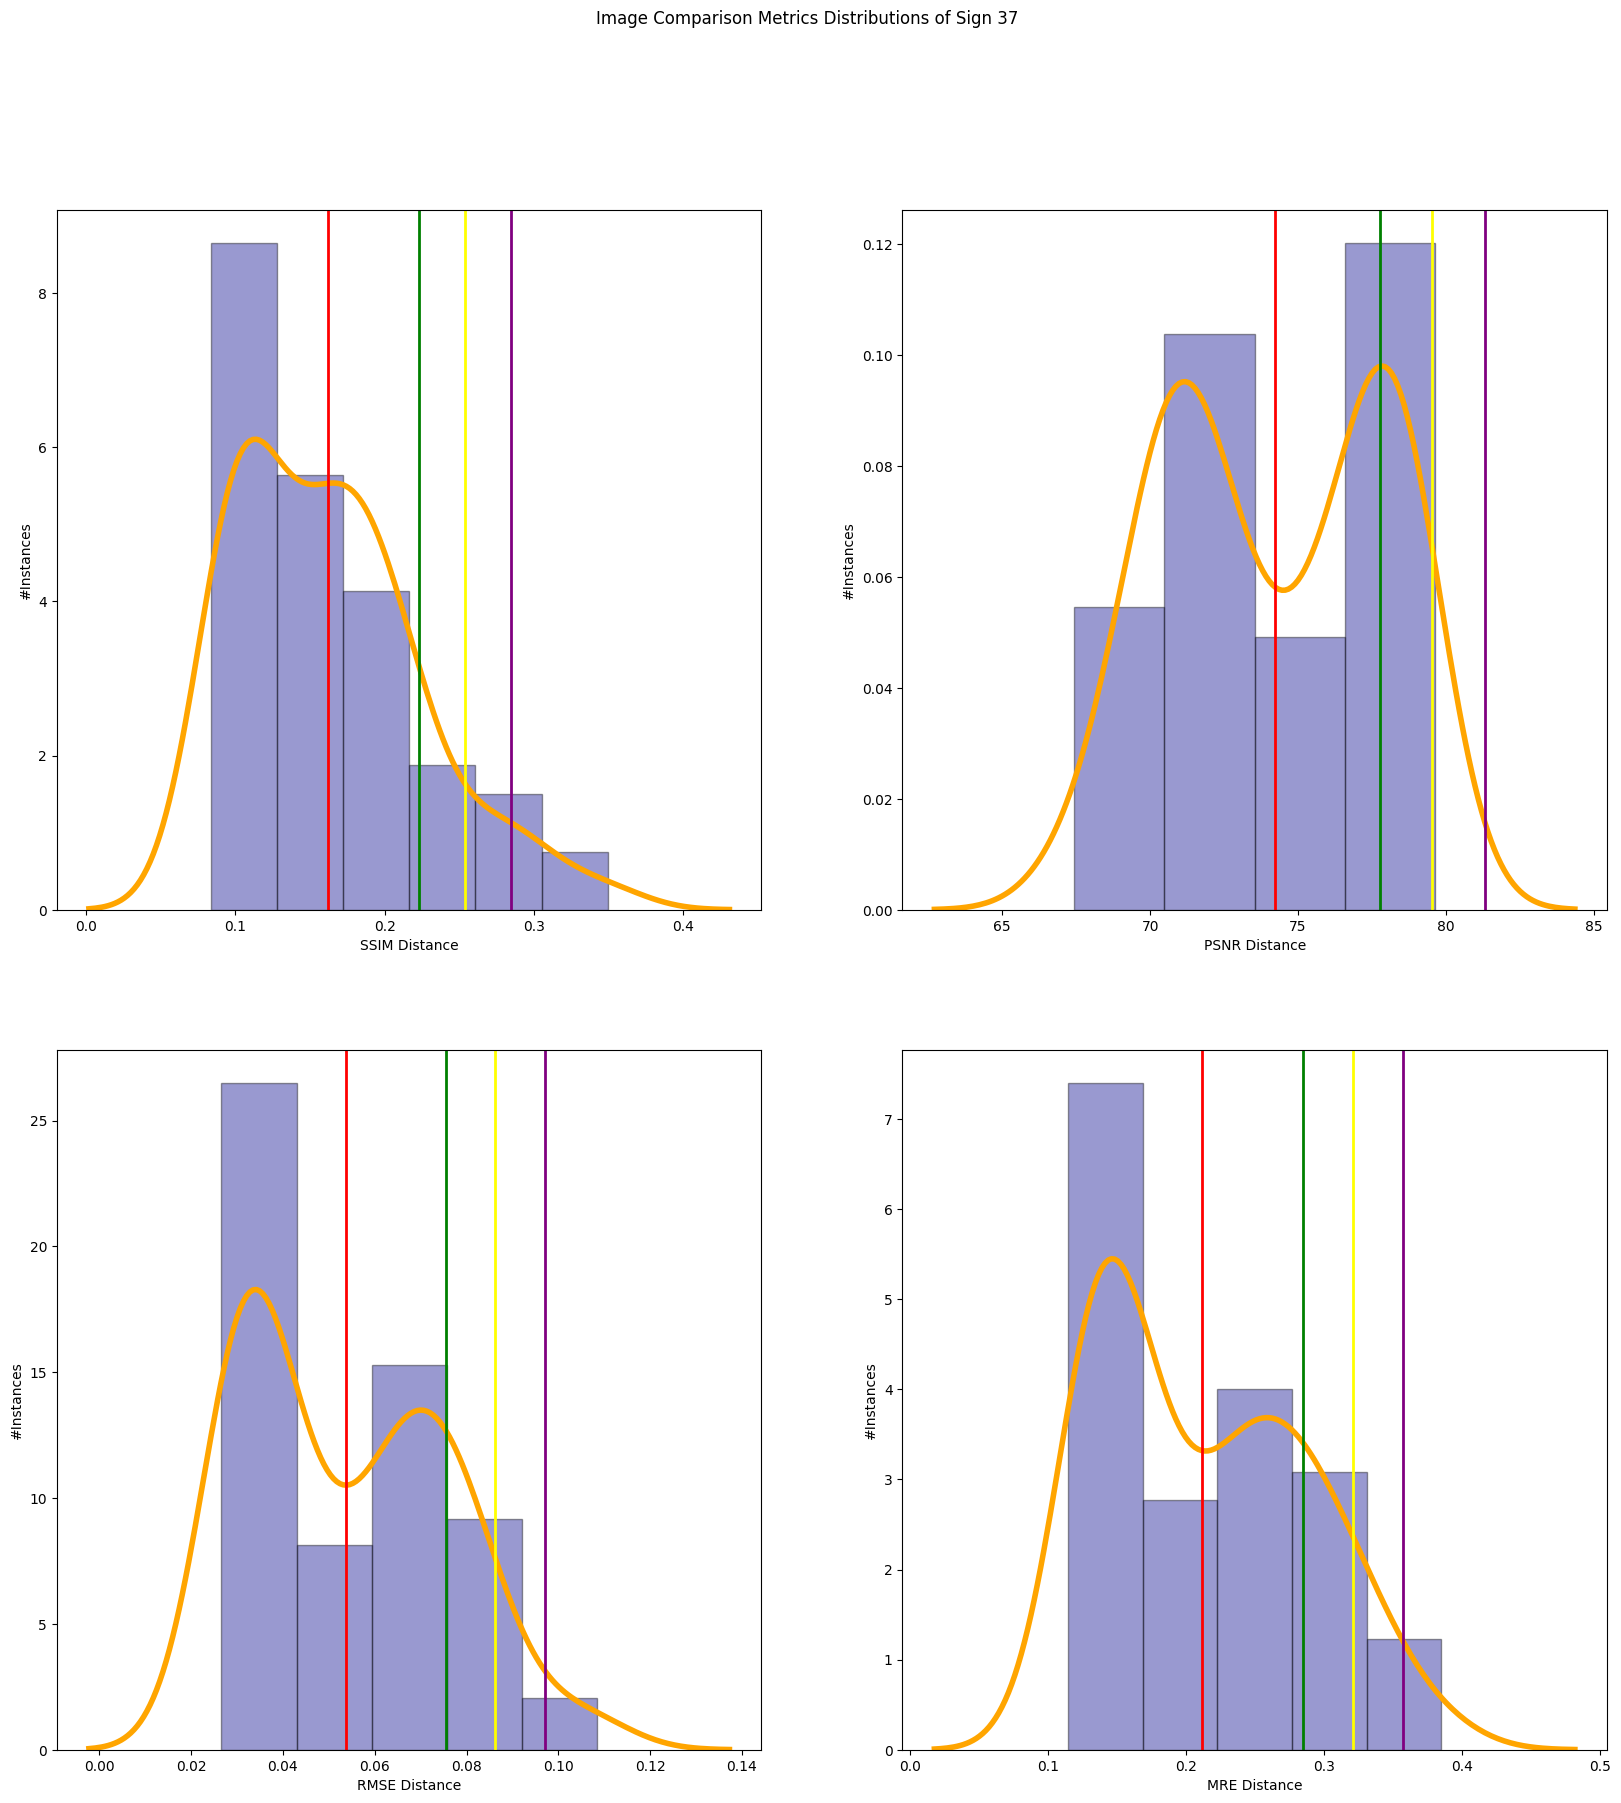

In [90]:
ssim, psnr, rmse, mre = testset(test_path37, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "37")

22/22 [==============================] - 0s 5ms/step
#Instances:  690
Destructor called, Employee deleted.
ssim mean:  0.18777483347533405  ssim σ:  0.09465022995127281  ssim μ+σ:  0.2824250634266069
ssim μ+1.5σ:  0.3297501784022433  ssim μ+2σ:  0.3770752933778797
psnr mean:  73.38385579758796  psnr σ:  5.614934056246783  psnr μ+σ:  78.99878985383474
psnr μ+1.5σ:  81.80625688195813  psnr μ+2σ:  84.61372391008152
rmse mean:  0.065290675  rmse σ:  0.03524947  rmse μ+σ:  0.100540146
rmse μ+1.5σ:  0.11816488206386566  rmse μ+2σ:  0.13578961789608002


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

mre mean:  0.17010076  mre σ:  0.06786804  mre μ+σ:  0.2379688
mre μ+1.5σ:  0.27190282195806503  mre μ+2σ:  0.30583684146404266


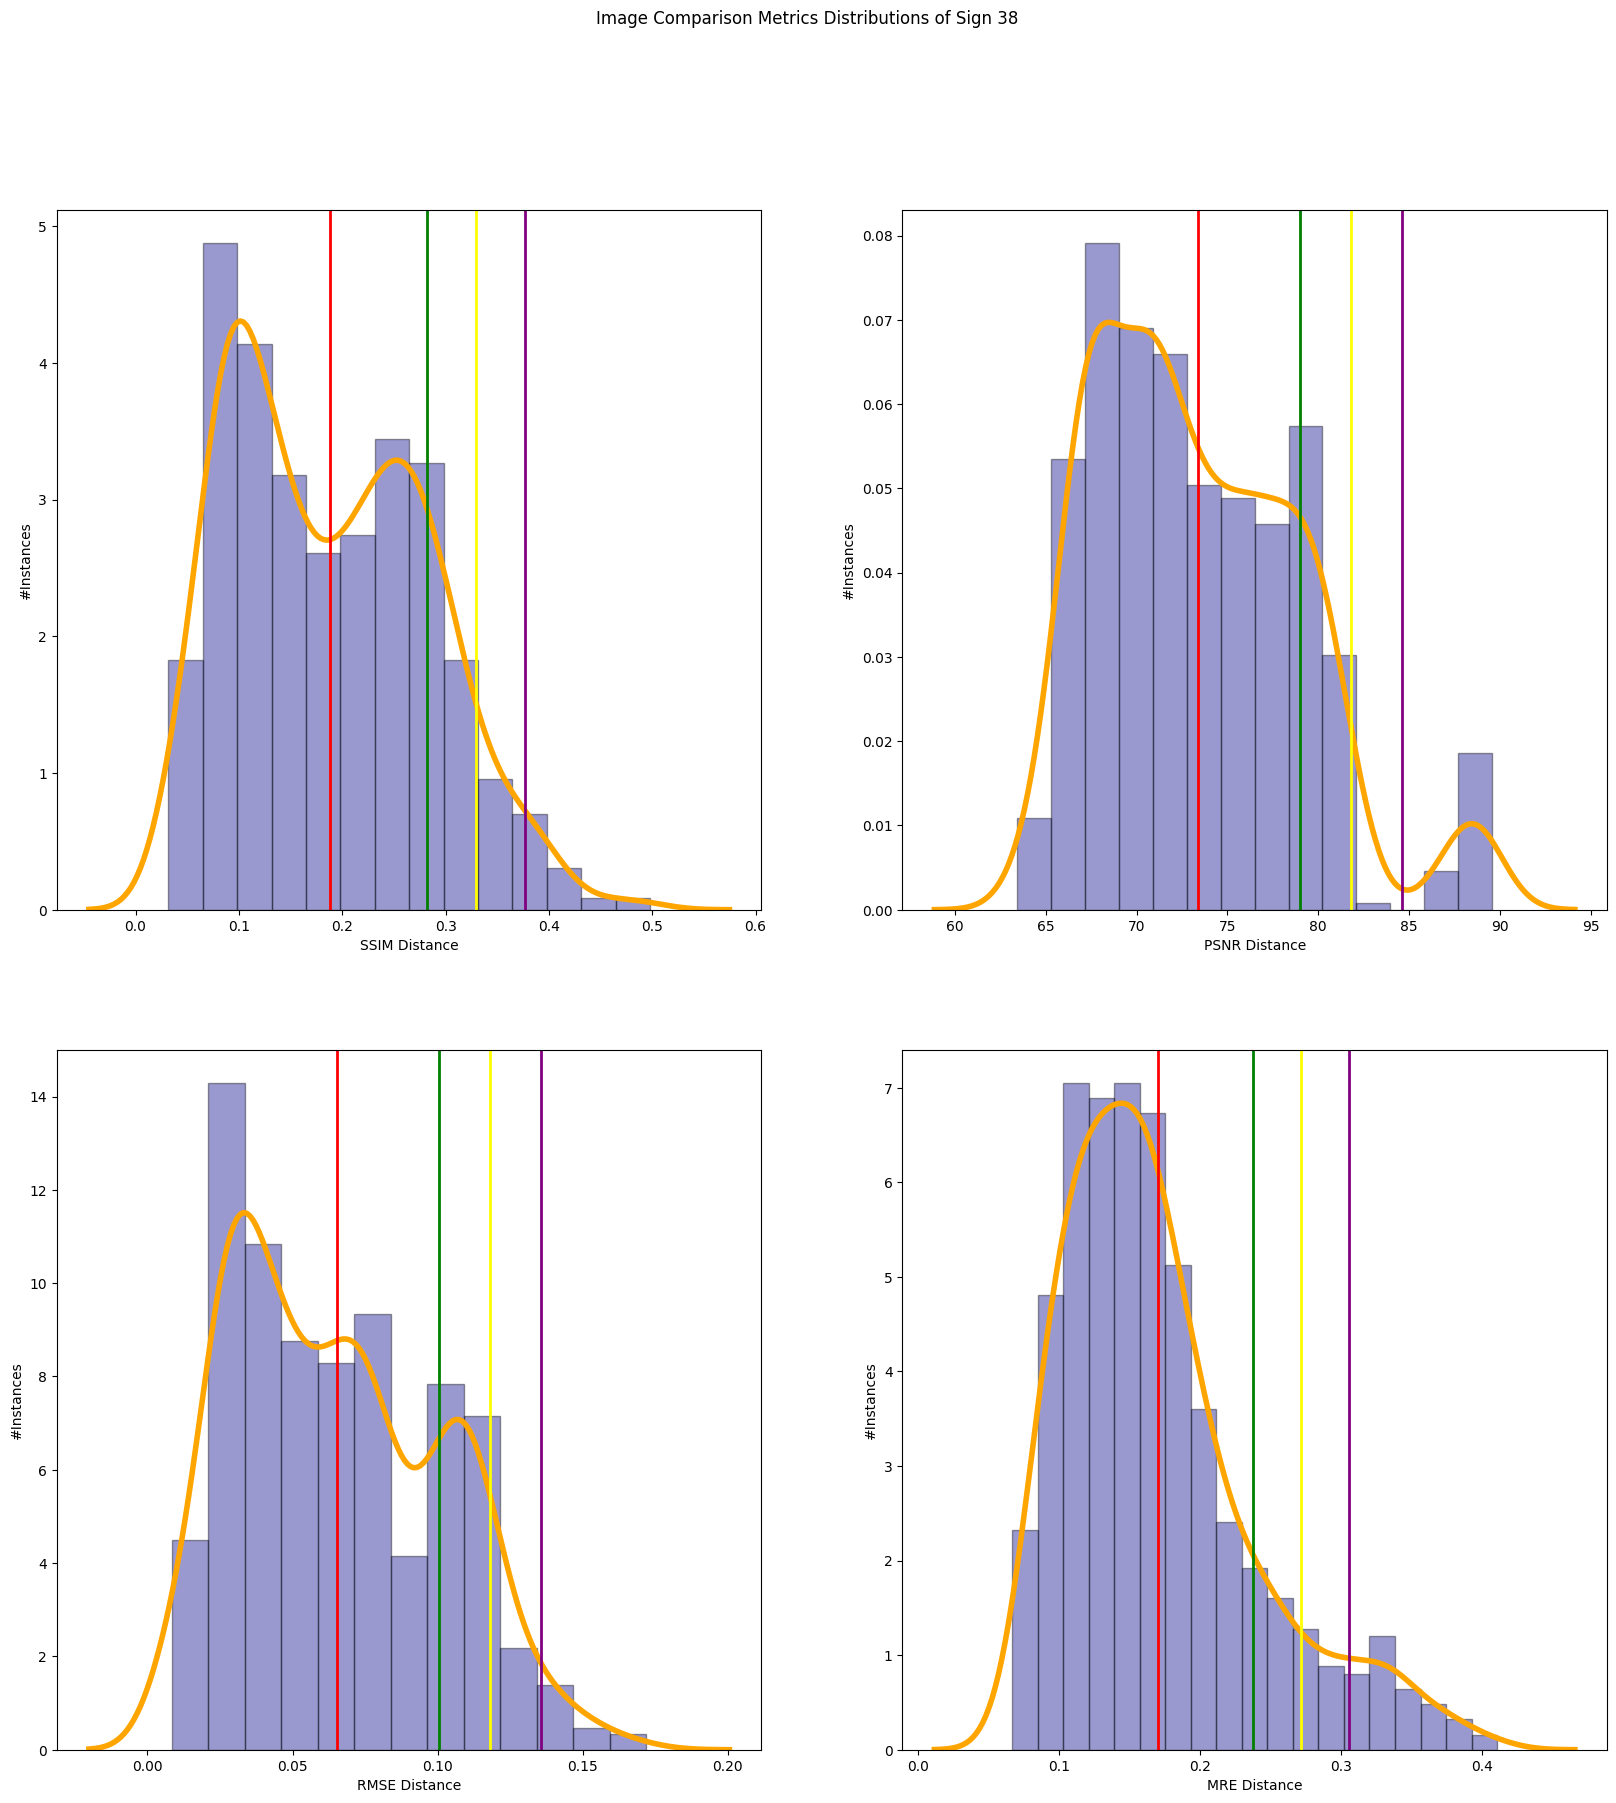

In [91]:
ssim, psnr, rmse, mre = testset(test_path38, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "38")

3/3 [==============================] - 0s 8ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.19913648234473336  ssim σ:  0.08726340582145156  ssim μ+σ:  0.2863998881661849
ssim μ+1.5σ:  0.3300315910769107  ssim μ+2σ:  0.3736632939876365
psnr mean:  73.28339657253689  psnr σ:  7.4255564437807395  psnr μ+σ:  80.70895301631762
psnr μ+1.5σ:  84.421731238208  psnr μ+2σ:  88.13450946009837
rmse mean:  0.07283114  rmse σ:  0.040960878  rmse μ+σ:  0.11379202
rmse μ+1.5σ:  0.13427245616912842  rmse μ+2σ:  0.15475289523601532
mre mean:  0.17083828  mre σ:  0.042408604  mre μ+σ:  0.21324688
mre μ+1.5σ:  0.234451187774539  mre μ+2σ:  0.2556554898619652


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

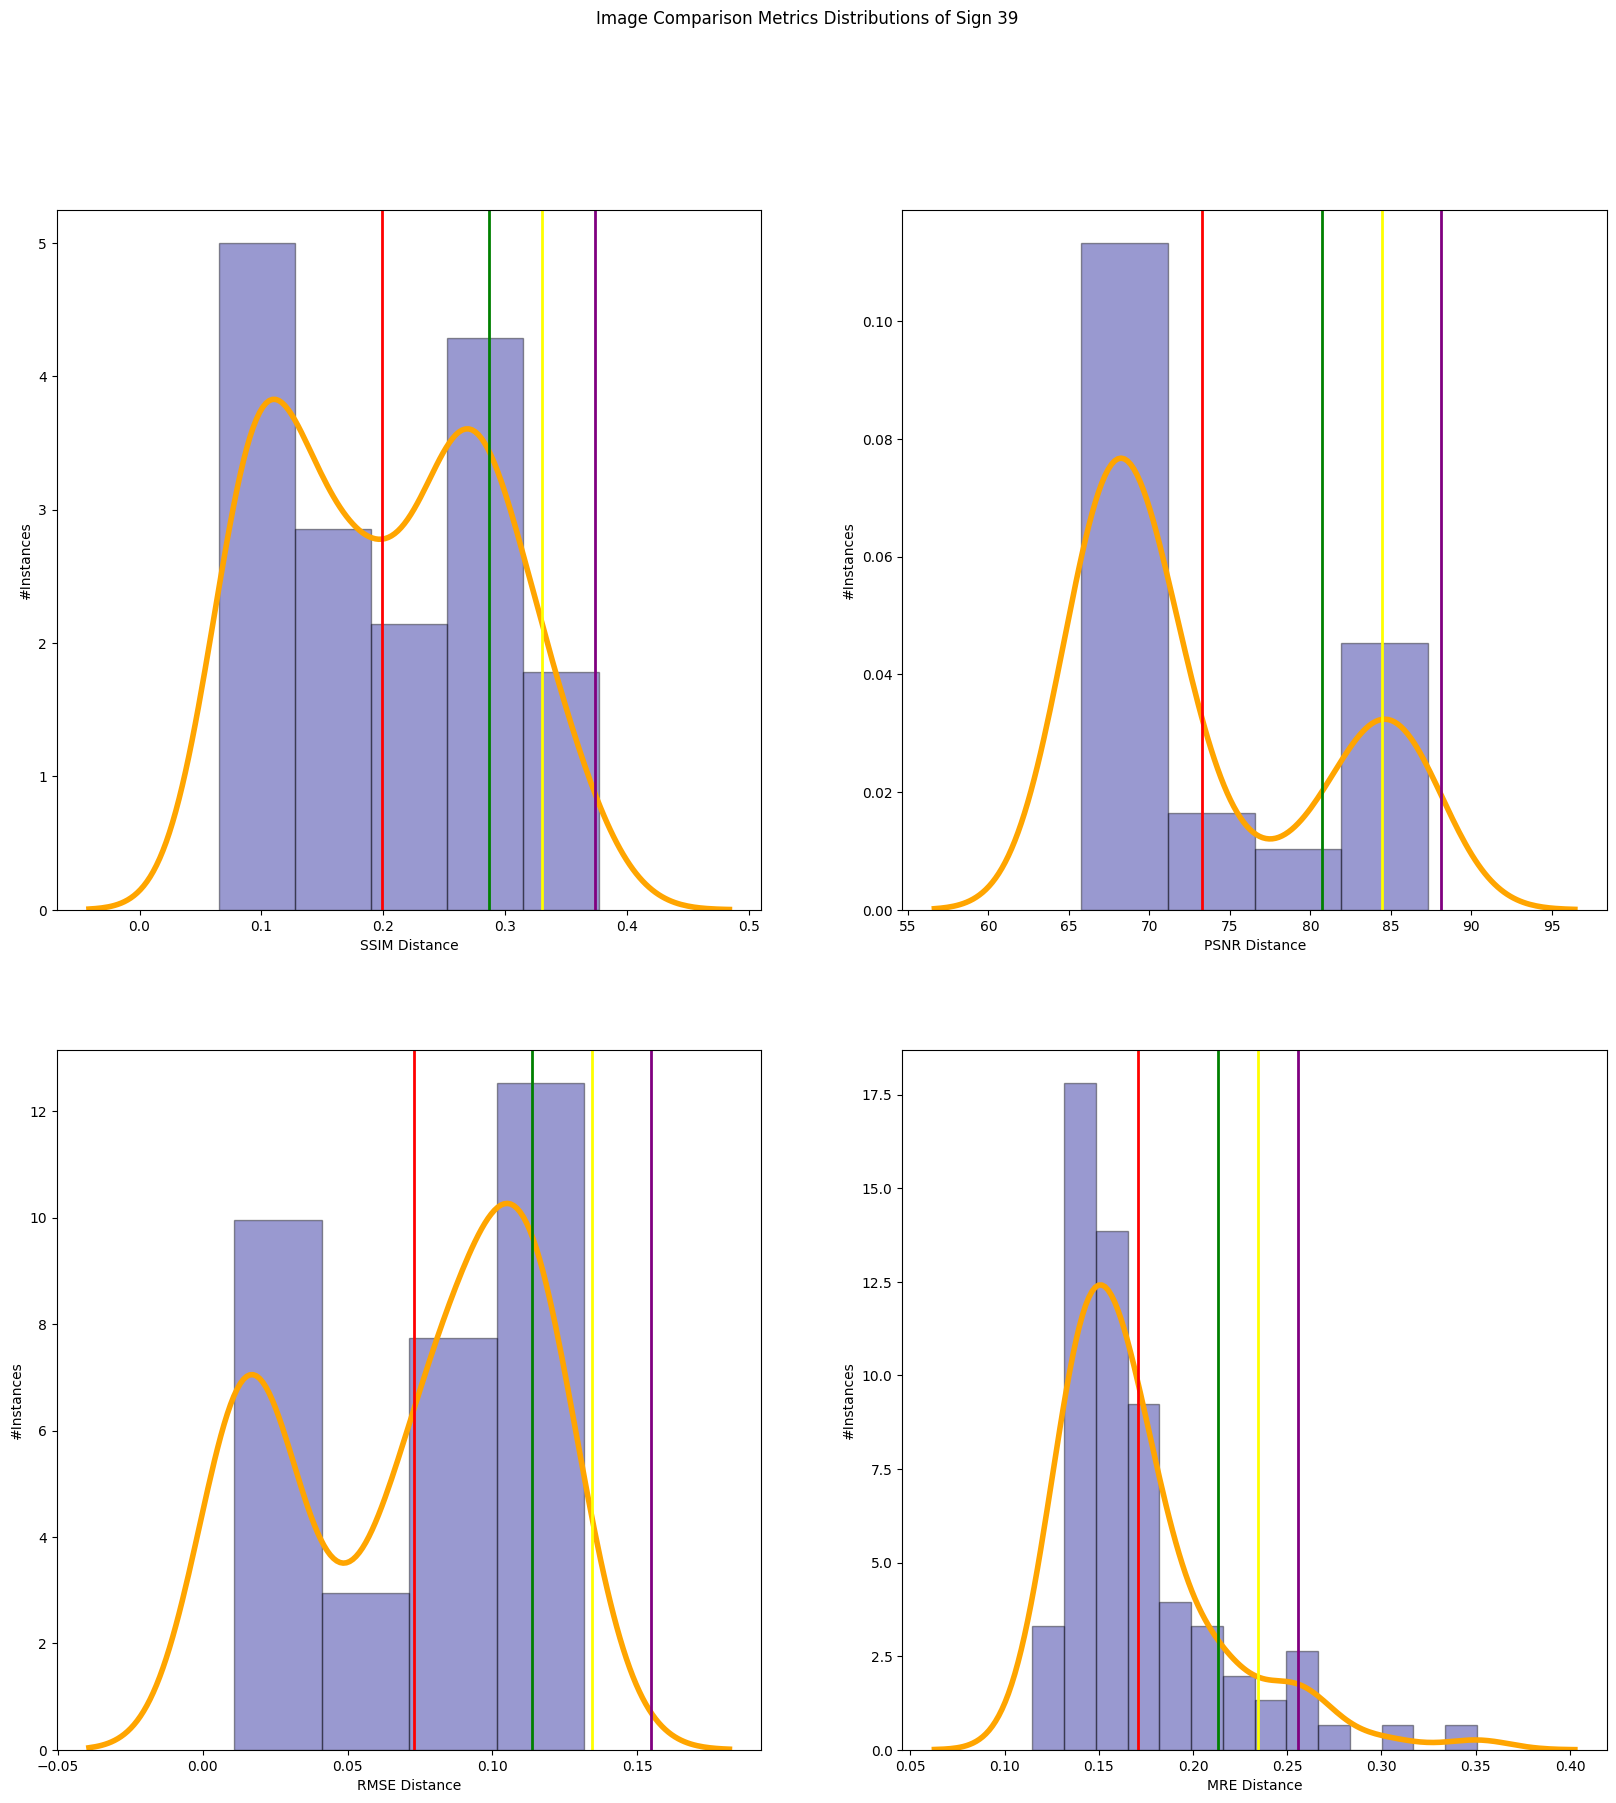

In [92]:
ssim, psnr, rmse, mre = testset(test_path39, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "39")

3/3 [==============================] - 0s 5ms/step
#Instances:  90
Destructor called, Employee deleted.


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

ssim mean:  0.2168966982099745  ssim σ:  0.0494571827856541  ssim μ+σ:  0.2663538809956286
ssim μ+1.5σ:  0.29108247238845564  ssim μ+2σ:  0.3158110637812827
psnr mean:  71.77123879326714  psnr σ:  3.875533473396209  psnr μ+σ:  75.64677226666335
psnr μ+1.5σ:  77.58453900336146  psnr μ+2σ:  79.52230574005956
rmse mean:  0.07247289  rmse σ:  0.031135881  rmse μ+σ:  0.10360877
rmse μ+1.5σ:  0.11917671468108892  rmse μ+2σ:  0.13474465534090996
mre mean:  0.20463346  mre σ:  0.04154318  mre μ+σ:  0.24617663
mre μ+1.5σ:  0.26694822683930397  mre μ+2σ:  0.28771981596946716


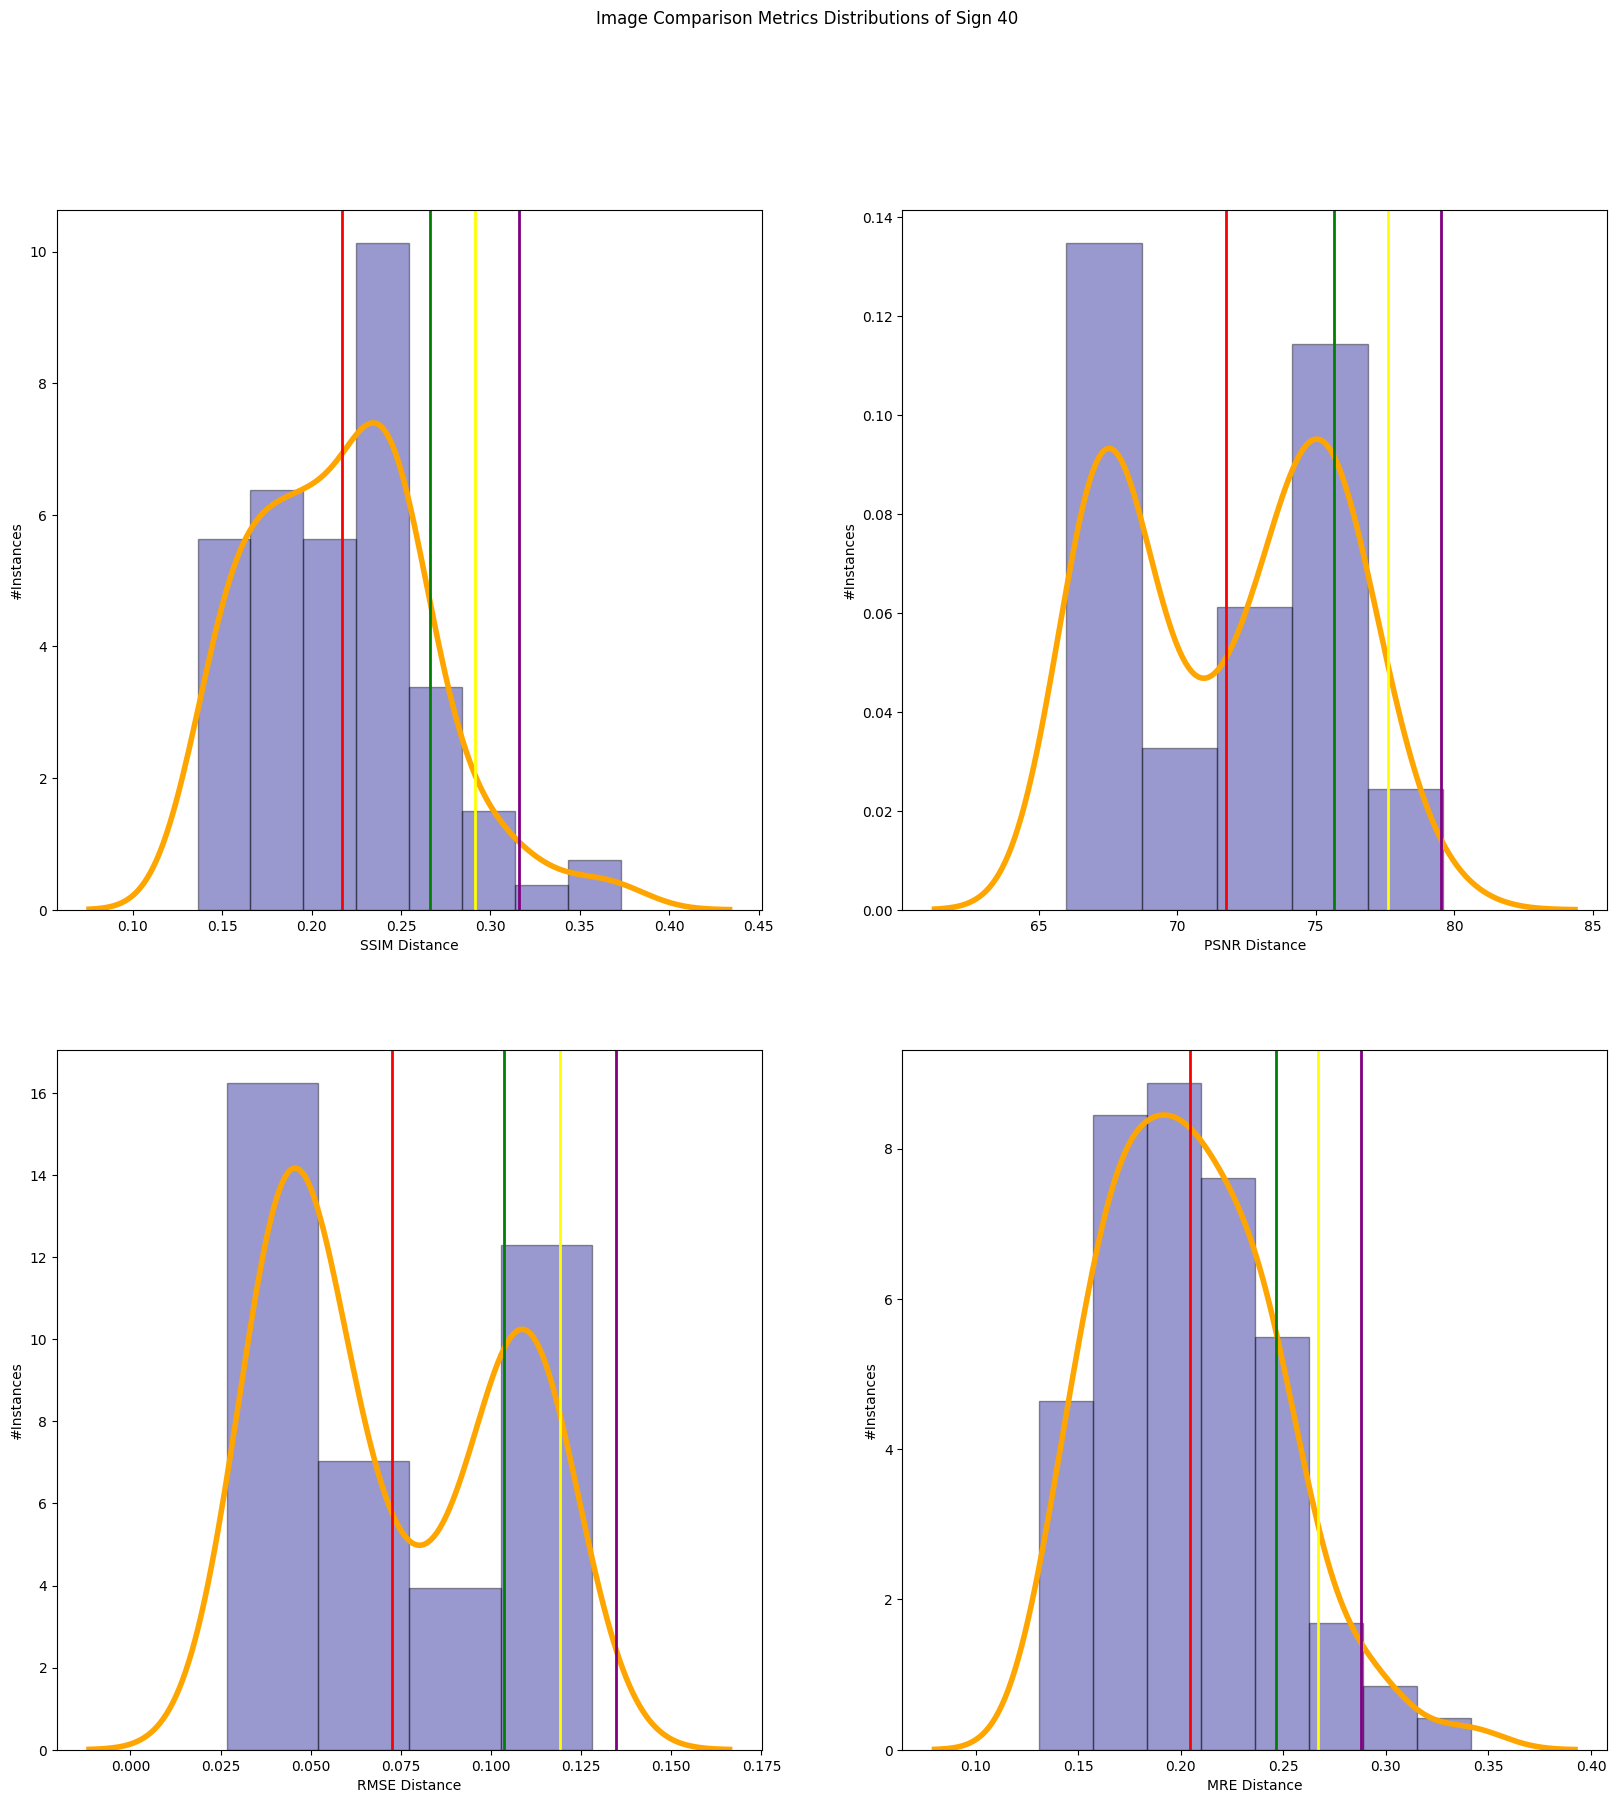

In [93]:
ssim, psnr, rmse, mre = testset(test_path40, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "40")

2/2 [==============================] - 0s 8ms/step
#Instances:  60
Destructor called, Employee deleted.
ssim mean:  0.18275059759616852  ssim σ:  0.03514651570471377  ssim μ+σ:  0.2178971133008823
ssim μ+1.5σ:  0.23547037115323916  ssim μ+2σ:  0.25304362900559607
psnr mean:  72.17751948038737  psnr σ:  3.4297550680083737  psnr μ+σ:  75.60727454839575
psnr μ+1.5σ:  77.32215208239994  psnr μ+2σ:  79.03702961640413
rmse mean:  0.06765065  rmse σ:  0.025238192  rmse μ+σ:  0.09288885
rmse μ+1.5σ:  0.1055079409852624  rmse μ+2σ:  0.11812703683972359
mre mean:  0.18826431  mre σ:  0.0382478  mre μ+σ:  0.2265121
mre μ+1.5σ:  0.2456360124051571  mre μ+2σ:  0.2647599130868912


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

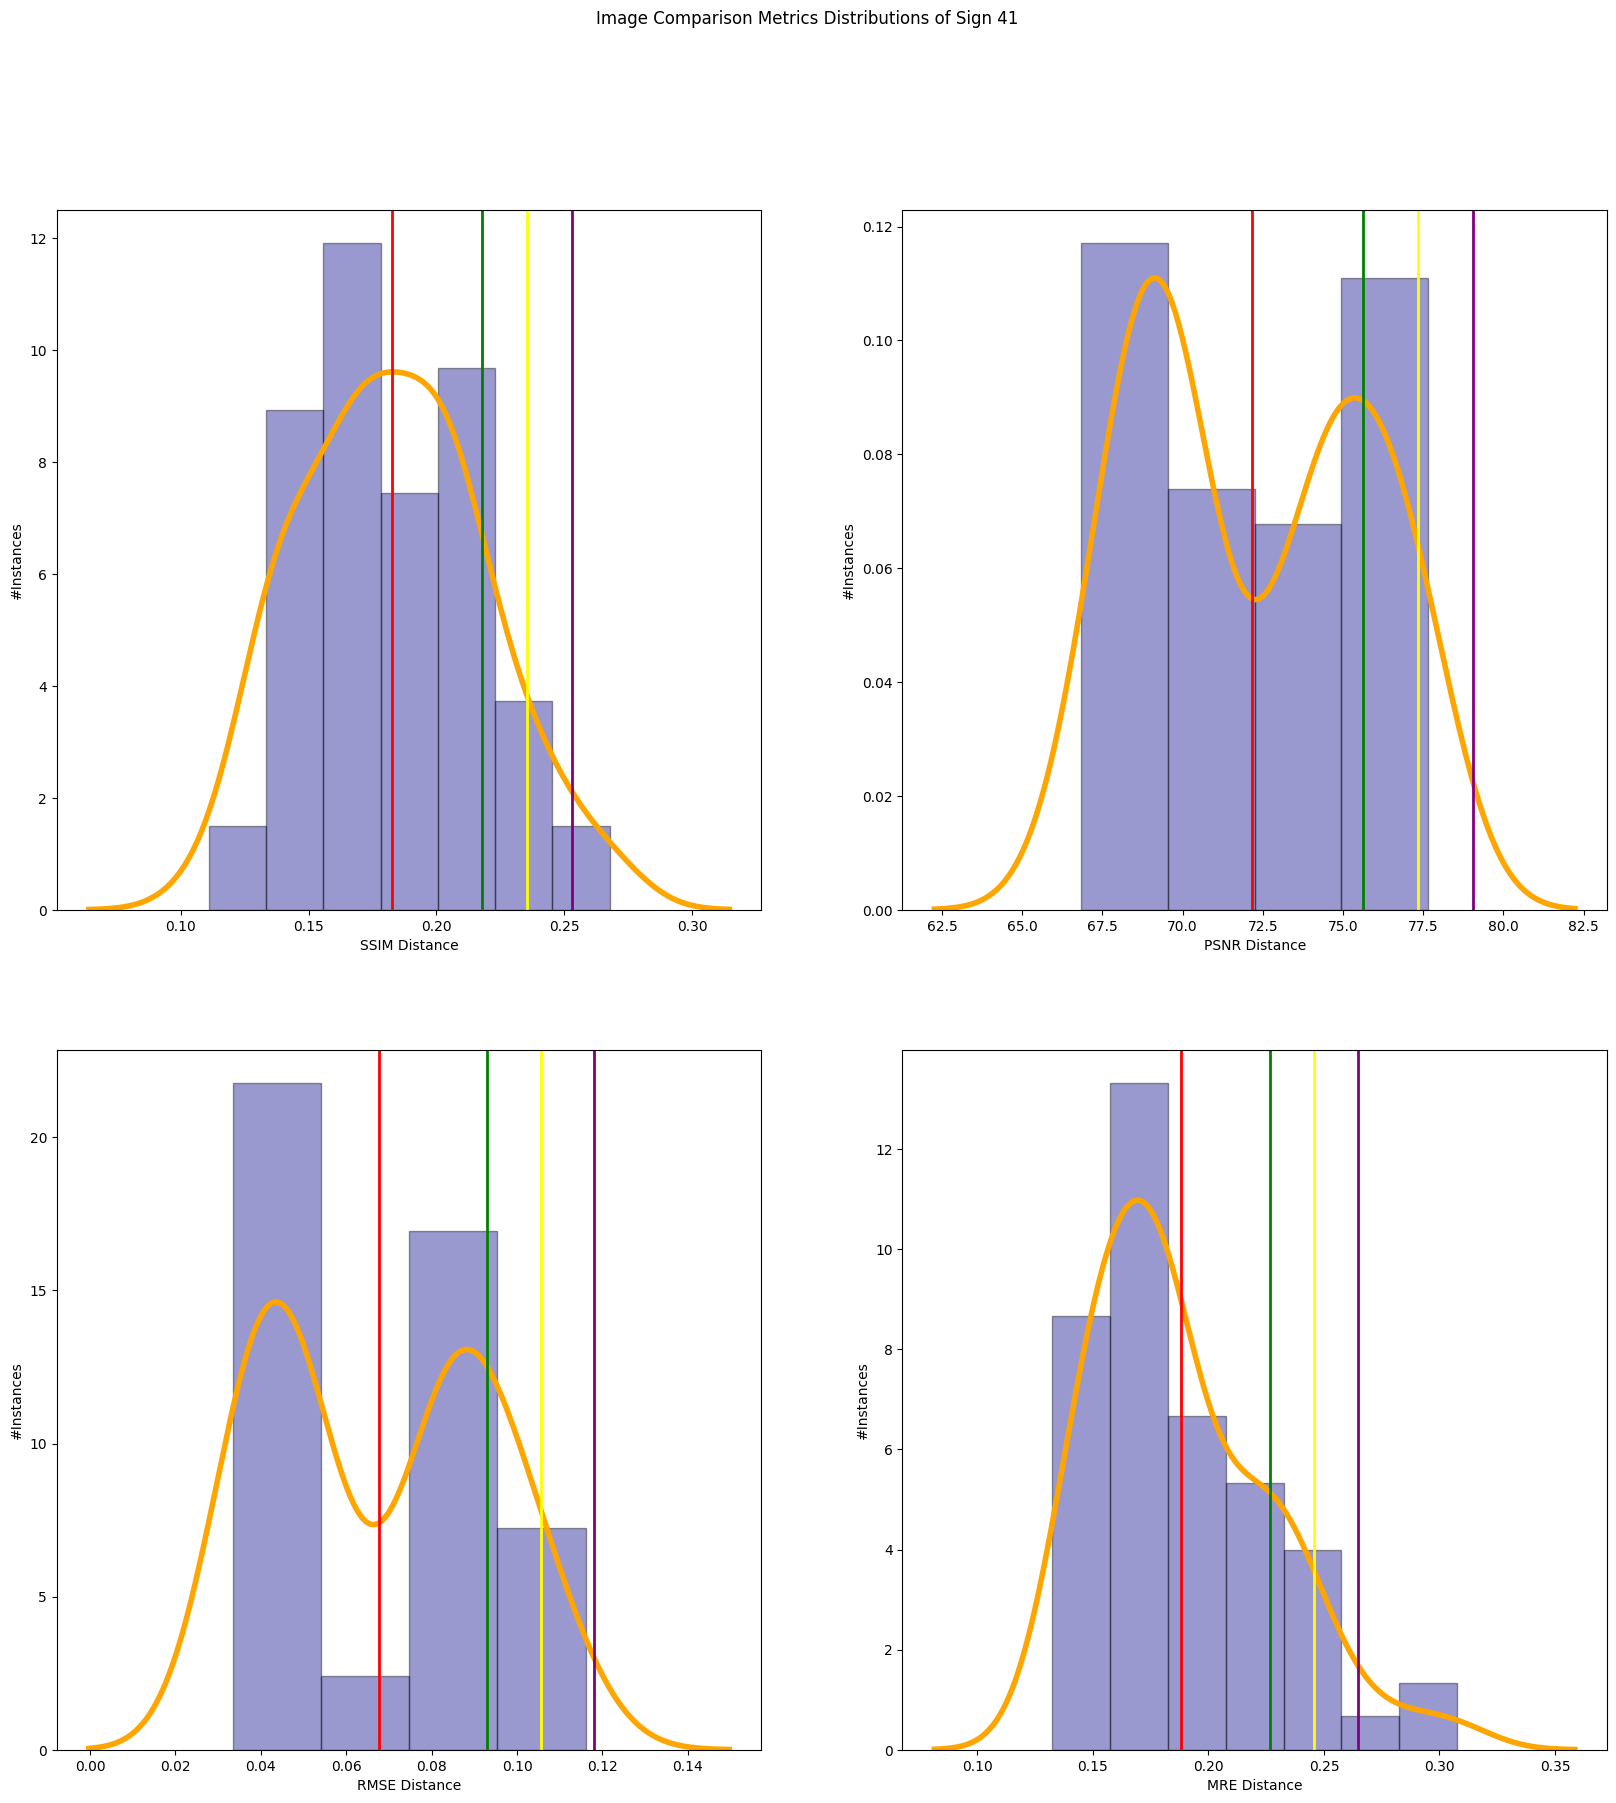

In [94]:
ssim, psnr, rmse, mre = testset(test_path41, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "41")

3/3 [==============================] - 0s 5ms/step
#Instances:  90
Destructor called, Employee deleted.
ssim mean:  0.1584470782015059  ssim σ:  0.1064174040189921  ssim μ+σ:  0.26486448222049797
ssim μ+1.5σ:  0.31807318422999403  ssim μ+2σ:  0.3712818862394901
psnr mean:  76.61132532755533  psnr σ:  6.354311817491591  psnr μ+σ:  82.96563714504693
psnr μ+1.5σ:  86.14279305379272  psnr μ+2σ:  89.31994896253852
rmse mean:  0.049654033  rmse σ:  0.037142217  rmse μ+σ:  0.086796254
rmse μ+1.5σ:  0.10536735877394676  rmse μ+2σ:  0.12393846735358238
mre mean:  0.13455752  mre σ:  0.027394613  mre μ+σ:  0.16195212
mre μ+1.5σ:  0.1756494352594018  mre μ+2σ:  0.18934674188494682


/tmp/ipykernel_122393/2660218213.py:61: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(ssim_vals, hist=True, kde=True, ax=axes[0,0],
/tmp/ipykernel_122393/2660218213.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(psnr_vals, hist=True, kde=True, ax=axes[0,1],
/tmp/ipykernel_122393/

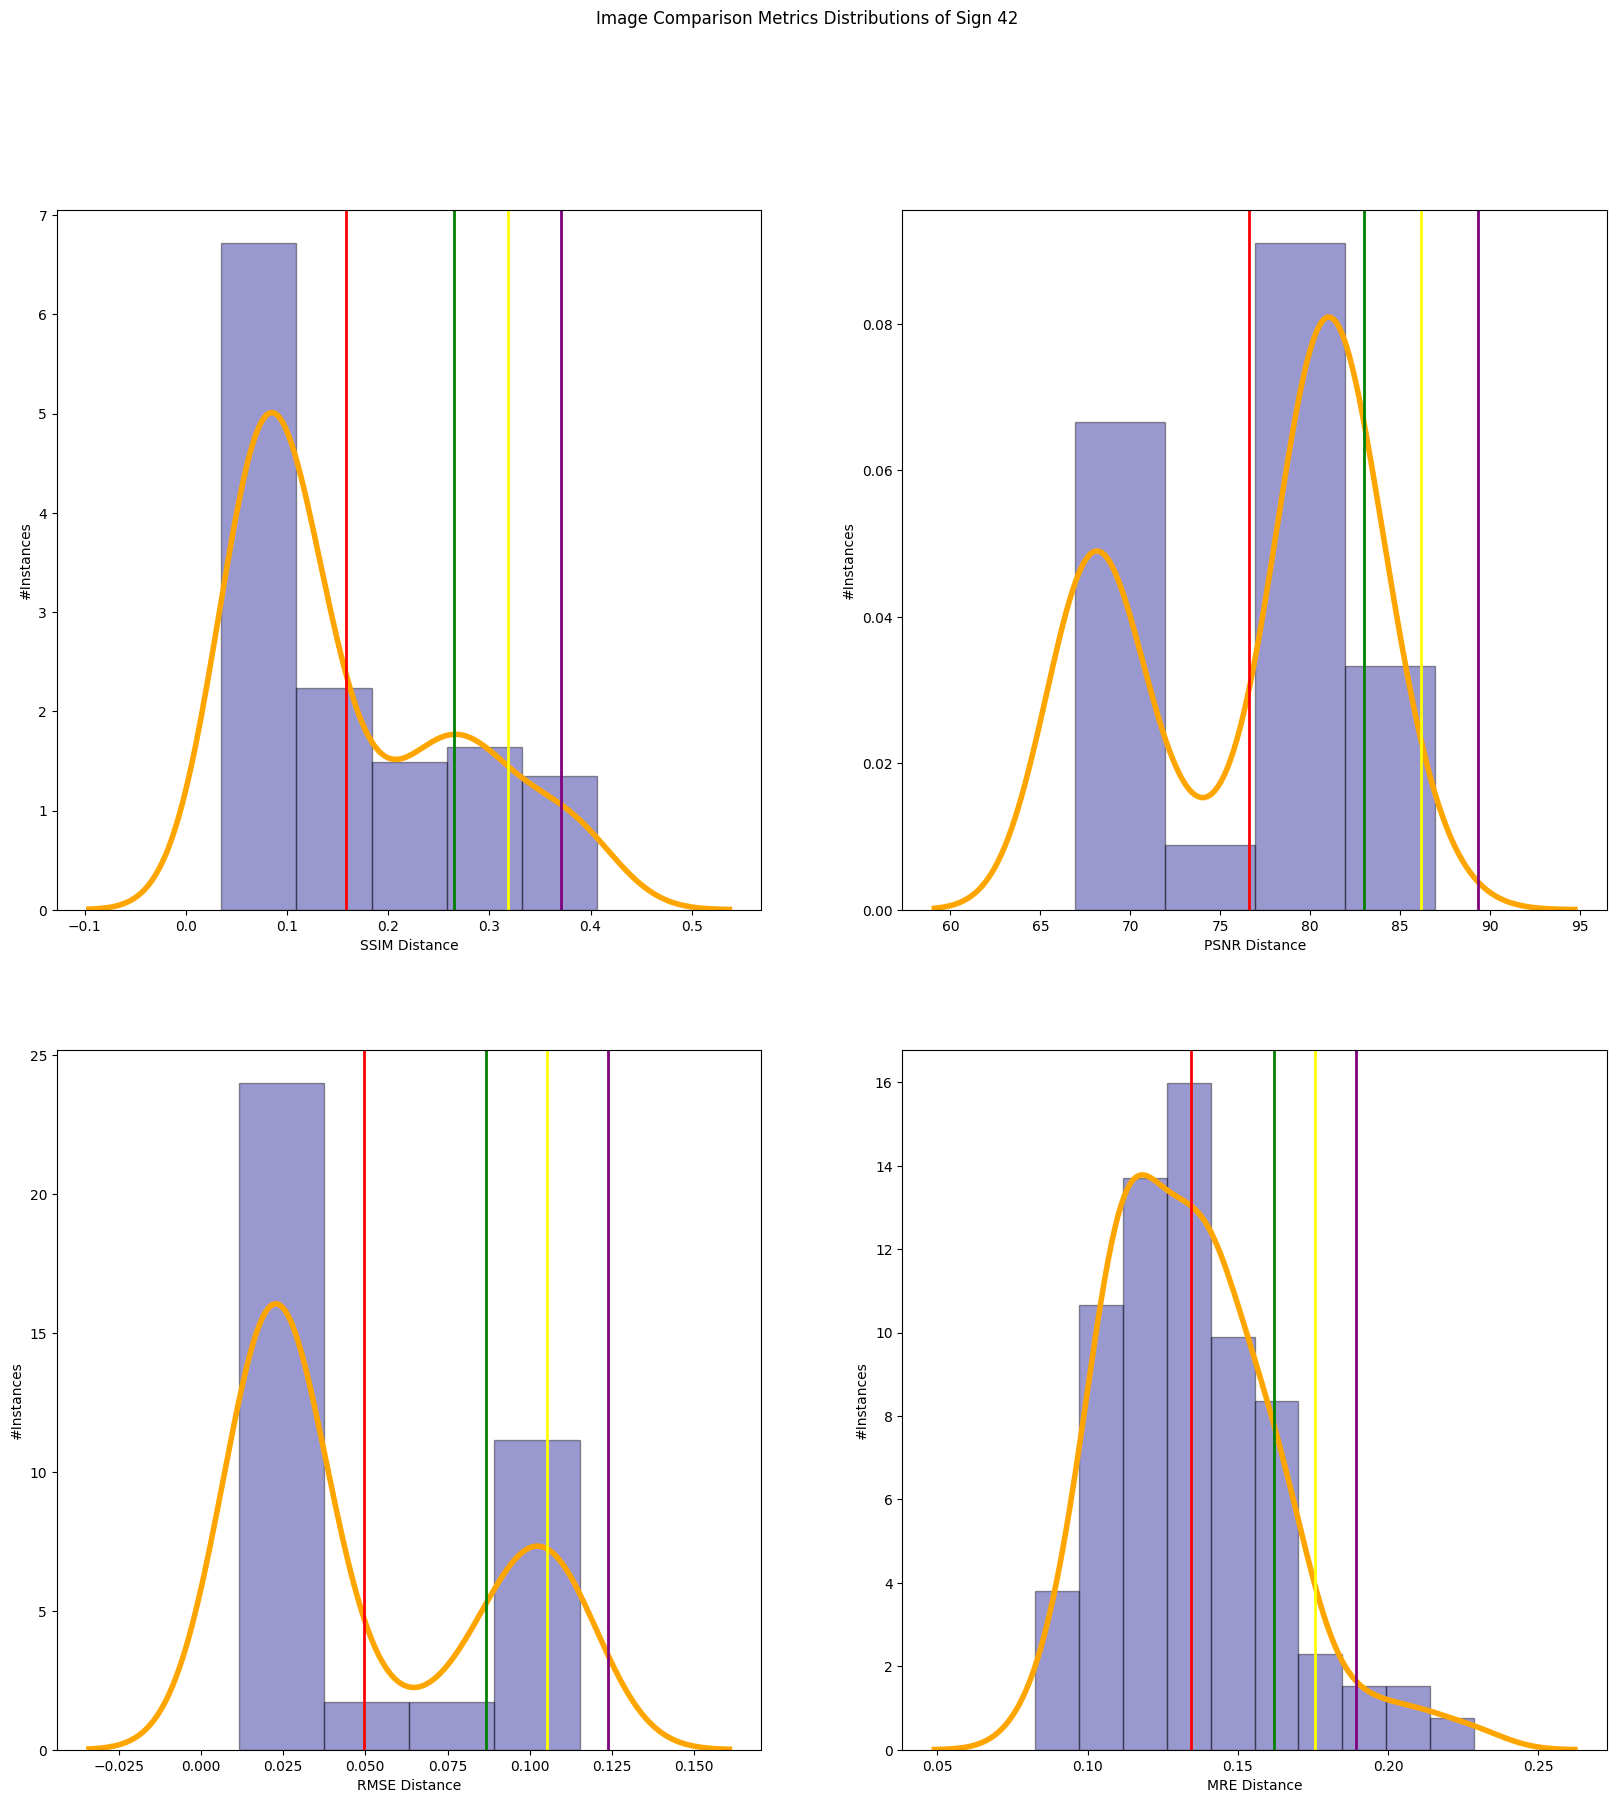

In [95]:
ssim, psnr, rmse, mre = testset(test_path42, model_cropped_all)
visualize(ssim, psnr, rmse, mre, "42")